# Entrainement des modeles avec Spark ml

In [1]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


### Creation du Spark Context

In [2]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


### Creation du Spark Session

In [3]:
spark = SparkSession \
    .builder \
    .appName("test") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Read csv file into spark dataframe 

In [4]:
#read csv file into dataFrame with automatically inferred schema

schema = StructType([
    StructField("sentiment", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("query_string", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)])

tweets_csv = spark.read.csv('training.csv',header=False,schema=schema)
tweets_csv.show(truncate=False, n=3)

+---------+----------+----------------------------+------------+---------------+-------------------------------------------------------------------------------------------------------------------+
|sentiment|id        |date                        |query_string|user           |text                                                                                                               |
+---------+----------+----------------------------+------------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0        |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY    |_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
|0        |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY    |scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|0        |1467

## Select les columns text et sentiment 

In [5]:
#select only "text" and "Sentiment" column, 
#and cast "Sentiment" column data into integer
data = tweets_csv.select("text", col("Sentiment").cast("Int").alias("label"))
data.show(truncate = False,n=10)

+-------------------------------------------------------------------------------------------------------------------+-----+
|text                                                                                                               |label|
+-------------------------------------------------------------------------------------------------------------------+-----+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|0    |
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |0    |
|@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |0    |
|my whole body feels itchy and like its on fire                                                                     |0    |
|@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     |0    |
|@Kwesid

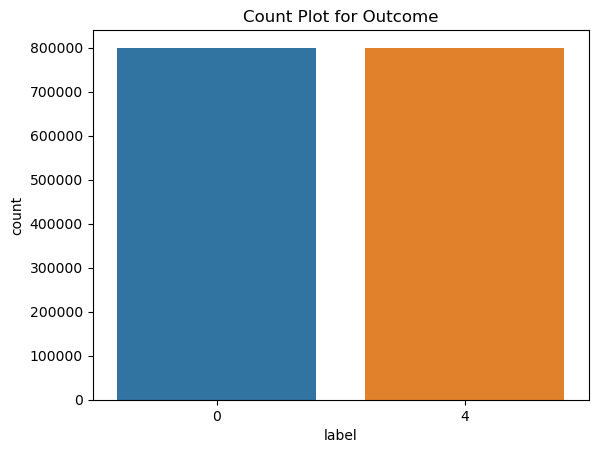

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
df= data.toPandas()
sns.countplot(x=df.label)
plt.title("Count Plot for Outcome")
plt.show()

## Split data to training  and testing

In [7]:
#divide data, 70% for training, 30% for testing
dividedData = data.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 1119607 ; Testing data rows: 480393


## traitement des données

### Separate "text" into individual words using tokenizer

In [8]:
tokenizer = Tokenizer(inputCol="text", outputCol="SentimentWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                |label|SentimentWords                                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|             i just want to hear from you. i guess that's asking t

### Removing stop words (unimportant words to be features)

In [9]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)
SwRemovedTrain.show(truncate=False, n=5)


+------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                |label|SentimentWords                                                                                                                                                           |MeaningfulWords                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------

### Converting words feature into numerical feature.

In [10]:
hashtf = HashingTF(numFeatures=2**16, inputCol="SentimentWords", outputCol='features')
numericTrainData = hashtf.transform(SwRemovedTrain).select('label', 'text', 'features')
numericTrainData.show(truncate=False, n=3)

+-----+------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                                |features                                                                                                                                                                                                                                                           |
+-----+------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------

# Logistic Regression

## Train our classifier model using training dat

In [11]:
lr = LogisticRegression(labelCol="label", featuresCol="features", 
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

Training is done!


## Prepare testing data

In [12]:
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashtf.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)


+-----+---------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+
|Label|MeaningfulWords                                                      |features                                                                                             |
+-----+---------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------+
|0    |[, , , , , , , , , , , , , , , , , , , missed, new, moon, trailer...]|(65536,[4495,24417,29945,38302,51849,52572,62501],[1.0,1.0,1.0,1.0,1.0,19.0,1.0])                    |
|0    |[, , , , , , , , , , want, ben&amp;jerrys, cake, batter, please, ugh]|(65536,[6350,13007,19208,24417,34313,52572,55682,56397,59184],[1.0,1.0,1.0,1.0,1.0,10.0,1.0,1.0,1.0])|
+-----+---------------------------------------------------------------------+-----------------------

## Predict testing data and calculate the accuracy mode

In [13]:
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "Label")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['Label']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData, 
      ", accuracy:", correctPrediction/totalData)

+---------------------------------------------------------------------+----------+-----+
|MeaningfulWords                                                      |prediction|Label|
+---------------------------------------------------------------------+----------+-----+
|[, , , , , , , , , , , , , , , , , , , missed, new, moon, trailer...]|0.0       |0    |
|[, , , , , , , , , , want, ben&amp;jerrys, cake, batter, please, ugh]|0.0       |0    |
|[, , , , , , , , head, feels, like, bowling, ball]                   |0.0       |0    |
|[, , , , , , , really2, like, condition., sucksssssss]               |0.0       |0    |
+---------------------------------------------------------------------+----------+-----+
only showing top 4 rows

correct prediction: 372368 , total data: 480393 , accuracy: 0.775132027319299


# NaiveBayes

In [14]:
from pyspark.ml.classification import NaiveBayes

## Train our classifier model using training dat

In [15]:
model2 = NaiveBayes(modelType="multinomial")
nbmodel = model2.fit(numericTrainData)
print ("Training is done!")

Training is done!


## Predict testing data and calculate the accuracy mode

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
prediction2 = nbmodel.transform(numericTest)

predictionFinal2 = prediction2.select(
    "MeaningfulWords", "prediction", "Label")
correctPrediction2 = predictionFinal2.filter(
    predictionFinal2['prediction'] == predictionFinal2['Label']).count()

evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy") 
nbaccuracy = evaluator.evaluate(prediction2) 
print("Test accuracy = " + str(nbaccuracy))


Test accuracy = 0.39026172321411845


# Streaming dataset

In [23]:
import json
from kafka import KafkaConsumer
from time import sleep
import numpy as np
import pandas as pd
import happybase as hb

## Set connexion to Hbase and create insert_row function

In [28]:
table_name = "twitter_tabl"

def connect_to_hbase():
    """ Connect to HBase server with localhost port 9090 which is Thrift is running."""
    
    conn = hb.Connection('localhost', 49155) 
    conn.open()
    
    table = conn.table(table_name)
    
    print(table)
    
    return conn, table

def insert_row(table, row):
    """ Insert a row into HBase. Rows have the following schema: 
    [ id, created_by, text, date ]"""
    try:
        row_id = '{}'.format(row['id'])
        txt = '{}'.format(row['tweet.full_text'])
        txt2 = '{}'.format(row['tweet.user.screen_name'])
        #print(txt)
        
        table.put(row_id, { 'tweet.full_text:': txt, 'tweet.user.screen_name:': txt2 })
        print('Insert data: [{}, {} ]'.format( txt, txt2))
        raise ValueError("Something went wrong!")
    
    except ValueError as e:
        # error handling goes here; nothing is sent to HBase
        pass
    
    else:
        # no exceptions; send data
        b.send()
    
# After everything has been defined, run the script.
conn, table = connect_to_hbase()
print('Connect to HBase. table name: {}'.format(table_name))


<happybase.table.Table name=b'twitter_tabl'>
Connect to HBase. table name: twitter_tabl


In [29]:
import matplotlib.pyplot as plt
import numpy as np


## Get streaming tweets and Predict sentiments using LogisticRegression model and storing  tweets in hbase

Insert data: [RT @realMaxAvery: @squawksquare This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #E…, BrayahTejada ]
nombre of tweets : 1
nombre de positive tweets :  0
nombre de negative tweets  : 1
+--------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                             |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @squawksquare, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------

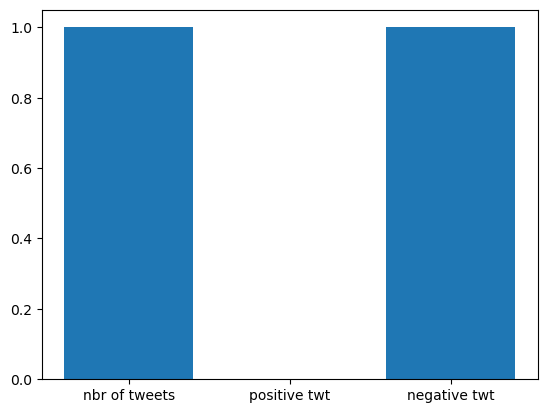

Insert data: [RT @PhillipAdams_1: Not content with wrecking Twitter the mighty Musk has trashed his Tesla. Company value down almost 60%. Any cachet to d…, stephengeo4 ]
nombre of tweets : 2
nombre de positive tweets :  1
nombre de negative tweets  : 1
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                       |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @phillipadams_1:, content, wrecking, twitter, mighty, musk, trashed, tesla., company, value, almost, 60%., cachet, d\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------------------+----------+



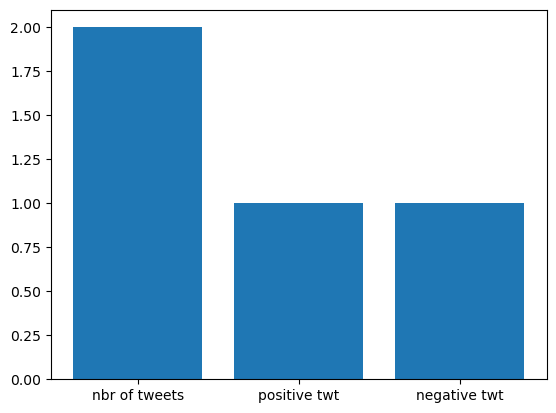

Insert data: [RT @JaMtoka: Tesla may be preparing to launch a new electric van in 2024, with the potential to be offered as both a commercial model as we…, darth_mziidious ]
nombre of tweets : 3
nombre de positive tweets :  2
nombre de negative tweets  : 1
+----------------------------------------------------------------------------+----------+
|MeaningfulWords                                                             |prediction|
+----------------------------------------------------------------------------+----------+
|["[""rt, @jamtoka:, tesla, may, preparing, launch, new, electric, van, 2024]|4.0       |
+----------------------------------------------------------------------------+----------+



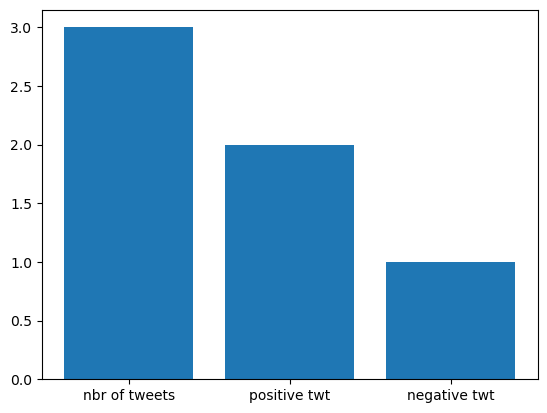

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, ximng51343780 ]
nombre of tweets : 4
nombre de positive tweets :  3
nombre de negative tweets  : 1
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-------

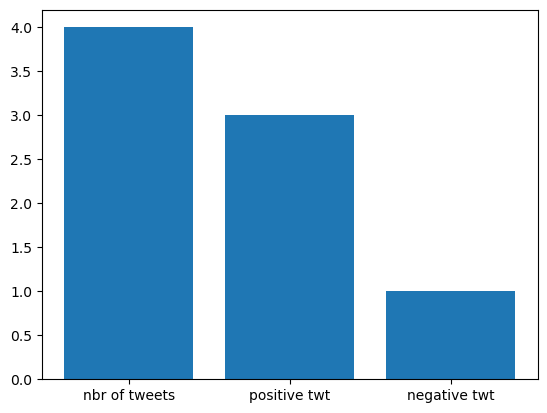

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, AhmedTrop ]
nombre of tweets : 5
nombre de positive tweets :  4
nombre de negative tweets  : 1
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+----------+

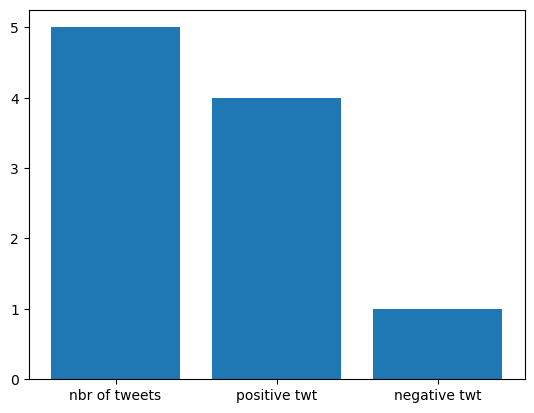

Insert data: [RT @kipjmooney: Stepping down as CEO of Twitter or getting replaced as CEO of Tesla is not enough. I need to see Elon work in an actual eme…, lucysto86502385 ]
nombre of tweets : 6
nombre de positive tweets :  4
nombre de negative tweets  : 2
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @kipjmooney:, stepping, ceo, twitter, getting, replaced, ceo, tesla, enough., need, see, elon, work, actual, eme\u2026""]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------+----------+



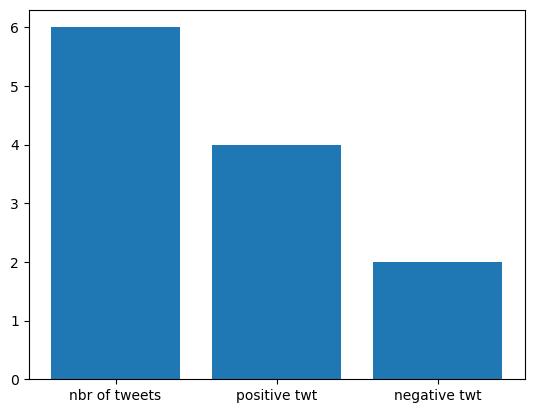

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Rafazer01 ]
nombre of tweets : 7
nombre de positive tweets :  5
nombre de negative tweets  : 2
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+----------+

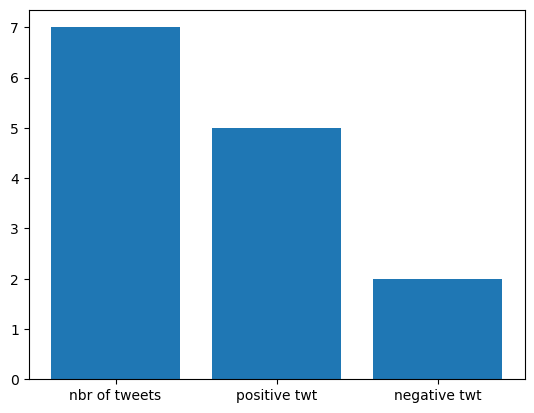

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Alejand40371128 ]
nombre of tweets : 8
nombre de positive tweets :  6
nombre de negative tweets  : 2
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-----

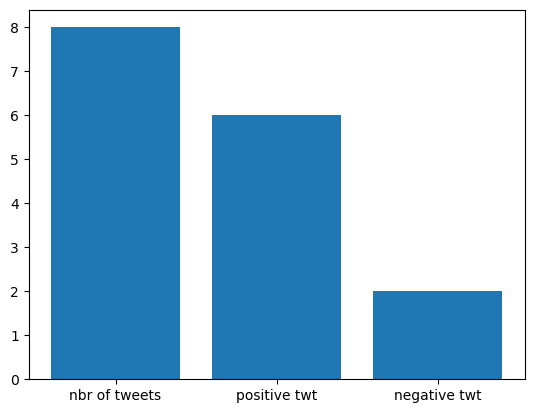

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, bunarath_srey ]
nombre of tweets : 9
nombre de positive tweets :  7
nombre de negative tweets  : 2
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-------

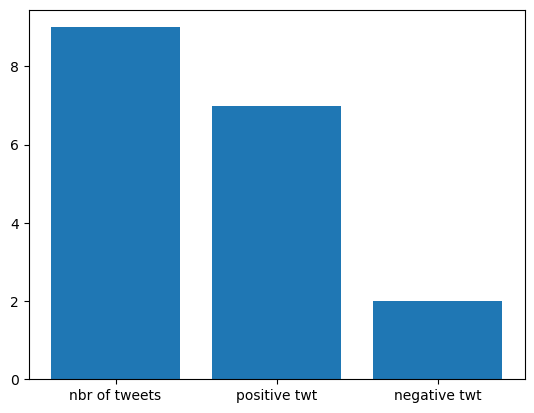

Insert data: [RT @spurtmagoo: elon running his tesla in his garage for a very long time before realizing he's going to have to try another method, bonnieringtail ]
nombre of tweets : 10
nombre de positive tweets :  8
nombre de negative tweets  : 2
+----------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @spurtmagoo:, elon, running, tesla, garage, long, time, realizing, going, try, another, method""]|4.0       |
+----------------------------------------------------------------------------------------------------------+----------+



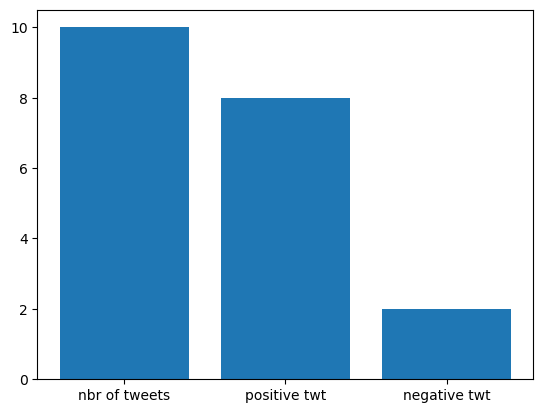

Insert data: [@RyanPfenninger @SenWarren @Twitter @Tesla The left never stops attacking that’s why, Terranc82569059 ]
nombre of tweets : 11
nombre de positive tweets :  8
nombre de negative tweets  : 3
+------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------+----------+
|["[""@ryanpfenninger, @senwarren, @twitter, @tesla, left, never, stops, attacking, that\u2019s, why""]|0.0       |
+------------------------------------------------------------------------------------------------------+----------+



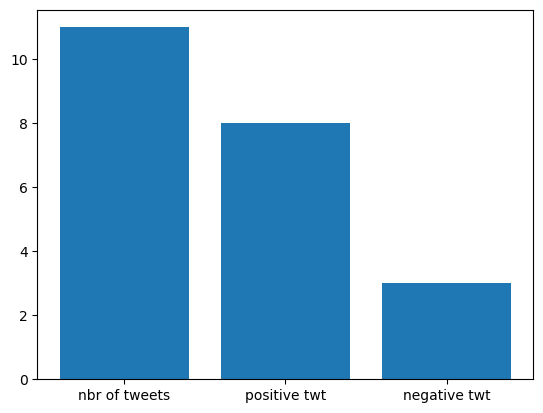

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, SHMUELYT ]
nombre of tweets : 12
nombre de positive tweets :  9
nombre de negative tweets  : 3
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+----------+

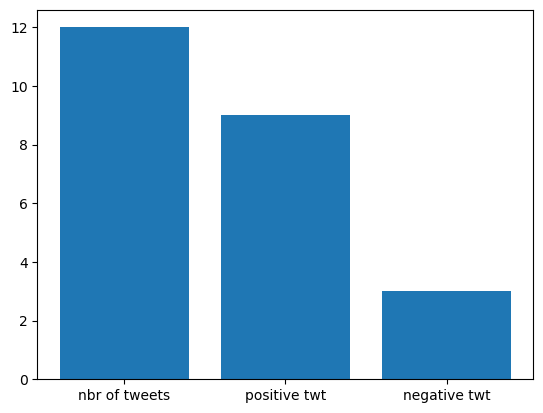

Insert data: [@texaslib @iheartmindy @SenWarren @Twitter @Tesla 😅🤣😂 someplace there's a huge hole with millions of Liz Warren books in it. I'm sure she sold every single copy of every single book that she's ever written. Most of them to herself., MitchRonshaugen ]
nombre of tweets : 13
nombre de positive tweets :  9
nombre de negative tweets  : 4
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                              |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------

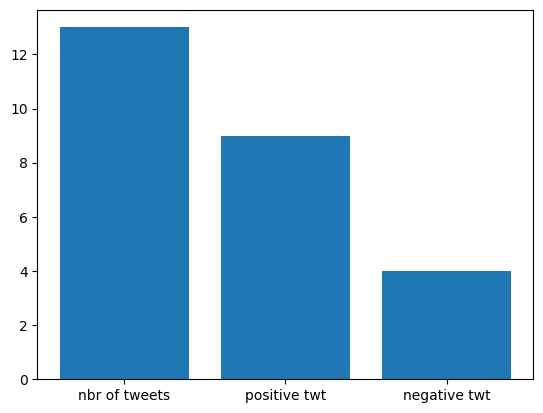

Insert data: [@SenWarren @Twitter @Tesla The nerve of these central planners. When will Atlas shrug?, bamahurin ]
nombre of tweets : 14
nombre de positive tweets :  9
nombre de negative tweets  : 5
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, nerve, central, planners., atlas, shrug?""]|0.0       |
+------------------------------------------------------------------------------+----------+



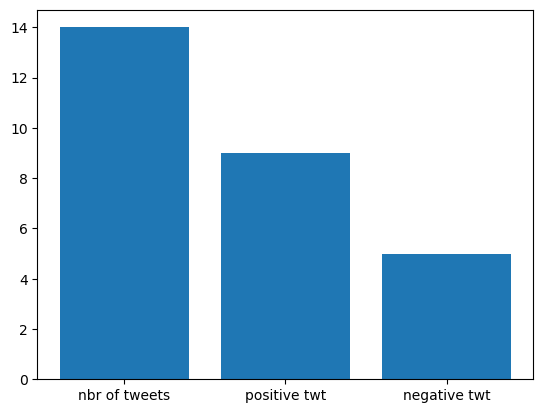

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, ggg11117918864 ]
nombre of tweets : 15
nombre de positive tweets :  10
nombre de negative tweets  : 5
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+----

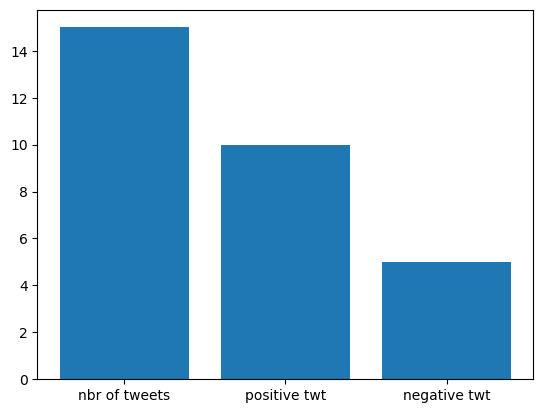

Insert data: [@elonmusk @farzyness Until Tesla makes a Hybrid, she will be all supportive towards you., Trippshot_AE ]
nombre of tweets : 16
nombre de positive tweets :  11
nombre de negative tweets  : 5
+-------------------------------------------------+----------+
|MeaningfulWords                                  |prediction|
+-------------------------------------------------+----------+
|["[""@elonmusk, @farzyness, tesla, makes, hybrid]|4.0       |
+-------------------------------------------------+----------+



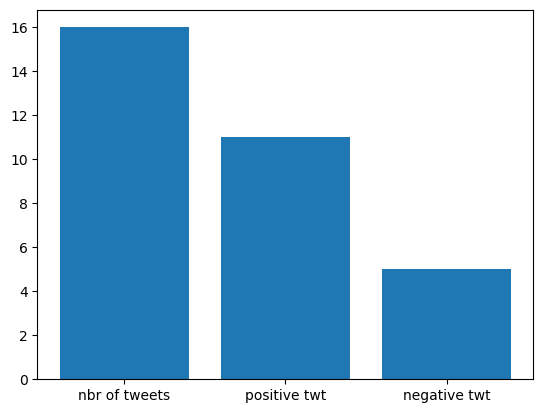

Insert data: [@WholeMarsBlog Hey @elonmusk stop wasting f**king time on twitter

https://t.co/7pWhOl17Us

@cfb_18, Proctooor ]
nombre of tweets : 17
nombre de positive tweets :  12
nombre de negative tweets  : 5
+-------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                    |prediction|
+-------------------------------------------------------------------------------------------------------------------+----------+
|["[""@wholemarsblog, hey, @elonmusk, stop, wasting, f**king, time, twitter\n\nhttps://t.co/7pwhol17us\n\n@cfb_18""]|4.0       |
+-------------------------------------------------------------------------------------------------------------------+----------+



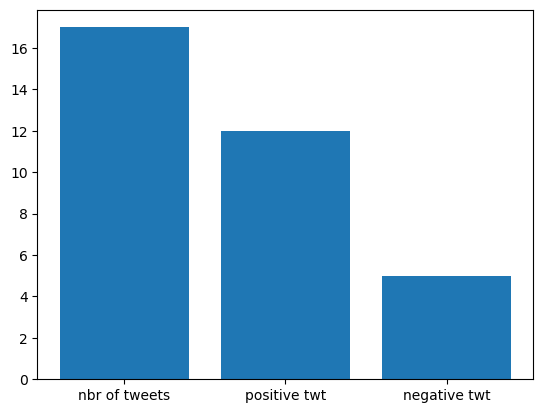

Insert data: [@Tesla @elonmusk That's great. Just one question...

What happens when the roof needs to be replaced? I'm assuming the homeowner has to absorb the expense of that entire installation being torn down then replaced after the roofing is complete?, TweetShaming21 ]
nombre of tweets : 18
nombre de positive tweets :  12
nombre de negative tweets  : 6
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                             |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@tesla, @elonmusk, great., 

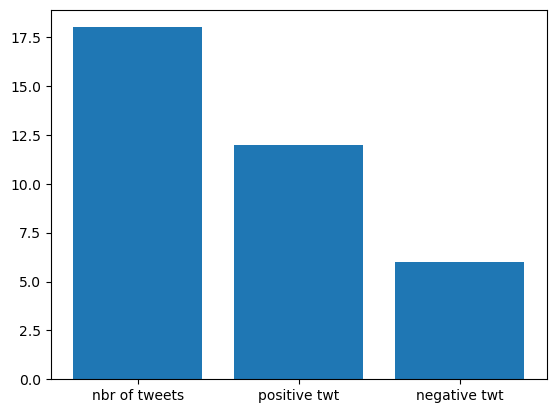

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, kaneisable95 ]
nombre of tweets : 19
nombre de positive tweets :  12
nombre de negative tweets  : 7
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+------

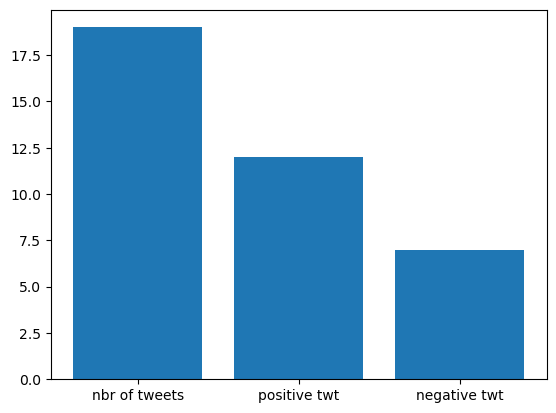

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, DragonSlime10 ]
nombre of tweets : 20
nombre de positive tweets :  12
nombre de negative tweets  : 8
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-----

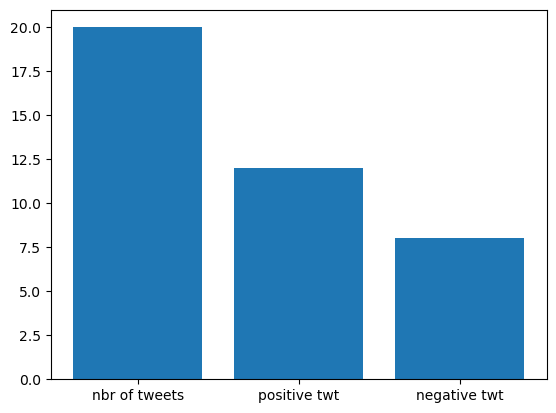

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, DushiEldar ]
nombre of tweets : 21
nombre de positive tweets :  12
nombre de negative tweets  : 9
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--------

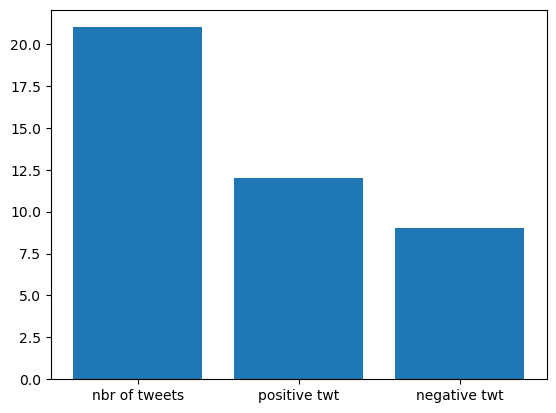

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, 284Respek ]
nombre of tweets : 22
nombre de positive tweets :  12
nombre de negative tweets  : 10
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--------

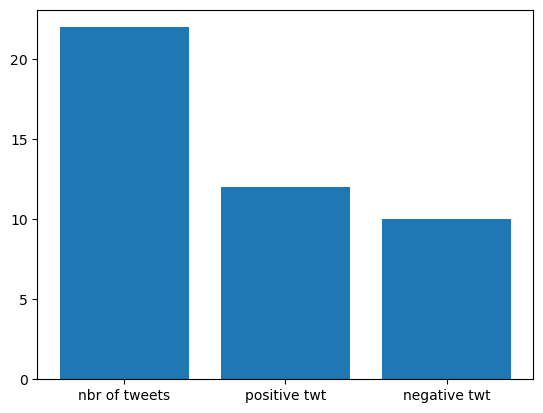

Insert data: [RT @SenWarren: Elon Musk took over @Twitter, but he's still the CEO of @Tesla. That raises legal concerns — is he creating conflicts of int…, RhonaSparkesBre ]
nombre of tweets : 23
nombre de positive tweets :  12
nombre de negative tweets  : 11
+-------------------------------------------------+----------+
|MeaningfulWords                                  |prediction|
+-------------------------------------------------+----------+
|["[""rt, @senwarren:, elon, musk, took, @twitter]|0.0       |
+-------------------------------------------------+----------+



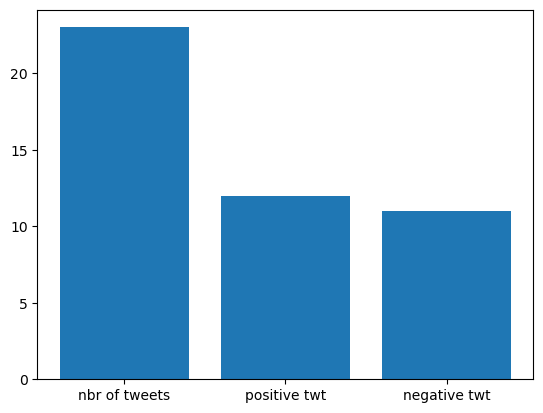

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, pat_laser023 ]
nombre of tweets : 24
nombre de positive tweets :  12
nombre de negative tweets  : 12
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-----

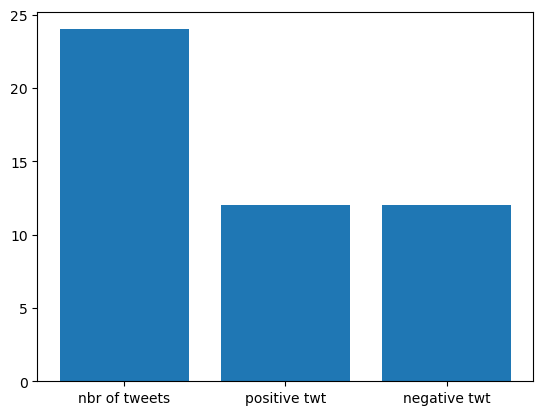

Insert data: [@MicheleRenae13 @RitaPanahi @SenWarren @Twitter @Tesla https://t.co/gFx1368cyC, Shirtaganda ]
nombre of tweets : 25
nombre de positive tweets :  13
nombre de negative tweets  : 12
+-------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                            |prediction|
+-------------------------------------------------------------------------------------------+----------+
|["[""@michelerenae13, @ritapanahi, @senwarren, @twitter, @tesla, https://t.co/gfx1368cyc""]|4.0       |
+-------------------------------------------------------------------------------------------+----------+



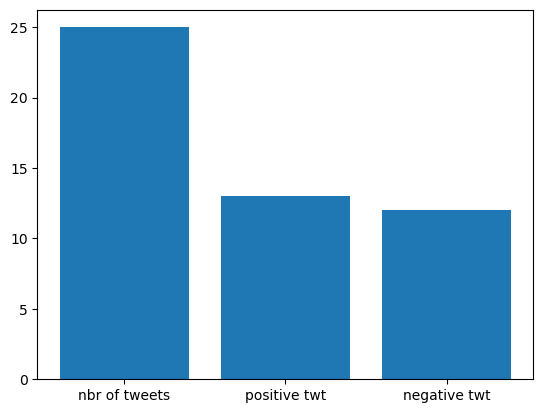

Insert data: [RT @SenWarren: Elon Musk took over @Twitter, but he's still the CEO of @Tesla. That raises legal concerns — is he creating conflicts of int…, MuckFusk12 ]
nombre of tweets : 26
nombre de positive tweets :  13
nombre de negative tweets  : 13
+-------------------------------------------------+----------+
|MeaningfulWords                                  |prediction|
+-------------------------------------------------+----------+
|["[""rt, @senwarren:, elon, musk, took, @twitter]|0.0       |
+-------------------------------------------------+----------+



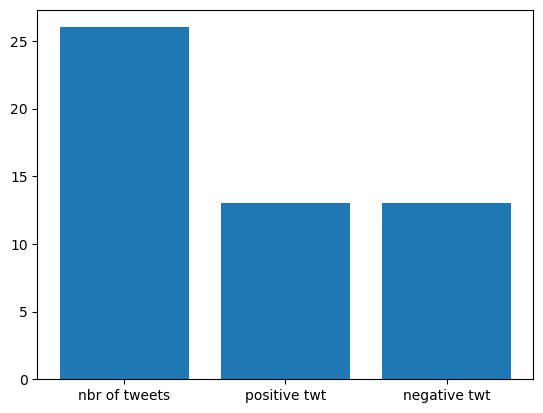

Insert data: [@ryota_tesla アルト思いたい, tesla_kobe ]
nombre of tweets : 27
nombre de positive tweets :  14
nombre de negative tweets  : 13
+----------------------------------------------------------------+----------+
|MeaningfulWords                                                 |prediction|
+----------------------------------------------------------------+----------+
|["[""@ryota_tesla, \u30a2\u30eb\u30c8\u601d\u3044\u305f\u3044""]|4.0       |
+----------------------------------------------------------------+----------+



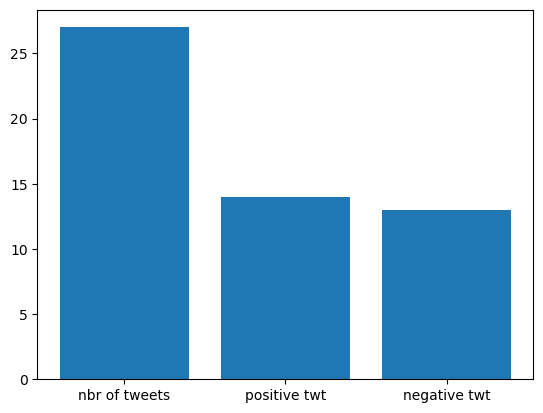

Insert data: [Every time I see Tesla stock I keep singing "Just keep Fallin Fallin Fallin Fallin yeah" to the tune of Limp Bizkits Rollin (air raid mix), terryfuck45 ]
nombre of tweets : 28
nombre de positive tweets :  15
nombre de negative tweets  : 13
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                             |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""every, time, see, tesla, stock, keep, singing, \""just, keep, fallin, fallin, fallin, fallin, yeah\"", tune, limp, bizkits, rollin, (air, raid, mix)""]|4.0       |
+-----------------------------------------------------------------

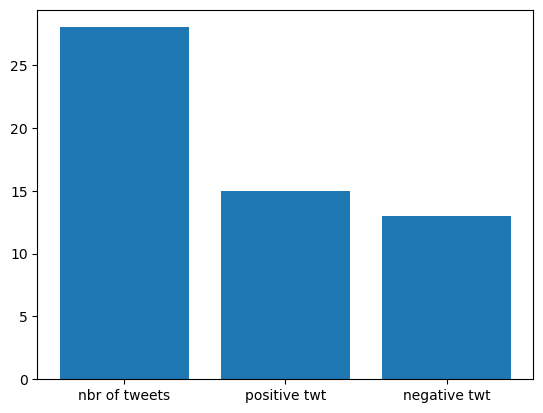

Insert data: [RT @Teslarati: Tesla China produced more Model Ys than SAIC-GM’s ultra-cheap Mini EV in November
https://t.co/oZDTilBl7l by @ResidentSponge, IVANAGU90585190 ]
nombre of tweets : 29
nombre de positive tweets :  16
nombre de negative tweets  : 13
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @teslarati:, tesla, china, produced, model, ys, saic-gm\u2019s, ultra-cheap, mini, ev, november\nhttps://t.co/ozdtilbl7l, @residentsponge""]|4.0       |
+----------------------------------------------------------------------------------------

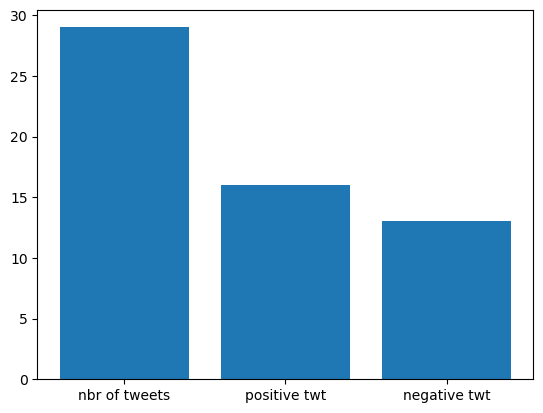

Insert data: [@TheUSASingers so.... https://t.co/iHC6s09M4Z, Tesla_Sux ]
nombre of tweets : 30
nombre de positive tweets :  17
nombre de negative tweets  : 13
+-------------------------------------------------------+----------+
|MeaningfulWords                                        |prediction|
+-------------------------------------------------------+----------+
|["[""@theusasingers, so...., https://t.co/ihc6s09m4z""]|4.0       |
+-------------------------------------------------------+----------+



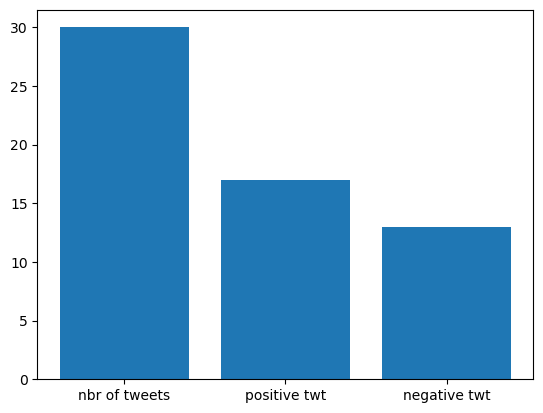

Insert data: [RT @stateofexile_: 'The present is theirs, the future is mine.'

Resistance #12 - Tesla

Tonight at 11pm UTC on @exchgART https://t.co/Mh3Y…, bo_digi ]
nombre of tweets : 31
nombre de positive tweets :  17
nombre de negative tweets  : 14
+----------------------------------------+----------+
|MeaningfulWords                         |prediction|
+----------------------------------------+----------+
|["[""rt, @stateofexile_:, 'the, present]|0.0       |
+----------------------------------------+----------+



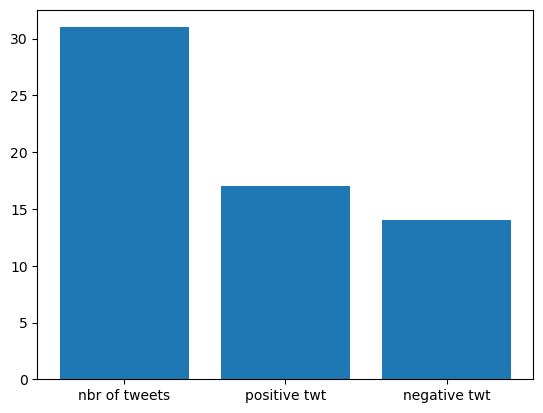

Insert data: [RT @mirandadevine: Tesla stock smashed 42% since @elonmusk bought Twitter, as Wall Street Dem allies tighten screws to prevent secrets bein…, K2Shauna ]
nombre of tweets : 32
nombre de positive tweets :  18
nombre de negative tweets  : 14
+----------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                         |prediction|
+----------------------------------------------------------------------------------------+----------+
|["[""rt, @mirandadevine:, tesla, stock, smashed, 42%, since, @elonmusk, bought, twitter]|4.0       |
+----------------------------------------------------------------------------------------+----------+



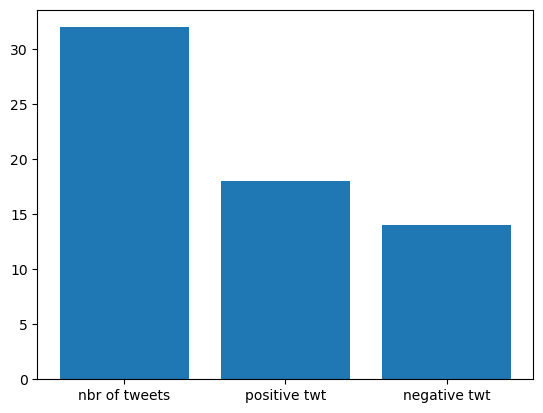

Insert data: [RT @germangleza: Fácilmente pondría a Satoshi Nakamoto en la lista de los grandes inventores que cambiaron la historia del mundo junto a:…, hectorg99 ]
nombre of tweets : 33
nombre de positive tweets :  19
nombre de negative tweets  : 14
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @germangleza:, f\u00e1cilmente, pondr\u00eda, satoshi, nakamoto, en, la, lista, de, los, grandes, inventores, que, cambiaron, la, historia, del, mundo, junto, 

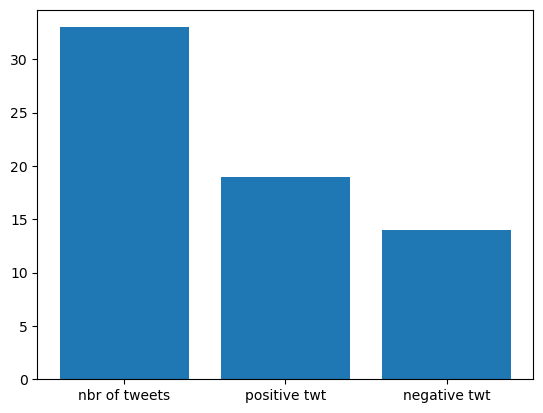

Insert data: [RT @Teslaconomics: The Cybertruck will be the best product that Tesla has ever produced. 

The number of accessories that 3rd party compani…, BoersenDE ]
nombre of tweets : 34
nombre de positive tweets :  20
nombre de negative tweets  : 14
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @teslaconomics:, cybertruck, best, product, tesla, ever, produced., \n\nthe, number, accessories, 3rd, party, compani\u2026""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------------------+----------+



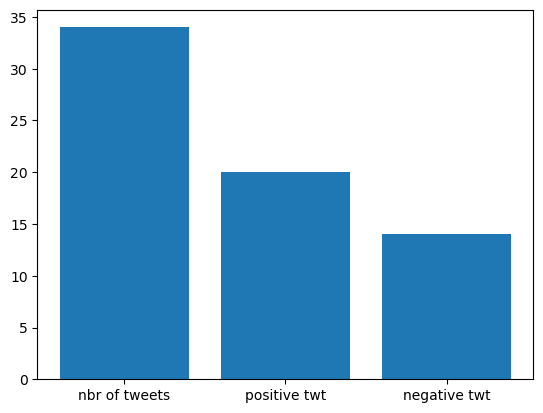

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, AH89571273 ]
nombre of tweets : 35
nombre de positive tweets :  21
nombre de negative tweets  : 14
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



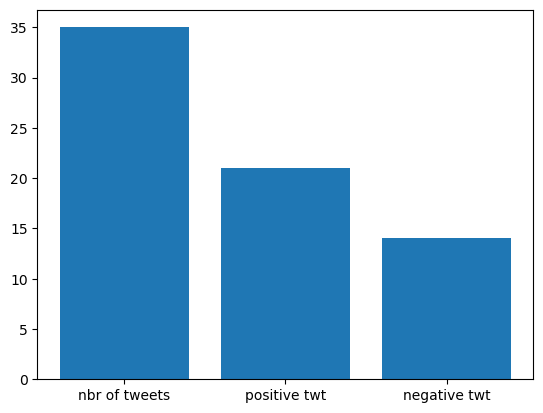

Insert data: [RT @girlsreallyrule: Don't f*** with a law professor: Elizabeth Warren has formally raised concerns to the Tesla Board Chairman that the Bo…, _Unicornsfyeah ]
nombre of tweets : 36
nombre de positive tweets :  22
nombre de negative tweets  : 14
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                      |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @girlsreallyrule:, f***, law, professor:, elizabeth, warren, formally, raised, concerns, tesla, board, chairman, bo\u2026""]|4.0       |
+-------------------------------------------------------------------------------------------------------------------------------------+----------+



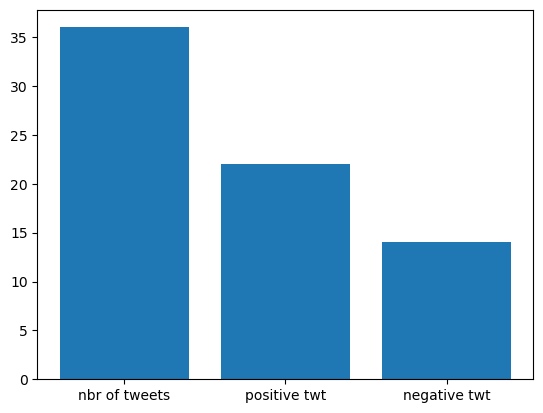

Insert data: [@elonmusk @andst7 @Corriere look forward to the Tesla, laqsyzsylaq ]
nombre of tweets : 37
nombre de positive tweets :  23
nombre de negative tweets  : 14
+-----------------------------------------------------------+----------+
|MeaningfulWords                                            |prediction|
+-----------------------------------------------------------+----------+
|["[""@elonmusk, @andst7, @corriere, look, forward, tesla""]|4.0       |
+-----------------------------------------------------------+----------+



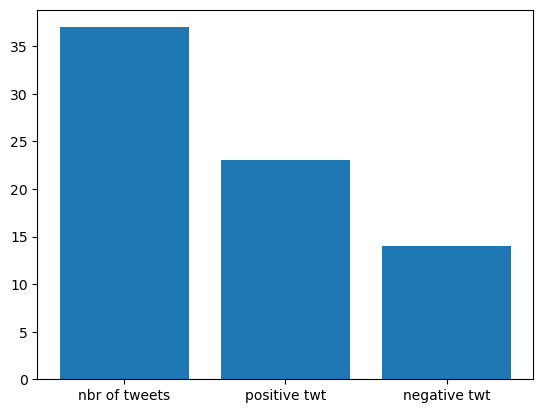

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, ArqteaQ50 ]
nombre of tweets : 38
nombre de positive tweets :  24
nombre de negative tweets  : 14
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



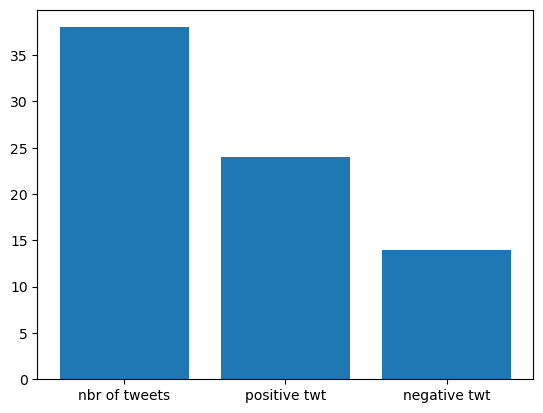

Insert data: [RT @DougJBalloon: Opinion | Some say Musk should be ousted at Tesla.  But Tesla without Elon Musk is like Theranos without Elizabeth Homes., rowast ]
nombre of tweets : 39
nombre de positive tweets :  25
nombre de negative tweets  : 14
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                            |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @dougjballoon:, opinion, |, say, musk, ousted, tesla., , tesla, without, elon, musk, like, theranos, without, elizabeth, homes.""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------

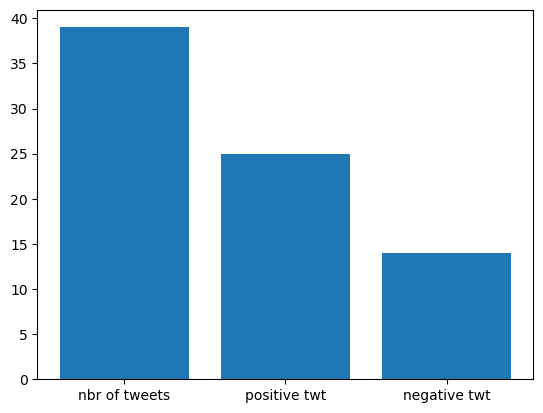

Insert data: [Investors know what’s up. Don’t try to catch the falling knife. Considering FSD has been an overpromise, Tesla isn’t the “technology” company after all, it’s just another car company. With an unhinged fraud running it. https://t.co/67GVlI6d89, BrickmanInGA ]
nombre of tweets : 40
nombre de positive tweets :  26
nombre de negative tweets  : 14
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""investors, know, what\u2019s, up., don\u2019t, try, catch, falling, knife., considering, fsd, overpromise]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



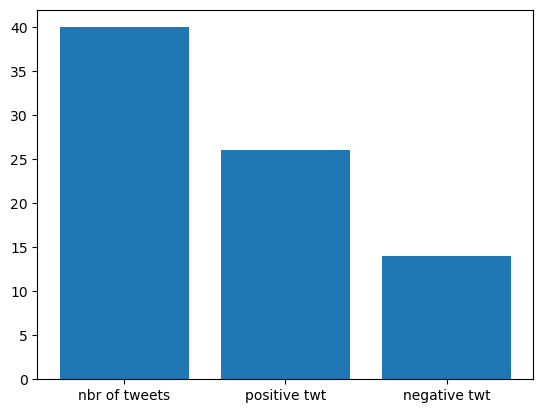

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, 36Nonagon ]
nombre of tweets : 41
nombre de positive tweets :  27
nombre de negative tweets  : 14
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



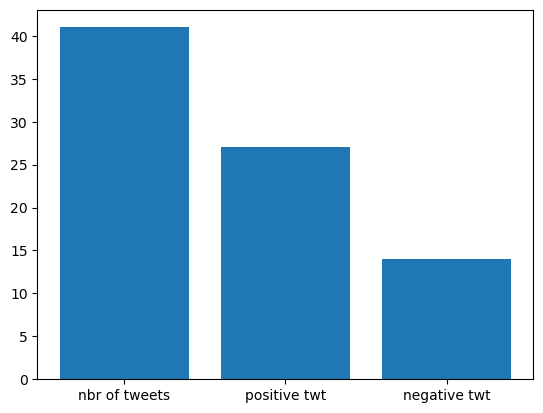

Insert data: [Why #TSLA is down so much? Is #ElonMusk the only reason? Very sad and bad year for Tesla stock holders and fans of Elon Musk. He is believing Twitter too much. Making another twitter is not rocket science. https://t.co/62UyznIP6i, BVReddy_RBVR ]
nombre of tweets : 42
nombre de positive tweets :  27
nombre de negative tweets  : 15
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""why, #tsl

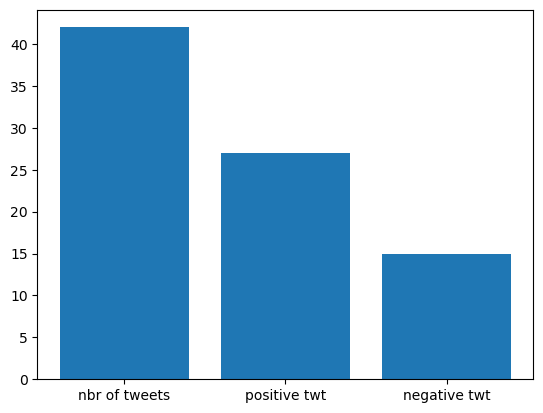

Insert data: [RT @HSajwanization: Jeff Bezos’s Amazon $AMZN just became the world’s first company to lose $1 trillion (yes TRILLION) in market value, the…, chikusin2 ]
nombre of tweets : 43
nombre de positive tweets :  28
nombre de negative tweets  : 15
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @hsajwanization:, jeff, bezos\u2019s, amazon, $amzn, became, world\u2019s, first, company, lose, $1, trillion, (yes, trillion), market, value]|4.0       |
+-------------------------------------------------------------------------------------

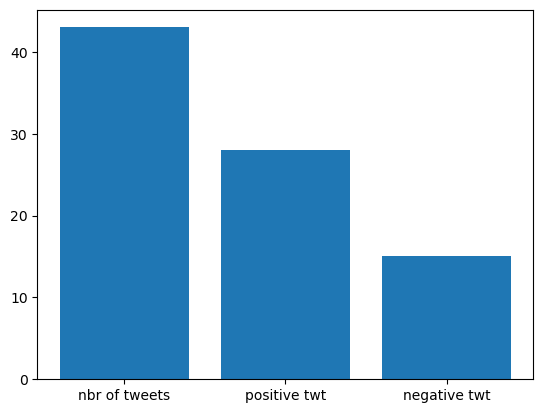

Insert data: [RT @SteveShallenbe1: @SenWarren @Twitter @Tesla We should investigate every single politician who became a millionaire in office….every sti…, conco1234321 ]
nombre of tweets : 44
nombre de positive tweets :  29
nombre de negative tweets  : 15
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @steveshallenbe1:, @senwarren, @twitter, @tesla, investigate, every, single, politician, became, millionaire, office\u2026.every, sti\u2026""]|4.0       |
+----------------------------------------------------------------------------------

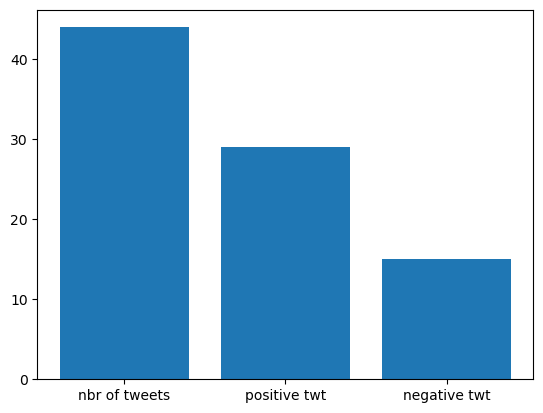

Insert data: [@garyblack00 This Tesla vs QQQ with @elonmusk selling Tesla. With TX &amp; Berlin ramp behind schedule (should be 5k/wk not 3k), Tesla is not running well. Chinese engrs won’t help much. Culture is different. Look at what $TSM did. Send Taiwanese engrs to run US Fab. He needs to be onsite. https://t.co/P7z0bBiuQ2, raikk61 ]
nombre of tweets : 45
nombre de positive tweets :  30
nombre de negative tweets  : 15
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@garyblack00, tesla, vs, qqq, @elonmusk, selling, tesla., tx, &amp;, berlin, ramp, behind, schedule, (should, 5k/wk, 3k)]|4.0       |
+-------------

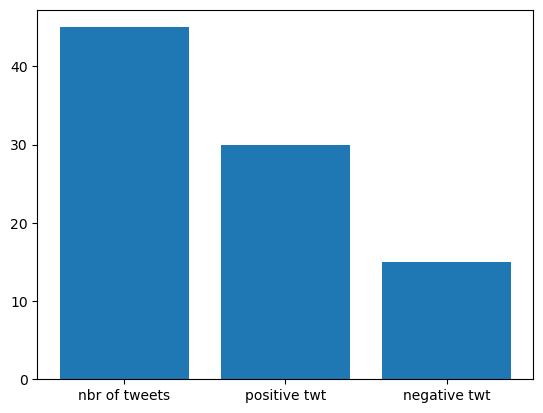

Insert data: [RT @Quinnae_Moon: What's happening is that he is, at best, maliciously complying with the poll and *languidly* slow-walking a resignation.…, tristanbergh ]
nombre of tweets : 46
nombre de positive tweets :  30
nombre de negative tweets  : 16
+-----------------------------------+----------+
|MeaningfulWords                    |prediction|
+-----------------------------------+----------+
|["[""rt, @quinnae_moon:, happening]|0.0       |
+-----------------------------------+----------+



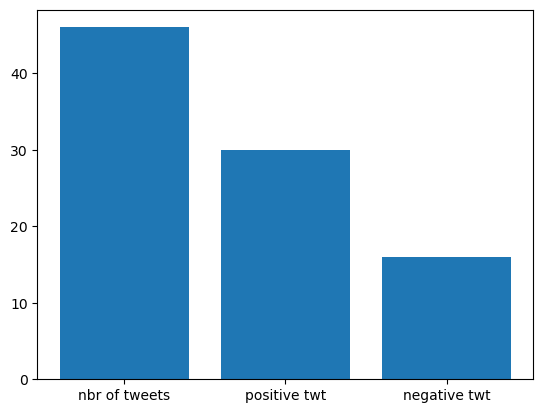

Insert data: [@elonmusk Sounds good. Focus most on 
SpaceX, then Tesla, then  your other companies. Because current Twitter software is probably like spaghetti now, you'll have to create new software to be sure 
Twitter works like you want., HSteigerwaldt ]
nombre of tweets : 47
nombre de positive tweets :  31
nombre de negative tweets  : 16
+-----------------------------------------------+----------+
|MeaningfulWords                                |prediction|
+-----------------------------------------------+----------+
|["[""@elonmusk, sounds, good., focus, \nspacex]|4.0       |
+-----------------------------------------------+----------+



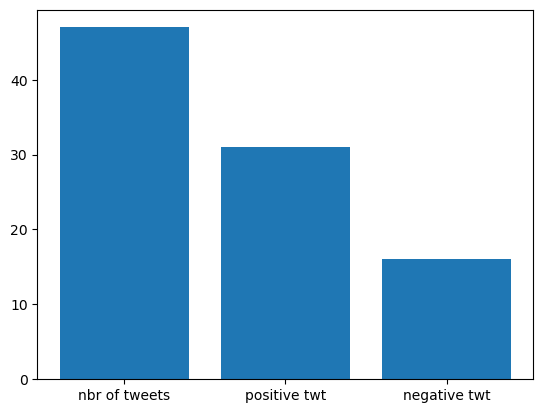

Insert data: [Tesla เปิดรับสมัครคนลงทุนเป็นจุด Supercharger ในไทย https://t.co/hQewnTgc2K, hybridknight ]
nombre of tweets : 48
nombre de positive tweets :  32
nombre de negative tweets  : 16
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""tesla, \u0e40\u0e1b\u0e34\u0e14\u0

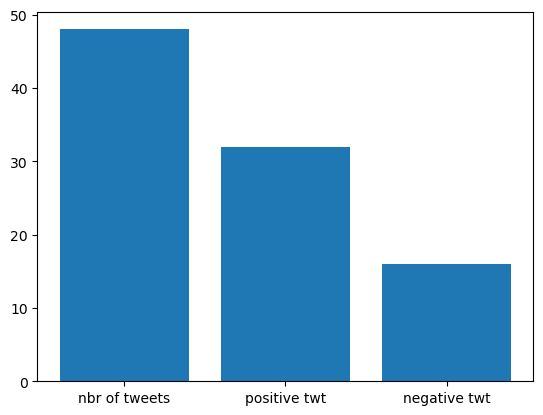

Insert data: [he's tanking twitter, how hard is it to see? barking at the investors, stripping confidence in the platform, ruining advertiser relationships.  it's only the spill over into tesla that is causing issues he'll need to care about.  he's killing the greatest platform for free speech https://t.co/SVMWEzeGFR, hactuary_ ]
nombre of tweets : 49
nombre de positive tweets :  32
nombre de negative tweets  : 17
+----------------------------+----------+
|MeaningfulWords             |prediction|
+----------------------------+----------+
|["[""he's, tanking, twitter]|0.0       |
+----------------------------+----------+



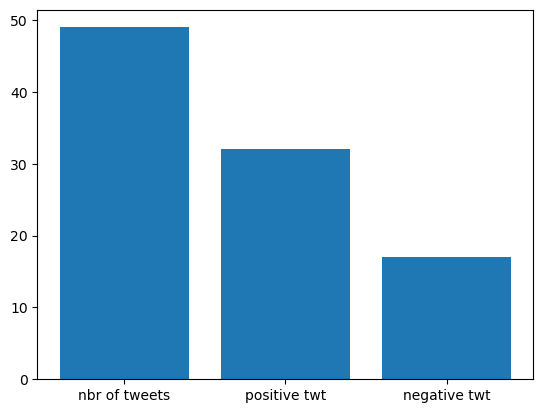

Insert data: [@edvinner @svtnyheter Tror det är föga överraskande för en elbilsägare. Nästan ingen i Sverige har de "dåliga" elbilarna ändå. Tesla Y dual = "oh nej det är vinter, nu har vi bara 48,7 mil innan vi behöver tanka elektronerna", golddubby ]
nombre of tweets : 50
nombre de positive tweets :  33
nombre de negative tweets  : 17
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                          |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------

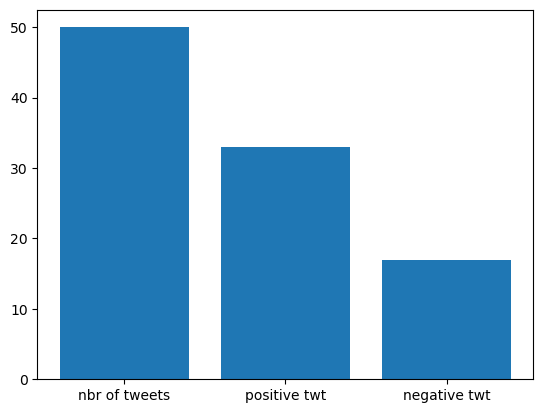

Insert data: [RT @BriannaWu: TESLA STOCK PRICE OFFICIALLY AT $139. Tesla's most famous investors calling for the board to fire Musk. "This stock price re…, MexSkeptic ]
nombre of tweets : 51
nombre de positive tweets :  33
nombre de negative tweets  : 18
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, tesla, stock, price, officially, $139., tesla's, famous, investors, calling, board, fire, musk., \""this, stock, price, re\u2026""]|0.0       |
+----------------------------------------------------------------------------

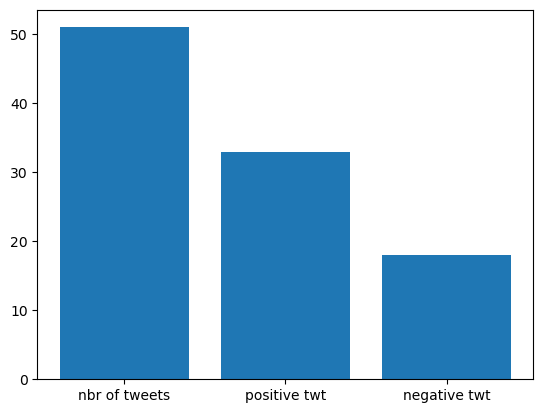

Insert data: [If you ever wonder how much Tesla folks are actually saving on gas.. this about 3 weeks worth https://t.co/WIIlUFn51T, AstronautRickyy ]
nombre of tweets : 52
nombre de positive tweets :  34
nombre de negative tweets  : 18
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""if, ever, wonder, much, tesla, folks, actually, saving, gas.., 3, weeks, worth, https://t.co/wiilufn51t""]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



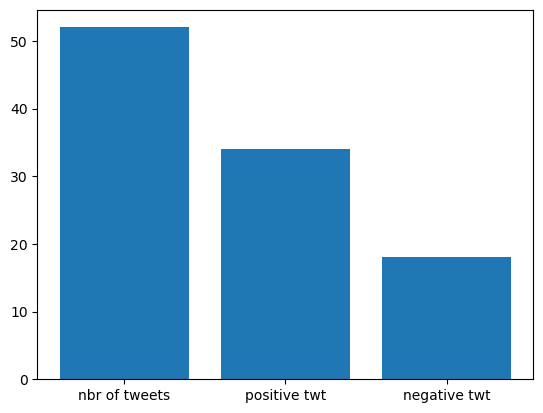

Insert data: [@Wind_is_Howling @freshjiva @elonmusk @heydave7 When @Tesla went public, that motivation had to change to defend $TSLA., inTheMtnWood ]
nombre of tweets : 53
nombre de positive tweets :  35
nombre de negative tweets  : 18
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@wind_is_howling, @freshjiva, @elonmusk, @heydave7, @tesla, went, public]|4.0       |
+------------------------------------------------------------------------------+----------+



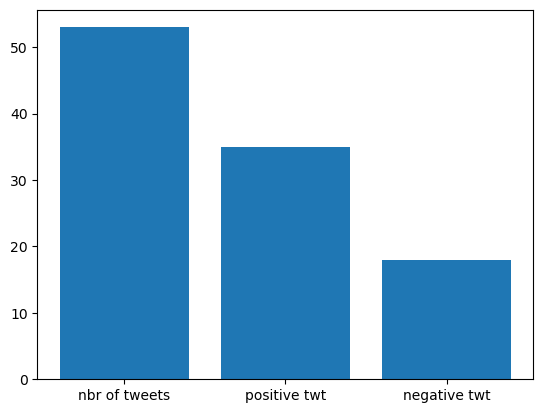

Insert data: [RT @pfbt: @NigheanEilidh @Tesla @elonmusk When the battery is working properly it’s brilliant. Horrified at @tesla’s appalling after sales…, jchimselfbigpo2 ]
nombre of tweets : 54
nombre de positive tweets :  35
nombre de negative tweets  : 19
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @pfbt:, @nigheaneilidh, @tesla, @elonmusk, battery, working, properly, it\u2019s, brilliant., horrified, @tesla\u2019s, appalling, sales\u2026""]|0.0       |
+--------------------------------------------------------------------

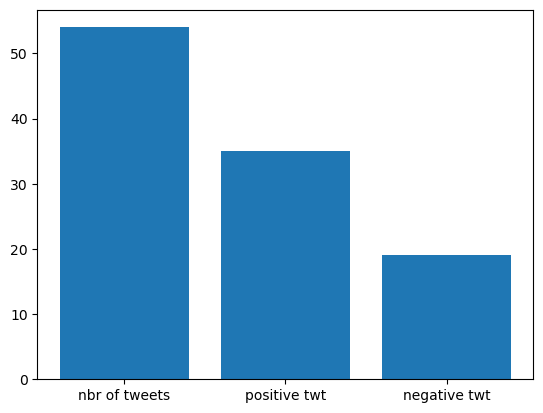

Insert data: [RT @DivesTech: Musk announces he will resign as CEO once successor found. Finally a good step in the right direction to end this painful ni…, maishamazingira ]
nombre of tweets : 55
nombre de positive tweets :  35
nombre de negative tweets  : 20
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @divestech:, musk, announces, resign, ceo, successor, found., finally, good, step, right, direction, end, painful, ni\u2026""]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------------+-------

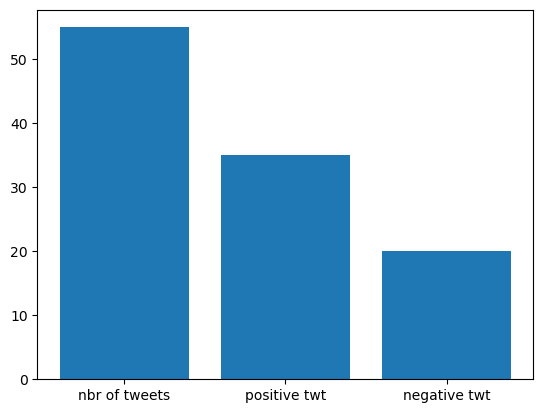

Insert data: [@elonmusk Sounds good. Focus most on 
SpaceX, then Tesla, then  your other companies. Because current Twitter software is probably like spaghetti now, you'll have to create new software to be sure 
Twitter works like you want., HSteigerwaldt ]
nombre of tweets : 56
nombre de positive tweets :  36
nombre de negative tweets  : 20
+-----------------------------------------------+----------+
|MeaningfulWords                                |prediction|
+-----------------------------------------------+----------+
|["[""@elonmusk, sounds, good., focus, \nspacex]|4.0       |
+-----------------------------------------------+----------+



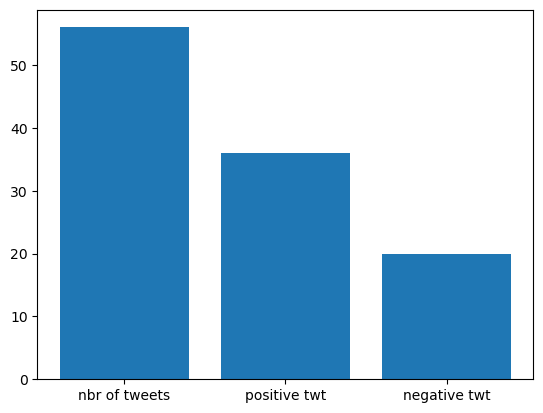

Insert data: [@TESLA_CREADOR Buenos días, Jose98461004 ]
nombre of tweets : 57
nombre de positive tweets :  37
nombre de negative tweets  : 20
+-----------------------------------------+----------+
|MeaningfulWords                          |prediction|
+-----------------------------------------+----------+
|["[""@tesla_creador, buenos, d\u00edas""]|4.0       |
+-----------------------------------------+----------+



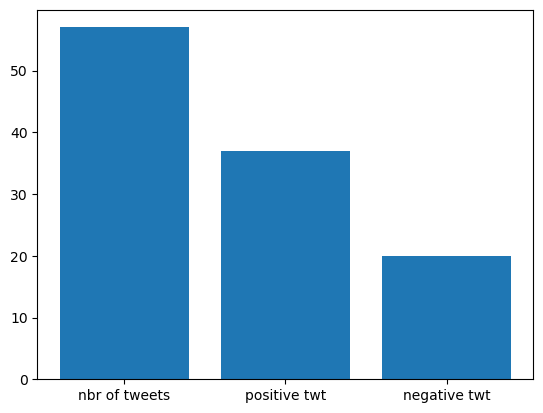

Insert data: [RT @rhonda_harbison: @HawleyMO https://t.co/B4IAnoEyyt
Red-Pilled Elon Musk Still Loves the Chinese Communist Party, Nikluk ]
nombre of tweets : 58
nombre de positive tweets :  37
nombre de negative tweets  : 21
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @rhonda_harbison:, @hawleymo, https://t.co/b4ianoeyyt\nred-pilled, elon, musk, still, loves, chinese, communist, party""]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------+----------+



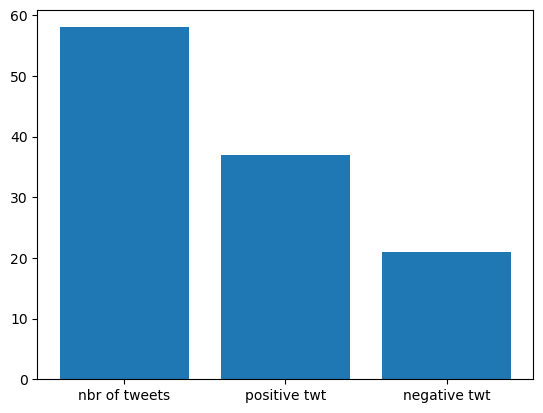

Insert data: [RT @mirandadevine: Tesla stock smashed 42% since @elonmusk bought Twitter, as Wall Street Dem allies tighten screws to prevent secrets bein…, Breezygirl1A ]
nombre of tweets : 59
nombre de positive tweets :  38
nombre de negative tweets  : 21
+----------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                         |prediction|
+----------------------------------------------------------------------------------------+----------+
|["[""rt, @mirandadevine:, tesla, stock, smashed, 42%, since, @elonmusk, bought, twitter]|4.0       |
+----------------------------------------------------------------------------------------+----------+



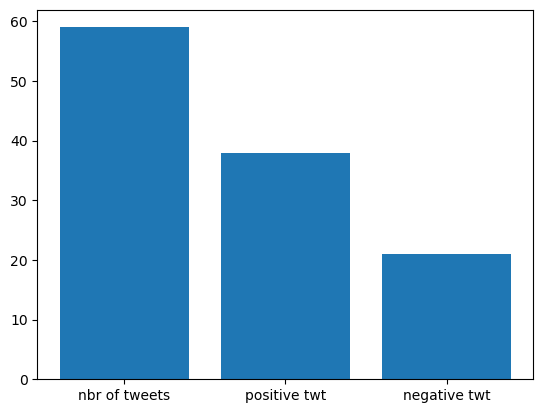

Insert data: [RT @duty2warn: Tesla stock might look like an opportunity to buy at the dip. It’s down 64% from its high of 402.
Except if it sold at the s…, SilverbergThor1 ]
nombre of tweets : 60
nombre de positive tweets :  38
nombre de negative tweets  : 22
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, tesla, stock, might, look, like, opportunity, buy, dip., it\u2019s, 64%, high, 402.\nexcept, sold, s\u2026""]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



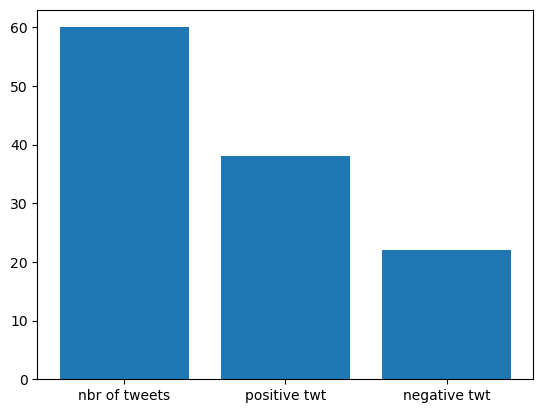

Insert data: [Tesla Model S Rear Left Door Shell https://t.co/dFBu18Udyh eBay https://t.co/WZ4N9PlQRI, car_trims ]
nombre of tweets : 61
nombre de positive tweets :  38
nombre de negative tweets  : 23
+-----------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|["[""tesla, model, rear, left, door, shell, https://t.co/dfbu18udyh, ebay, https://t.co/wz4n9plqri""]|0.0       |
+-----------------------------------------------------------------------------------------------------+----------+



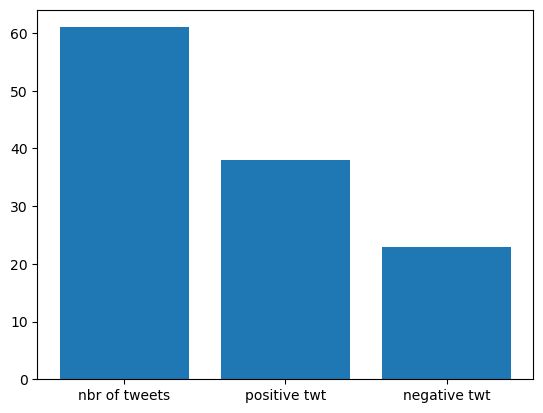

Insert data: [RT @markets: Cathie Wood ramps up purchases of Tesla shares in the fourth quarter even as concerns over CEO Elon Musk’s ability to manage b…, OdoniSamson ]
nombre of tweets : 62
nombre de positive tweets :  39
nombre de negative tweets  : 23
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @markets:, cathie, wood, ramps, purchases, tesla, shares, fourth, quarter, even, concerns, ceo, elon, musk\u2019s, ability, manage, b\u2026""]|4.0       |
+-----------------------------------------------------------------------------------

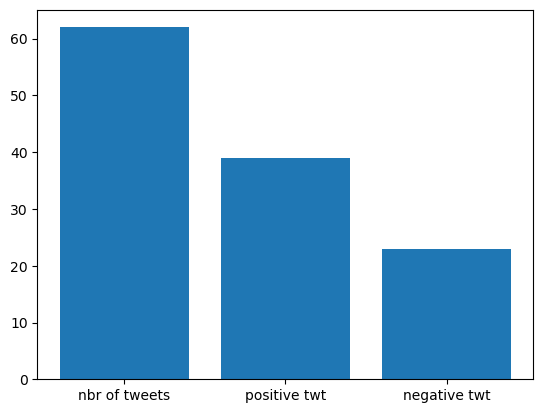

Insert data: [RT @SjvTesla: At the @Tesla mega pack factory in Lathrop and things are getting done! Tesla fundamentals are high and I can't wait to see t…, Johnkim26391993 ]
nombre of tweets : 63
nombre de positive tweets :  40
nombre de negative tweets  : 23
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sjvtesla:, @tesla, mega, pack, factory, lathrop, things, getting, done!, tesla, fundamentals, high, wait, see, t\u2026""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



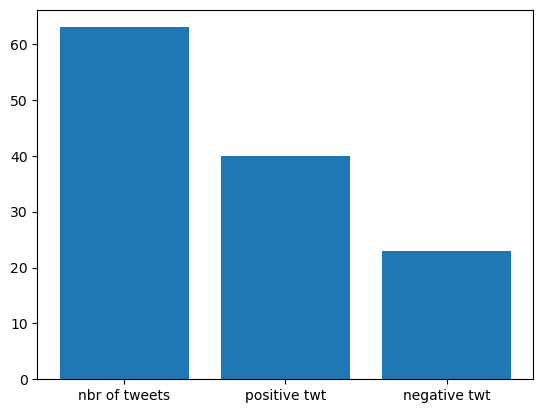

Insert data: [RT @PerNordnet: Tesla fortsætter i bakgear. For investorerne handler det kortsigtet formentlig slet og ret om lysten til at eje aktien #akt…, jesperdahl ]
nombre of tweets : 64
nombre de positive tweets :  41
nombre de negative tweets  : 23
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                        |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @pernordnet:, tesla, forts\u00e6tter, bakgear., investorerne, handler, det, kortsigtet, formentlig, slet, og, ret, om, lysten, til, eje, aktien, #akt\u2026""]|4.0       |
+--------------------

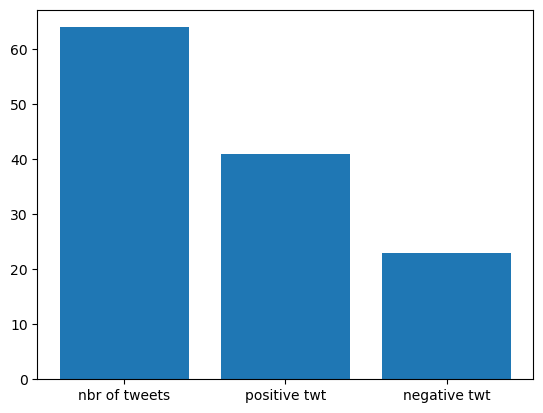

Insert data: [RT @theliamnissan: For your Tesla stock have you tried turning it off and then on again?, sunkist111 ]
nombre of tweets : 65
nombre de positive tweets :  42
nombre de negative tweets  : 23
+-----------------------------------------------------------------+----------+
|MeaningfulWords                                                  |prediction|
+-----------------------------------------------------------------+----------+
|["[""rt, @theliamnissan:, tesla, stock, tried, turning, again?""]|4.0       |
+-----------------------------------------------------------------+----------+



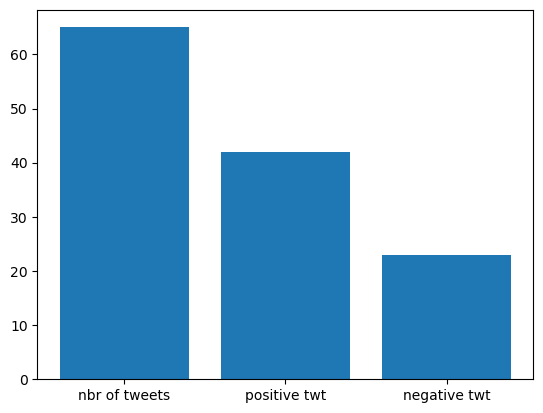

Insert data: [Tesla is not a 'one trick pony', wealthyfrog ]
nombre of tweets : 66
nombre de positive tweets :  42
nombre de negative tweets  : 24
+---------------------------------+----------+
|MeaningfulWords                  |prediction|
+---------------------------------+----------+
|["[""tesla, 'one, trick, pony'""]|0.0       |
+---------------------------------+----------+



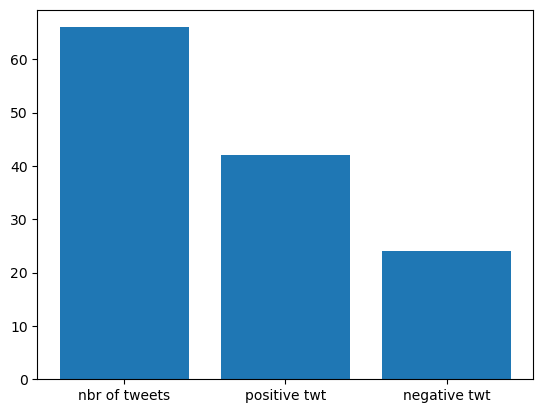

Insert data: [@FthePump1 @BrandonTSLA @Tesla @TSportline Agreed 👍, NNhicks757 ]
nombre of tweets : 67
nombre de positive tweets :  43
nombre de negative tweets  : 24
+---------------------------------------------------------------------------+----------+
|MeaningfulWords                                                            |prediction|
+---------------------------------------------------------------------------+----------+
|["[""@fthepump1, @brandontsla, @tesla, @tsportline, agreed, \ud83d\udc4d""]|4.0       |
+---------------------------------------------------------------------------+----------+



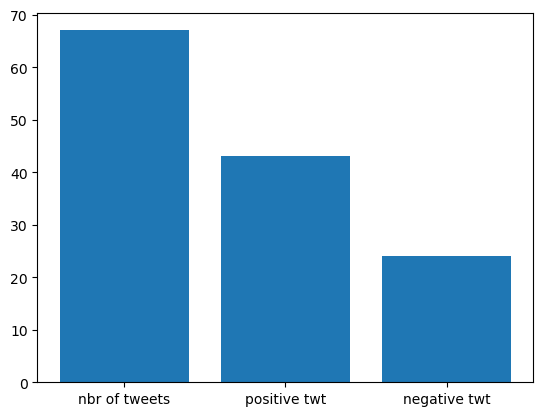

Insert data: [RT @BriannaWu: YIKES. Down to $142. 

Musk used his Tesla stock as collateral for the leveraged buyout, the fourth largest in history. At w…, ashyuille ]
nombre of tweets : 68
nombre de positive tweets :  43
nombre de negative tweets  : 25
+-------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                  |prediction|
+-------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, yikes., $142., \n\nmusk, used, tesla, stock, collateral, leveraged, buyout]|0.0       |
+-------------------------------------------------------------------------------------------------+----------+



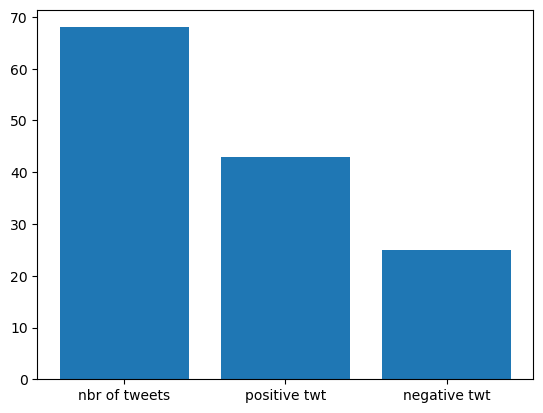

Insert data: [RT @davetroy: And yes, I know: the board and institutional investors should keep this from happening because of fiduciary duty. But they're…, LTCBitchBaby ]
nombre of tweets : 69
nombre de positive tweets :  44
nombre de negative tweets  : 25
+-------------------------+----------+
|MeaningfulWords          |prediction|
+-------------------------+----------+
|["[""rt, @davetroy:, yes]|4.0       |
+-------------------------+----------+



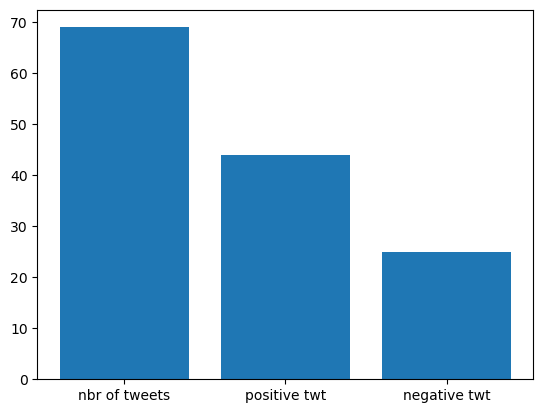

Insert data: [@CollinRugg People are voting every day selling their Tesla stock, down over 60% since announcing the Twitter purchase. It was 400 now 137. This is the vote that really counts., bfried7 ]
nombre of tweets : 70
nombre de positive tweets :  45
nombre de negative tweets  : 25
+--------------------------------------------------------------------+----------+
|MeaningfulWords                                                     |prediction|
+--------------------------------------------------------------------+----------+
|["[""@collinrugg, people, voting, every, day, selling, tesla, stock]|4.0       |
+--------------------------------------------------------------------+----------+



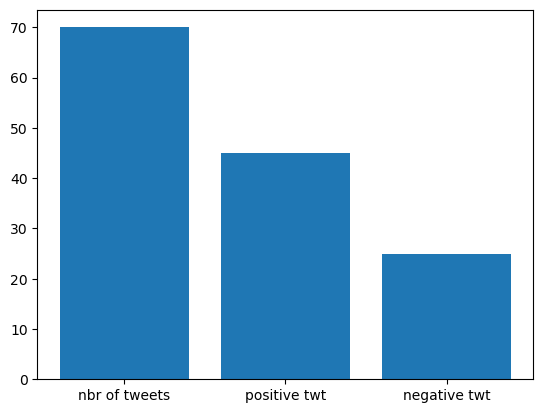

Insert data: [RT @business: Cathie Wood ramps up purchases of Tesla shares in the fourth quarter even as concerns over CEO Elon Musk’s ability to manage…, Chandra32602492 ]
nombre of tweets : 71
nombre de positive tweets :  46
nombre de negative tweets  : 25
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @business:, cathie, wood, ramps, purchases, tesla, shares, fourth, quarter, even, concerns, ceo, elon, musk\u2019s, ability, manage\u2026""]|4.0       |
+----------------------------------------------------------------------------------------

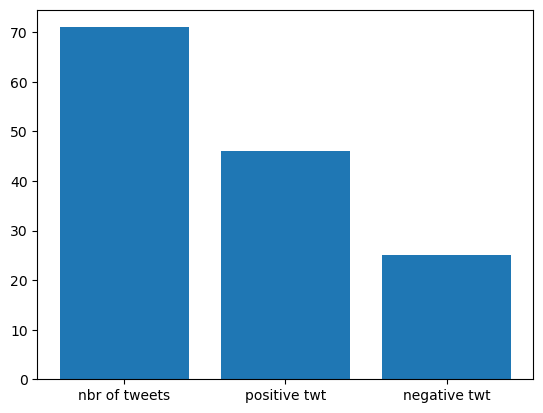

Insert data: [RT @VaushV: Just a few more days and Elon will be banning people for doxxing Tesla’s exact stock value in real time, tCARD_16 ]
nombre of tweets : 72
nombre de positive tweets :  47
nombre de negative tweets  : 25
+---------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @vaushv:, days, elon, banning, people, doxxing, tesla\u2019s, exact, stock, value, real, time""]|4.0       |
+---------------------------------------------------------------------------------------------------------+----------+



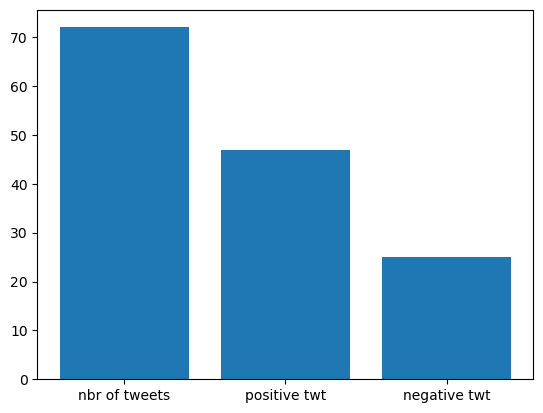

Insert data: [@BrandonTSLA @Tesla @TSportline Contrast is more vivid in this case.., NNhicks757 ]
nombre of tweets : 73
nombre de positive tweets :  47
nombre de negative tweets  : 26
+------------------------------------------------------------------+----------+
|MeaningfulWords                                                   |prediction|
+------------------------------------------------------------------+----------+
|["[""@brandontsla, @tesla, @tsportline, contrast, vivid, case..""]|0.0       |
+------------------------------------------------------------------+----------+



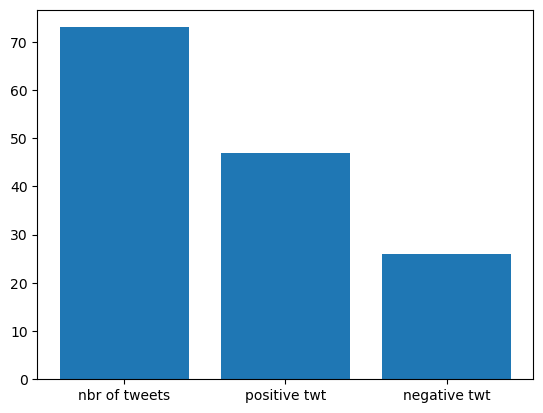

Insert data: [RT @t0_god: 고래들은 정말 시장을 지배할까?

주황선 : 스마트머니 지갑의 스테이블코인 / 코인 보유 비율
검은선 : 토탈캡2(비트 제외 코인 시총)

* 스마트머니 : 가격 변동에 유의미한 행동을 보였거나 상승, 하락을 미리 알고 있는듯한…, TESLA_is_FUTURE ]
nombre of tweets : 74
nombre de positive tweets :  48
nombre de negative tweets  : 26
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                         

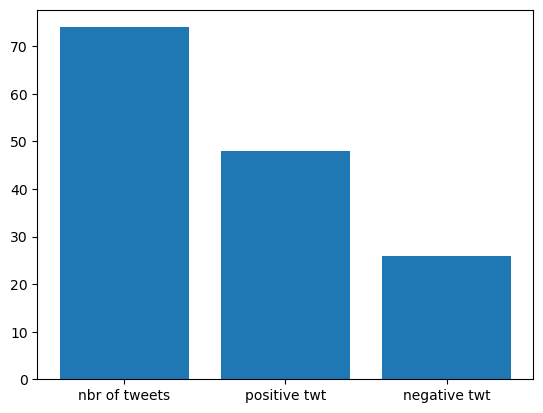

Insert data: [@laurenshuu @WhiteHouse I am driving a Tesla without supercharging for nine month now. I just plug in at home and work with the regular plug and I am totally fine on charging., FVanderborcht ]
nombre of tweets : 75
nombre de positive tweets :  49
nombre de negative tweets  : 26
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@laurenshuu, @whitehouse, driving, tesla, without, supercharging, nine, month, now., plug, home, work, regular, plug, totally, fine, charging.""]|4.0       |
+--------------------------------------------------

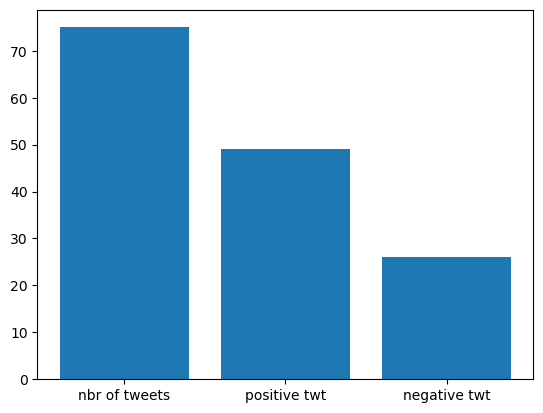

Insert data: [RT @gaps_j: Just imagining him putting the baby in a car seat and setting the Tesla to autopilot to ship it to Grimes like a package with n…, ojuchiquillo ]
nombre of tweets : 76
nombre de positive tweets :  50
nombre de negative tweets  : 26
+--------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                           |prediction|
+--------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gaps_j:, imagining, putting, baby, car, seat, setting, tesla, autopilot, ship, grimes, like, package, n\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------+----------+



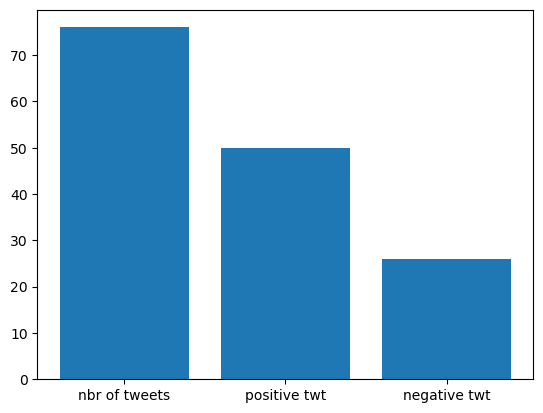

Insert data: [@TESLA_CREADOR Buenas Tesla 😘, asynjurfree2 ]
nombre of tweets : 77
nombre de positive tweets :  51
nombre de negative tweets  : 26
+---------------------------------------------------+----------+
|MeaningfulWords                                    |prediction|
+---------------------------------------------------+----------+
|["[""@tesla_creador, buenas, tesla, \ud83d\ude18""]|4.0       |
+---------------------------------------------------+----------+



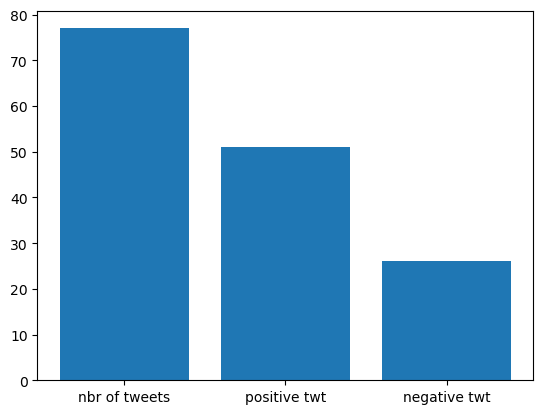

Insert data: [RT @AshrafAriff: Habislah aku. Nanti Elon Musk langgar aku dengan Tesla. 😭☀️🥲 https://t.co/8UpflP1zuy, bumilangit ]
nombre of tweets : 78
nombre de positive tweets :  51
nombre de negative tweets  : 27
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @ashrafariff:, habislah, aku., nanti, elon, musk, langgar, aku, dengan, tesla., \ud83d\ude2d\u2600\ufe0f\ud83e\udd72, https://t.co/8upflp1zuy""]|0.0       |
+-------------------------------------------------------------------------------------------------------------------

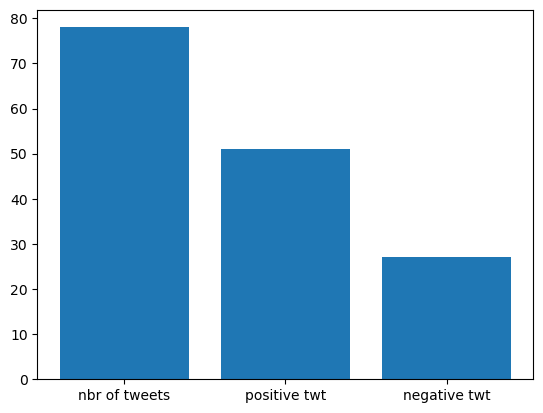

Insert data: [このキャシー・ウッド氏、基本的に相場に強気なことが多いが、とにかく目立つことをする。イーロン君には朗報。https://t.co/0F4hKIbiib @YahooFinance, 7rigahama134 ]
nombre of tweets : 79
nombre de positive tweets :  52
nombre de negative tweets  : 27
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------

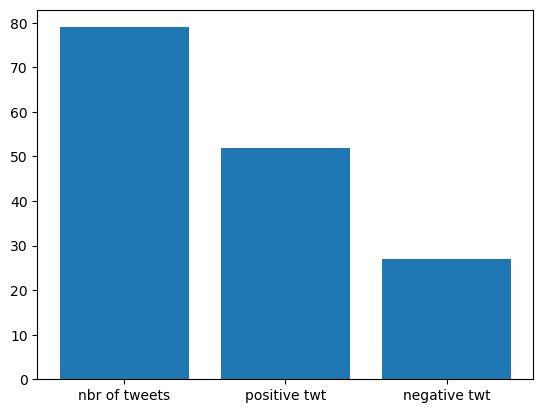

Insert data: [RT @BriannaWu: TESLA STOCK PRICE OFFICIALLY AT $139. Tesla's most famous investors calling for the board to fire Musk. "This stock price re…, ImNotPeko ]
nombre of tweets : 80
nombre de positive tweets :  52
nombre de negative tweets  : 28
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, tesla, stock, price, officially, $139., tesla's, famous, investors, calling, board, fire, musk., \""this, stock, price, re\u2026""]|0.0       |
+-----------------------------------------------------------------------------

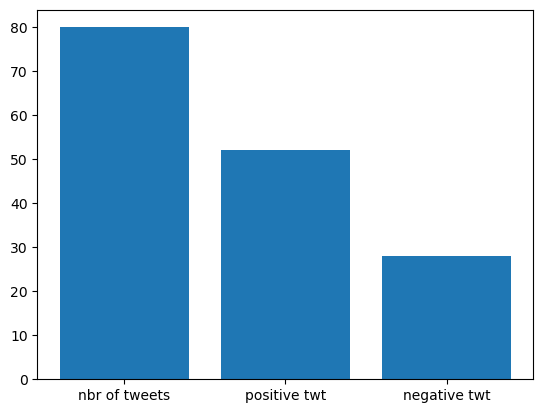

Insert data: [RT @saxena_puru: @heydave7 @elonmusk Tesla has in fact declined less than most growth stocks 

Down 66% vs. 80-90% declines for most., ESGESG1001 ]
nombre of tweets : 81
nombre de positive tweets :  53
nombre de negative tweets  : 28
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @saxena_puru:, @heydave7, @elonmusk, tesla, fact, declined, less, growth, stocks, \n\ndown, 66%, vs., 80-90%, declines, most.""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+---------

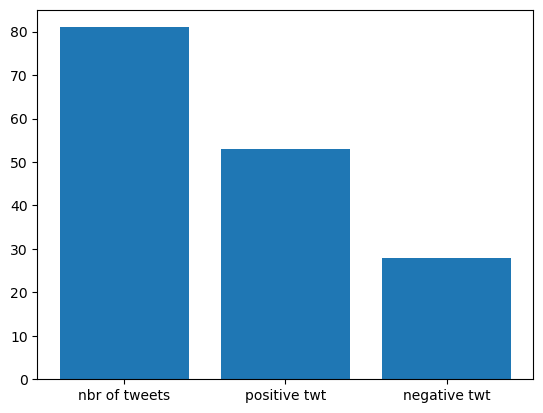

Insert data: [RT @Tesla: Happy #4thofJuly USA! 

Safe travels to everyone out on the road 🔌🚗 https://t.co/o1yHfDa76u, purevdo27046751 ]
nombre of tweets : 82
nombre de positive tweets :  54
nombre de negative tweets  : 28
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, happy, #4thofjuly, usa!, \n\nsafe, travels, everyone, road, \ud83d\udd0c\ud83d\ude97, https://t.co/o1yhfda76u""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------+----------+



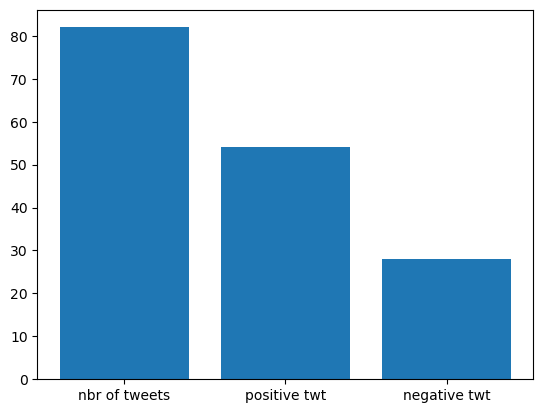

Insert data: [RT @muglikar_: Toyota halts expansion in India, Tesla says taxes are high on cars, today Maruti Chairman says 50% tax on cars will kill the…, amrendra_kk ]
nombre of tweets : 83
nombre de positive tweets :  55
nombre de negative tweets  : 28
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""rt, @muglikar_:, toyota, halts, expansion, india]|4.0       |
+------------------------------------------------------+----------+



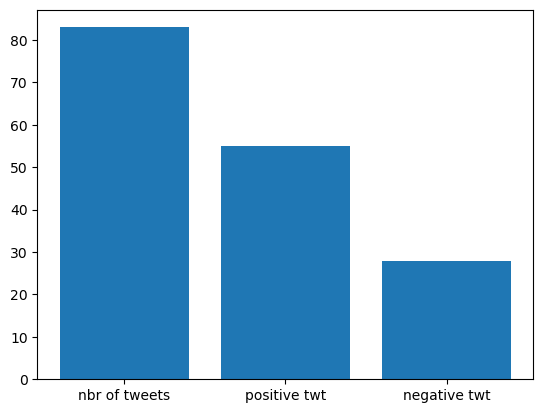

Insert data: [RT @EpsilonTheory: It's so weird that the macroeconomic environment has impacted Tesla (-41%) and not Ford (+1%) or GM (+8%) over the past…, WaspCarcass ]
nombre of tweets : 84
nombre de positive tweets :  56
nombre de negative tweets  : 28
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @epsilontheory:, weird, macroeconomic, environment, impacted, tesla, (-41%), ford, (+1%), gm, (+8%), past\u2026""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------+----------+



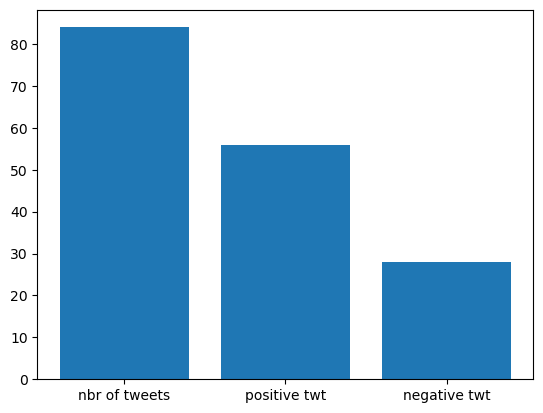

Insert data: [RT @notchalinoguy: ohh. Tesla's fucked isn't it? https://t.co/mLvtmYRbE9, Theguardianofdc ]
nombre of tweets : 85
nombre de positive tweets :  56
nombre de negative tweets  : 29
+--------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                 |prediction|
+--------------------------------------------------------------------------------+----------+
|["[""rt, @notchalinoguy:, ohh., tesla's, fucked, it?, https://t.co/mlvtmyrbe9""]|0.0       |
+--------------------------------------------------------------------------------+----------+



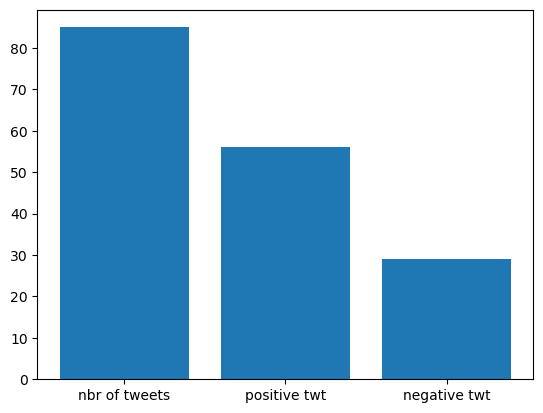

Insert data: [RT @Tesla: If you want to beat the record and win useless internet points, all you have to do is peer-pressure all your elderly relatives i…, purevdo27046751 ]
nombre of tweets : 86
nombre de positive tweets :  56
nombre de negative tweets  : 30
+---------------------------------------------------------------------+----------+
|MeaningfulWords                                                      |prediction|
+---------------------------------------------------------------------+----------+
|["[""rt, @tesla:, want, beat, record, win, useless, internet, points]|0.0       |
+---------------------------------------------------------------------+----------+



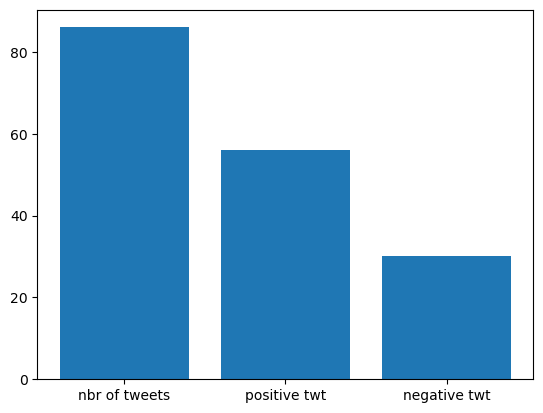

Insert data: [RT @firstadopter: Tesla has lost $529 billion in stock market value over the last three months. Incredible https://t.co/ZKLXAMOuKZ, fatefahrenheit ]
nombre of tweets : 87
nombre de positive tweets :  56
nombre de negative tweets  : 31
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @firstadopter:, tesla, lost, $529, billion, stock, market, value, last, three, months., incredible, https://t.co/zklxamoukz""]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------------+----------+



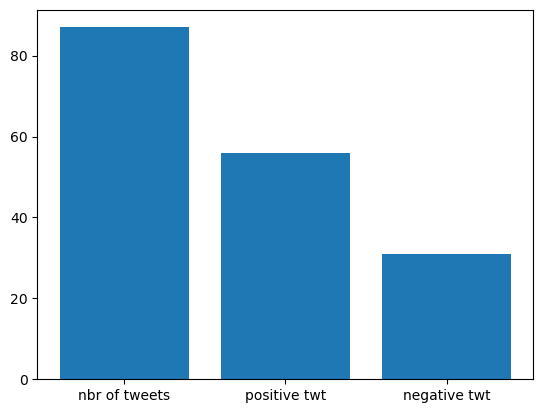

Insert data: [RT @Tesla: 90-year-old Henk from the Netherlands proves it's never too late to embrace new technology AND buy your dream car. https://t.co/…, purevdo27046751 ]
nombre of tweets : 88
nombre de positive tweets :  56
nombre de negative tweets  : 32
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, 90-year-old, henk, netherlands, proves, never, late, embrace, new, technology, buy, dream, car., https://t.co/\u2026""]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------------

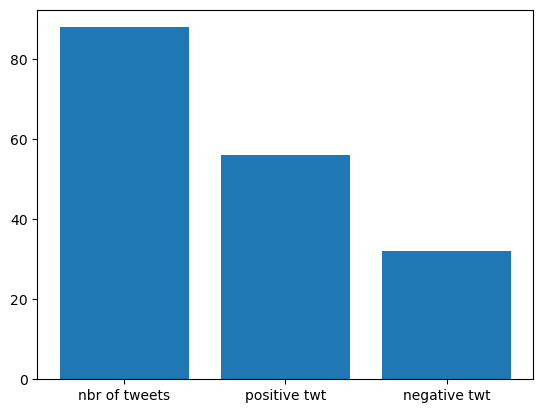

Insert data: [RT @TeslaAndDoge: After all that has happened, if I honestly ask myself, “Was #Tesla overvalued at 1 Trillion valuation?”. I feel the answe…, aidanyingw ]
nombre of tweets : 89
nombre de positive tweets :  56
nombre de negative tweets  : 33
+----------------------------------+----------+
|MeaningfulWords                   |prediction|
+----------------------------------+----------+
|["[""rt, @teslaanddoge:, happened]|0.0       |
+----------------------------------+----------+



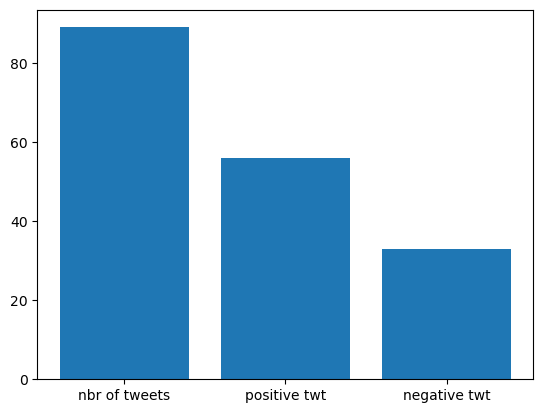

Insert data: [RT @McJuggerNuggets: Made it to California!!! 🔥🔥 Few more hours left. 🙌🏼 

Definitely coolest @Tesla charging station so far. 😱 https://t.c…, purevdo27046751 ]
nombre of tweets : 90
nombre de positive tweets :  56
nombre de negative tweets  : 34
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @mcjuggernuggets:, made, california!!!, \ud83d\udd25\ud83d\udd25, h

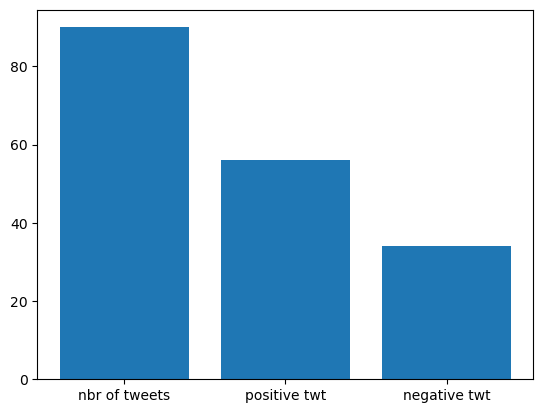

Insert data: [RT @gurgavin: SOMEONE BIG IS GETTING MARGINED CALLED ON TESLA RIGHT NOW $TSLA, jonnohowe ]
nombre of tweets : 91
nombre de positive tweets :  56
nombre de negative tweets  : 35
+------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                     |prediction|
+------------------------------------------------------------------------------------+----------+
|["[""rt, @gurgavin:, someone, big, getting, margined, called, tesla, right, $tsla""]|0.0       |
+------------------------------------------------------------------------------------+----------+



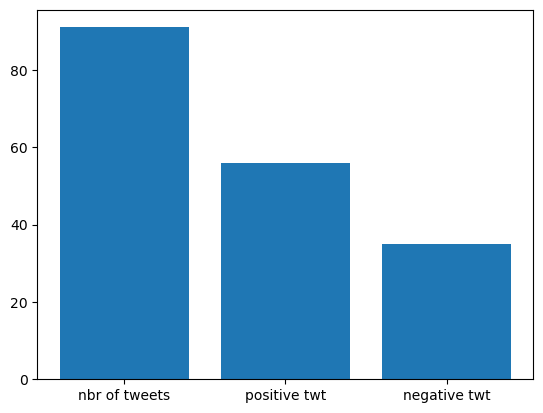

Insert data: [RT @Tesla: Every Tesla has an electronic powertrain that provides instant torque control—enabling more control &amp; stability in winter condit…, VirtusT ]
nombre of tweets : 92
nombre de positive tweets :  57
nombre de negative tweets  : 35
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                             |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, every, tesla, electronic, powertrain, provides, instant, torque, control\u2014enabling, control, &amp;, stability, winter, condit\u2026""]|4.0       |
+---------------------------------------------------------------

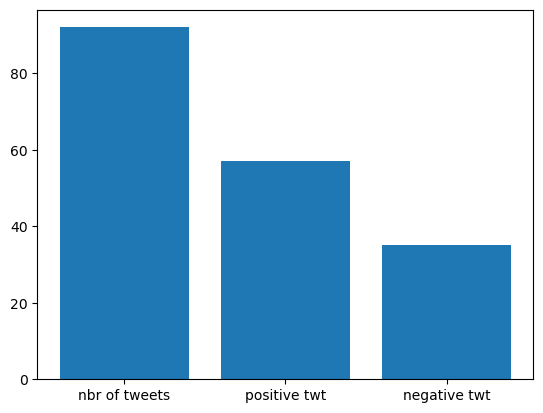

Insert data: [Elon Musk tries to explain why Tesla shares are tanking https://t.co/TYbSCxb69R, FrancCrist ]
nombre of tweets : 93
nombre de positive tweets :  58
nombre de negative tweets  : 35
+-----------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                    |prediction|
+-----------------------------------------------------------------------------------+----------+
|["[""elon, musk, tries, explain, tesla, shares, tanking, https://t.co/tybscxb69r""]|4.0       |
+-----------------------------------------------------------------------------------+----------+



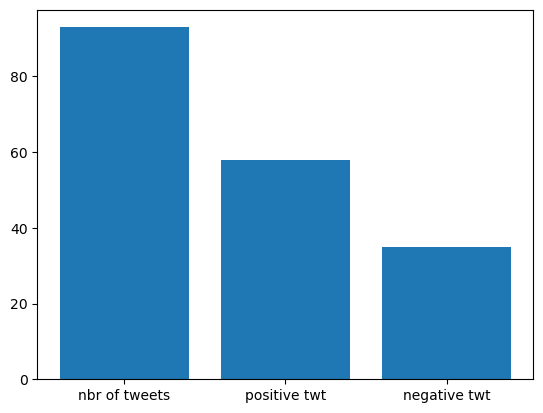

Insert data: [@RobsMeinung @Mingiam10 @sat1 Falls es sich in einem Jahr wieder komplett gedreht haben sollte, postest du das dann auch? Mir ist die Tesla-Aktie egal, aber es ist gerade auch einfach sich darüber lustig zu machen und viele Kleinanleger haben Hoffnung, dass es sich wieder dreht. Mehr Einordnung würde helfen., MarcoPast_Dir ]
nombre of tweets : 94
nombre de positive tweets :  59
nombre de negative tweets  : 35
+-------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                              |prediction|
+-------------------------------------------------------------------------------------------------------------+----------+
|["[""@robsmeinung, @mingiam10, @sat1, falls, es, sich, einem, jahr, wieder, komplett, gedreht, haben, sollte]|4.0       |
+--------------------------------------------------------------------------------

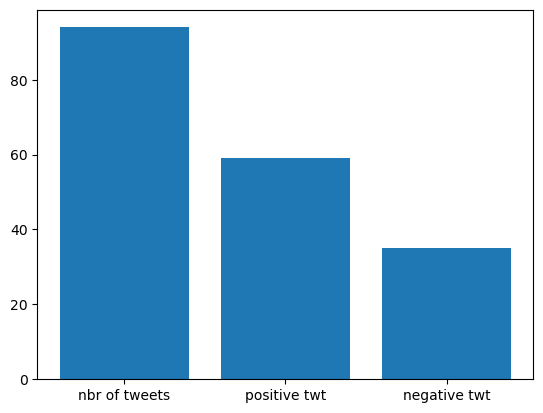

Insert data: [RT @steinkobbe: Elon is now publicly arguing with Tesla stockholders who are begging him to stop shitposting and get to work https://t.co/1…, clogged_upWheel ]
nombre of tweets : 95
nombre de positive tweets :  59
nombre de negative tweets  : 36
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @steinkobbe:, elon, publicly, arguing, tesla, stockholders, begging, stop, shitposting, get, work, https://t.co/1\u2026""]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



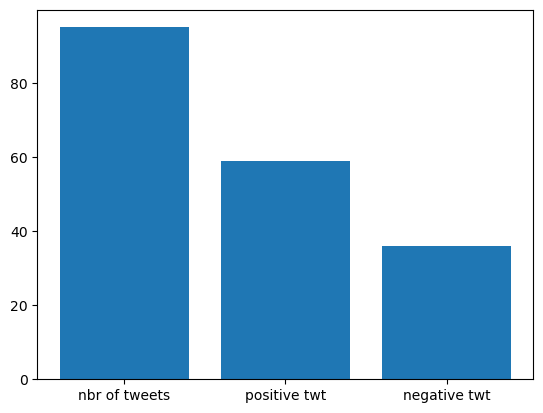

Insert data: [# Moscows suspension of Nord Stream 1 knocks equities markets as energy crisis worsens 🍳🥚🍋🍌🍉🥦🍎🍍🍑🍇🍓🍅🥕🌽🍳🥚🍲🍐🍳🥚🍤🥕🌽🍌🍉🍒🍈🥑🍇🍓Shares of Tesla’s battery maker plunge after net profit slides, MargueriteSavo3 ]
nombre of tweets : 96
nombre de positive tweets :  60
nombre de negative tweets  : 36
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                 

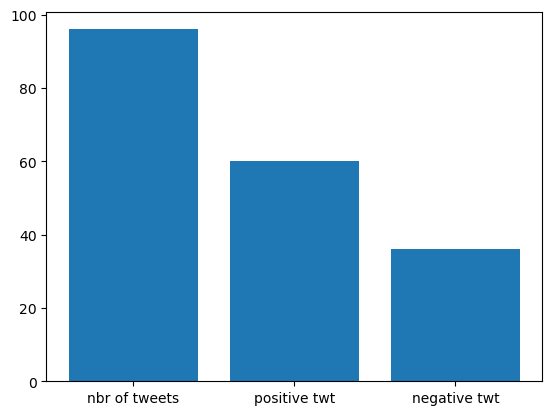

Insert data: [RT @Tesla: if dogs could talk - and we cannot stress this enough - they would tell you to drive a Tesla, purevdo27046751 ]
nombre of tweets : 97
nombre de positive tweets :  60
nombre de negative tweets  : 37
+-------------------------------------------------------------------------+----------+
|MeaningfulWords                                                          |prediction|
+-------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, dogs, talk, -, stress, enough, -, tell, drive, tesla""]|0.0       |
+-------------------------------------------------------------------------+----------+



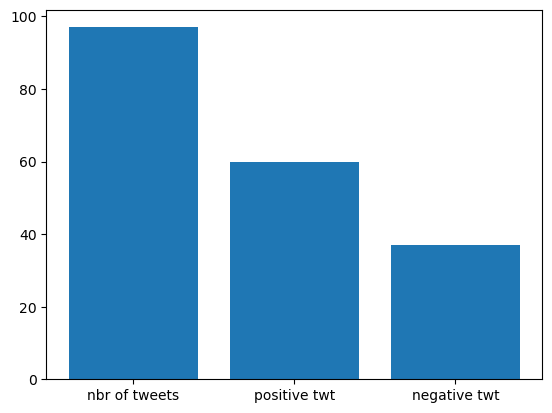

Insert data: [Electrek | Tesla, Türkiye’ye açılıyor.

Tesla, Türkiye'de işe alımlara başlıyor. Türkiye'deki ilk iş ilanları, ilk servis merkezinin de yer alacağı öngörülen Beşiktaş'taki merkezi için oldu.
1/3
https://t.co/PRGEl9E9HV, hermes_z ]
nombre of tweets : 98
nombre de positive tweets :  60
nombre de negative tweets  : 38
+------------------------+----------+
|MeaningfulWords         |prediction|
+------------------------+----------+
|["[""electrek, |, tesla]|0.0       |
+------------------------+----------+



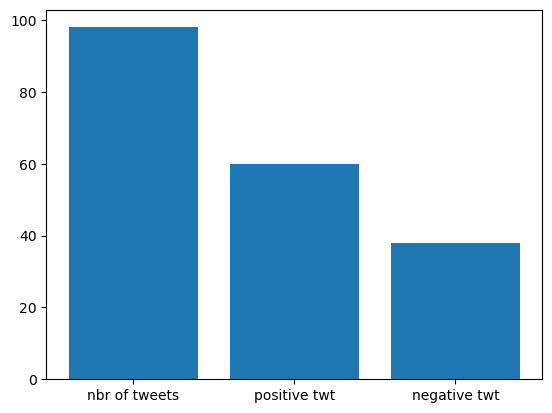

Insert data: [@elonmusk @barrel_bourbon Bots are incoming, you say? What's up with your Tesla shares? They're going down and you're minding the bots on Twitter? Is there something I'm missing here, baby boy?
https://t.co/WSXPCrUkK4
https://t.co/z5f1JkYqdq, DalkinLeo ]
nombre of tweets : 99
nombre de positive tweets :  61
nombre de negative tweets  : 38
+------------------------------------------------+----------+
|MeaningfulWords                                 |prediction|
+------------------------------------------------+----------+
|["[""@elonmusk, @barrel_bourbon, bots, incoming]|4.0       |
+------------------------------------------------+----------+



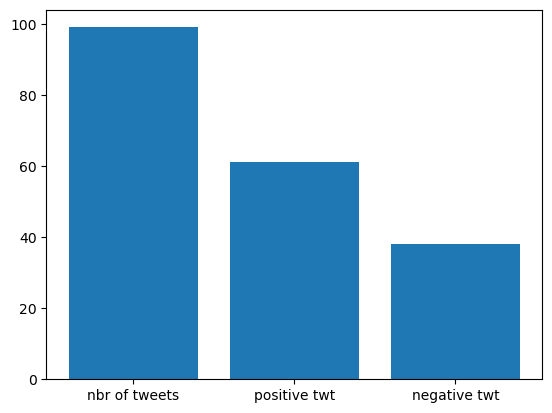

Insert data: [hey grimes @grimezsz,  your lies hurt working people. apologize.  https://t.co/IYWa7jxNkv  https://t.co/uSAm9qz8T0                                     https://t.co/wyZXY1dHU2, grimesliedbot ]
nombre of tweets : 100
nombre de positive tweets :  62
nombre de negative tweets  : 38
+----------------------------+----------+
|MeaningfulWords             |prediction|
+----------------------------+----------+
|["[""hey, grimes, @grimezsz]|4.0       |
+----------------------------+----------+



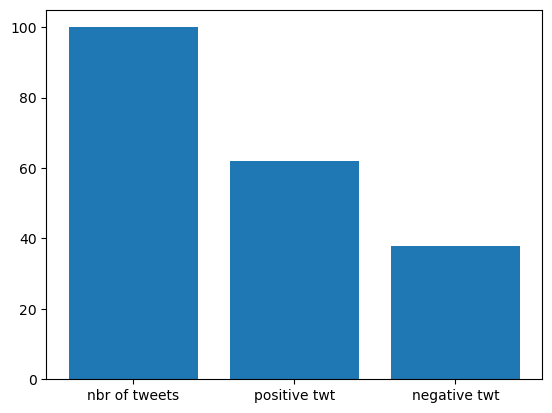

Insert data: [Teslaの大株主たちが「マスク氏よ、Twitterから手を引け！さもないと、オレラがTeslaの株、どんどん売っ払うぞ！」とか、言ってくれないかな？　#ElonIsDestroyingTwitter https://t.co/yu7zZNvGzD, user1566233 ]
nombre of tweets : 101
nombre de positive tweets :  62
nombre de negative tweets  : 39
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                                                             

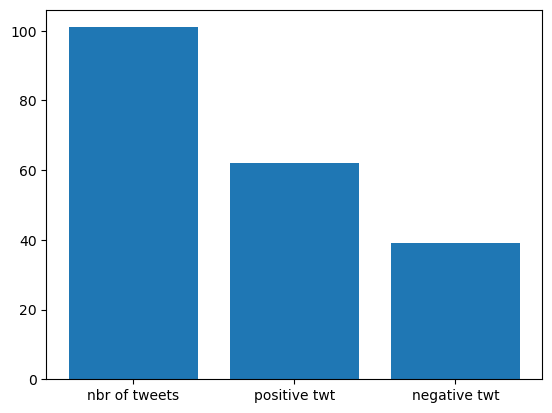

Insert data: [RT @spurtmagoo: elon running his tesla in his garage for a very long time before realizing he's going to have to try another method, annariviereg ]
nombre of tweets : 102
nombre de positive tweets :  63
nombre de negative tweets  : 39
+----------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @spurtmagoo:, elon, running, tesla, garage, long, time, realizing, going, try, another, method""]|4.0       |
+----------------------------------------------------------------------------------------------------------+----------+



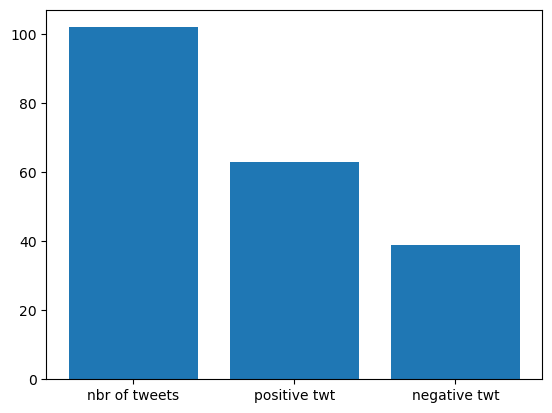

Insert data: [RT @GeorgeTakei: Next up: No tweets about any car that is not a Tesla., joeMCCluskey1 ]
nombre of tweets : 103
nombre de positive tweets :  63
nombre de negative tweets  : 40
+---------------------------------------------------------+----------+
|MeaningfulWords                                          |prediction|
+---------------------------------------------------------+----------+
|["[""rt, @georgetakei:, next, up:, tweets, car, tesla.""]|0.0       |
+---------------------------------------------------------+----------+



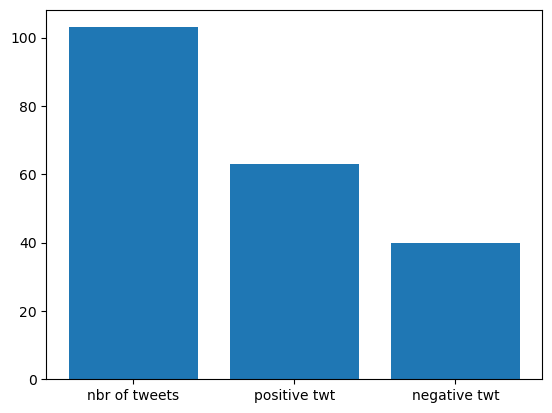

Insert data: [RT @Tesla: What did you tell your significant other to get them to let you buy a Tesla? 

(Asking for a friend), purevdo27046751 ]
nombre of tweets : 104
nombre de positive tweets :  64
nombre de negative tweets  : 40
+-----------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                    |prediction|
+-----------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, tell, significant, get, let, buy, tesla?, \n\n(asking, friend)""]|4.0       |
+-----------------------------------------------------------------------------------+----------+



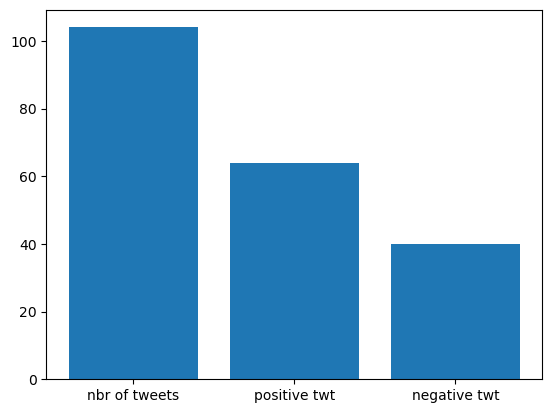

Insert data: [RT @KennethNrgaard: @TheYellowPete Nej da, det ligner ham da slet ikke, at reagere sådan... https://t.co/HspIpwHVRc, BruunGarcia ]
nombre of tweets : 105
nombre de positive tweets :  64
nombre de negative tweets  : 41
+---------------------------------------------------+----------+
|MeaningfulWords                                    |prediction|
+---------------------------------------------------+----------+
|["[""rt, @kennethnrgaard:, @theyellowpete, nej, da]|0.0       |
+---------------------------------------------------+----------+



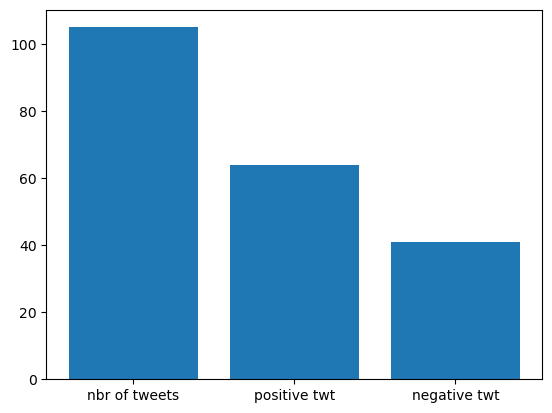

Insert data: [@DavidLin69 @j_grieshaber @stevenmarkryan @heydave7 @elonmusk Adds to the Tesla brand. Authenticity builds a brand better than a people pleaser., plebdothodl ]
nombre of tweets : 106
nombre de positive tweets :  65
nombre de negative tweets  : 41
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@davidlin69, @j_grieshaber, @stevenmarkryan, @heydave7, @elonmusk, adds, tesla, brand., authenticity, builds, brand, better, people, pleaser.""]|4.0       |
+--------------------------------------------------------------------------------------

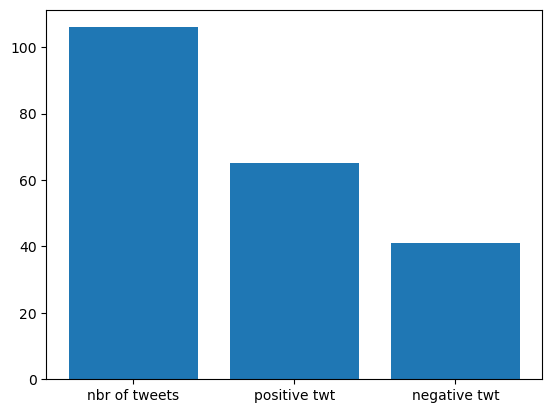

Insert data: [His Tesla Model S https://t.co/xG58CaxxFs, FalanxZealot ]
nombre of tweets : 107
nombre de positive tweets :  66
nombre de negative tweets  : 41
+--------------------------------------------------+----------+
|MeaningfulWords                                   |prediction|
+--------------------------------------------------+----------+
|["[""his, tesla, model, https://t.co/xg58caxxfs""]|4.0       |
+--------------------------------------------------+----------+



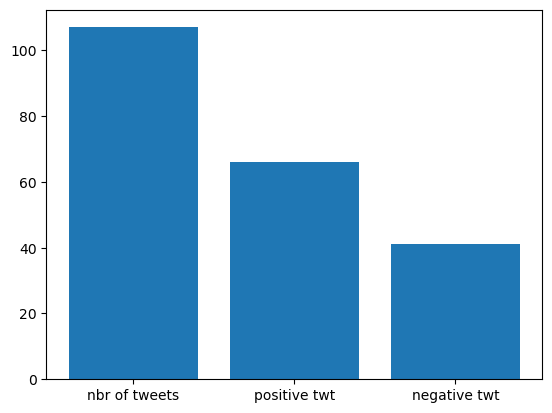

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, bobbo67267467 ]
nombre of tweets : 108
nombre de positive tweets :  67
nombre de negative tweets  : 41
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+---

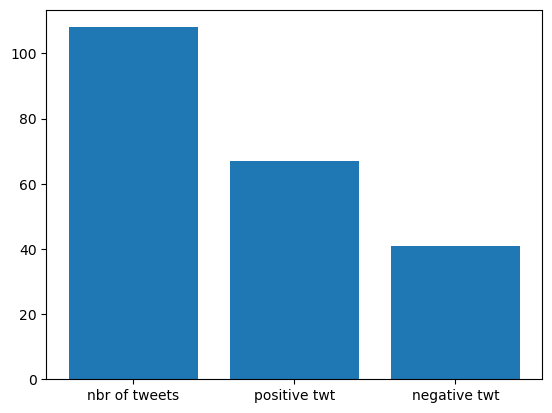

Insert data: [RT @pkreissel: Dass Medien wegen dummer nichtssagenden Online-Umfragen Push Meldungen schicken, aber nicht für die Tatsache, dass ihre Koll…, Tapsi60800763 ]
nombre of tweets : 109
nombre de positive tweets :  68
nombre de negative tweets  : 41
+--------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                               |prediction|
+--------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @pkreissel:, dass, medien, wegen, dummer, nichtssagenden, online-umfragen, push, meldungen, schicken]|4.0       |
+--------------------------------------------------------------------------------------------------------------+----------+



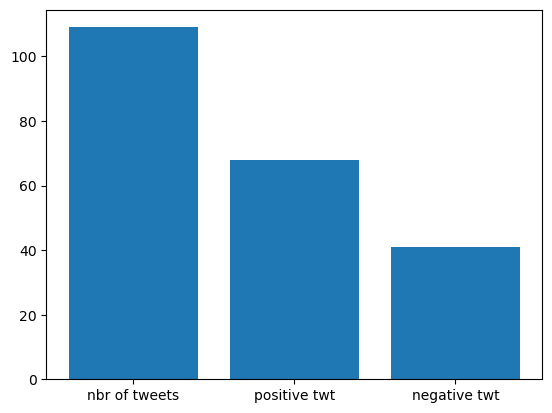

Insert data: [@SenWarren @Twitter @Tesla But no interest in Nancy Pelosi insider Trading. Pocahontas go smoke peodi, norman_ornelas ]
nombre of tweets : 110
nombre de positive tweets :  68
nombre de negative tweets  : 42
+--------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                               |prediction|
+--------------------------------------------------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, interest, nancy, pelosi, insider, trading., pocahontas, go, smoke, peodi""]|0.0       |
+--------------------------------------------------------------------------------------------------------------+----------+



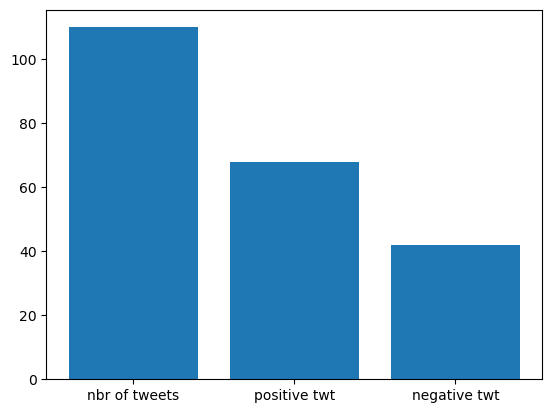

Insert data: [RT @janboehm: Weil ich ein FreeSpeech-Absolutist bin, zeige ich Tesla-Fahrern jetzt immer den Stinkefinger! 😃, RNuebling ]
nombre of tweets : 111
nombre de positive tweets :  68
nombre de negative tweets  : 43
+----------------------------------------------------------------+----------+
|MeaningfulWords                                                 |prediction|
+----------------------------------------------------------------+----------+
|["[""rt, @janboehm:, weil, ich, ein, freespeech-absolutist, bin]|0.0       |
+----------------------------------------------------------------+----------+



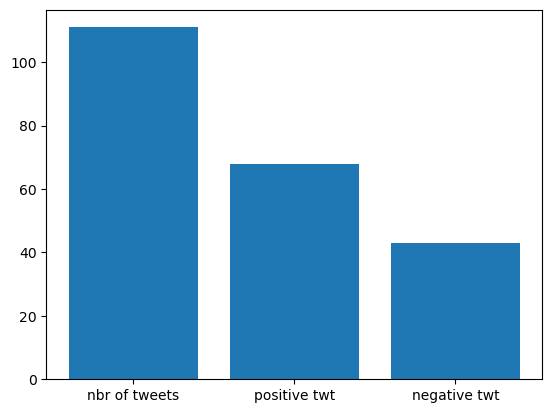

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, wopperzz ]
nombre of tweets : 112
nombre de positive tweets :  69
nombre de negative tweets  : 43
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--------

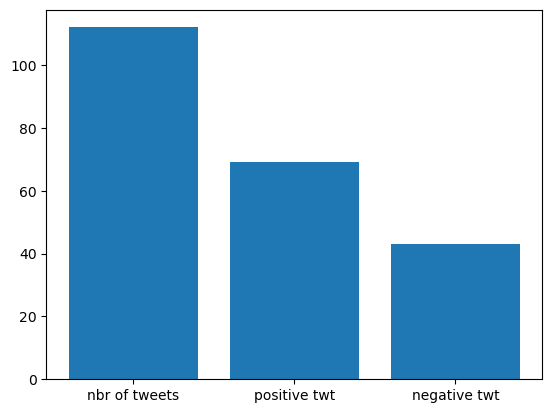

Insert data: [RT @Tesla: Congrats to the Giga Berlin team on building 3k Model Y this week! https://t.co/uUTOTRrasX, Goods3DServices ]
nombre of tweets : 113
nombre de positive tweets :  70
nombre de negative tweets  : 43
+---------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, congrats, giga, berlin, team, building, 3k, model, y, week!, https://t.co/uutotrrasx""]|4.0       |
+---------------------------------------------------------------------------------------------------------+----------+



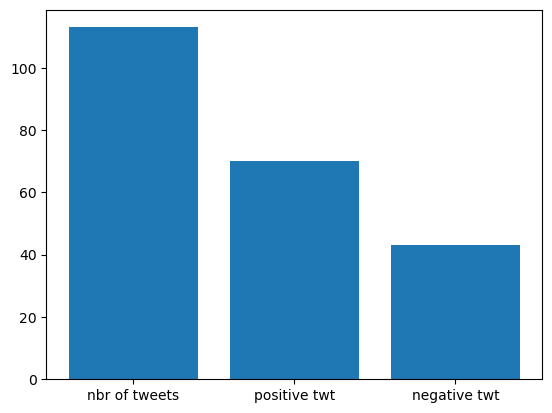

Insert data: [@TSLAFanMtl That's a really bad delivery for Tesla. 

Troy is correct that the delivery of the year is significantly lower than 50%., FrankHo09567294 ]
nombre of tweets : 114
nombre de positive tweets :  70
nombre de negative tweets  : 44
+-----------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                  |prediction|
+-----------------------------------------------------------------------------------------------------------------+----------+
|["[""@tslafanmtl, really, bad, delivery, tesla., \n\ntroy, correct, delivery, year, significantly, lower, 50%.""]|0.0       |
+-----------------------------------------------------------------------------------------------------------------+----------+



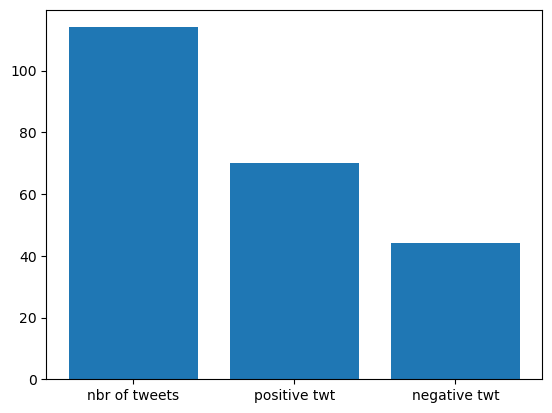

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, AltknwlwjyaWhsh ]
nombre of tweets : 115
nombre de positive tweets :  71
nombre de negative tweets  : 44
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-

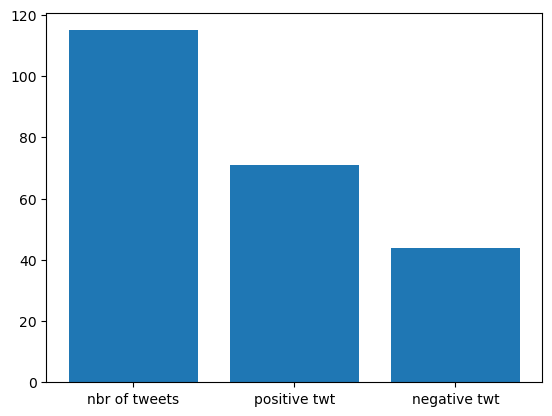

Insert data: [https://t.co/suRCTt8Ipg, scopses ]
nombre of tweets : 116
nombre de positive tweets :  72
nombre de negative tweets  : 44
+-------------------------------+----------+
|MeaningfulWords                |prediction|
+-------------------------------+----------+
|["[""https://t.co/surctt8ipg""]|4.0       |
+-------------------------------+----------+



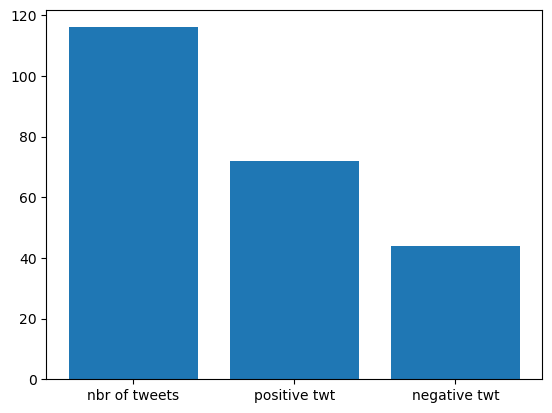

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, AnimeBo30320299 ]
nombre of tweets : 117
nombre de positive tweets :  73
nombre de negative tweets  : 44
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-

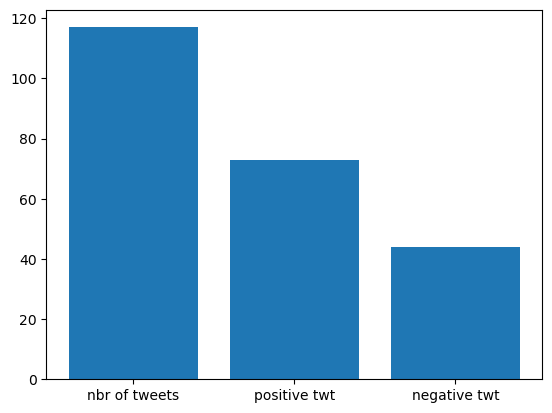

Insert data: [@TuttleCapital @wmwitkowski The thing is - as others have also pointed out - it's extraordinarily odd for a Tesla stockholder to look at Elmo's performance on Twitter and say:

"It's a problem that we have more of this erratic, inconsistent and stimulant fueled leadership at our helm."

No??, Tallow_beach ]
nombre of tweets : 118
nombre de positive tweets :  74
nombre de negative tweets  : 44
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+

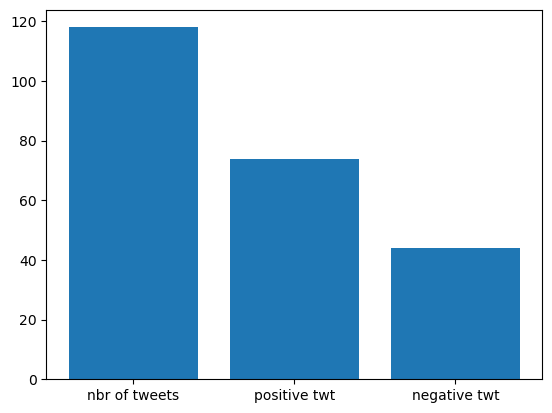

Insert data: [@elonmusk Stay at Twitter - Have the Tesla board appoint a new CEO that will restore our company's good name and brand (I am a shareholder)., gregorio_al ]
nombre of tweets : 119
nombre de positive tweets :  75
nombre de negative tweets  : 44
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@elonmusk, stay, twitter, -, tesla, board, appoint, new, ceo, restore, company's, good, name, brand, (i, shareholder).""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------------+----------+



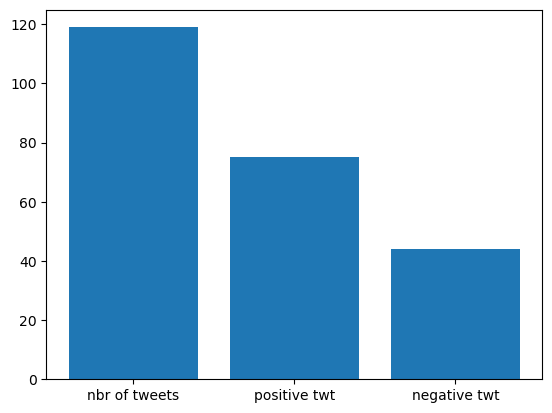

Insert data: [RT @duty2warn: Fun fact: the 62% decline in Tesla’s stock in 2022 destroyed a half a trillion dollars, serklarvel ]
nombre of tweets : 120
nombre de positive tweets :  75
nombre de negative tweets  : 45
+----------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                 |prediction|
+----------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, fun, fact:, 62%, decline, tesla\u2019s, stock, 2022, destroyed, half, trillion, dollars""]|0.0       |
+----------------------------------------------------------------------------------------------------------------+----------+



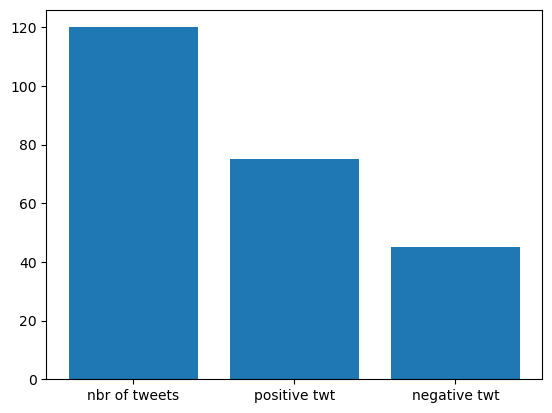

Insert data: [@AnthonyBauman9 @gakdudes @kylecoolky @Douglasddecker @sp3cul8r @TheEVuniverse @SawyerMerritt @elonmusk @WholeMarsBlog @alex_avoigt @stekkerauto @Tesla @FSDMaestro @Avatrode @ajsdevodent @vcdxnz001 @AlpineStrategic @rguthriems @FreightAlley @KiwiEV @jasondebolt @TeslaCharging @TeslaSolar @USDOT @FMCSA I imagine at some point the GOVT will start regulating the heck out of EVs just as ICE. What’s scary is how easy it is. If they can push software upgrades real-time I imagine they can limit your milage too., confer_patrick ]
nombre of tweets : 121
nombre de positive tweets :  76
nombre de negative tweets  : 45
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

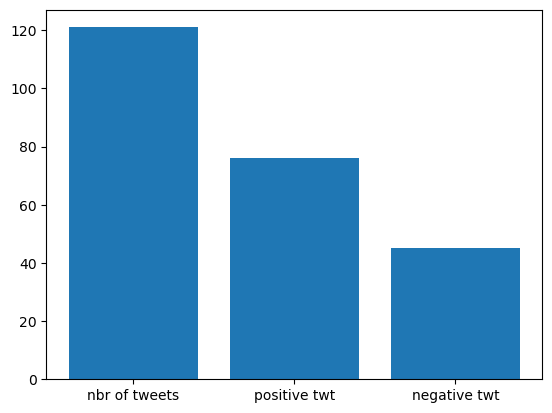

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, Elconejitogg ]
nombre of tweets : 122
nombre de positive tweets :  76
nombre de negative tweets  : 46
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+

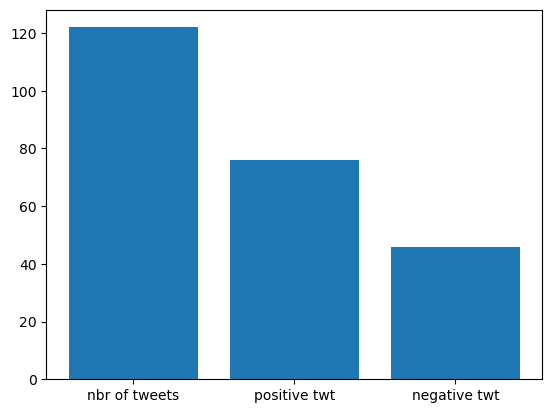

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, by__sana7 ]
nombre of tweets : 123
nombre de positive tweets :  76
nombre de negative tweets  : 47
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+---

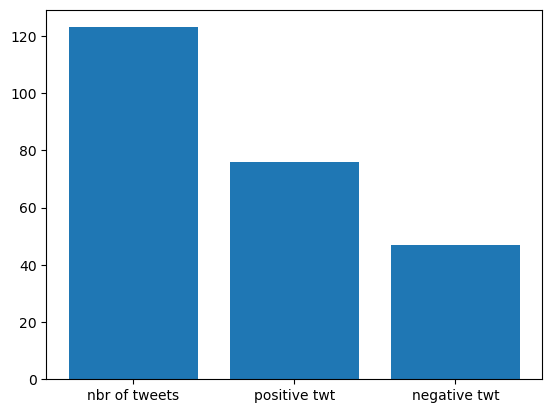

Insert data: [@savios27 @thomcolby @elizaorlins @SenWarren @Twitter @Tesla @elonmusk Thats how it works... Just like drag queen story time. They show up in a skirt and makeuo done up to read your kids books but swear they arent grooming them., PStasyna ]
nombre of tweets : 124
nombre de positive tweets :  77
nombre de negative tweets  : 47
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                    |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

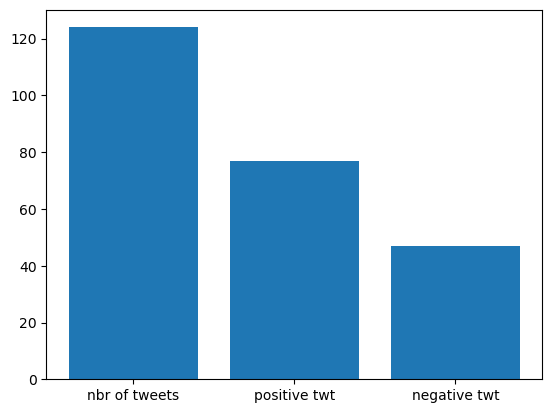

Insert data: [Hey @elonmusk  I have a Tesla question. Have you considered linking Teslas magnetically (like a train) (bumper to bumper) and cycle on times on the cars in the train to conserve battery power overall? Once your cars are fully in communication with each other and on autonomous., JoeAmericano4 ]
nombre of tweets : 125
nombre de positive tweets :  78
nombre de negative tweets  : 47
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                               |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------

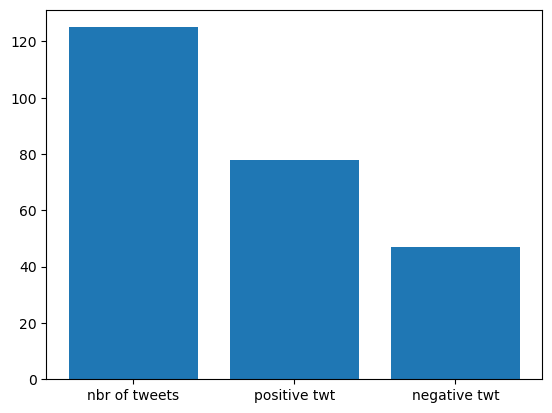

Insert data: [A bumpy ride for Tesla investors as boss Elon Musk faces Twitter ousting after online poll stunt backfires https://t.co/Aa8EYyHNIc, businesshalausa ]
nombre of tweets : 126
nombre de positive tweets :  79
nombre de negative tweets  : 47
+------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                 |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""a, bumpy, ride, tesla, investors, boss, elon, musk, faces, twitter, ousting, online, poll, stunt\u00a0backfires, https://t.co/aa8eyyhnic""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------

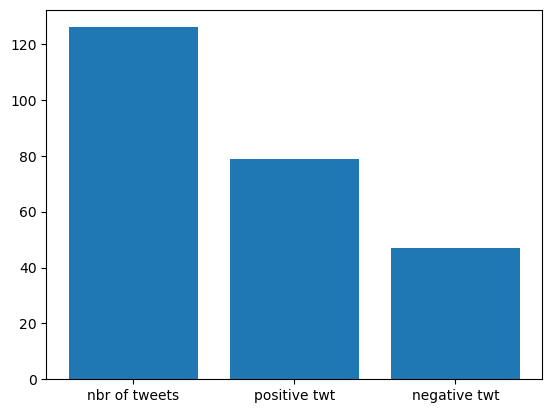

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, RafaelPavonMX97 ]
nombre of tweets : 127
nombre de positive tweets :  79
nombre de negative tweets  : 48
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-

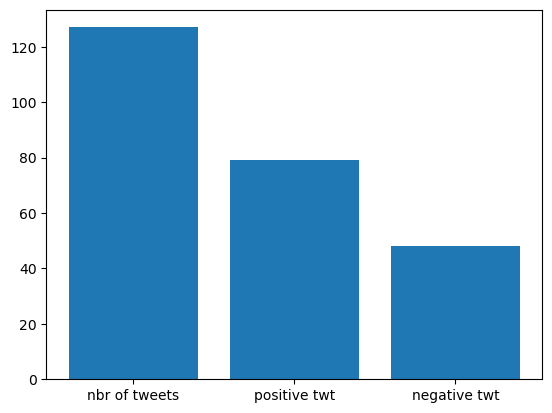

Insert data: [RT @BriannaWu: To all geniuses that Tweeted at Elon critics, “iF yOu Don’T LiKE it JuSt LEave, Durka durr.”

Our relentless criticism is wh…, Dmayoraru ]
nombre of tweets : 128
nombre de positive tweets :  80
nombre de negative tweets  : 48
+-------------------------------------------------------+----------+
|MeaningfulWords                                        |prediction|
+-------------------------------------------------------+----------+
|["[""rt, @briannawu:, geniuses, tweeted, elon, critics]|4.0       |
+-------------------------------------------------------+----------+



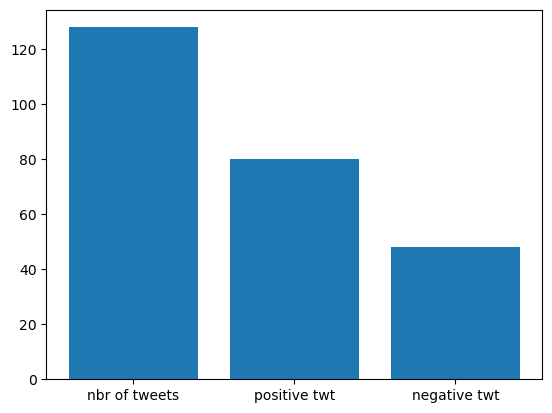

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, SzymonPakowski3 ]
nombre of tweets : 129
nombre de positive tweets :  80
nombre de negative tweets  : 49
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-

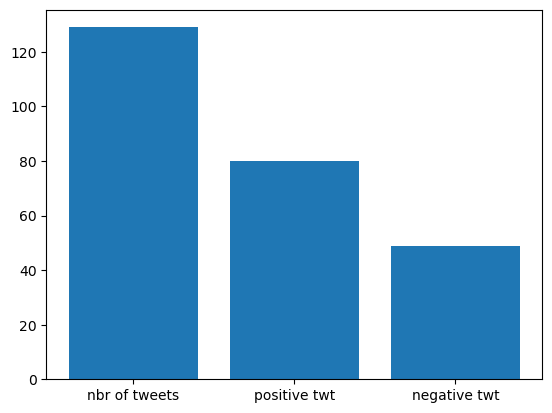

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, ScreamingoLo ]
nombre of tweets : 130
nombre de positive tweets :  80
nombre de negative tweets  : 50
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+----

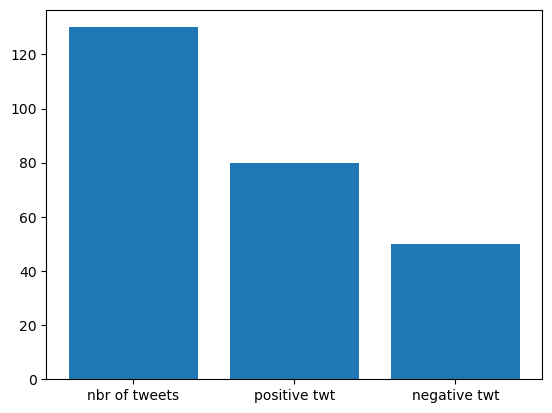

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, FaelVendramini ]
nombre of tweets : 131
nombre de positive tweets :  80
nombre de negative tweets  : 51
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--

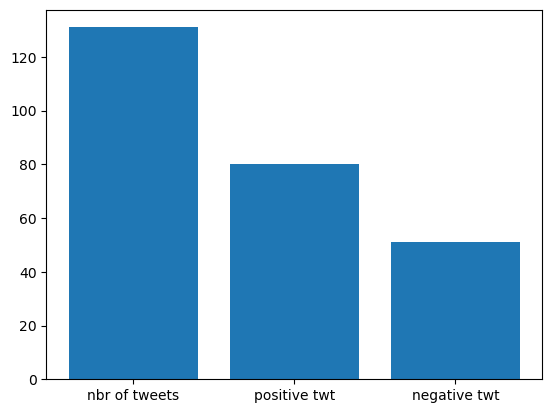

Insert data: [RT @muglikar_: Toyota halts expansion in India, Tesla says taxes are high on cars, today Maruti Chairman says 50% tax on cars will kill the…, BHIMSENSHARMA ]
nombre of tweets : 132
nombre de positive tweets :  81
nombre de negative tweets  : 51
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""rt, @muglikar_:, toyota, halts, expansion, india]|4.0       |
+------------------------------------------------------+----------+



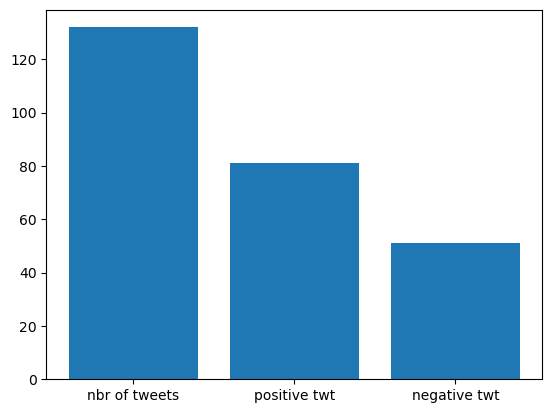

Insert data: [Elon Musk to tesla share holders https://t.co/DktGBwgPzj, DaveScott0420 ]
nombre of tweets : 133
nombre de positive tweets :  82
nombre de negative tweets  : 51
+------------------------------------------------------------------+----------+
|MeaningfulWords                                                   |prediction|
+------------------------------------------------------------------+----------+
|["[""elon, musk, tesla, share, holders, https://t.co/dktgbwgpzj""]|4.0       |
+------------------------------------------------------------------+----------+



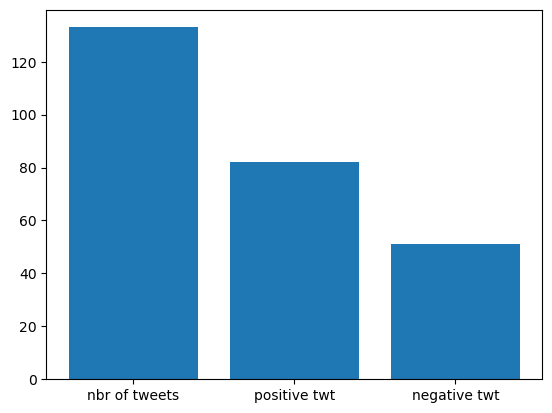

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, francvs ]
nombre of tweets : 134
nombre de positive tweets :  83
nombre de negative tweets  : 51
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



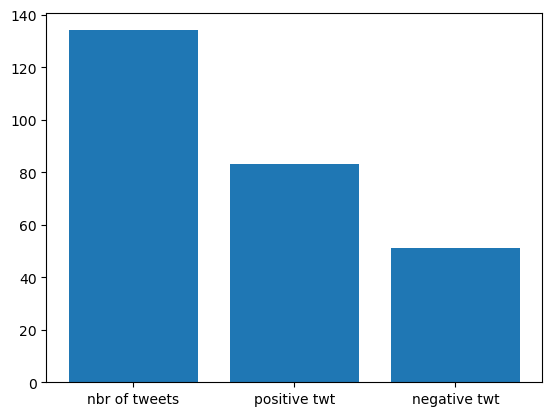

Insert data: [@Tesla @elonmusk Elon, what wrong with tesla stock now? Investors are in pain …😰😰😰, Luckyrosie1 ]
nombre of tweets : 135
nombre de positive tweets :  83
nombre de negative tweets  : 52
+-----------------------------+----------+
|MeaningfulWords              |prediction|
+-----------------------------+----------+
|["[""@tesla, @elonmusk, elon]|0.0       |
+-----------------------------+----------+



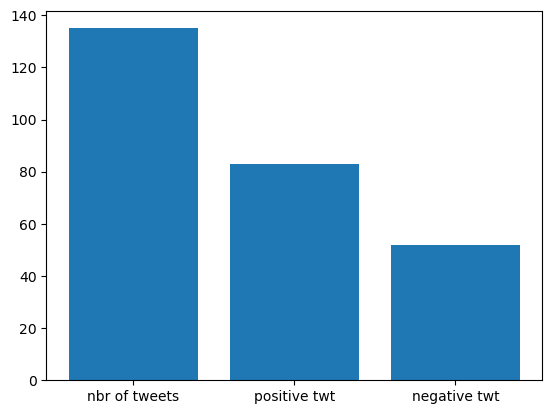

Insert data: [@SenWarren @Twitter @Tesla more lies from you? don't you EVER STOP?, bryantaylor2000 ]
nombre of tweets : 136
nombre de positive tweets :  84
nombre de negative tweets  : 52
+-------------------------------------------------------------+----------+
|MeaningfulWords                                              |prediction|
+-------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, lies, you?, ever, stop?""]|4.0       |
+-------------------------------------------------------------+----------+



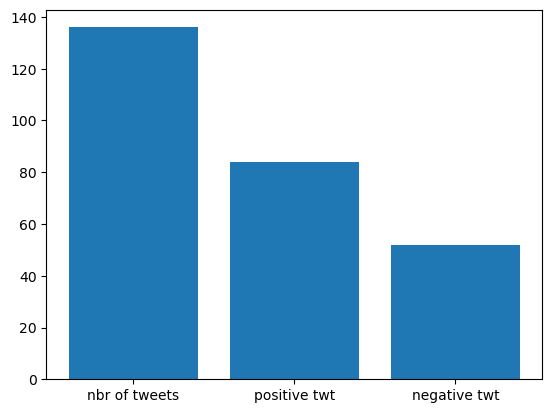

Insert data: [RT @Akparti: Cumhurbaşkanımız Recep Tayyip Erdoğan, Katar'ın ev sahipliğinde Lusail Stadyumu'nda düzenlenen 2022 FIFA Dünya Kupası final ma…, reisidevlet__ ]
nombre of tweets : 137
nombre de positive tweets :  85
nombre de negative tweets  : 52
+---------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                  |prediction|
+---------------------------------------------------------------------------------+----------+
|["[""rt, @akparti:, cumhurba\u015fkan\u0131m\u0131z, recep, tayyip, erdo\u011fan]|4.0       |
+---------------------------------------------------------------------------------+----------+



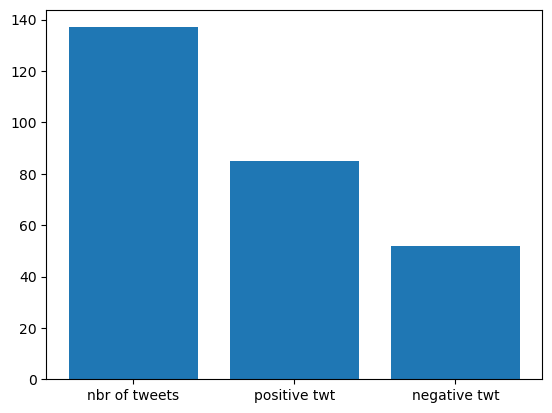

Insert data: [RT @H_MitchellPhoto: Tesla down another 3% today. Ouch 🤕 https://t.co/iR6zmPj2zw, MitaLaungani ]
nombre of tweets : 138
nombre de positive tweets :  85
nombre de negative tweets  : 53
+------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @h_mitchellphoto:, tesla, another, 3%, today., ouch, \ud83e\udd15, https://t.co/ir6zmpj2zw""]|0.0       |
+------------------------------------------------------------------------------------------------------+----------+



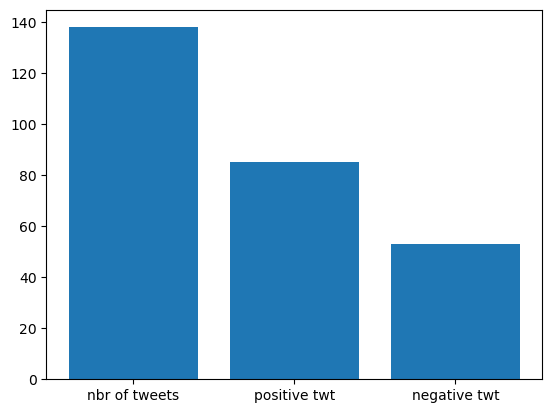

Insert data: [RT @DougJBalloon: Opinion | Some say Musk should be ousted at Tesla.  But Tesla without Elon Musk is like Theranos without Elizabeth Homes., NorCalValley ]
nombre of tweets : 139
nombre de positive tweets :  86
nombre de negative tweets  : 53
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                            |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @dougjballoon:, opinion, |, say, musk, ousted, tesla., , tesla, without, elon, musk, like, theranos, without, elizabeth, homes.""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------

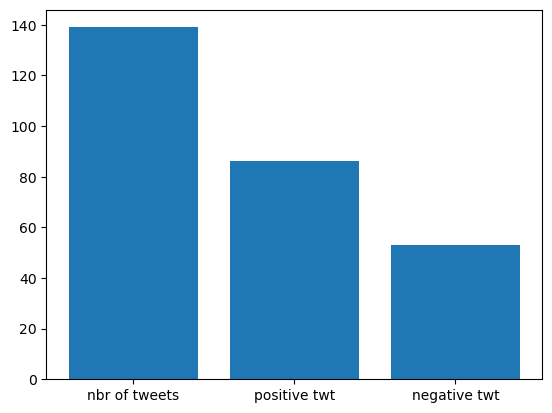

Insert data: [@Tesla Every Tesla has an electronic powertrain that love to DRIVE INTO CHILDREN!!!, gedsthought ]
nombre of tweets : 140
nombre de positive tweets :  87
nombre de negative tweets  : 53
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@tesla, every, tesla, electronic, powertrain, love, drive, children!!!""]|4.0       |
+------------------------------------------------------------------------------+----------+



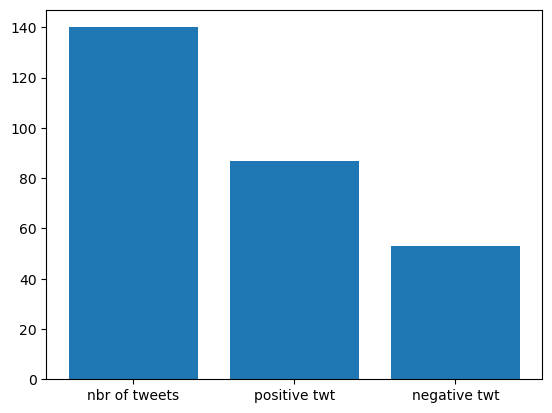

Insert data: [@SenWarren @Twitter @Tesla Here we go again Fauxcahontas, Gdservant1 ]
nombre of tweets : 141
nombre de positive tweets :  87
nombre de negative tweets  : 54
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, go, fauxcahontas""]|0.0       |
+------------------------------------------------------+----------+



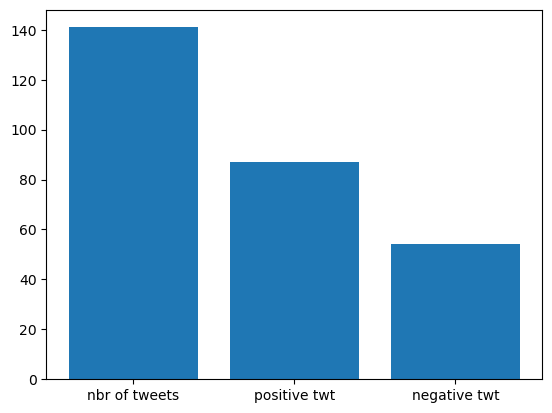

Insert data: [RT @SenWarren: Elon Musk took over @Twitter, but he's still the CEO of @Tesla. That raises legal concerns — is he creating conflicts of int…, 2020_bluewave ]
nombre of tweets : 142
nombre de positive tweets :  87
nombre de negative tweets  : 55
+-------------------------------------------------+----------+
|MeaningfulWords                                  |prediction|
+-------------------------------------------------+----------+
|["[""rt, @senwarren:, elon, musk, took, @twitter]|0.0       |
+-------------------------------------------------+----------+



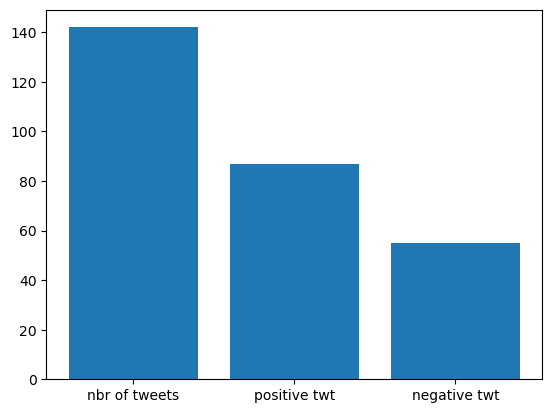

Insert data: [@tomaskenn @Tesla https://t.co/zEN1gJtITs, mister_hooper ]
nombre of tweets : 143
nombre de positive tweets :  88
nombre de negative tweets  : 55
+---------------------------------------------------+----------+
|MeaningfulWords                                    |prediction|
+---------------------------------------------------+----------+
|["[""@tomaskenn, @tesla, https://t.co/zen1gjtits""]|4.0       |
+---------------------------------------------------+----------+



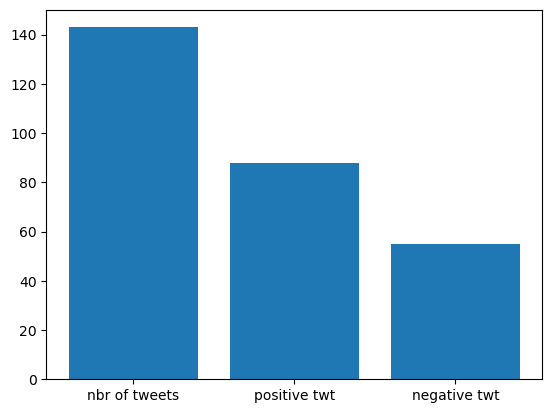

Insert data: [RT @ChrisDungeon: Dungeon's Daily $TSLA

Tuesday Edition - December 20th

Curated posts worth reading inside 👇🏻

Goal is to reduce your tim…, teslaunivrse ]
nombre of tweets : 144
nombre de positive tweets :  89
nombre de negative tweets  : 55
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @chrisdungeon:, dungeon's, daily, $tsla\n\ntuesday, edition, -, december, 20th\n\ncurated, posts, worth, reading, inside, \ud83d\udc47\

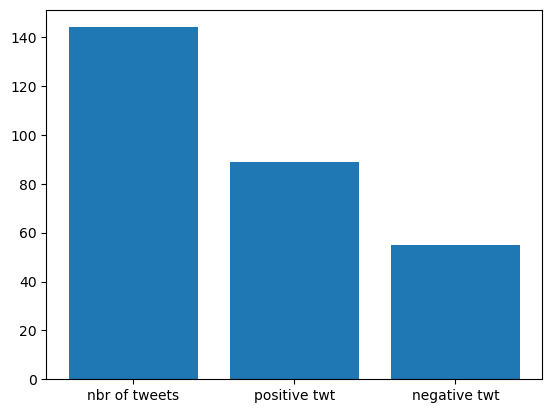

Insert data: [#Tesla As said last month shorted below $200 covered around $143
Relative good support at 140/135 zone,
If not held above zone then it is going to hit below $100 levels whr super strong 💪 support levels is seen., vcsandeep ]
nombre of tweets : 145
nombre de positive tweets :  89
nombre de negative tweets  : 56
+-------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                              |prediction|
+-------------------------------------------------------------------------------------------------------------+----------+
|["[""#tesla, said, last, month, shorted, $200, covered, around, $143\nrelative, good, support, 140/135, zone]|0.0       |
+-------------------------------------------------------------------------------------------------------------+----------+



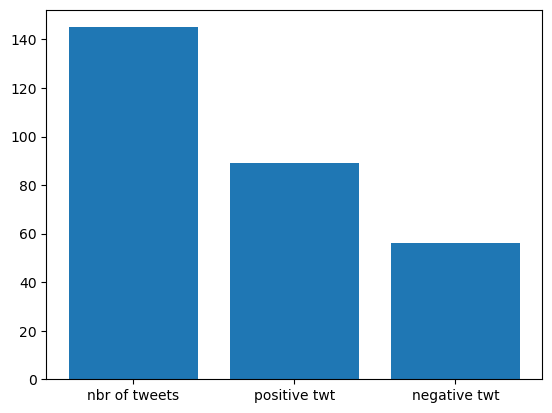

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, dickjohnson117 ]
nombre of tweets : 146
nombre de positive tweets :  90
nombre de negative tweets  : 56
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



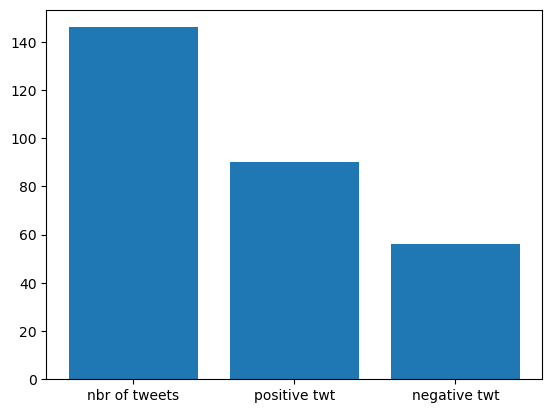

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, eichorn_terry ]
nombre of tweets : 147
nombre de positive tweets :  91
nombre de negative tweets  : 56
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



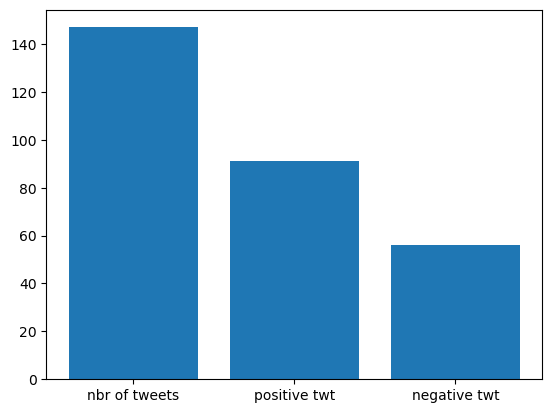

Insert data: [RT @DougJBalloon: If the government won’t bail out my Tesla losses, I’m going to become an even bigger libertarian., L3CA ]
nombre of tweets : 148
nombre de positive tweets :  92
nombre de negative tweets  : 56
+---------------------------------------------------------------------+----------+
|MeaningfulWords                                                      |prediction|
+---------------------------------------------------------------------+----------+
|["[""rt, @dougjballoon:, government, won\u2019t, bail, tesla, losses]|4.0       |
+---------------------------------------------------------------------+----------+



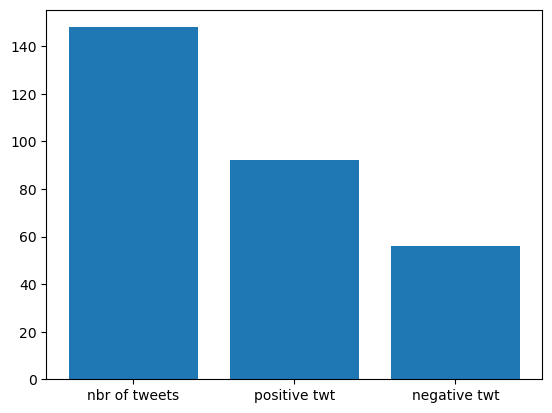

Insert data: [@TESLA_CREADOR Muyyyyyy buenos días de invierno https://t.co/Dfev6dMNDn, Mavica1980 ]
nombre of tweets : 149
nombre de positive tweets :  93
nombre de negative tweets  : 56
+------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                           |prediction|
+------------------------------------------------------------------------------------------+----------+
|["[""@tesla_creador, muyyyyyy, buenos, d\u00edas, de, invierno, https://t.co/dfev6dmndn""]|4.0       |
+------------------------------------------------------------------------------------------+----------+



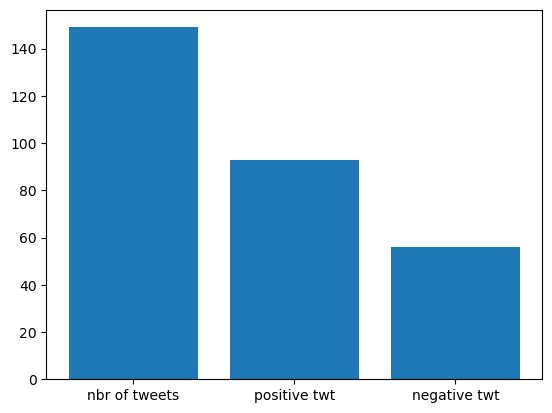

Insert data: [RT @SarahBCalif: @neiltyson @elonmusk Elon has invented nothing. 

“Tesla Motors was first founded by Martin Eberhard and Marc Tarpenning,…, tami32961 ]
nombre of tweets : 150
nombre de positive tweets :  93
nombre de negative tweets  : 57
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sarahbcalif:, @neiltyson, @elonmusk, elon, invented, nothing., \n\n\u201ctesla, motors, first, founded, martin, eberhard, marc, tarpenning]|0.0       |
+---------------------------------------------------------------------------------------------

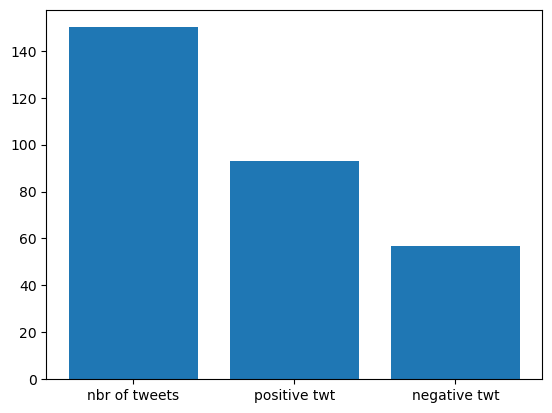

Insert data: [@Skillmare @elonmusk Tesla’s in serious trouble, DennisConroy16 ]
nombre of tweets : 151
nombre de positive tweets :  93
nombre de negative tweets  : 58
+-------------------------------------------------------------+----------+
|MeaningfulWords                                              |prediction|
+-------------------------------------------------------------+----------+
|["[""@skillmare, @elonmusk, tesla\u2019s, serious, trouble""]|0.0       |
+-------------------------------------------------------------+----------+



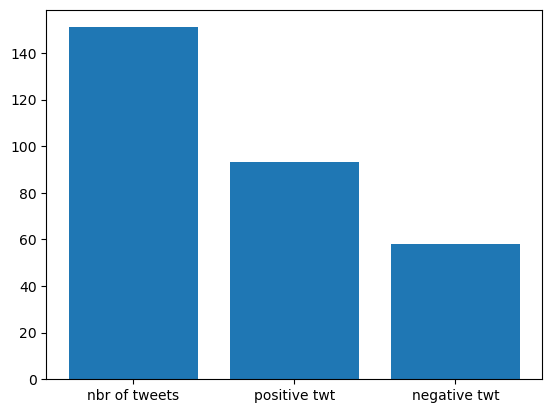

Insert data: [RT @rhonda_harbison: @HawleyMO https://t.co/B4IAnoEyyt
Red-Pilled Elon Musk Still Loves the Chinese Communist Party, Nikluk ]
nombre of tweets : 152
nombre de positive tweets :  93
nombre de negative tweets  : 59
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @rhonda_harbison:, @hawleymo, https://t.co/b4ianoeyyt\nred-pilled, elon, musk, still, loves, chinese, communist, party""]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------+----------+



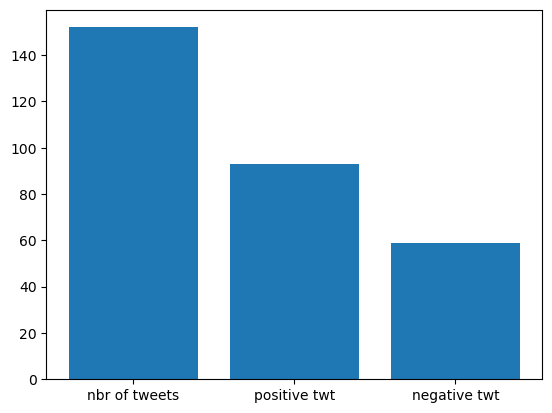

Insert data: [#ElonMusk blames macroeconomic conditions as #Tesla stock tanks

https://t.co/Y4xWleSeR2, TimesNow ]
nombre of tweets : 153
nombre de positive tweets :  93
nombre de negative tweets  : 60
+-----------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|["[""#elonmusk, blames, macroeconomic, conditions, #tesla, stock, tanks\n\nhttps://t.co/y4xwleser2""]|0.0       |
+-----------------------------------------------------------------------------------------------------+----------+



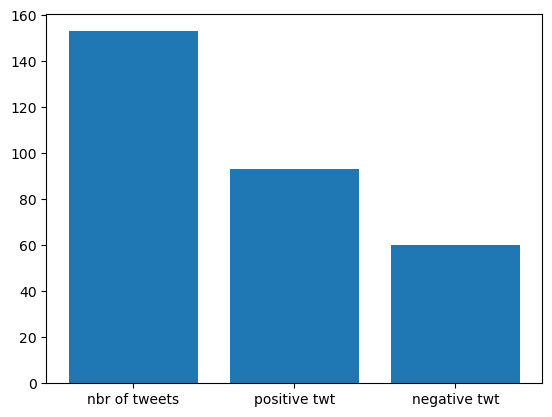

Insert data: [RT @unusual_whales: Recently, Elon reportedly sold nearly $3.58 billion of Tesla.

To see how Tesla, $TSLA, is performing, check: https://t…, IVANAGU90585190 ]
nombre of tweets : 154
nombre de positive tweets :  94
nombre de negative tweets  : 60
+------------------------------------+----------+
|MeaningfulWords                     |prediction|
+------------------------------------+----------+
|["[""rt, @unusual_whales:, recently]|4.0       |
+------------------------------------+----------+



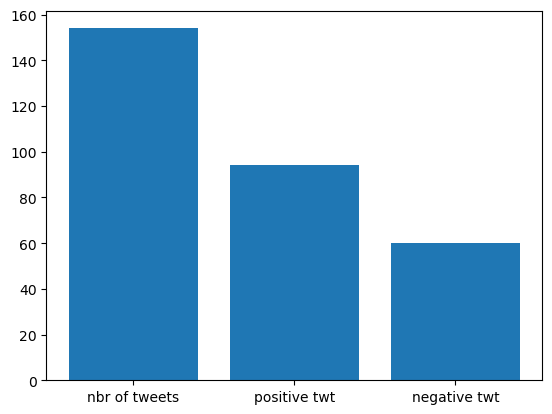

Insert data: [🛡️ Cuando un Tesla en piloto automático mata a alguien, ¿quién es el responsable? https://t.co/8qM6nT7zO3, LaCronologia ]
nombre of tweets : 155
nombre de positive tweets :  95
nombre de negative tweets  : 60
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[["ud83dudee1ufe0f, cuando, un, tesla, en, piloto, automu00e1tico, mata, alguien,, u00bfquiu00e9n, es, el, responsable?, https://t.co/8qm6nt7zo3"]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------

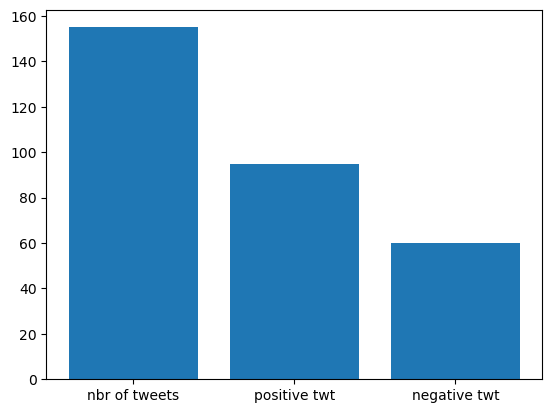

Insert data: [@Pensioenspook En ondertussen worden adverteerders door dat flipflop-beleid en door de politiek gekleurde houding van Elon Musk weggejaagd. Twitter stevent af op steeds grotere verliezen.

En (onder andere) daardoor wordt Tesla meegezogen., Lynx__RedLeft ]
nombre of tweets : 156
nombre de positive tweets :  96
nombre de negative tweets  : 60
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                        |prediction|
+-------------------------------------------------------

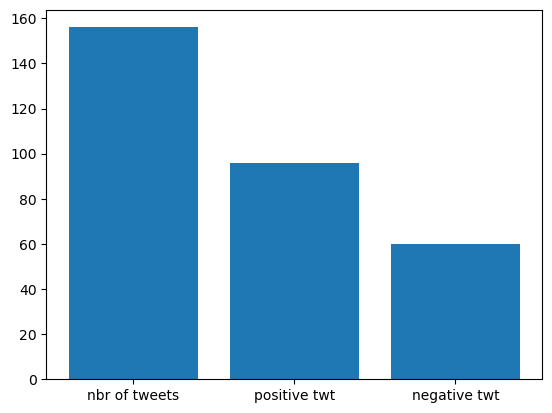

Insert data: [@bluecollarmonee The position is not huge but relative to it's
holdings it is in the top ten. I wasn't referring
to just $SPY though. $QQQ has quite a bit, it's
in it's top 5. There are many ETF's with a lot of
$TSLA exposure. The market cap. bleed on 
Tesla is nuts. Just a opinion though... https://t.co/buuNPxpMK6, TheTVTaster ]
nombre of tweets : 157
nombre de positive tweets :  96
nombre de negative tweets  : 61
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@bluecollarmonee, position, huge, relative, it's\nholdings, top, ten., referring\nto, $spy, though., $qqq, quite, bit]|0.0       |
+------------------

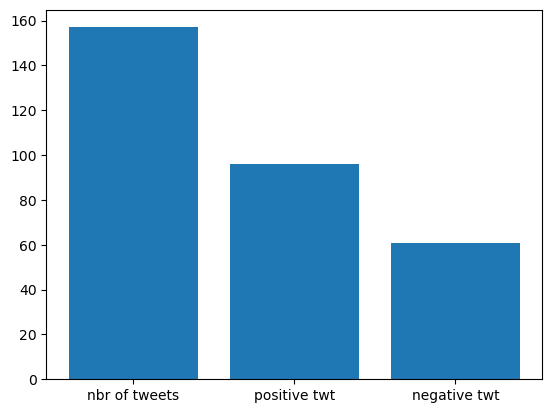

Insert data: [@elonmusk You can promote someone you trust from Tesla. This will help you I guess., ArslaanAnwer ]
nombre of tweets : 158
nombre de positive tweets :  97
nombre de negative tweets  : 61
+----------------------------------------------------------------+----------+
|MeaningfulWords                                                 |prediction|
+----------------------------------------------------------------+----------+
|["[""@elonmusk, promote, someone, trust, tesla., help, guess.""]|4.0       |
+----------------------------------------------------------------+----------+



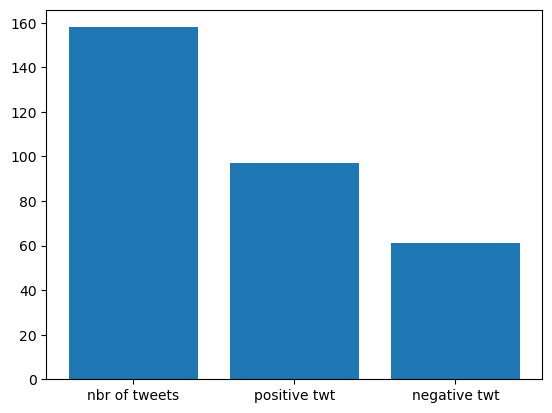

Insert data: [RT @MarketMaven2022: $TSLA energy also has autobidder. For those of you that don’t know what it is, it basically allows customers to sell t…, jeongseonung ]
nombre of tweets : 159
nombre de positive tweets :  98
nombre de negative tweets  : 61
+-------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                |prediction|
+-------------------------------------------------------------------------------+----------+
|["[""rt, @marketmaven2022:, $tsla, energy, also, autobidder., don\u2019t, know]|4.0       |
+-------------------------------------------------------------------------------+----------+



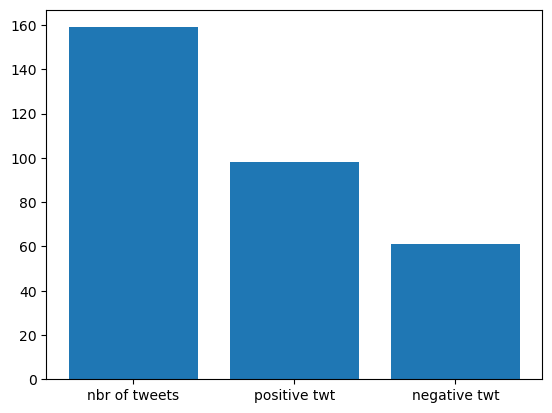

Insert data: [@gm_currency @vanessasierra00 Also "Tesla lithium-ion batteries are fully recycled. None of the materials go into a landfill as long as you recycle them properly. This means returning them to a Tesla service center.", YouWishNFT ]
nombre of tweets : 160
nombre de positive tweets :  99
nombre de negative tweets  : 61
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@gm_currency, @vanessas

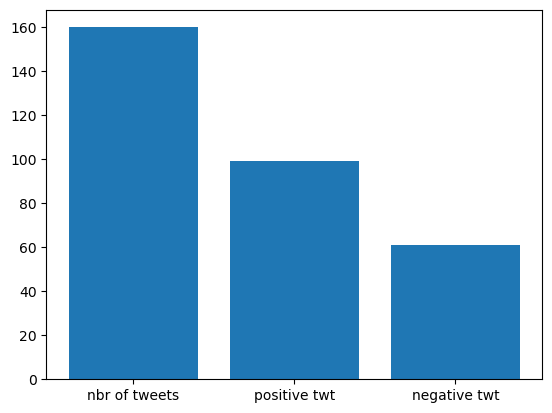

Insert data: [RT @CurieuxExplorer: What to know about #Tesla's batteries

https://t.co/Ay4gcvXyR2 
@FrRonconi @labordeolivier @Nicochan33 @PawlowskiMario…, labordeolivier ]
nombre of tweets : 161
nombre de positive tweets :  100
nombre de negative tweets  : 61
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @curieuxexplorer:, know, #tesla's, batteries\n\nhttps://t.co/ay4gcvxyr2, \n@frronconi, @labordeolivier, @nicochan33, @pawlowskimario\u2026""]|4.0       |
+----------------------------------------------------------------------------------

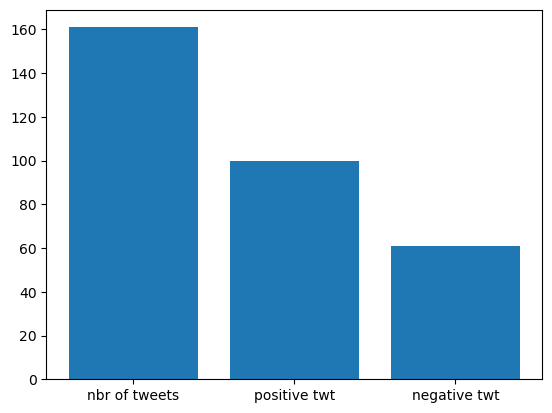

Insert data: [RT @EvaFoxU: Tesla Megacharger is installed in Sacramento to support Tesla Semi in PepsiCo operations. The Texas-based manufacturer deliver…, BilalBerry45205 ]
nombre of tweets : 162
nombre de positive tweets :  101
nombre de negative tweets  : 61
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @evafoxu:, tesla, megacharger, installed, sacramento, support, tesla, semi, pepsico, operations., texas-based, manufacturer, deliver\u2026""]|4.0       |
+---------------------------------------------------------------------------------

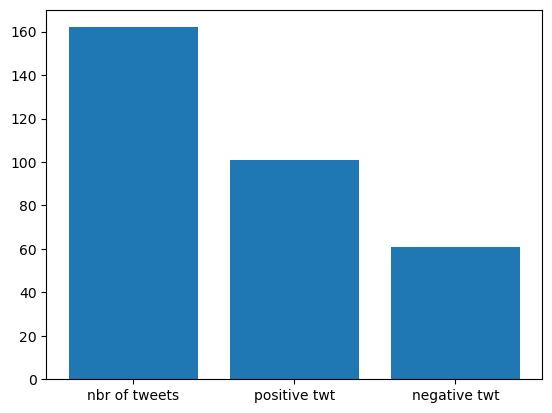

Insert data: [RT @HSajwanization: Jeff Bezos’s Amazon $AMZN just became the world’s first company to lose $1 trillion (yes TRILLION) in market value, the…, chikusin2 ]
nombre of tweets : 163
nombre de positive tweets :  102
nombre de negative tweets  : 61
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @hsajwanization:, jeff, bezos\u2019s, amazon, $amzn, became, world\u2019s, first, company, lose, $1, trillion, (yes, trillion), market, value]|4.0       |
+-----------------------------------------------------------------------------------

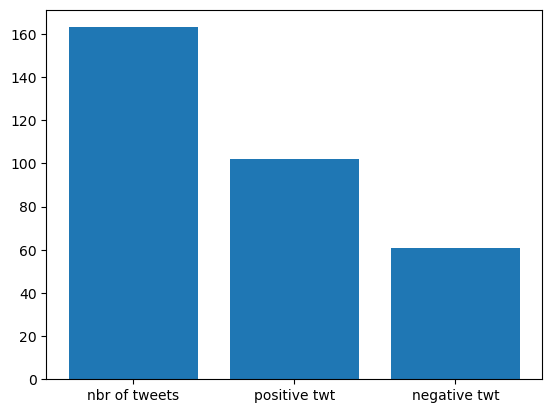

Insert data: [RT @SteveShallenbe1: @SenWarren @Twitter @Tesla We should investigate every single politician who became a millionaire in office….every sti…, conco1234321 ]
nombre of tweets : 164
nombre de positive tweets :  103
nombre de negative tweets  : 61
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @steveshallenbe1:, @senwarren, @twitter, @tesla, investigate, every, single, politician, became, millionaire, office\u2026.every, sti\u2026""]|4.0       |
+--------------------------------------------------------------------------------

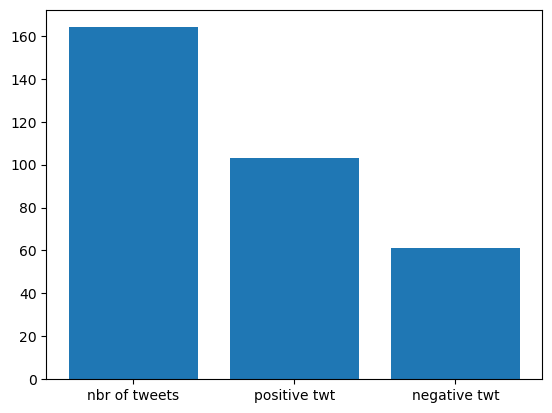

Insert data: [TESLA ROADSTER
0-60? 1.9 seconds
Seats? 2
Power? Electric
Price? $200,000

LADA 2101
0-60? Yeah, it'll get there
Seats? At least 5
Power? Petrol
Price? 34,625 rubles (€500) and a sack of potatoes

Winner: LADA 2101, nichol_five ]
nombre of tweets : 165
nombre de positive tweets :  103
nombre de negative tweets  : 62
+-------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                      |prediction|
+-------------------------------------------------------------------------------------+----------+
|["[""tesla, roadster\n0-60?, 1.9, seconds\nseats?, 2\npower?, electric\nprice?, $200]|0.0       |
+-------------------------------------------------------------------------------------+----------+



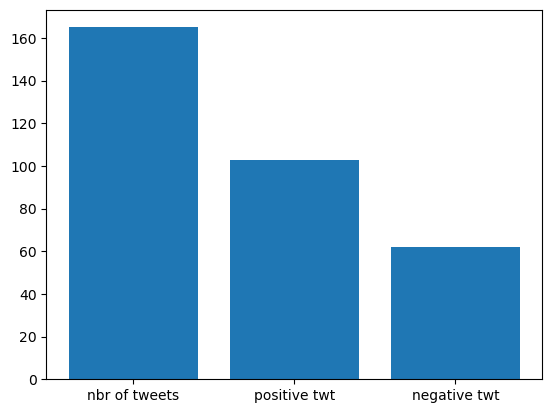

Insert data: [Tesla stock is in freefall, Boring isn't turning up to fulfill contracts, Neuralink in under federal investigation for animal cruelty. https://t.co/B1qn9IE7eO, CommieCountry ]
nombre of tweets : 166
nombre de positive tweets :  103
nombre de negative tweets  : 63
+----------------------------+----------+
|MeaningfulWords             |prediction|
+----------------------------+----------+
|["[""tesla, stock, freefall]|0.0       |
+----------------------------+----------+



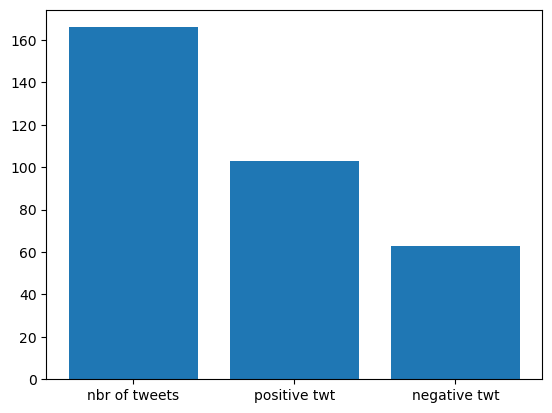

Insert data: [he's tanking twitter, how hard is it to see? barking at the investors, stripping confidence in the platform, ruining advertiser relationships.  it's only the spill over into tesla that is causing issues he'll need to care about.  he's killing the greatest platform for free speech https://t.co/SVMWEzeGFR, hactuary_ ]
nombre of tweets : 167
nombre de positive tweets :  103
nombre de negative tweets  : 64
+----------------------------+----------+
|MeaningfulWords             |prediction|
+----------------------------+----------+
|["[""he's, tanking, twitter]|0.0       |
+----------------------------+----------+



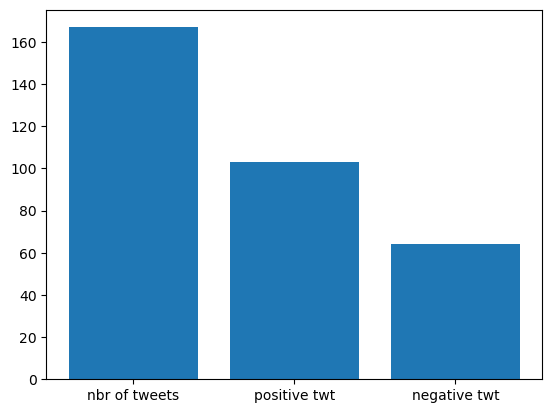

Insert data: [#haber #SONDAKIKA #Irak #yks22 #GizliSakli #Kiew #tcmeb #enflasyon #Tesla #Ukraine #DuyBeni #Zaho #Ukraine #iPhone14Pro #iPhone14 #mtv https://t.co/01aLlYl0JI, FalconHaber ]
nombre of tweets : 168
nombre de positive tweets :  104
nombre de negative tweets  : 64
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                       |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""#haber, #sondakika, #irak, #yks22, #gizlisakli, #kiew, #tcmeb, #enflasyon, #tesla, #ukraine, #duybeni, #zaho, #ukraine, #iphone14p

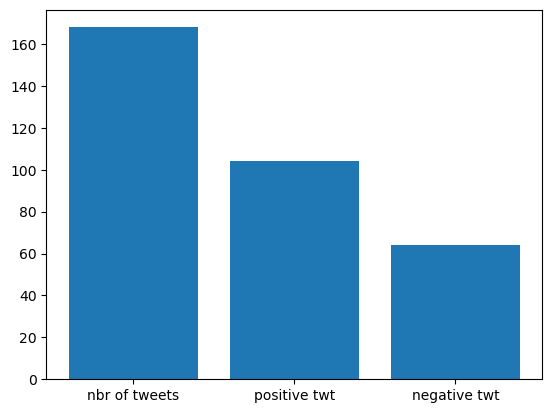

Insert data: [@ramblalibre_com Jajaja. Voy a comprar acciones el las papeleras de los mercados internacionales , porque todos nos cagamos en lo mismo! Olvidaos de APPLE y Tesla! 😂, carpediemSXXI ]
nombre of tweets : 169
nombre de positive tweets :  105
nombre de negative tweets  : 64
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""@ramblalibre_com, jajaja., voy, comprar, acciones, el, las, papeleras, de, los, mercados, internacionales]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



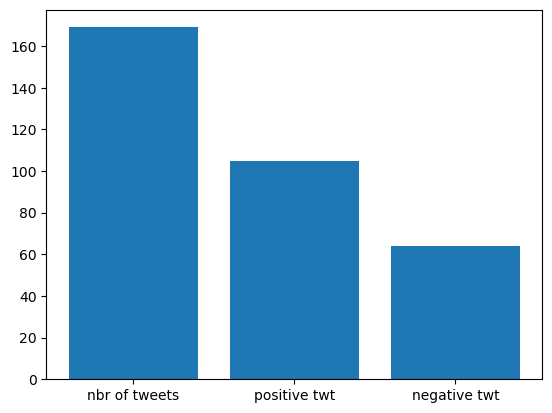

Insert data: [@bluecollarmonee The position is not huge but relative to it's
holdings it is in the top ten. I wasn't referring
to just $SPY though. $QQQ has quite a bit, it's
in it's top 5. There are many ETF's with a lot of
$TSLA exposure. The market cap. bleed on 
Tesla is nuts. Just a opinion though... https://t.co/buuNPxpMK6, TheTVTaster ]
nombre of tweets : 170
nombre de positive tweets :  105
nombre de negative tweets  : 65
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@bluecollarmonee, position, huge, relative, it's\nholdings, top, ten., referring\nto, $spy, though., $qqq, quite, bit]|0.0       |
+-----------------

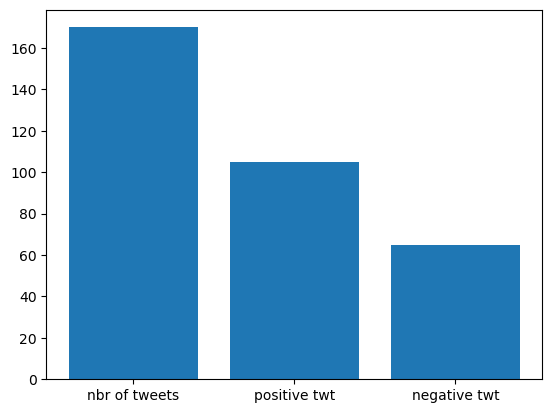

Insert data: [RT @BriannaWu: TESLA STOCK PRICE OFFICIALLY AT $139. Tesla's most famous investors calling for the board to fire Musk. "This stock price re…, CathyGTexas ]
nombre of tweets : 171
nombre de positive tweets :  105
nombre de negative tweets  : 66
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, tesla, stock, price, officially, $139., tesla's, famous, investors, calling, board, fire, musk., \""this, stock, price, re\u2026""]|0.0       |
+-------------------------------------------------------------------------

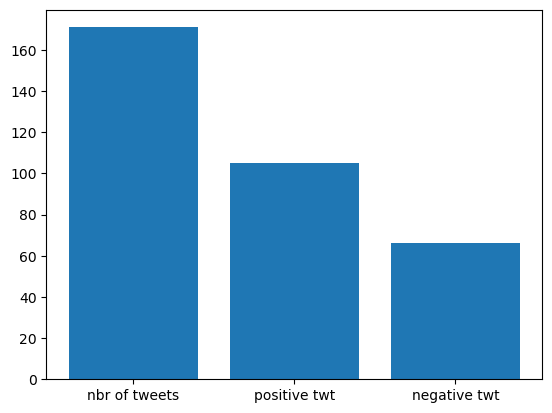

Insert data: [RT @SquidDiddly1989: @POTUS Hense the proxy war and Tesla getting a military contract https://t.co/5LGC6g2wqq, DOOMED_USA__ ]
nombre of tweets : 172
nombre de positive tweets :  105
nombre de negative tweets  : 67
+---------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                      |prediction|
+---------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @squiddiddly1989:, @potus, hense, proxy, war, tesla, getting, military, contract, https://t.co/5lgc6g2wqq""]|0.0       |
+---------------------------------------------------------------------------------------------------------------------+----------+



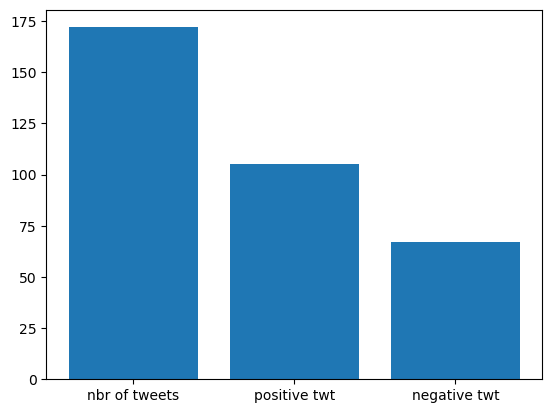

Insert data: [RT @farzyness: Will you consider buying a Tesla car?

(Please retweet for maximum exposure - follow up poll in replies), gabrielgalcer ]
nombre of tweets : 173
nombre de positive tweets :  106
nombre de negative tweets  : 67
+------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                         |prediction|
+------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @farzyness:, consider, buying, tesla, car?\n\n(please, retweet, maximum, exposure, -, follow, poll, replies)""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------+----------+



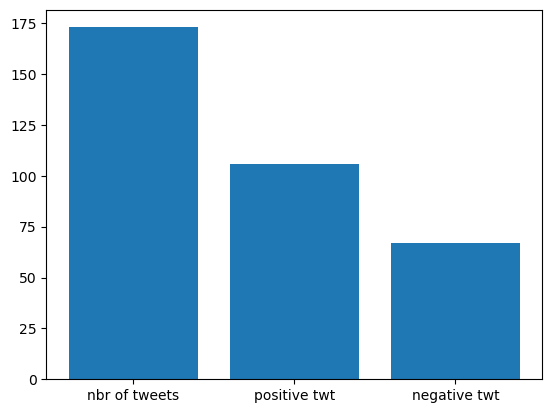

Insert data: [RT @notcapnamerica: Tesla's stock is nosediving., MuseKhaotic ]
nombre of tweets : 174
nombre de positive tweets :  106
nombre de negative tweets  : 68
+---------------------------------------------------------+----------+
|MeaningfulWords                                          |prediction|
+---------------------------------------------------------+----------+
|["[""rt, @notcapnamerica:, tesla's, stock, nosediving.""]|0.0       |
+---------------------------------------------------------+----------+



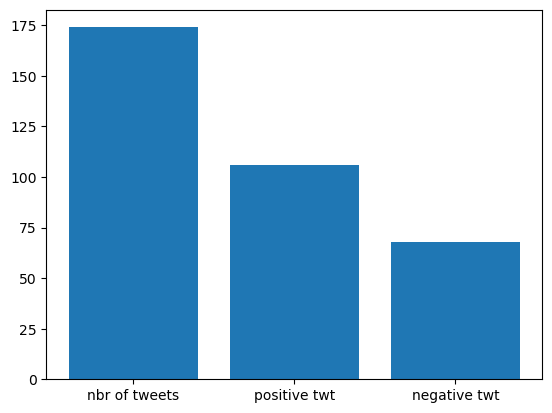

Insert data: [@elonmusk Good shit! Let’s focus on the new @Tesla giga + @SpaceX and grow the great innovations., goldfumed56 ]
nombre of tweets : 175
nombre de positive tweets :  107
nombre de negative tweets  : 68
+-----------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                            |prediction|
+-----------------------------------------------------------------------------------------------------------+----------+
|["[""@elonmusk, good, shit!, let\u2019s, focus, new, @tesla, giga, +, @spacex, grow, great, innovations.""]|4.0       |
+-----------------------------------------------------------------------------------------------------------+----------+



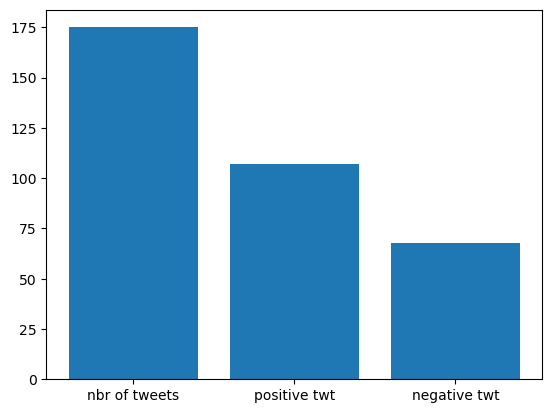

Insert data: [For years Tesla completely dominated EV market in U.S. There are now a wide variety of EVs on market. Something else Musk should have thought about before he fully embraced MAGA as head of Twitter. He has seriously damaged his reputation and Tesla brand.
https://t.co/OJ1F4FA5j3, NickWilliams33 ]
nombre of tweets : 176
nombre de positive tweets :  108
nombre de negative tweets  : 68
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------

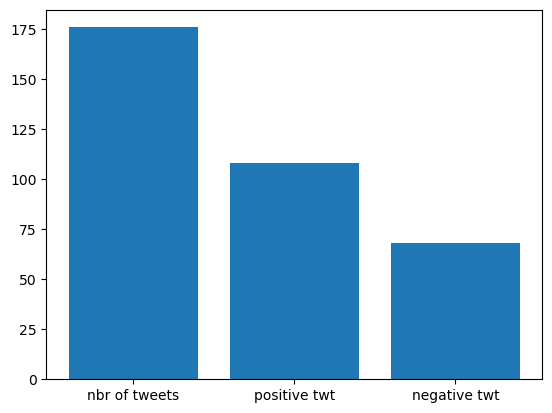

Insert data: [RT @gaps_j: Just imagining him putting the baby in a car seat and setting the Tesla to autopilot to ship it to Grimes like a package with n…, HalvarenNugadog ]
nombre of tweets : 177
nombre de positive tweets :  109
nombre de negative tweets  : 68
+--------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                           |prediction|
+--------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gaps_j:, imagining, putting, baby, car, seat, setting, tesla, autopilot, ship, grimes, like, package, n\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------+----------+



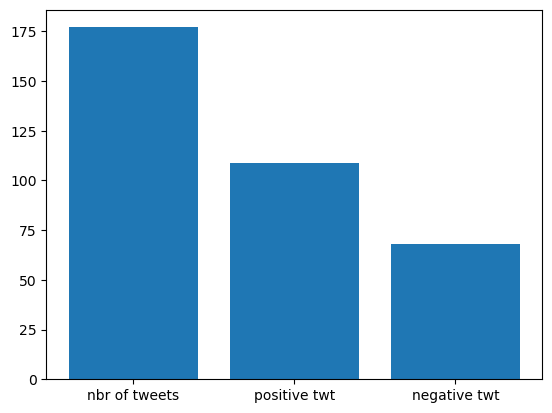

Insert data: [RT @Cryptoking: I wouldn’t bet against #Tesla or #Binance, imanthonypeter ]
nombre of tweets : 178
nombre de positive tweets :  110
nombre de negative tweets  : 68
+--------------------------------------------------------------+----------+
|MeaningfulWords                                               |prediction|
+--------------------------------------------------------------+----------+
|["[""rt, @cryptoking:, wouldn\u2019t, bet, #tesla, #binance""]|4.0       |
+--------------------------------------------------------------+----------+



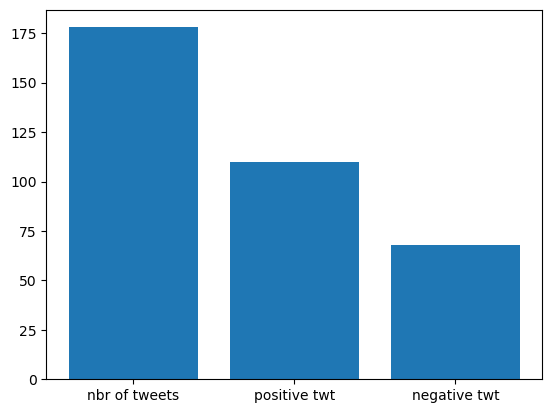

Insert data: [RT @MarceloPLima: Another fun completely unrelated comparison:

$KO EV/EBIT for next 4 quarters 24.4x

$TSLA EV/EBIT 22.6x

Coke expected t…, Juanbg ]
nombre of tweets : 179
nombre de positive tweets :  111
nombre de negative tweets  : 68
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                           |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @marceloplima:, another, fun, completely, unrelated, comparison:\n\n$ko, ev/ebit, next, 4, quarters, 24.4x\n\n$tsla, ev/ebit, 22.6x\n\ncoke, expected, t\u2026""]|4.0       |
+----------

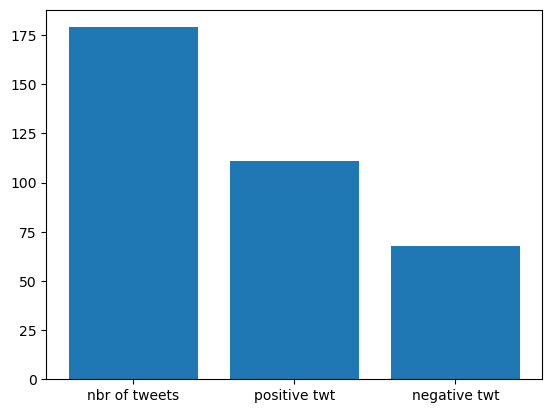

Insert data: [@tomcoates @elonmusk I can’t list the Tesla accomplishments because too many words., LoveChannah50 ]
nombre of tweets : 180
nombre de positive tweets :  112
nombre de negative tweets  : 68
+-------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                      |prediction|
+-------------------------------------------------------------------------------------+----------+
|["[""@tomcoates, @elonmusk, can\u2019t, list, tesla, accomplishments, many, words.""]|4.0       |
+-------------------------------------------------------------------------------------+----------+



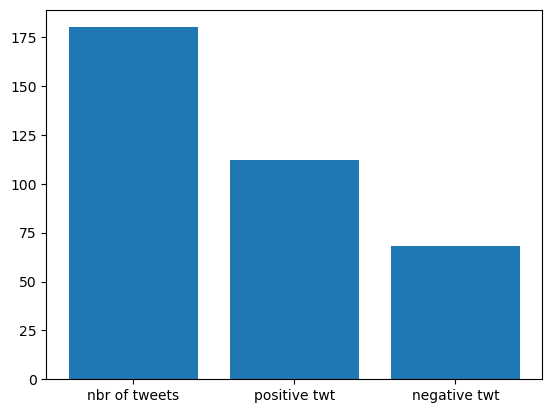

Insert data: [@DirtyD1234 @halfwayshook1 @KenPlaysGames @neiltyson @elonmusk Lol not as much as Tesla, HaleyLamm ]
nombre of tweets : 181
nombre de positive tweets :  112
nombre de negative tweets  : 69
+--------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                             |prediction|
+--------------------------------------------------------------------------------------------+----------+
|["[""@dirtyd1234, @halfwayshook1, @kenplaysgames, @neiltyson, @elonmusk, lol, much, tesla""]|0.0       |
+--------------------------------------------------------------------------------------------+----------+



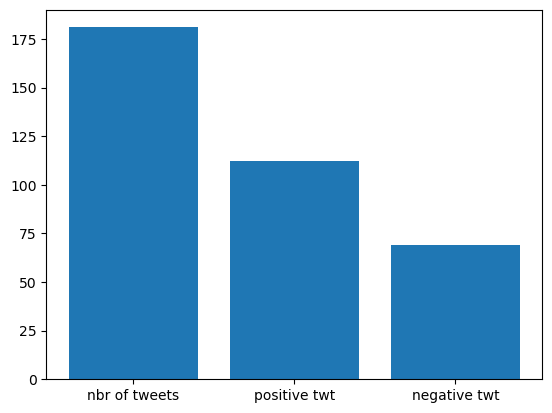

Insert data: [Tesla stock, AllLoadedWords ]
nombre of tweets : 182
nombre de positive tweets :  113
nombre de negative tweets  : 69
+--------------------+----------+
|MeaningfulWords     |prediction|
+--------------------+----------+
|["[""tesla, stock""]|4.0       |
+--------------------+----------+



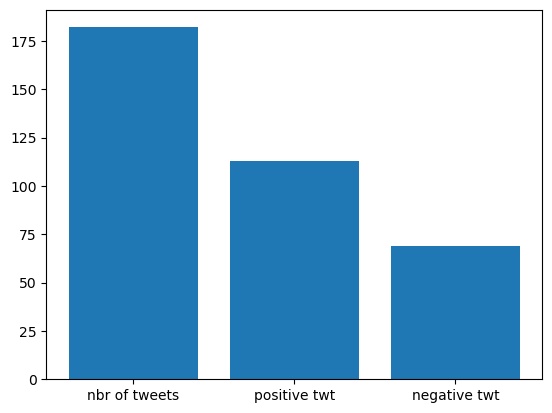

Insert data: [https://t.co/SHqdpbxsro : 1e099601-aeee-4a49-b879-9a589489d29f, test5f1798 ]
nombre of tweets : 183
nombre de positive tweets :  113
nombre de negative tweets  : 70
+------------------------------------------------------------------------+----------+
|MeaningfulWords                                                         |prediction|
+------------------------------------------------------------------------+----------+
|["[""https://t.co/shqdpbxsro, :, 1e099601-aeee-4a49-b879-9a589489d29f""]|0.0       |
+------------------------------------------------------------------------+----------+



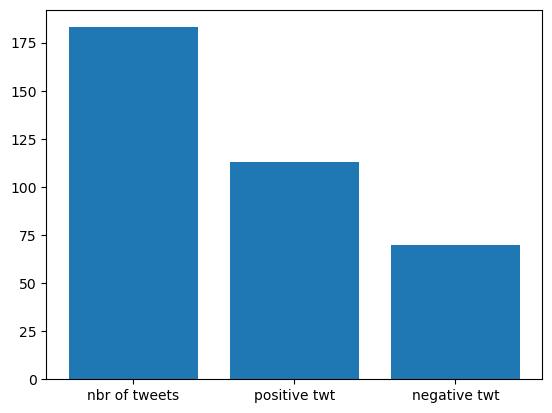

Insert data: [@WR4NYGov Tesla stock price is down because a lot of people and algo’s are willing to sell at lower prices. That’s it. Probably a lot of forced liquidations due to margin use. When the sentiment changes the FOMO the opposite will be true., vcdxnz001 ]
nombre of tweets : 184
nombre de positive tweets :  113
nombre de negative tweets  : 71
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                     |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

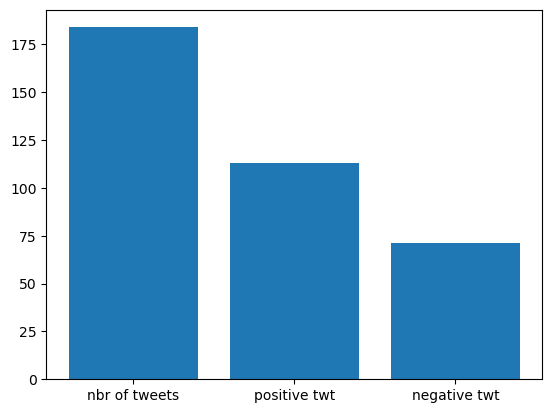

Insert data: [@elonmusk And why not just run SpaceX and Tesla - they seem to be much more high value to humanity than a social network., rchmielarz ]
nombre of tweets : 185
nombre de positive tweets :  113
nombre de negative tweets  : 72
+---------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                              |prediction|
+---------------------------------------------------------------------------------------------+----------+
|["[""@elonmusk, run, spacex, tesla, -, seem, much, high, value, humanity, social, network.""]|0.0       |
+---------------------------------------------------------------------------------------------+----------+



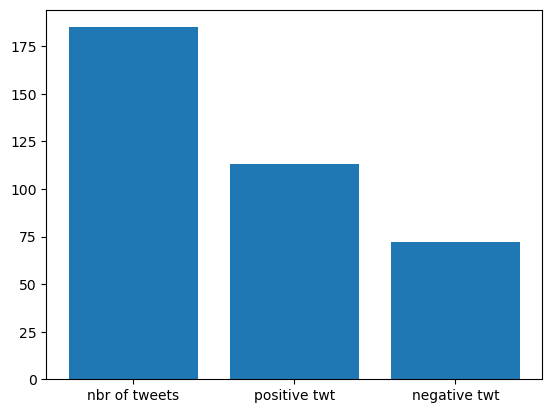

Insert data: [@stevenmarkryan Happy holidays to Tesla long termers, the gift that keeps on giving, just wish I had more cash to buy more shares, dricky2011 ]
nombre of tweets : 186
nombre de positive tweets :  114
nombre de negative tweets  : 72
+------------------------------------------------------------+----------+
|MeaningfulWords                                             |prediction|
+------------------------------------------------------------+----------+
|["[""@stevenmarkryan, happy, holidays, tesla, long, termers]|4.0       |
+------------------------------------------------------------+----------+



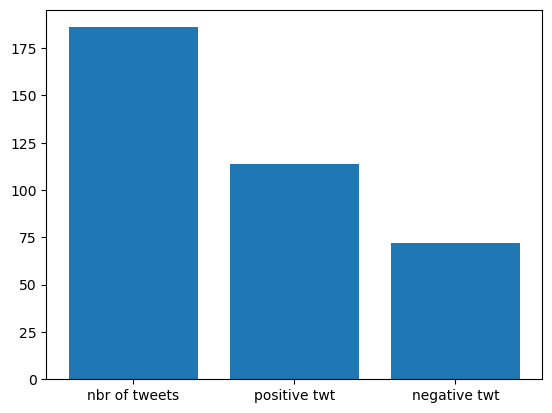

Insert data: [RT @steinkobbe: Elon is now publicly arguing with Tesla stockholders who are begging him to stop shitposting and get to work https://t.co/1…, EyeKeepWalkin ]
nombre of tweets : 187
nombre de positive tweets :  114
nombre de negative tweets  : 73
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @steinkobbe:, elon, publicly, arguing, tesla, stockholders, begging, stop, shitposting, get, work, https://t.co/1\u2026""]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



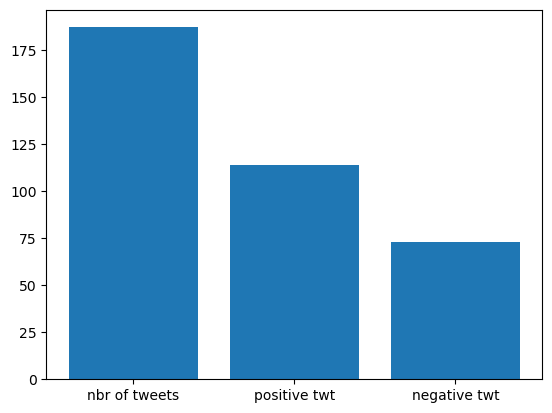

Insert data: [RT @PeterRHann1: Hey @elonmusk, I know I joke around with you, but seriously, you should examine #HYMC Hycroft Mining. It's a silver &amp; gold…, ShamondaFirven ]
nombre of tweets : 188
nombre de positive tweets :  115
nombre de negative tweets  : 73
+---------------------------------------+----------+
|MeaningfulWords                        |prediction|
+---------------------------------------+----------+
|["[""rt, @peterrhann1:, hey, @elonmusk]|4.0       |
+---------------------------------------+----------+



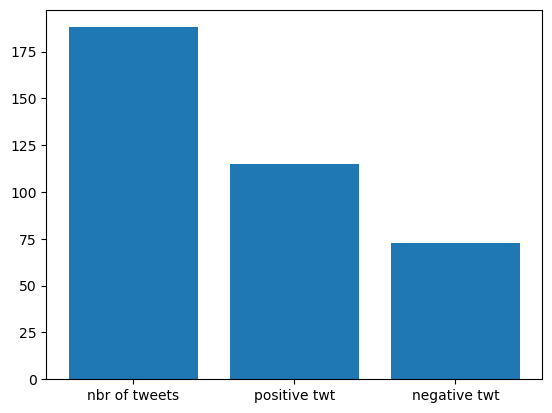

Insert data: [@aspeckofsalt @elonmusk @Teslaconomics @Tesla @teslaownersSV @teslaherbert I'm going to twitter blue myself and bring all of my followers to twitter.  Just because someone has many followers or is hosting a space, it doesn't give them the right to talk down to others. That includes a lot of people., snapchatrabbit ]
nombre of tweets : 189
nombre de positive tweets :  116
nombre de negative tweets  : 73
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|

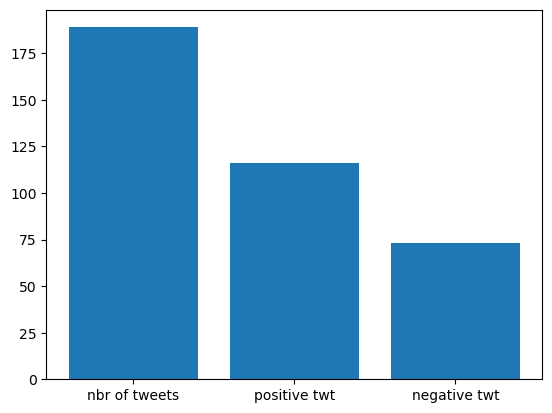

Insert data: [RT @nancylevine: Elon is now feuding on Twitter with one of Tesla’s largest investors. This won’t end well for Musk. $TSLA #CORPGOV https:/…, MonicaRivpin ]
nombre of tweets : 190
nombre de positive tweets :  117
nombre de negative tweets  : 73
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @nancylevine:, elon, feuding, twitter, one, tesla\u2019s, largest, investors., won\u2019t, end, well, musk., $tsla, #corpgov, https:/\u2026""]|4.0       |
+--------------------------------------------------------------------------------

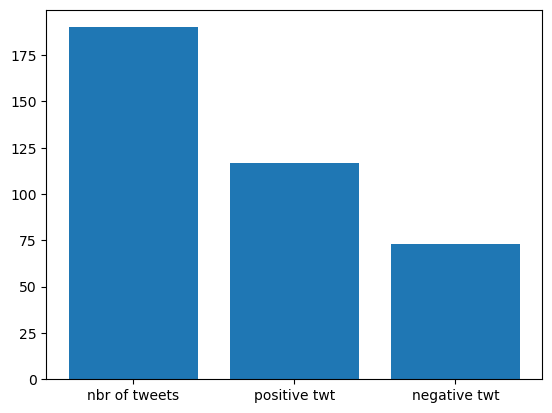

Insert data: [Jako většinou Tesla : moc lží a pak realita https://t.co/rBTaMIHvrg, solomonroubicek ]
nombre of tweets : 191
nombre de positive tweets :  118
nombre de negative tweets  : 73
+-----------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|["[""jako, v\u011bt\u0161inou, tesla, :, moc, l\u017e\u00ed, pak, realita, https://t.co/rbtamihvrg""]|4.0       |
+-----------------------------------------------------------------------------------------------------+----------+



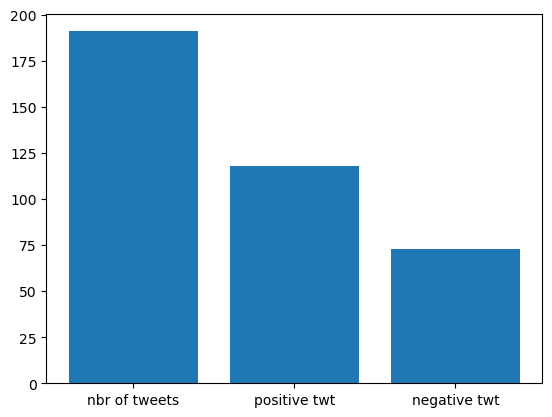

Insert data: [@yabbietol @natecochrane Not crashing is safe. Tesla's reputation not great there, though that's Musk overpromising. I worked alongside carmakers for years. You just can't build institutional knowledge about SRS, crumple zones etc overnight IMO. That's another reason I'm cool on the brand. Again, my 2c, Wattsburger ]
nombre of tweets : 192
nombre de positive tweets :  118
nombre de negative tweets  : 74
+----------------------------------------------------------------------------+----------+
|MeaningfulWords                                                             |prediction|
+----------------------------------------------------------------------------+----------+
|["[""@yabbietol, @natecochrane, crashing, safe., tesla's, reputation, great]|0.0       |
+----------------------------------------------------------------------------+----------+



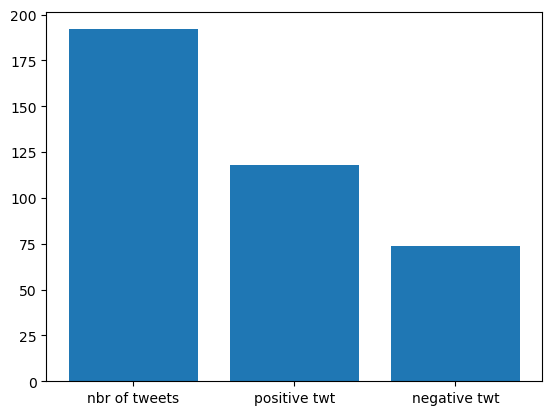

Insert data: [RT @BMeiselas: Apple should totally buy Tesla. If anyone can do it, it's them. They can boot Elon and quickly become industry leaders in th…, Nanocyborgasm ]
nombre of tweets : 193
nombre de positive tweets :  119
nombre de negative tweets  : 74
+----------------------------------------------------------+----------+
|MeaningfulWords                                           |prediction|
+----------------------------------------------------------+----------+
|["[""rt, @bmeiselas:, apple, totally, buy, tesla., anyone]|4.0       |
+----------------------------------------------------------+----------+



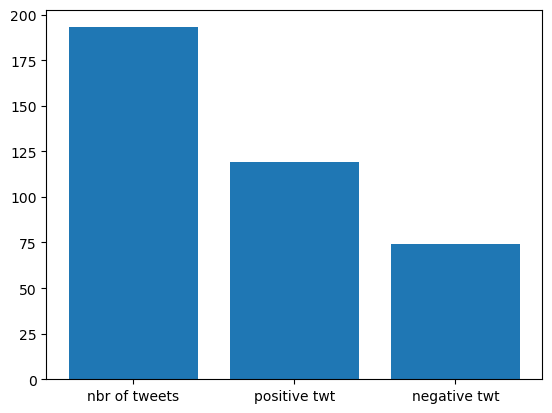

Insert data: [RT @EpsilonTheory: It's so weird that the macroeconomic environment has impacted Tesla (-41%) and not Ford (+1%) or GM (+8%) over the past…, deep_liquidityy ]
nombre of tweets : 194
nombre de positive tweets :  120
nombre de negative tweets  : 74
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @epsilontheory:, weird, macroeconomic, environment, impacted, tesla, (-41%), ford, (+1%), gm, (+8%), past\u2026""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------+----------+



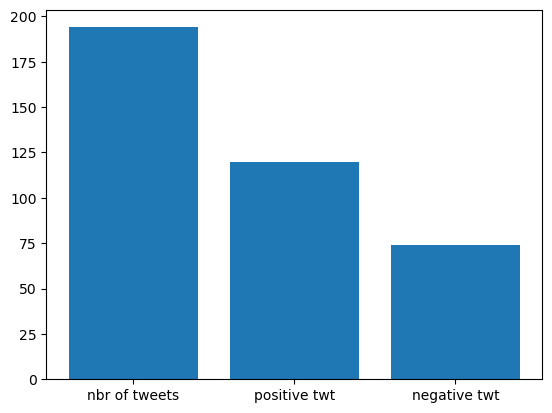

Insert data: [RT @Tesla: Or a cyclist: https://t.co/CGH44L9Vbo, purevdo27046751 ]
nombre of tweets : 195
nombre de positive tweets :  120
nombre de negative tweets  : 75
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""rt, @tesla:, cyclist:, https://t.co/cgh44l9vbo""]|0.0       |
+------------------------------------------------------+----------+



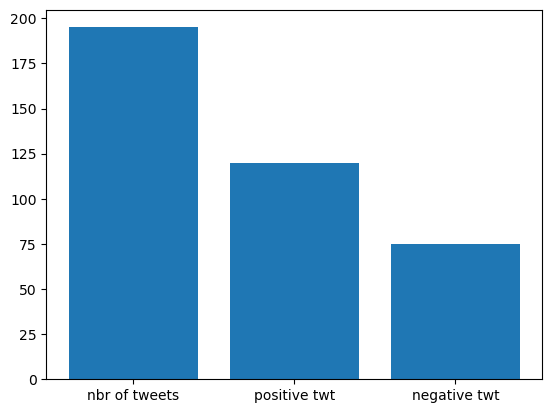

Insert data: [@SenWarren @Twitter @Tesla Maybe you should get a business (or perhaps a life) and stop throwing shade at people that actually accomplished something!, MarkEJordan1 ]
nombre of tweets : 196
nombre de positive tweets :  121
nombre de negative tweets  : 75
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, maybe, get, business, (or, perhaps, life), stop, throwing, shade, people, actually, accomplished, something!""]|4.0       |
+------------------------------------------------------------------------------------------

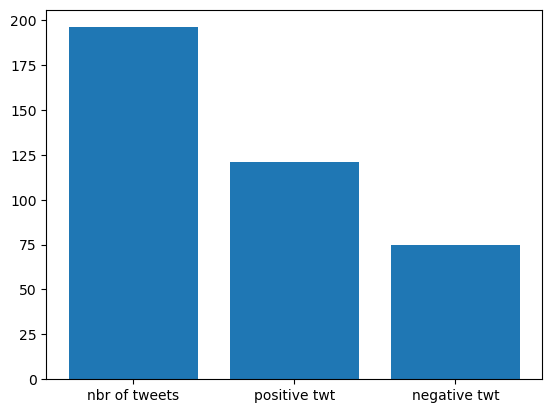

Insert data: [@teslacommander @stevenmarkryan @j_grieshaber @heydave7 @elonmusk Nobody told you to. Elon’s selling his own shares. Not using Tesla’s corporate treasuries, plebdothodl ]
nombre of tweets : 197
nombre de positive tweets :  122
nombre de negative tweets  : 75
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@teslacommander, @stevenmarkryan, @j_grieshaber, @heydave7, @elonmusk, nobody, told, to., elon\u2019s, selling, shares., using, tesla\u2019s, corporate, treasuries""]

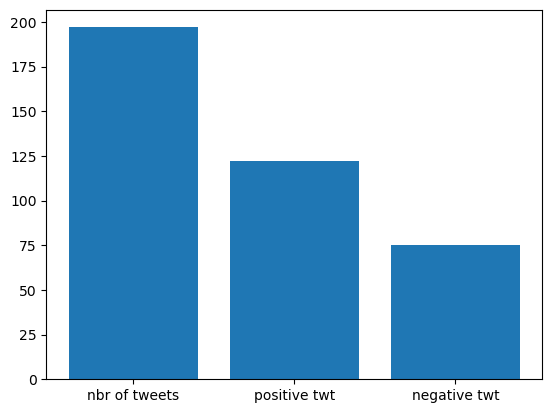

Insert data: [RT @AshrafAriff: Habislah aku. Nanti Elon Musk langgar aku dengan Tesla. 😭☀️🥲 https://t.co/8UpflP1zuy, __bonezz ]
nombre of tweets : 198
nombre de positive tweets :  122
nombre de negative tweets  : 76
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @ashrafariff:, habislah, aku., nanti, elon, musk, langgar, aku, dengan, tesla., \ud83d\ude2d\u2600\ufe0f\ud83e\udd72, https://t.co/8upflp1zuy""]|0.0       |
+-------------------------------------------------------------------------------------------------------------------

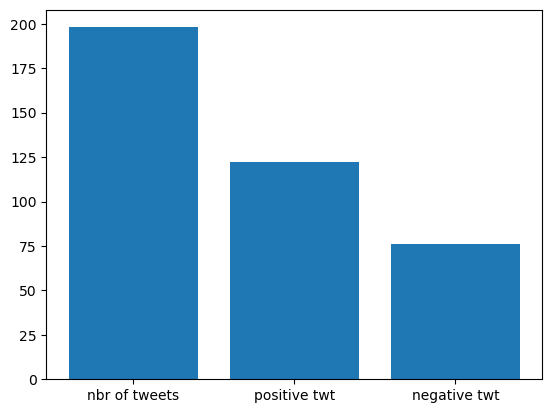

Insert data: [@RonHare4Real @MathiasMoessner @elonmusk He didn't create Tesla, the dude just shitposts all day. No one voted for him. No one actually cares what he thinks. His non-twitter biz just leech off gov funds. It's honestly kinda sad to see him LARPing like he contributes to the world positively., evirae ]
nombre of tweets : 199
nombre de positive tweets :  123
nombre de negative tweets  : 76
+---------------------------------------------------------------+----------+
|MeaningfulWords                                                |prediction|
+---------------------------------------------------------------+----------+
|["[""@ronhare4real, @mathiasmoessner, @elonmusk, create, tesla]|4.0       |
+---------------------------------------------------------------+----------+



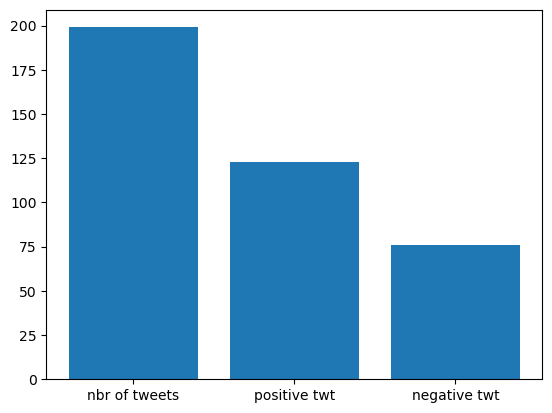

Insert data: [RT @ricochicomico1: Ive made this harder on elon the whole way by being so angry and effectively derisive, schizo anon incel not caring, th…, TheIncelBotUk ]
nombre of tweets : 200
nombre de positive tweets :  123
nombre de negative tweets  : 77
+---------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                              |prediction|
+---------------------------------------------------------------------------------------------+----------+
|["[""rt, @ricochicomico1:, ive, made, harder, elon, whole, way, angry, effectively, derisive]|0.0       |
+---------------------------------------------------------------------------------------------+----------+



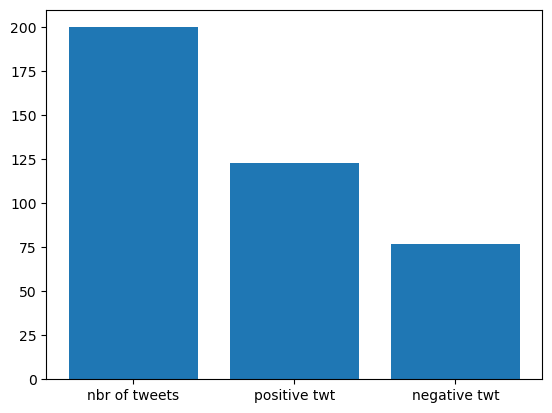

Insert data: [RT @MSNBC: Journalist who has been covering Elon Musk since 2018: What we're seeing at Twitter, we saw at Tesla. https://t.co/5T5WvR3bDx, YuriRiv02558750 ]
nombre of tweets : 201
nombre de positive tweets :  124
nombre de negative tweets  : 77
+----------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                   |prediction|
+----------------------------------------------------------------------------------+----------+
|["[""rt, @msnbc:, journalist, covering, elon, musk, since, 2018:, seeing, twitter]|4.0       |
+----------------------------------------------------------------------------------+----------+



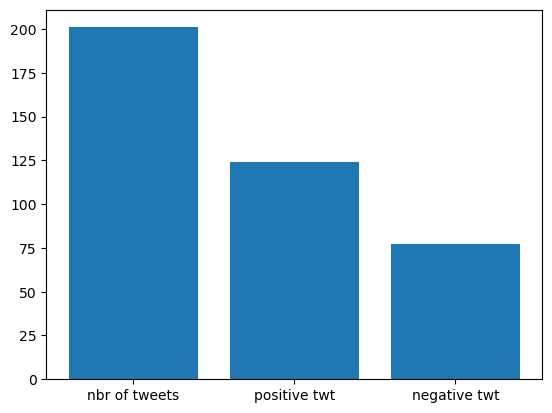

Insert data: [@jessiegender Not to mention horrible build quality on Tesla’s. As in, uneven gaps between panels, poor paint jobs that don’t fully cover the car. If the regular car battery dies (not the ones that power the motors) the entire car is dead and can’t get into it!, Swandraga ]
nombre of tweets : 202
nombre de positive tweets :  124
nombre de negative tweets  : 78
+---------------------------------------------------------------------+----------+
|MeaningfulWords                                                      |prediction|
+---------------------------------------------------------------------+----------+
|["[""@jessiegender, mention, horrible, build, quality, tesla\u2019s.]|0.0       |
+---------------------------------------------------------------------+----------+



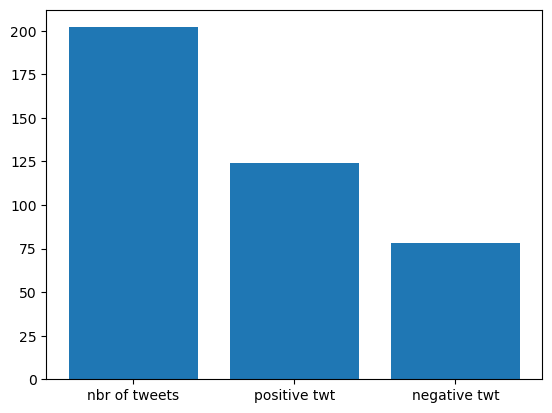

Insert data: [@kchau @elonmusk @heydave7 He raised Tesla from scratch xD., Aiteee1 ]
nombre of tweets : 203
nombre de positive tweets :  125
nombre de negative tweets  : 78
+-----------------------------------------------------------------+----------+
|MeaningfulWords                                                  |prediction|
+-----------------------------------------------------------------+----------+
|["[""@kchau, @elonmusk, @heydave7, raised, tesla, scratch, xd.""]|4.0       |
+-----------------------------------------------------------------+----------+



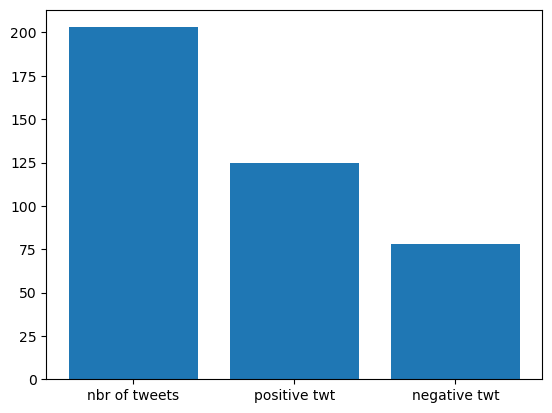

Insert data: [RT @alfredo_patrol: @JayPatel0101_ @KenPlaysGames @neiltyson @elonmusk So, you’re saying that his major contributions were:
-owning Tesla w…, Forsagebone ]
nombre of tweets : 204
nombre de positive tweets :  125
nombre de negative tweets  : 79
+---------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                  |prediction|
+---------------------------------------------------------------------------------+----------+
|["[""rt, @alfredo_patrol:, @jaypatel0101_, @kenplaysgames, @neiltyson, @elonmusk]|0.0       |
+---------------------------------------------------------------------------------+----------+



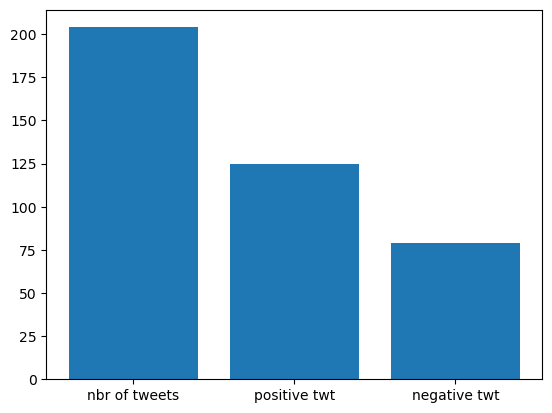

Insert data: [RT @wineandances: Elon Musk is performing Hara Kiri right before our very eyes.

Tesla is dying. Twitter is dead. And Mars can’t be reached…, Maura_Junius ]
nombre of tweets : 205
nombre de positive tweets :  125
nombre de negative tweets  : 80
+----------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                               |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @wineandances:, elon, musk, performing, hara, kiri, right, eyes.\n\ntesla, dying., twitter, dead., mars, can\u2019t, reached\u2026""]|0.0       |
+--------------------------------------------------------------------------------------------------------------------

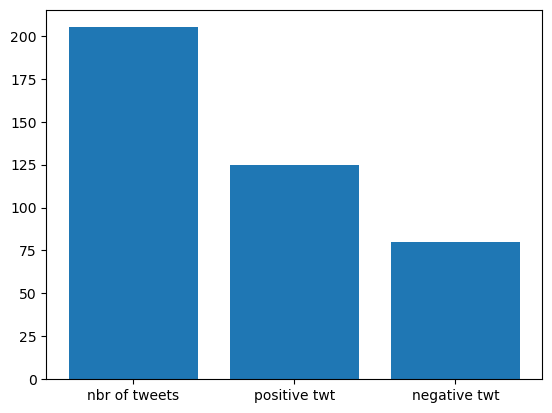

Insert data: [@spideycyp_155 @elonmusk @SpaceX @Tesla @teslaownersSV @mayemusk Great!!, Kristennetten ]
nombre of tweets : 206
nombre de positive tweets :  126
nombre de negative tweets  : 80
+--------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                       |prediction|
+--------------------------------------------------------------------------------------+----------+
|["[""@spideycyp_155, @elonmusk, @spacex, @tesla, @teslaownerssv, @mayemusk, great!!""]|4.0       |
+--------------------------------------------------------------------------------------+----------+



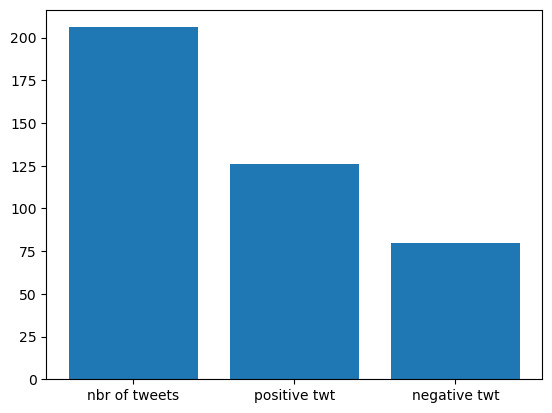

Insert data: [Nachdem eine öffentliche Umfrage zu seinen Ungunsten ausgegangen war, kündigte @ElonMusk nun seinen Rücktritt als #Twitter-Chef an.
https://t.co/IA44H4Ppn5, btcecho ]
nombre of tweets : 207
nombre de positive tweets :  127
nombre de negative tweets  : 80
+---------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                        |prediction|
+---------------------------------------------------------------------------------------+----------+
|["[""nachdem, eine, \u00f6ffentliche, umfrage, zu, seinen, ungunsten, ausgegangen, war]|4.0       |
+---------------------------------------------------------------------------------------+----------+



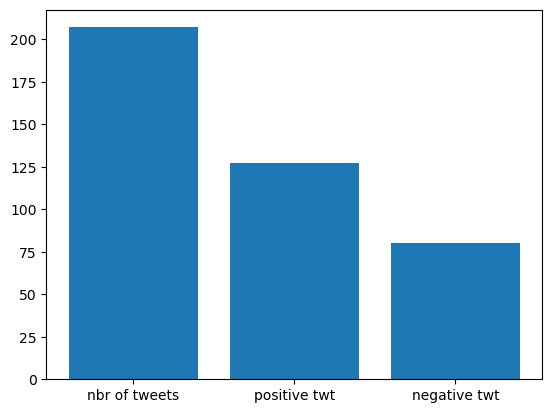

Insert data: [The Tesla billionaire was “actively searching” for a new Twitter boss on Tuesday, CNBC reported, despite having made comments that cast doubt over whether he was prepared to step down., MY21_Oracle ]
nombre of tweets : 208
nombre de positive tweets :  128
nombre de negative tweets  : 80
+-------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                            |prediction|
+-------------------------------------------------------------------------------------------+----------+
|["[""the, tesla, billionaire, \u201cactively, searching\u201d, new, twitter, boss, tuesday]|4.0       |
+-------------------------------------------------------------------------------------------+----------+



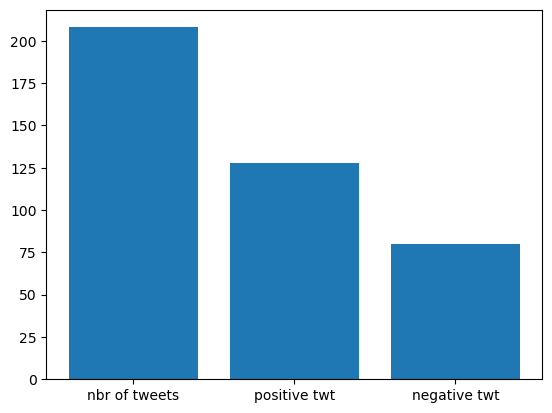

Insert data: [RT @Tesla: Well, do better if you need us to tell you to tell your mom Happy Mother’s Day at all.

Not if you tell them or not tell them th…, purevdo27046751 ]
nombre of tweets : 209
nombre de positive tweets :  129
nombre de negative tweets  : 80
+-----------------------+----------+
|MeaningfulWords        |prediction|
+-----------------------+----------+
|["[""rt, @tesla:, well]|4.0       |
+-----------------------+----------+



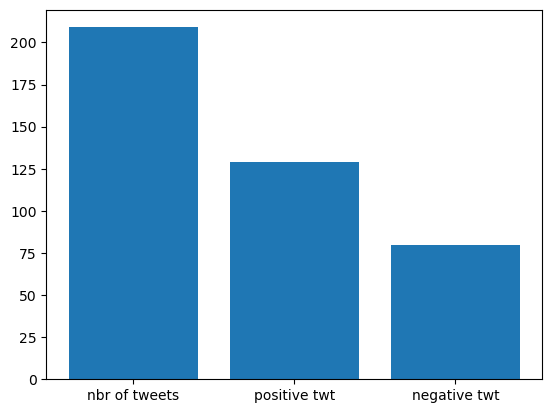

Insert data: [RT @Tesla: Happy Mother’s Day, please tell your mothers that Tesla wishes them a happy mother’s day

#HappyMothersDay, purevdo27046751 ]
nombre of tweets : 210
nombre de positive tweets :  130
nombre de negative tweets  : 80
+--------------------------------------------+----------+
|MeaningfulWords                             |prediction|
+--------------------------------------------+----------+
|["[""rt, @tesla:, happy, mother\u2019s, day]|4.0       |
+--------------------------------------------+----------+



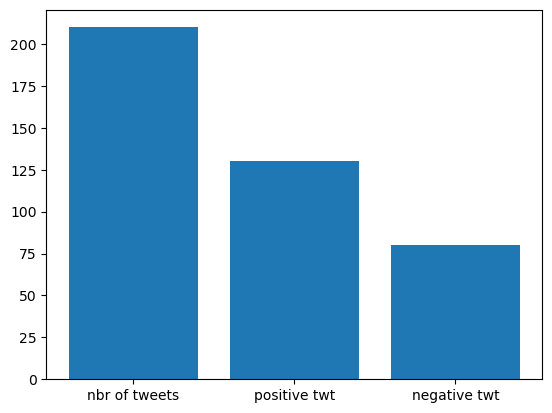

Insert data: [🌐 El mejor inventor: ¿Nikola Tesla o Thomas Edison? https://t.co/o5JRc1C71n, TuiterPro ]
nombre of tweets : 211
nombre de positive tweets :  131
nombre de negative tweets  : 80
+------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------+----------+
|[["ud83cudf10, el, mejor, inventor:, u00bfnikola, tesla, o, thomas, edison?, https://t.co/o5jrc1c71n"]|4.0       |
+------------------------------------------------------------------------------------------------------+----------+



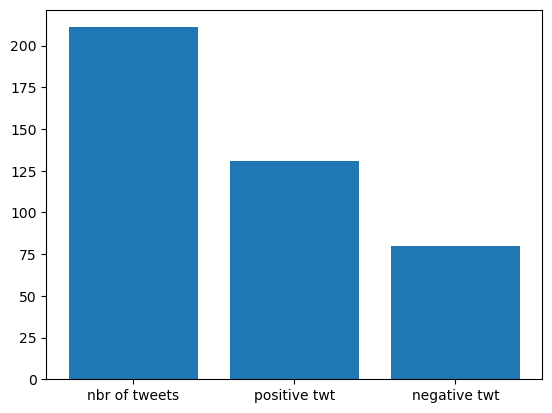

Insert data: [RT @ChrisDJackson: @elonmusk Which comes first? You step down as Twitter CEO or the Tesla BOD removes you as their CEO? https://t.co/Ci1MDG…, infoquestions ]
nombre of tweets : 212
nombre de positive tweets :  132
nombre de negative tweets  : 80
+-------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                |prediction|
+-------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @chrisdjackson:, @elonmusk, comes, first?, step, twitter, ceo, tesla, bod, removes, ceo?, https://t.co/ci1mdg\u2026""]|4.0       |
+-------------------------------------------------------------------------------------------------------------------------------+----------+



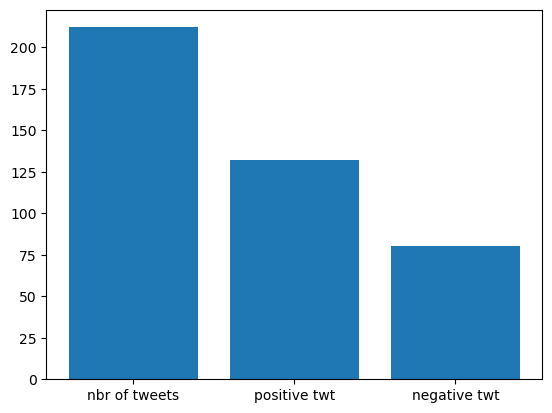

Insert data: [@SenWarren @Twitter @Tesla WHAT HAPPENED TO THE 700 BILLION IN TARP FUNDS YOU STOLE, PStasyna ]
nombre of tweets : 213
nombre de positive tweets :  132
nombre de negative tweets  : 81
+--------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                 |prediction|
+--------------------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, happened, 700, billion, tarp, funds, stole""]|0.0       |
+--------------------------------------------------------------------------------+----------+



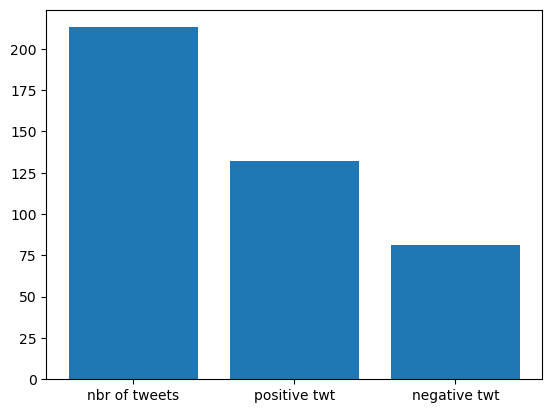

Insert data: [@SenWarren @Twitter @Tesla You need to smokem peace pipe., LindaJamesOK ]
nombre of tweets : 214
nombre de positive tweets :  132
nombre de negative tweets  : 82
+----------------------------------------------------------------+----------+
|MeaningfulWords                                                 |prediction|
+----------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, need, smokem, peace, pipe.""]|0.0       |
+----------------------------------------------------------------+----------+



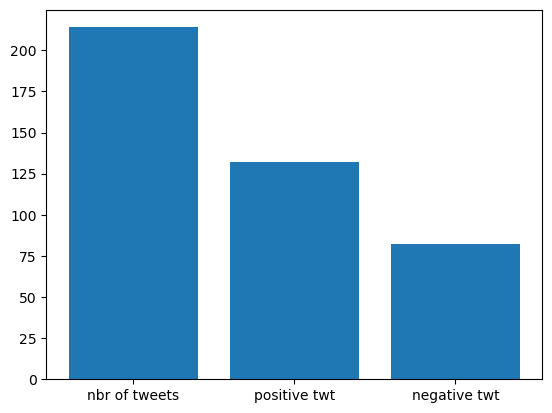

Insert data: [@Reptolord Ne ne, die gesamte Techbranche ist im Abwärtssog. 
Da steht Tesla mit 145€ noch gut da., Forexus1 ]
nombre of tweets : 215
nombre de positive tweets :  132
nombre de negative tweets  : 83
+------------------------+----------+
|MeaningfulWords         |prediction|
+------------------------+----------+
|["[""@reptolord, ne, ne]|0.0       |
+------------------------+----------+



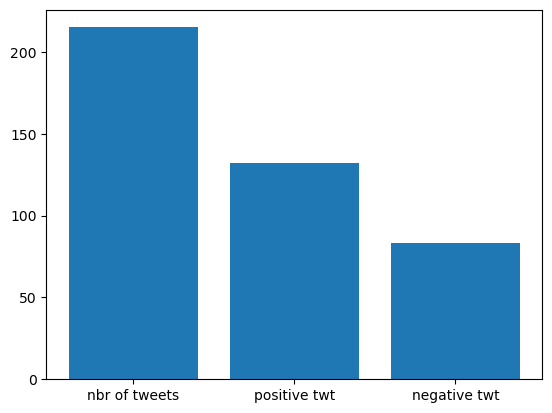

Insert data: [Le premier client du camion Tesla Semi joue la prudence https://t.co/aLBM8CffgA, GrgDesTwittos ]
nombre of tweets : 216
nombre de positive tweets :  133
nombre de negative tweets  : 83
+-------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                  |prediction|
+-------------------------------------------------------------------------------------------------+----------+
|["[""le, premier, client, du, camion, tesla, semi, joue, la, prudence, https://t.co/albm8cffga""]|4.0       |
+-------------------------------------------------------------------------------------------------+----------+



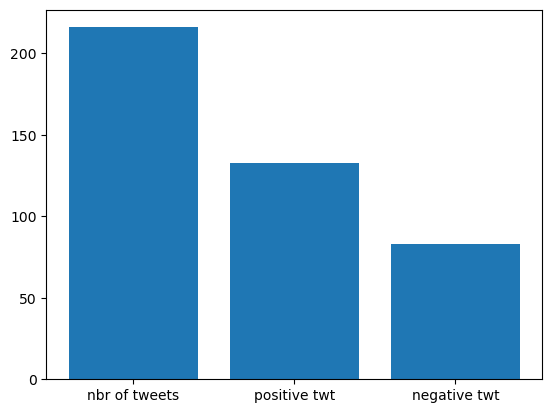

Insert data: [RT @nberlat@mas.to
be fun to watch tesla crash again/more when investors realize musk isn't going to step down. (if he doesn't.)
https://t.co/t6Jrf2xNrs, kam0n0hashi42 ]
nombre of tweets : 217
nombre de positive tweets :  134
nombre de negative tweets  : 83
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                             |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @nberlat@mas.to\nbe, fun, watch, tesla, crash, again/more, investors, realize, musk, going, step, down., (if, doesn't.)\nhttps://t.co/t6jrf2xnrs""]|4.0       |
+-----------------------------------------------

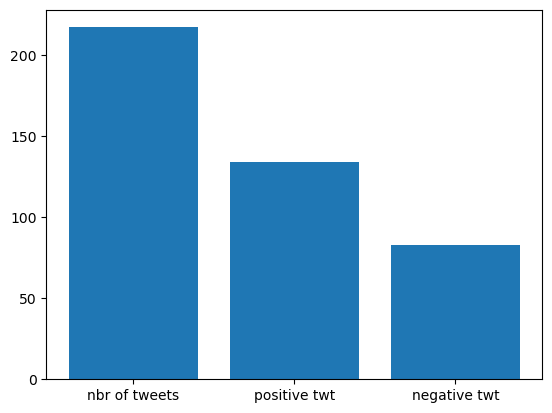

Insert data: [@goldseek I don't think he can announce that. Even if Tesla already has a good stock, it will need to buy more, stevero40104467 ]
nombre of tweets : 218
nombre de positive tweets :  135
nombre de negative tweets  : 83
+--------------------------------------------------------------------------+----------+
|MeaningfulWords                                                           |prediction|
+--------------------------------------------------------------------------+----------+
|["[""@goldseek, think, announce, that., even, tesla, already, good, stock]|4.0       |
+--------------------------------------------------------------------------+----------+



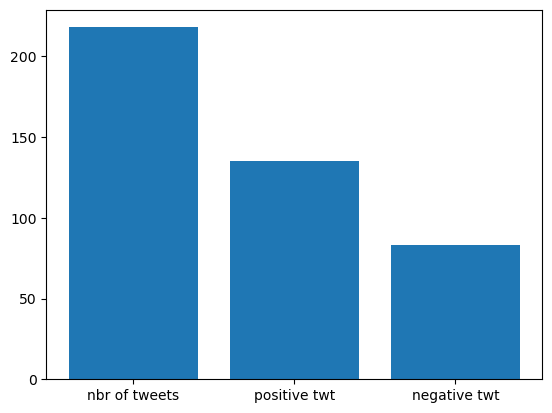

Insert data: [Tunisia Arrests Former PM Over Jihadist Departures - Barron's https://t.co/EjKRnGoMWU, Tunisia_Watch ]
nombre of tweets : 219
nombre de positive tweets :  136
nombre de negative tweets  : 83
+------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                 |prediction|
+------------------------------------------------------------------------------------------------+----------+
|["[""tunisia, arrests, former, pm, jihadist, departures, -, barron's, https://t.co/ejkrngomwu""]|4.0       |
+------------------------------------------------------------------------------------------------+----------+



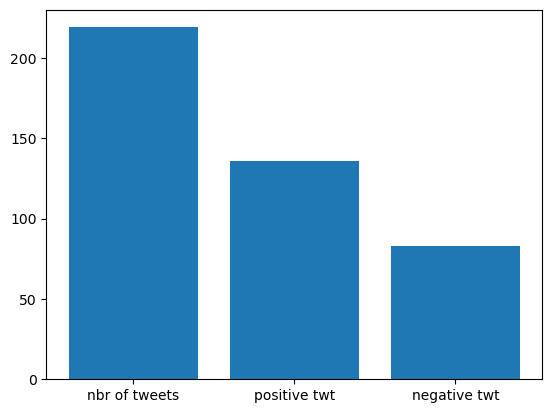

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Emilgug17 ]
nombre of tweets : 220
nombre de positive tweets :  137
nombre de negative tweets  : 83
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+------

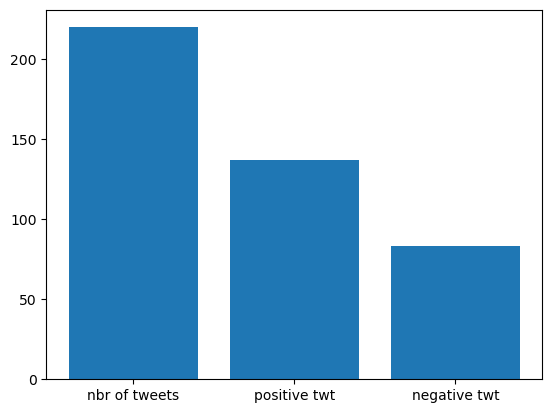

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Roberto59066293 ]
nombre of tweets : 221
nombre de positive tweets :  138
nombre de negative tweets  : 83
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+

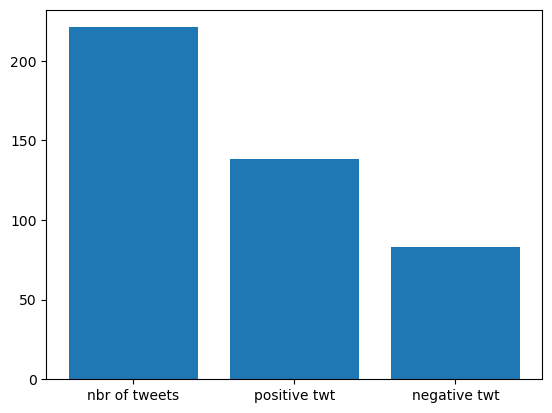

Insert data: [@squawksquare @elonmusk Makes no sense. Image if twitter shareholders should decide Tesla's app features, ahano16 ]
nombre of tweets : 222
nombre de positive tweets :  139
nombre de negative tweets  : 83
+-------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                              |prediction|
+-------------------------------------------------------------------------------------------------------------+----------+
|["[""@squawksquare, @elonmusk, makes, sense., image, twitter, shareholders, decide, tesla's, app, features""]|4.0       |
+-------------------------------------------------------------------------------------------------------------+----------+



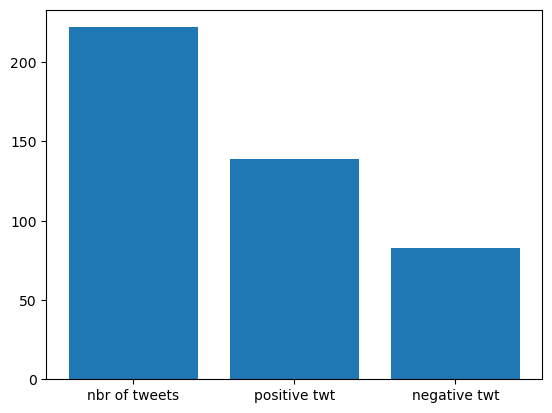

Insert data: [RT @Nash076: I'll tell you exactly why this poll happened:

Tesla broke through its $150 support floor in after hours trading on Friday. It…, RockOlaRaider ]
nombre of tweets : 223
nombre de positive tweets :  140
nombre de negative tweets  : 83
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @nash076:, tell, exactly, poll, happened:\n\ntesla, broke, $150, support, floor, hours, trading, friday., it\u2026""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------------+----------+



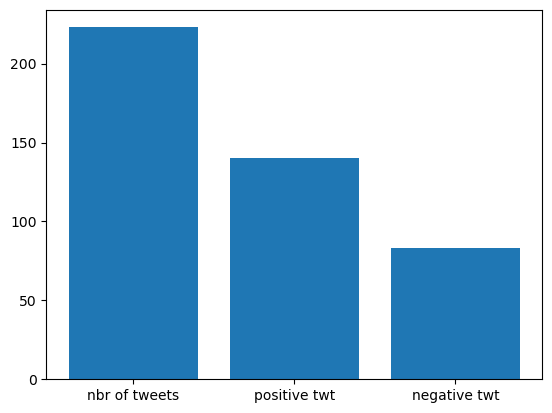

Insert data: [RT @scalzi: As others have noted, he was almost certainly told by his Tesla shareholders that he could play with Twitter or lead Tesla, but…, Michell91181009 ]
nombre of tweets : 224
nombre de positive tweets :  141
nombre de negative tweets  : 83
+---------------------------------+----------+
|MeaningfulWords                  |prediction|
+---------------------------------+----------+
|["[""rt, @scalzi:, others, noted]|4.0       |
+---------------------------------+----------+



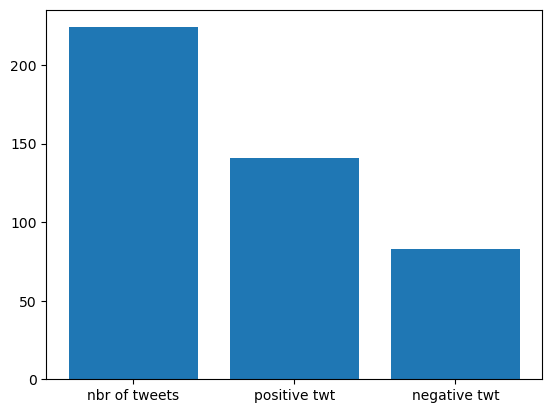

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, ShakilM23487230 ]
nombre of tweets : 225
nombre de positive tweets :  142
nombre de negative tweets  : 83
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+

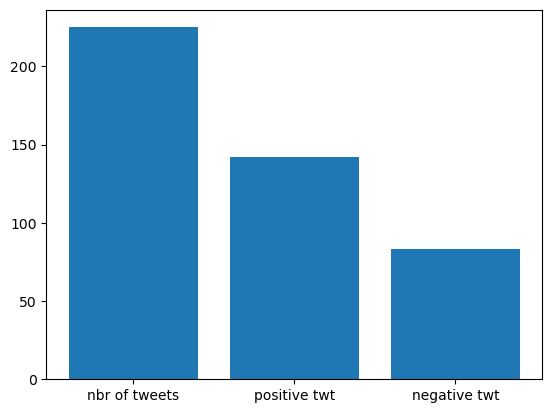

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, Tanvirgsta9Gst ]
nombre of tweets : 226
nombre de positive tweets :  142
nombre de negative tweets  : 84
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------------

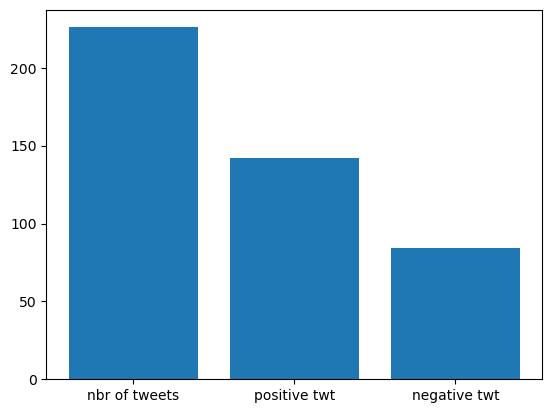

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, ZPZGUD1 ]
nombre of tweets : 227
nombre de positive tweets :  142
nombre de negative tweets  : 85
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+----

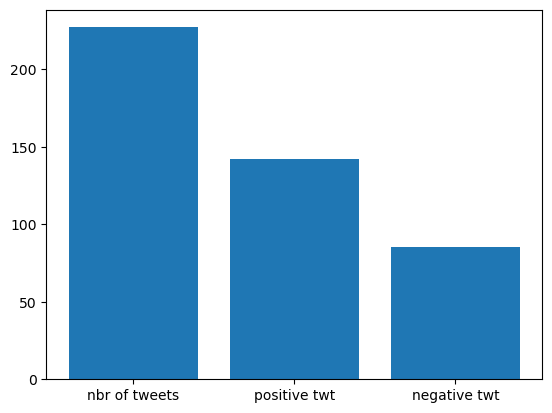

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, TarekAntony ]
nombre of tweets : 228
nombre de positive tweets :  142
nombre de negative tweets  : 86
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+

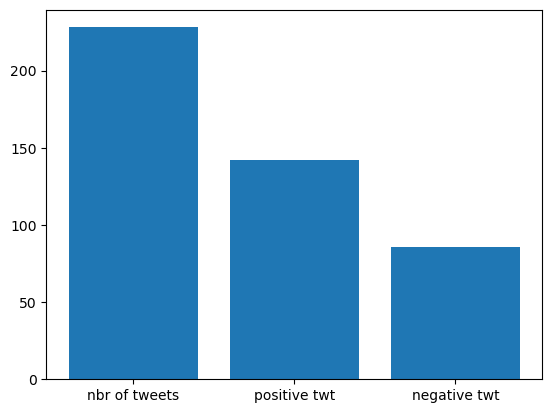

Insert data: [Did everyone forget about @elonmusk promising ventilators? #ClassicMusk #RetroMusk 
https://t.co/xFumboxZPL, mrblackscorpion ]
nombre of tweets : 229
nombre de positive tweets :  143
nombre de negative tweets  : 86
+----------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                       |prediction|
+----------------------------------------------------------------------------------------------------------------------+----------+
|["[""did, everyone, forget, @elonmusk, promising, ventilators?, #classicmusk, #retromusk, \nhttps://t.co/xfumboxzpl""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------+----------+



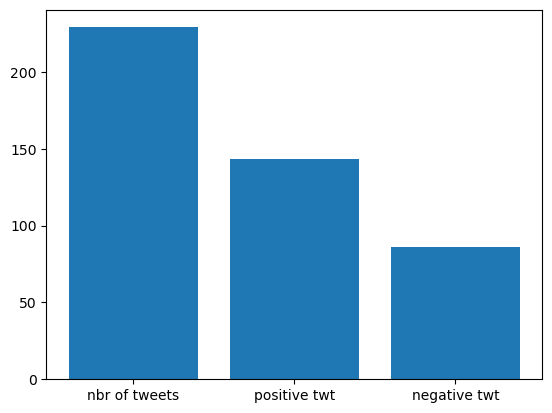

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, PurpleParadadis ]
nombre of tweets : 230
nombre de positive tweets :  143
nombre de negative tweets  : 87
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+--------------------------------------------------------------------------------------------------------------------------------------

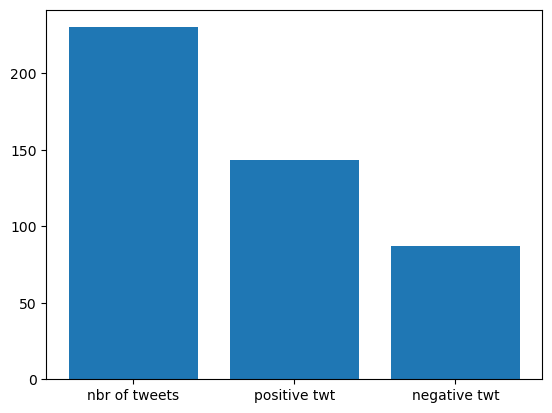

Insert data: [RT @Tesla: Be your own utility with Solar &amp; Powerwall →
https://t.co/e3O2PP5HOd, JrDenatale ]
nombre of tweets : 231
nombre de positive tweets :  144
nombre de negative tweets  : 87
+--------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                       |prediction|
+--------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, utility, solar, &amp;, powerwall, \u2192\nhttps://t.co/e3o2pp5hod""]|4.0       |
+--------------------------------------------------------------------------------------+----------+



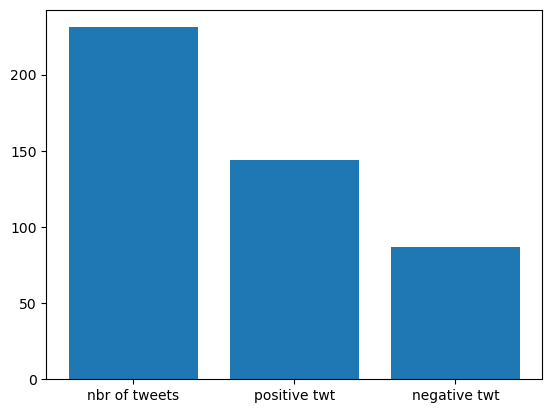

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, ae6678673 ]
nombre of tweets : 232
nombre de positive tweets :  144
nombre de negative tweets  : 88
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------+--

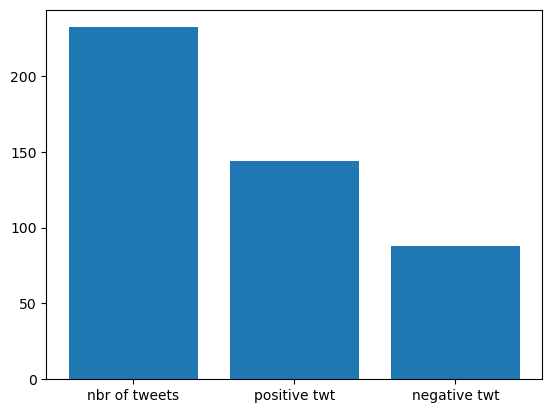

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, JJsec_ ]
nombre of tweets : 233
nombre de positive tweets :  144
nombre de negative tweets  : 89
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+---------

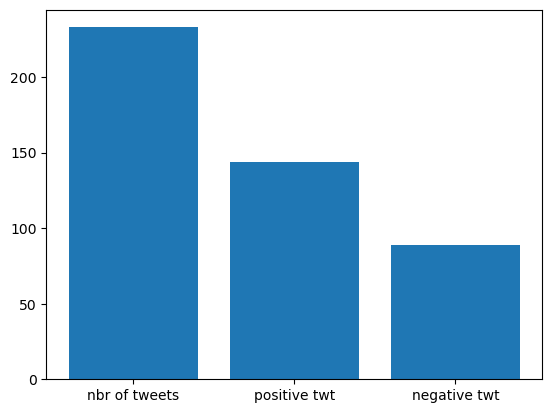

Insert data: [RT @TNR_Gold: #Lithium🔋Investors are piling billions of dollars in the EVs, searching for the next #Tesla. Automakers are investing billion…, Sufiy ]
nombre of tweets : 234
nombre de positive tweets :  144
nombre de negative tweets  : 90
+-----------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                    |prediction|
+-----------------------------------------------------------------------------------+----------+
|["[""rt, @tnr_gold:, #lithium\ud83d\udd0binvestors, piling, billions, dollars, evs]|0.0       |
+-----------------------------------------------------------------------------------+----------+



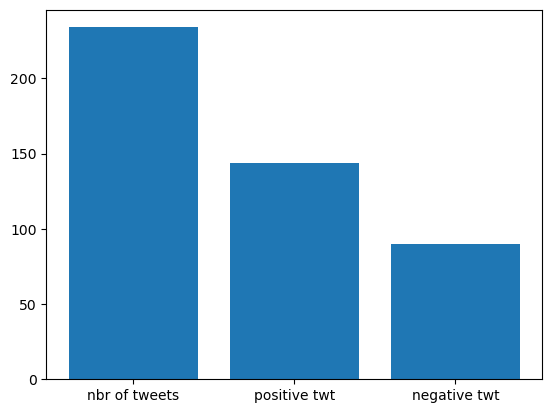

Insert data: [@RandyVegetables @multibagger777 this covers both Tesla potential customers and the rest., gobiggogo ]
nombre of tweets : 235
nombre de positive tweets :  145
nombre de negative tweets  : 90
+-------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                      |prediction|
+-------------------------------------------------------------------------------------+----------+
|["[""@randyvegetables, @multibagger777, covers, tesla, potential, customers, rest.""]|4.0       |
+-------------------------------------------------------------------------------------+----------+



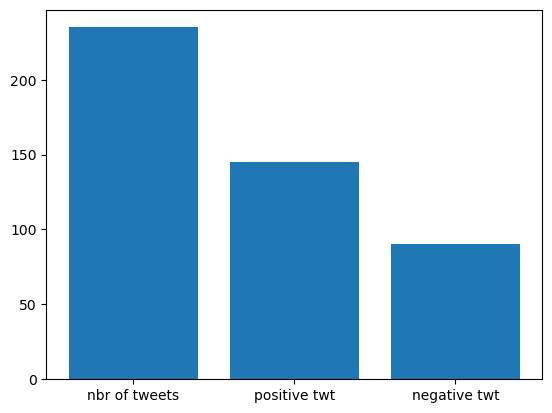

Insert data: [RT @davidtayar5: Evercore ISI lowers Tesla PT to $200

$TSLA, Finance_323 ]
nombre of tweets : 236
nombre de positive tweets :  146
nombre de negative tweets  : 90
+--------------------------------------------------------------------------+----------+
|MeaningfulWords                                                           |prediction|
+--------------------------------------------------------------------------+----------+
|["[""rt, @davidtayar5:, evercore, isi, lowers, tesla, pt, $200\n\n$tsla""]|4.0       |
+--------------------------------------------------------------------------+----------+



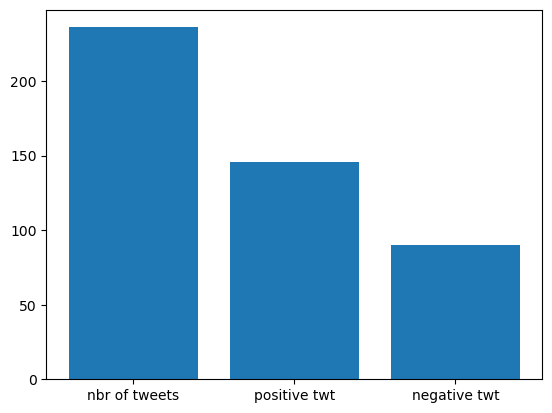

Insert data: [RT @Tesla: We’ve completed 500k+ Solar Panel and Solar Roof installations—that’s equal to ~4 GW of clean energy ☀️ https://t.co/Tjz6PzYuah, MajorScofield ]
nombre of tweets : 237
nombre de positive tweets :  147
nombre de negative tweets  : 90
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                  |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, we\u2019ve, completed, 500k+, solar, panel, solar, roof, installations\u2014that\u2019s, equal, ~4, gw, clean, energy, \u2600\ufe0f, https://t.co/tjz6

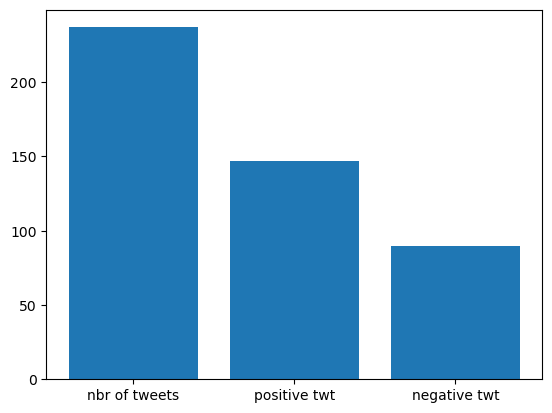

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, lk35328358 ]
nombre of tweets : 238
nombre de positive tweets :  147
nombre de negative tweets  : 91
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-----

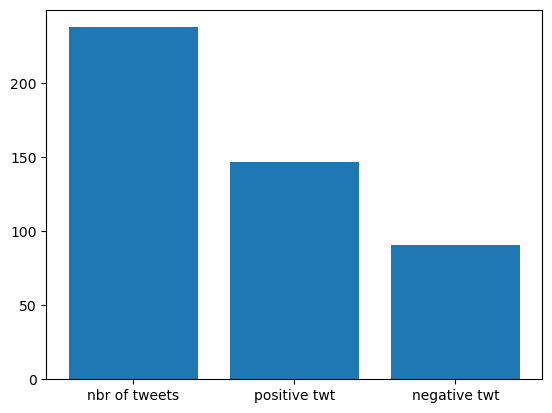

Insert data: [RT @gurgavin: SOMEONE BIG IS GETTING MARGINED CALLED ON TESLA RIGHT NOW $TSLA, ACE52weekhigh ]
nombre of tweets : 239
nombre de positive tweets :  147
nombre de negative tweets  : 92
+------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                     |prediction|
+------------------------------------------------------------------------------------+----------+
|["[""rt, @gurgavin:, someone, big, getting, margined, called, tesla, right, $tsla""]|0.0       |
+------------------------------------------------------------------------------------+----------+



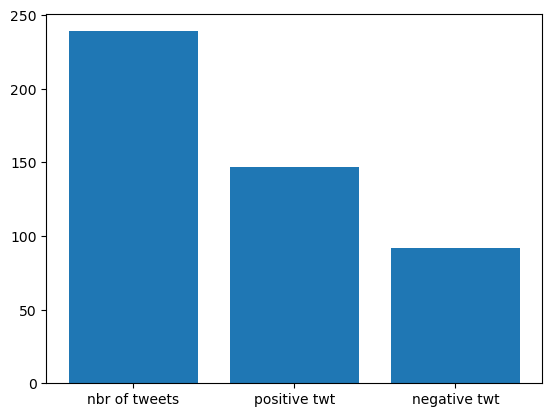

Insert data: [Tesla Competitor Lucid Raises $1.5 Billion, Majority From Saudi Sovereign Wealth Fund https://t.co/J0i1WUO3n2 https://t.co/DowGMUEZeH, OMGStacks ]
nombre of tweets : 240
nombre de positive tweets :  148
nombre de negative tweets  : 92
+-----------------------------------------------------+----------+
|MeaningfulWords                                      |prediction|
+-----------------------------------------------------+----------+
|["[""tesla, competitor, lucid, raises, $1.5, billion]|4.0       |
+-----------------------------------------------------+----------+



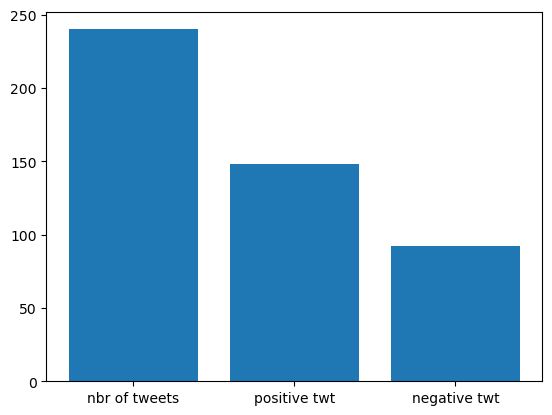

Insert data: [RT @realMeetKevin: During this recession, Ford, GM, and Toyota are all likely to reduce their commitment to electric vehicles in an effort…, pucho611 ]
nombre of tweets : 241
nombre de positive tweets :  148
nombre de negative tweets  : 93
+------------------------------------+----------+
|MeaningfulWords                     |prediction|
+------------------------------------+----------+
|["[""rt, @realmeetkevin:, recession]|0.0       |
+------------------------------------+----------+



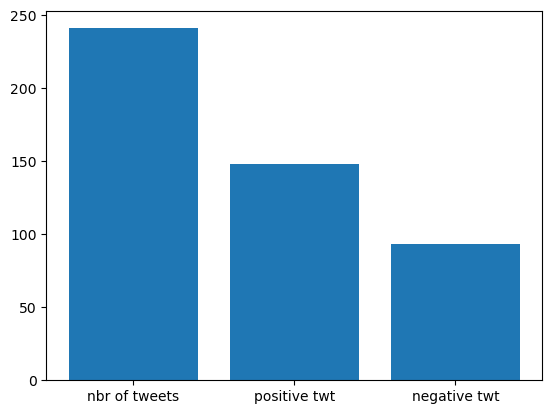

Insert data: [Tesla gets slapped with more cautious comments from Wall Street TSLA $TSLA https://t.co/Zi5ZnkXjWT via @YahooFinance, AlisonBoxxer ]
nombre of tweets : 242
nombre de positive tweets :  149
nombre de negative tweets  : 93
+------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                         |prediction|
+------------------------------------------------------------------------------------------------------------------------+----------+
|["[""tesla, gets, slapped, cautious, comments, wall, street, tsla, $tsla, https://t.co/zi5znkxjwt, via, @yahoofinance""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------+----------+



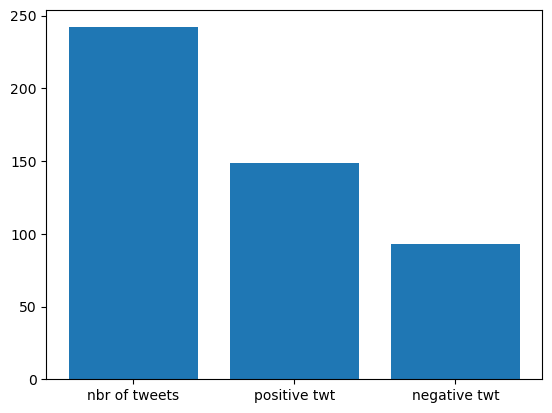

Insert data: [@Rschooley Only #Tesla owners can vote though, GeraltOfPhilly ]
nombre of tweets : 243
nombre de positive tweets :  149
nombre de negative tweets  : 94
+------------------------------------------------+----------+
|MeaningfulWords                                 |prediction|
+------------------------------------------------+----------+
|["[""@rschooley, #tesla, owners, vote, though""]|0.0       |
+------------------------------------------------+----------+



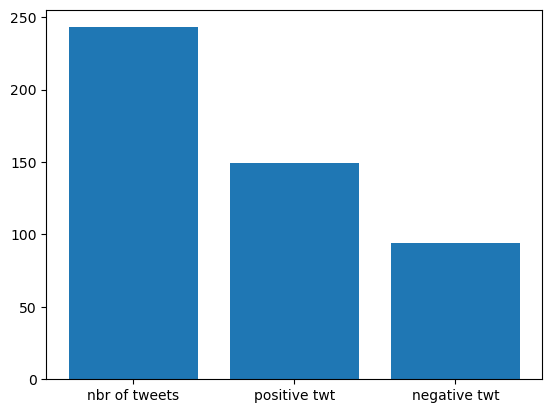

Insert data: [@AcetheKidKT What price y’all like Tesla at for longer term going long?, JohnWickTradez ]
nombre of tweets : 244
nombre de positive tweets :  150
nombre de negative tweets  : 94
+--------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                 |prediction|
+--------------------------------------------------------------------------------+----------+
|["[""@acethekidkt, price, y\u2019all, like, tesla, longer, term, going, long?""]|4.0       |
+--------------------------------------------------------------------------------+----------+



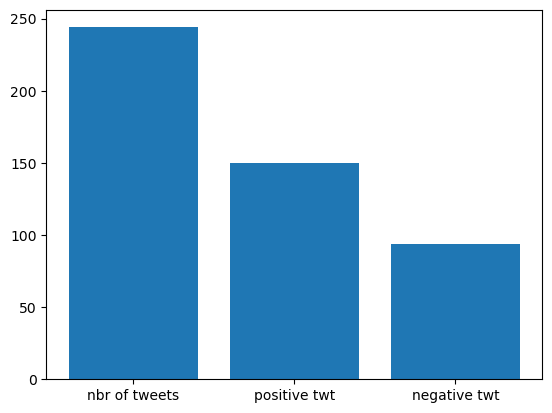

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, okocha_sterling ]
nombre of tweets : 245
nombre de positive tweets :  151
nombre de negative tweets  : 94
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



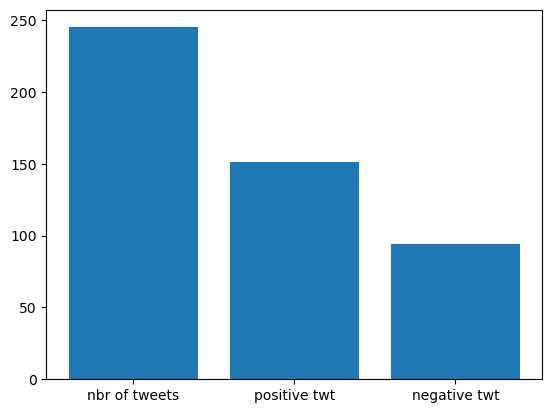

Insert data: [RT @girlsreallyrule: Don't f*** with a law professor: Elizabeth Warren has formally raised concerns to the Tesla Board Chairman that the Bo…, LINDAJUDY23 ]
nombre of tweets : 246
nombre de positive tweets :  152
nombre de negative tweets  : 94
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                      |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @girlsreallyrule:, f***, law, professor:, elizabeth, warren, formally, raised, concerns, tesla, board, chairman, bo\u2026""]|4.0       |
+-------------------------------------------------------------------------------------------------------------------------------------+----------+



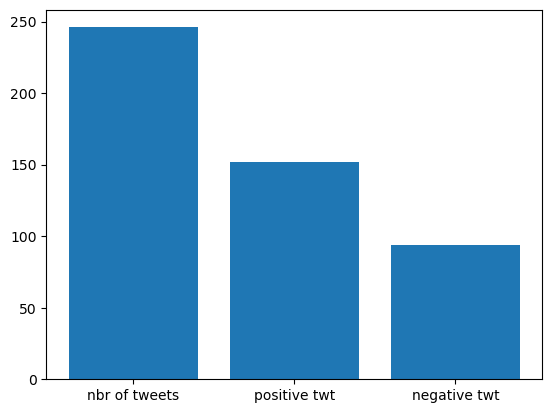

Insert data: [@jxrbot @AlbanyfxTrader @S_Wilck @jaminwestby @Tesla @klwtts @DriveElectricCO @WillToor @TESLORD1 @elonmusk @EVDave3 @DBurkland @itskyleconner @Out_of_Spec @brian_riebe @live_munro Yes, so what? At this present time, that is an option. But, hey, better to moan on Twitter that the door handles are frozen! 😂, lookatbowen ]
nombre of tweets : 247
nombre de positive tweets :  153
nombre de negative tweets  : 94
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                               |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------

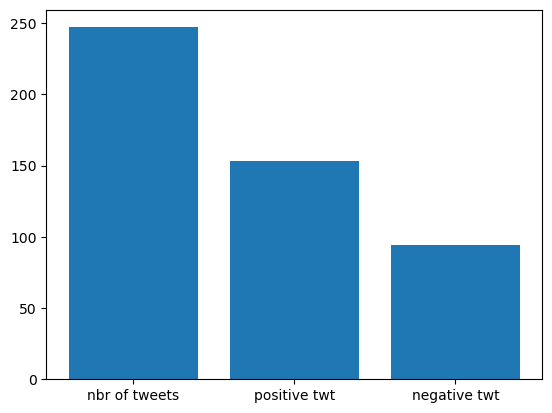

Insert data: [RT @EvaFoxU: Tesla Megacharger is installed in Sacramento to support Tesla Semi in PepsiCo operations. The Texas-based manufacturer deliver…, BilalBerry45205 ]
nombre of tweets : 248
nombre de positive tweets :  154
nombre de negative tweets  : 94
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @evafoxu:, tesla, megacharger, installed, sacramento, support, tesla, semi, pepsico, operations., texas-based, manufacturer, deliver\u2026""]|4.0       |
+---------------------------------------------------------------------------------

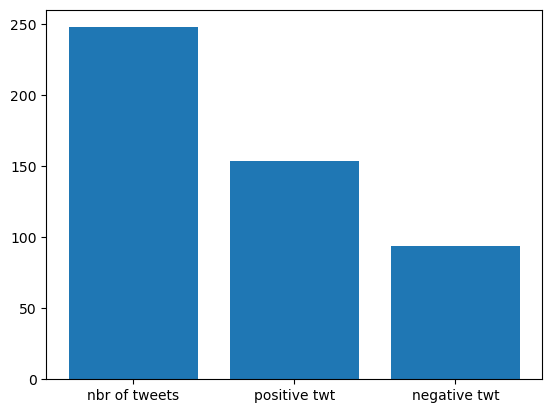

Insert data: [@bigbird3420 @elisa1121 @SenWarren @Twitter @Tesla @TheDemocrats Donkeys and Rhinos never give back their bribes, it was the Donkeys who got the majority of SBF’s bribes. https://t.co/eFFewou1zF, MrButtHead75 ]
nombre of tweets : 249
nombre de positive tweets :  154
nombre de negative tweets  : 95
+-----------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                        |prediction|
+-----------------------------------------------------------------------------------------------------------------------+----------+
|["[""@bigbird3420, @elisa1121, @senwarren, @twitter, @tesla, @thedemocrats, donkeys, rhinos, never, give, back, bribes]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------+----------+



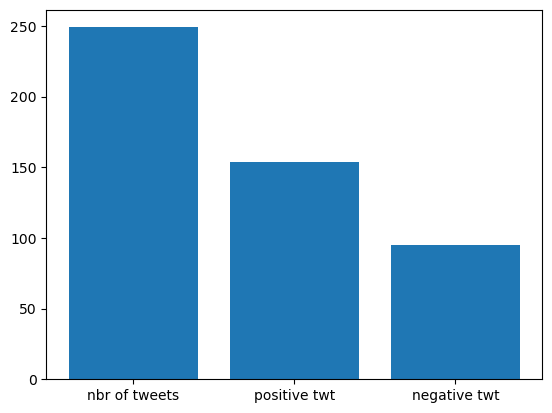

Insert data: [RT @DWUhlfelderLaw: The only thing really certain is Tesla hitting a 52 week low each day, ArbitraryAir ]
nombre of tweets : 250
nombre de positive tweets :  154
nombre de negative tweets  : 96
+----------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                         |prediction|
+----------------------------------------------------------------------------------------+----------+
|["[""rt, @dwuhlfelderlaw:, thing, really, certain, tesla, hitting, 52, week, low, day""]|0.0       |
+----------------------------------------------------------------------------------------+----------+



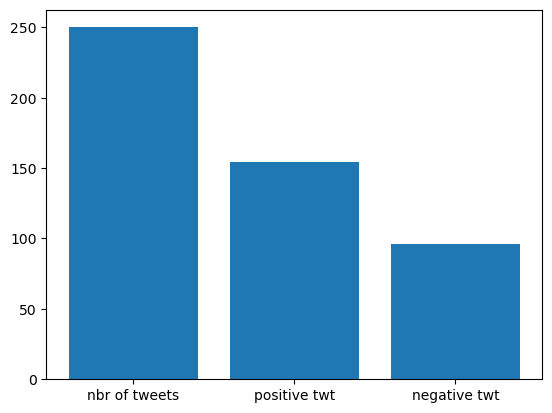

Insert data: [RT @DivesTech: Musk announces he will resign as CEO once successor found. Finally a good step in the right direction to end this painful ni…, maishamazingira ]
nombre of tweets : 251
nombre de positive tweets :  154
nombre de negative tweets  : 97
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @divestech:, musk, announces, resign, ceo, successor, found., finally, good, step, right, direction, end, painful, ni\u2026""]|0.0       |
+---------------------------------------------------------------------------------------------------------------------------------------+-----

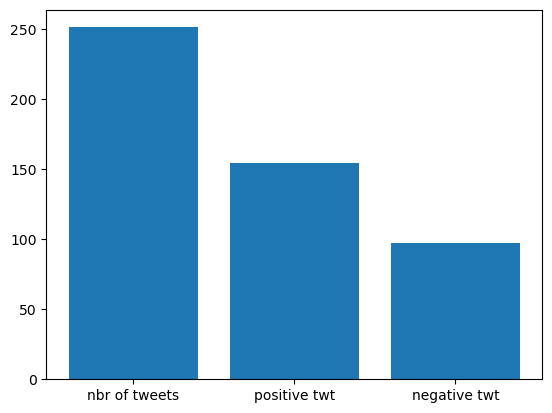

Insert data: [TESLA ROADSTER
0-60? 1.9 seconds
Seats? 2
Power? Electric
Price? $200,000

LADA 2101
0-60? Yeah, it'll get there
Seats? At least 5
Power? Petrol
Price? 34,625 rubles (€500) and a sack of potatoes

Winner: LADA 2101, nichol_five ]
nombre of tweets : 252
nombre de positive tweets :  154
nombre de negative tweets  : 98
+-------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                      |prediction|
+-------------------------------------------------------------------------------------+----------+
|["[""tesla, roadster\n0-60?, 1.9, seconds\nseats?, 2\npower?, electric\nprice?, $200]|0.0       |
+-------------------------------------------------------------------------------------+----------+



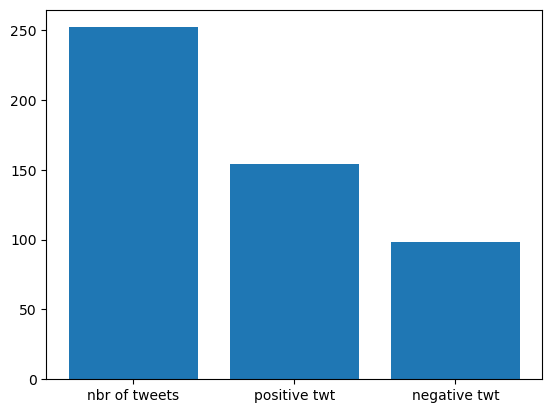

Insert data: [@MBUH62667700 @car_trump @CollinRugg It's Elon's fault that Tesla's stock is plummeting because he gave himself the title "technoking of Tesla"

https://t.co/SuQ0nVENdx, autasstic ]
nombre of tweets : 253
nombre de positive tweets :  155
nombre de negative tweets  : 98
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@mbuh62667700, @car_trump, @collinrugg, elon's, fault, tesla's, stock, plummeting, gave, title, \""technoking, tesla\""\n\nhttps://t.co/suq0nvendx""]|4.0       |
+-------------------------------------------

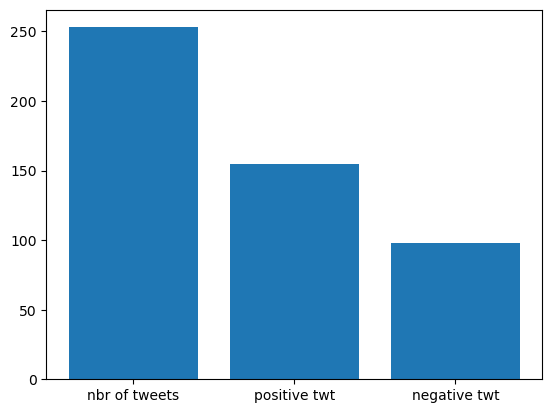

Insert data: [RT @mirandadevine: Tesla stock smashed 42% since @elonmusk bought Twitter, as Wall Street Dem allies tighten screws to prevent secrets bein…, Breezygirl1A ]
nombre of tweets : 254
nombre de positive tweets :  156
nombre de negative tweets  : 98
+----------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                         |prediction|
+----------------------------------------------------------------------------------------+----------+
|["[""rt, @mirandadevine:, tesla, stock, smashed, 42%, since, @elonmusk, bought, twitter]|4.0       |
+----------------------------------------------------------------------------------------+----------+



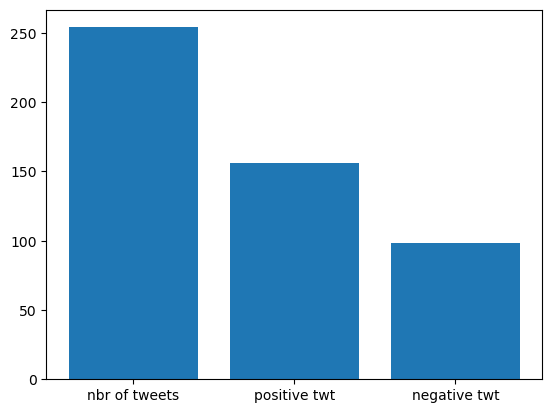

Insert data: [RT @duty2warn: Tesla stock might look like an opportunity to buy at the dip. It’s down 64% from its high of 402.
Except if it sold at the s…, SilverbergThor1 ]
nombre of tweets : 255
nombre de positive tweets :  156
nombre de negative tweets  : 99
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, tesla, stock, might, look, like, opportunity, buy, dip., it\u2019s, 64%, high, 402.\nexcept, sold, s\u2026""]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



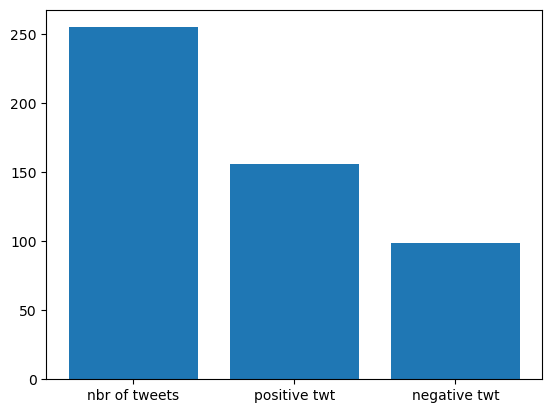

Insert data: [@elonmusk @RepAdamSchiff you know he did…How’s that Tesla stock?, DelmarBenson7 ]
nombre of tweets : 256
nombre de positive tweets :  157
nombre de negative tweets  : 99
+---------------------------------------------------------------------------+----------+
|MeaningfulWords                                                            |prediction|
+---------------------------------------------------------------------------+----------+
|["[""@elonmusk, @repadamschiff, know, did\u2026how\u2019s, tesla, stock?""]|4.0       |
+---------------------------------------------------------------------------+----------+



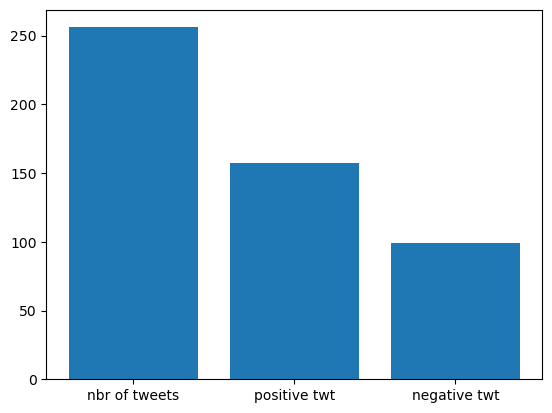

Insert data: [RT @SarahBCalif: @neiltyson @elonmusk Elon has invented nothing. 

“Tesla Motors was first founded by Martin Eberhard and Marc Tarpenning,…, wnorton ]
nombre of tweets : 257
nombre de positive tweets :  157
nombre de negative tweets  : 100
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sarahbcalif:, @neiltyson, @elonmusk, elon, invented, nothing., \n\n\u201ctesla, motors, first, founded, martin, eberhard, marc, tarpenning]|0.0       |
+---------------------------------------------------------------------------------------------

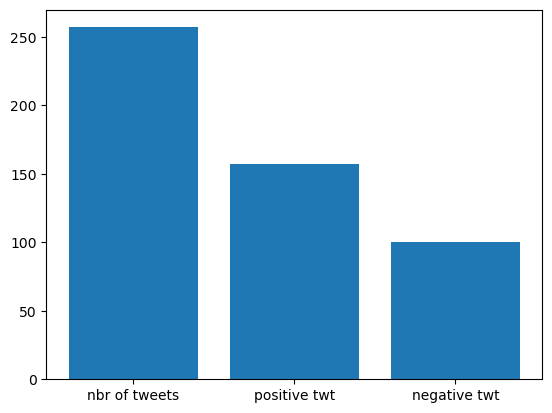

Insert data: [RT @lopezlinette: How do I know so much about how @elonmusk does things? I spent 3 years investigating Tesla at @BusinessInsider from 2018-…, MarcDavenant ]
nombre of tweets : 258
nombre de positive tweets :  157
nombre de negative tweets  : 101
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @lopezlinette:, know, much, @elonmusk, things?, spent, 3, years, investigating, tesla, @businessinsider, 2018-\u2026""]|0.0       |
+--------------------------------------------------------------------------------------------------------------------------------+----------+



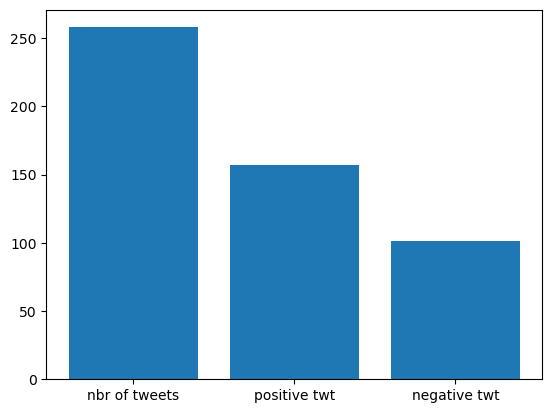

Insert data: [@TESLA_CREADOR Muyyyyyy buenos días de invierno https://t.co/Dfev6dMNDn, Mavica1980 ]
nombre of tweets : 259
nombre de positive tweets :  158
nombre de negative tweets  : 101
+------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                           |prediction|
+------------------------------------------------------------------------------------------+----------+
|["[""@tesla_creador, muyyyyyy, buenos, d\u00edas, de, invierno, https://t.co/dfev6dmndn""]|4.0       |
+------------------------------------------------------------------------------------------+----------+



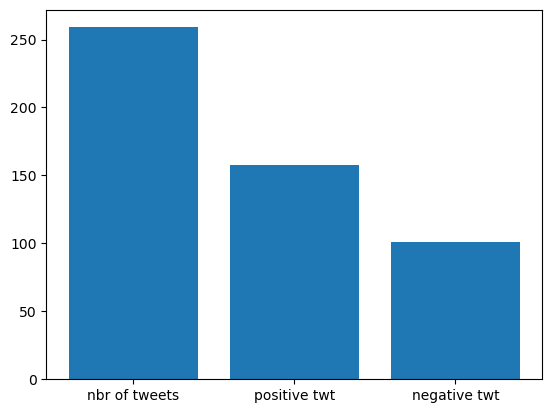

Insert data: [RT @DWUhlfelderLaw: The only thing really certain is Tesla hitting a 52 week low each day, ArbitraryAir ]
nombre of tweets : 260
nombre de positive tweets :  158
nombre de negative tweets  : 102
+----------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                         |prediction|
+----------------------------------------------------------------------------------------+----------+
|["[""rt, @dwuhlfelderlaw:, thing, really, certain, tesla, hitting, 52, week, low, day""]|0.0       |
+----------------------------------------------------------------------------------------+----------+



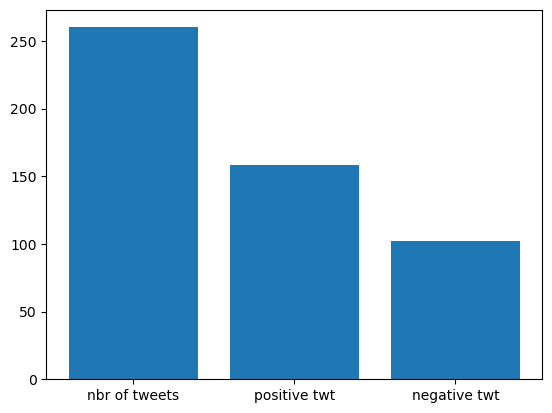

Insert data: [RT @jasondebolt: I’ve always been a mission focused investor, not a profit/wealth focused one. What Tesla is doing is incredibly important…, Milagaai ]
nombre of tweets : 261
nombre de positive tweets :  159
nombre de negative tweets  : 102
+----------------------------------------------------------------------+----------+
|MeaningfulWords                                                       |prediction|
+----------------------------------------------------------------------+----------+
|["[""rt, @jasondebolt:, i\u2019ve, always, mission, focused, investor]|4.0       |
+----------------------------------------------------------------------+----------+



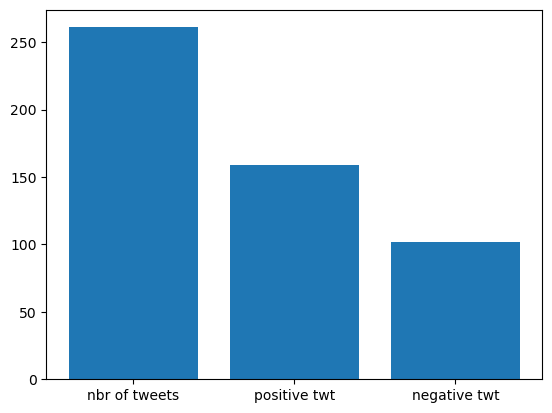

Insert data: [@Skillmare @elonmusk Tesla’s in serious trouble, DennisConroy16 ]
nombre of tweets : 262
nombre de positive tweets :  159
nombre de negative tweets  : 103
+-------------------------------------------------------------+----------+
|MeaningfulWords                                              |prediction|
+-------------------------------------------------------------+----------+
|["[""@skillmare, @elonmusk, tesla\u2019s, serious, trouble""]|0.0       |
+-------------------------------------------------------------+----------+



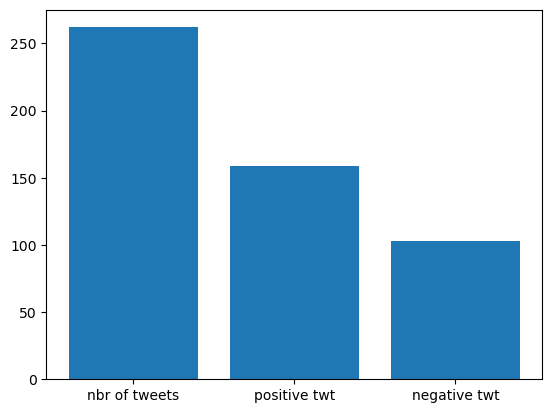

Insert data: [#ElonMusk blames macroeconomic conditions as #Tesla stock tanks

https://t.co/Y4xWleSeR2, TimesNow ]
nombre of tweets : 263
nombre de positive tweets :  159
nombre de negative tweets  : 104
+-----------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|["[""#elonmusk, blames, macroeconomic, conditions, #tesla, stock, tanks\n\nhttps://t.co/y4xwleser2""]|0.0       |
+-----------------------------------------------------------------------------------------------------+----------+



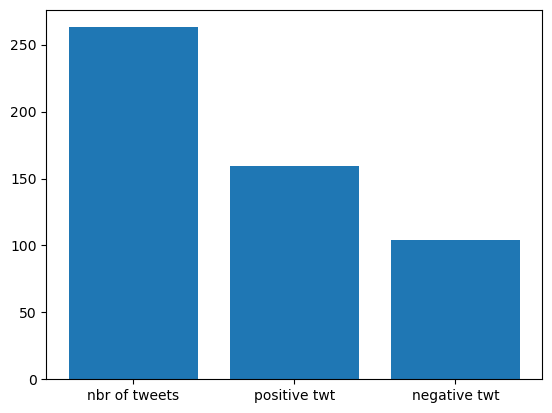

Insert data: [@MBUH62667700 @car_trump @CollinRugg It's Elon's fault that Tesla's stock is plummeting because he gave himself the title "technoking of Tesla"

https://t.co/SuQ0nVENdx, autasstic ]
nombre of tweets : 264
nombre de positive tweets :  160
nombre de negative tweets  : 104
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@mbuh62667700, @car_trump, @collinrugg, elon's, fault, tesla's, stock, plummeting, gave, title, \""technoking, tesla\""\n\nhttps://t.co/suq0nvendx""]|4.0       |
+------------------------------------------

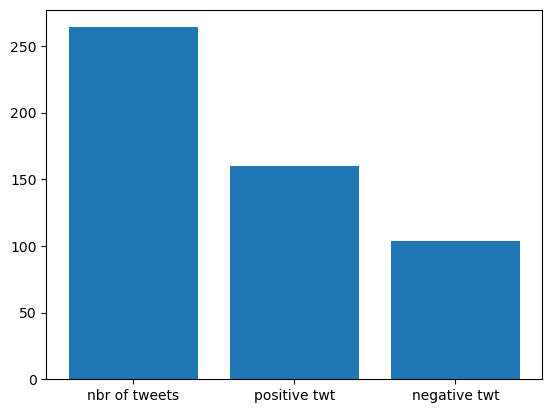

Insert data: [RT @unusual_whales: Recently, Elon reportedly sold nearly $3.58 billion of Tesla.

To see how Tesla, $TSLA, is performing, check: https://t…, IVANAGU90585190 ]
nombre of tweets : 265
nombre de positive tweets :  161
nombre de negative tweets  : 104
+------------------------------------+----------+
|MeaningfulWords                     |prediction|
+------------------------------------+----------+
|["[""rt, @unusual_whales:, recently]|4.0       |
+------------------------------------+----------+



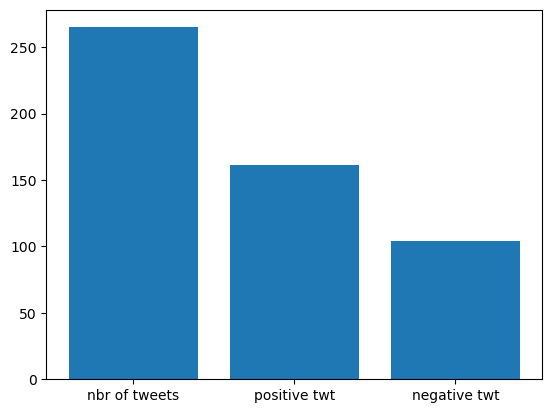

Insert data: [@edvinner @svtnyheter Tror det är föga överraskande för en elbilsägare. Nästan ingen i Sverige har de "dåliga" elbilarna ändå. Tesla Y dual = "oh nej det är vinter, nu har vi bara 48,7 mil innan vi behöver tanka elektronerna", golddubby ]
nombre of tweets : 266
nombre de positive tweets :  162
nombre de negative tweets  : 104
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------

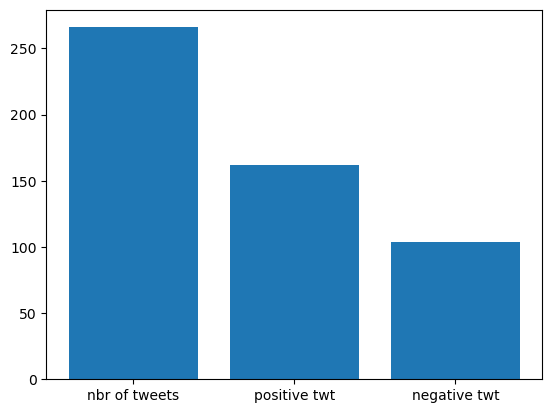

Insert data: [@Pensioenspook En ondertussen worden adverteerders door dat flipflop-beleid en door de politiek gekleurde houding van Elon Musk weggejaagd. Twitter stevent af op steeds grotere verliezen.

En (onder andere) daardoor wordt Tesla meegezogen., Lynx__RedLeft ]
nombre of tweets : 267
nombre de positive tweets :  163
nombre de negative tweets  : 104
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                        |prediction|
+-----------------------------------------------------

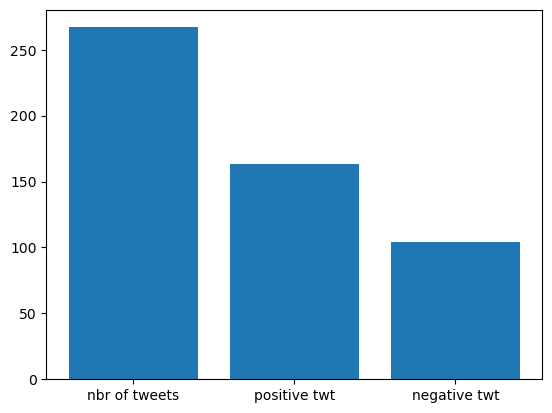

Insert data: [@elonmusk @RepAdamSchiff you know he did…How’s that Tesla stock?, DelmarBenson7 ]
nombre of tweets : 268
nombre de positive tweets :  164
nombre de negative tweets  : 104
+---------------------------------------------------------------------------+----------+
|MeaningfulWords                                                            |prediction|
+---------------------------------------------------------------------------+----------+
|["[""@elonmusk, @repadamschiff, know, did\u2026how\u2019s, tesla, stock?""]|4.0       |
+---------------------------------------------------------------------------+----------+



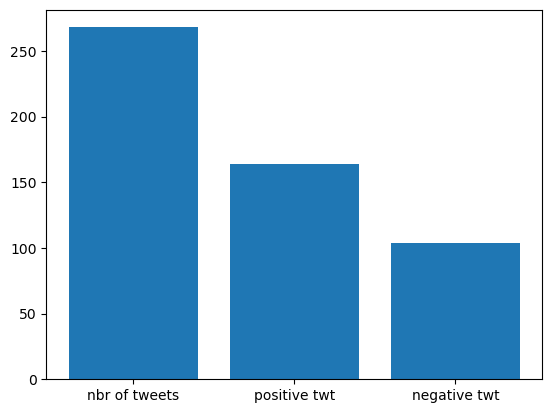

Insert data: [RT @Quinnae_Moon: What's happening is that he is, at best, maliciously complying with the poll and *languidly* slow-walking a resignation.…, otdderamin ]
nombre of tweets : 269
nombre de positive tweets :  164
nombre de negative tweets  : 105
+-----------------------------------+----------+
|MeaningfulWords                    |prediction|
+-----------------------------------+----------+
|["[""rt, @quinnae_moon:, happening]|0.0       |
+-----------------------------------+----------+



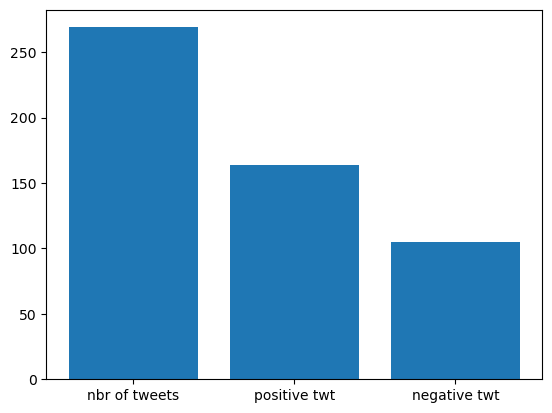

Insert data: [RT @GerberKawasaki: Tesla stock price now reflects the value of having no CEO. Great job tesla BOD - Time for a shake up. $tsla, LemStraw ]
nombre of tweets : 270
nombre de positive tweets :  165
nombre de negative tweets  : 105
+----------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gerberkawasaki:, tesla, stock, price, reflects, value, ceo., great, job, tesla, bod, -, time, shake, up., $tsla""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------+----------+



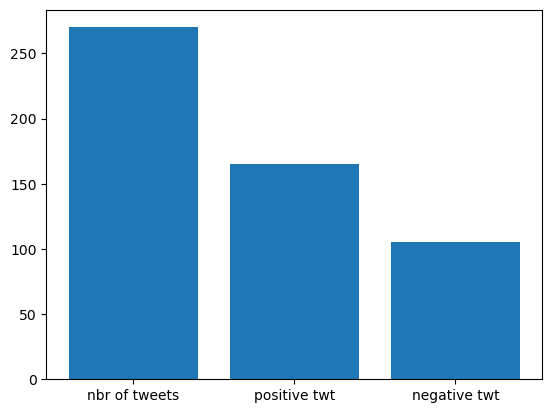

Insert data: [RT @ItsJoko: Think about how terrifying driving would be if you could see everybody's skill rating that was driving around you

Like imagin…, RealTwittaHater ]
nombre of tweets : 271
nombre de positive tweets :  166
nombre de negative tweets  : 105
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @itsjoko:, think, terrifying, driving, see, everybody's, skill, rating, driving, around, you\n\nlike, imagin\u2026""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------------+----------+



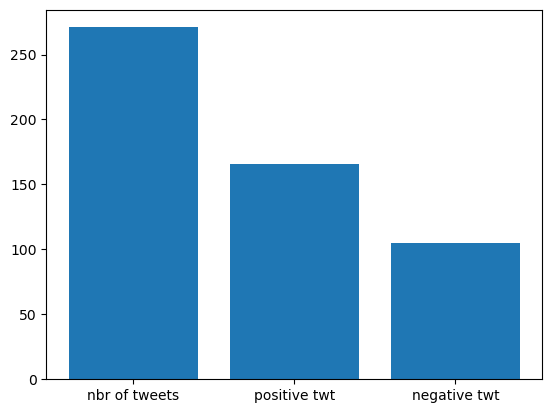

Insert data: [@nytopinion @nytimes @paulkrugman Tesla share price down another 8 per cent today to $137 from $400 last January. Another good news day., Steve_Rodgers ]
nombre of tweets : 272
nombre de positive tweets :  166
nombre de negative tweets  : 106
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@nytopinion, @nytimes, @paulkrugman, tesla, share, price, another, 8, per, cent, today, $137, $400, last, january., another, good, news, day.""]|0.0       |
+------------------------------------------------------------------------------------------

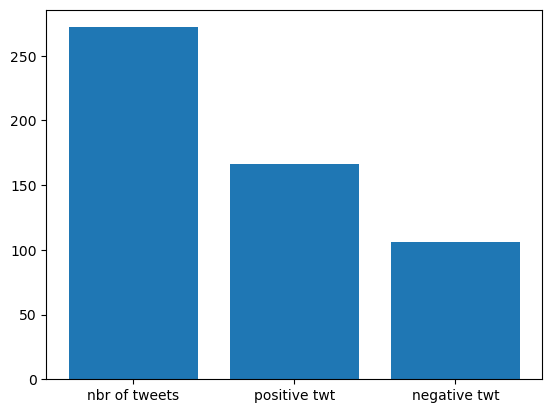

Insert data: [Created a Dream 100 list on Twitter a couple months ago.

I check back in and find I don't connect with any of their tweets anymore.

Is that growth?, gold_tesla ]
nombre of tweets : 273
nombre de positive tweets :  166
nombre de negative tweets  : 107
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                   |prediction|
+----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""created, dream, 100, list, twitter, couple, months, ago.\n\ni, check, back, find, connect, tweets, anymore.\n\nis, growth?""]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------+----------+



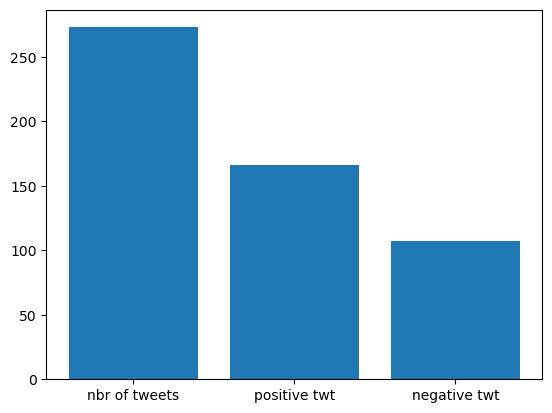

Insert data: [RT @business: Cathie Wood ramps up purchases of Tesla shares in the fourth quarter even as concerns over CEO Elon Musk’s ability to manage…, Jamal88297418 ]
nombre of tweets : 274
nombre de positive tweets :  167
nombre de negative tweets  : 107
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @business:, cathie, wood, ramps, purchases, tesla, shares, fourth, quarter, even, concerns, ceo, elon, musk\u2019s, ability, manage\u2026""]|4.0       |
+---------------------------------------------------------------------------------------

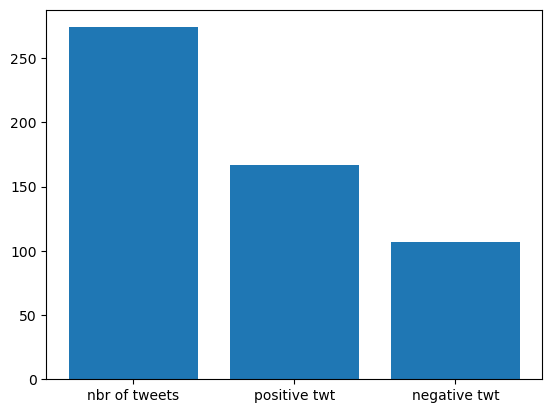

Insert data: [RT @blastnost: @ubiquity75 Imagine a world that denied Musk corporate welfare. Without hefty government subsidies, it’s hard to imagine the…, Mandy98765023 ]
nombre of tweets : 275
nombre de positive tweets :  167
nombre de negative tweets  : 108
+----------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @blastnost:, @ubiquity75, imagine, world, denied, musk, corporate, welfare., without, hefty, government, subsidies]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------+----------+



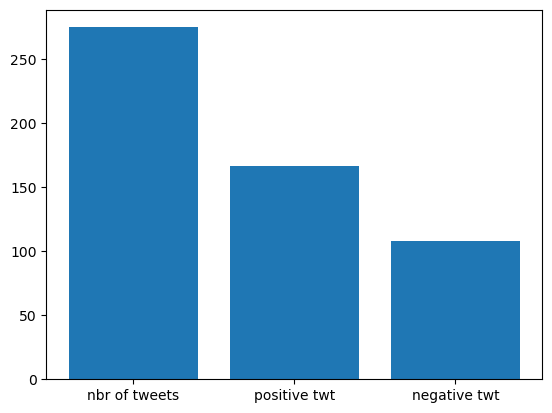

Insert data: [RT @newswayng: PI NETWORK: Elon Musk’s Tesla Model Pi smartphone to be available on the pi81 mall early 2023  https://t.co/lCiN5Roo81, bengti0112 ]
nombre of tweets : 276
nombre de positive tweets :  168
nombre de negative tweets  : 108
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @newswayng:, pi, network:, elon, musk\u2019s, tesla, model, pi, smartphone, available, pi81, mall, early, 2023, , https://t.co/lcin5roo81""]|4.0       |
+------------------------------------------------------------------------------------------------

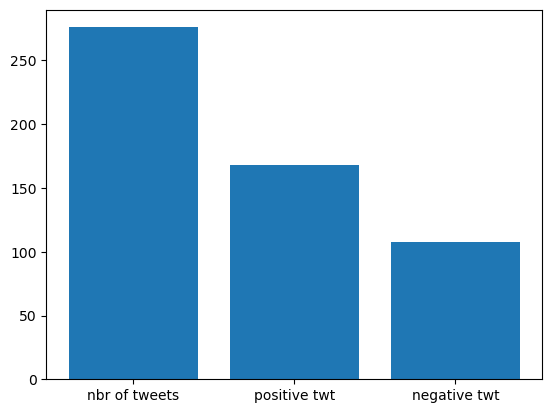

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, Orchid8_16 ]
nombre of tweets : 277
nombre de positive tweets :  169
nombre de negative tweets  : 108
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



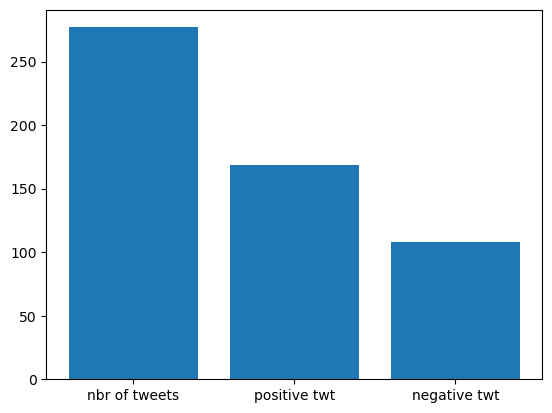

Insert data: [RT @newswayng: PI NETWORK: Final review of the Elon Musk’s Tesla Pi smartphone before it’s official launch surfaces on the internet  https:…, bengti0112 ]
nombre of tweets : 278
nombre de positive tweets :  170
nombre de negative tweets  : 108
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @newswayng:, pi, network:, final, review, elon, musk\u2019s, tesla, pi, smartphone, it\u2019s, official, launch, surfaces, internet, , https:\u2026""]|4.0       |
+-------------------------------------------------

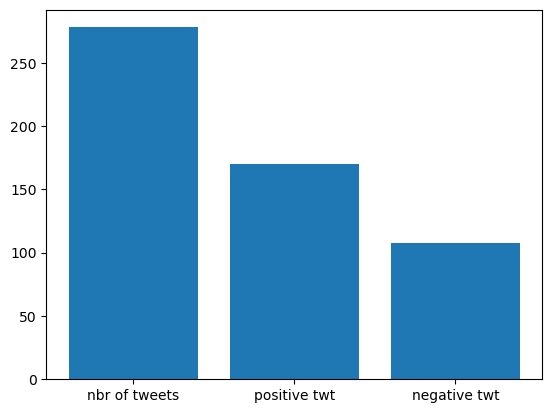

Insert data: [明日から寒波再来だけど純正チェーン使う時は気をつけてね！！

カバーは取るんだぞ😇 https://t.co/vRcsfa46K1, teru_tesla ]
nombre of tweets : 279
nombre de positive tweets :  171
nombre de negative tweets  : 108
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[["u660eu65e5u304bu3089u5bd2u6ce2u518du6765u3060u3051u3069u7d14u6b63u30c1u30a7

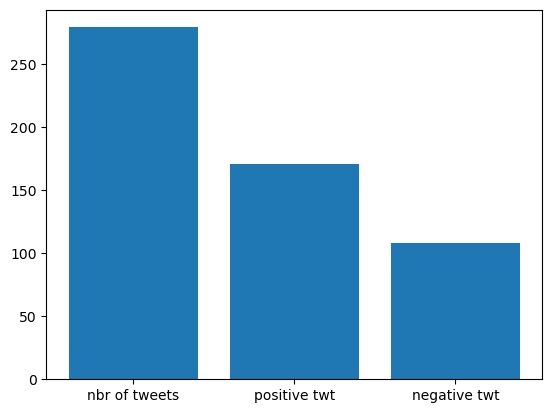

Insert data: [@InnocentSkeptic Haha!  Spectral analysis for Tesla aficionados and the modern car buff. 😂😂😂, CtIgnatia ]
nombre of tweets : 280
nombre de positive tweets :  172
nombre de negative tweets  : 108
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@innocentskeptic, haha!, , spectral, analysis, tesla, aficionados, modern, car, buff., \ud83d\ude02\ud83d\ude02\ud83d\ude02""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



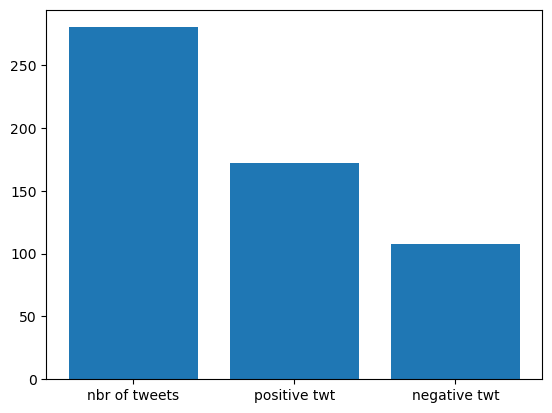

Insert data: [A 65% collapse of stock price this year.  

Well done, @elonmusk. 🙃

I imagine Tesla investors will also want a vote. https://t.co/HXAr8dfezH, AHaermeyer ]
nombre of tweets : 281
nombre de positive tweets :  172
nombre de negative tweets  : 109
+-------------------------------------------------------------+----------+
|MeaningfulWords                                              |prediction|
+-------------------------------------------------------------+----------+
|["[""a, 65%, collapse, stock, price, year., , \n\nwell, done]|0.0       |
+-------------------------------------------------------------+----------+



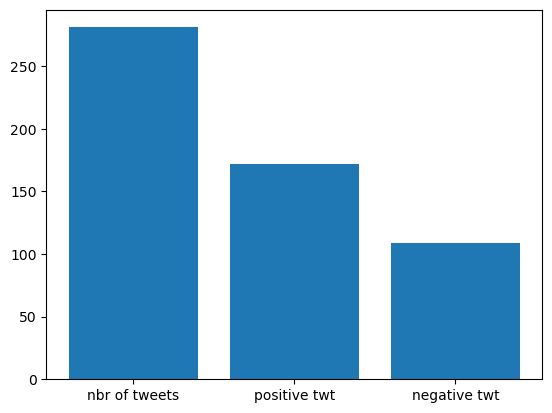

Insert data: [Elon Musk blames Tesla’s $600 billion plunge in market value this year on the Fed – as rising interest rates erode the appeal of stocks https://t.co/Ix1CM2IEuy #Sports #Entertainment #Lifestyle #Health #Politics #Science #Tech #Business #Travel #Finance #Investing, FeedExpress ]
nombre of tweets : 282
nombre de positive tweets :  173
nombre de negative tweets  : 109
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                               |prediction|
+----------------

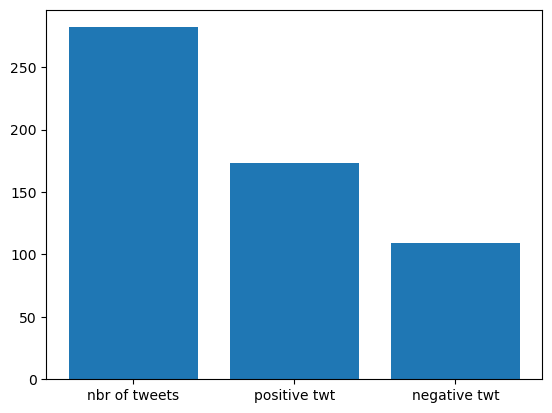

Insert data: [@GerberKawasaki Tesla price is adjusted to new reality of no more unlimited demand, competitors in China (did you miss BYD growing wk by wk while Tesla dropping in spite of discount) FSD reality (not the whole mars catalog always right ride) HW4 coming, cybertruck delay.., Sympathy4Devil_ ]
nombre of tweets : 283
nombre de positive tweets :  173
nombre de negative tweets  : 110
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@gerberkawasaki, tesla, price, adjusted, new, reality, unlimited, demand]|0.0       |
+------------------------------------------------------------------------------+----------+



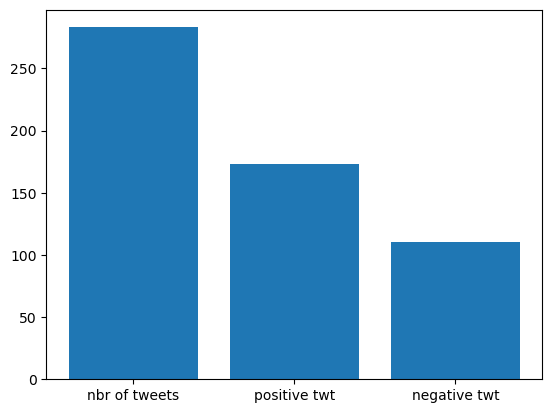

Insert data: [RT @TaraBull808: I'm shocked to see how many people are more concerned about Elon Musk focusing on Tesla stock price than free speech, do t…, aidanyingw ]
nombre of tweets : 284
nombre de positive tweets :  174
nombre de negative tweets  : 110
+-----------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                        |prediction|
+-----------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tarabull808:, shocked, see, many, people, concerned, elon, musk, focusing, tesla, stock, price, free, speech]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------+----------+



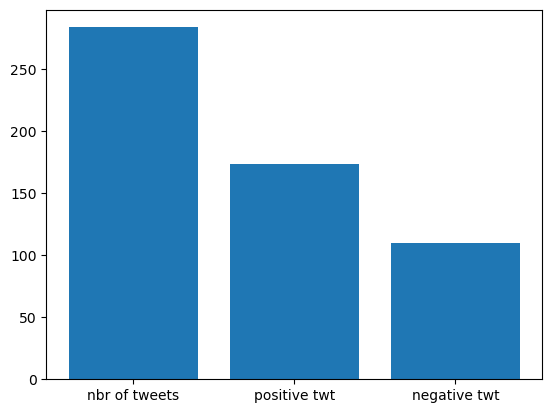

Insert data: [@realbjjonez @thekage75 @misery186 @WhiteHouse None of these aside from Tesla and Twitter Blue are things you can actually support though? And if you buy Twitter blue your actually losing him money statistically so literally the only way to support him is through Tesla But if you don’t like EV you CANT support him financially, Real_Mini_Coco ]
nombre of tweets : 285
nombre de positive tweets :  175
nombre de negative tweets  : 110
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                           

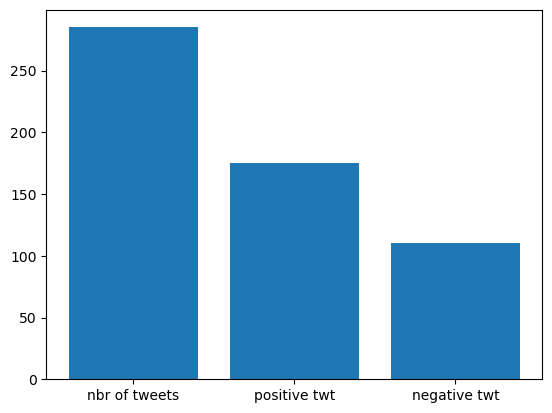

Insert data: [RT @parismarx: Linette Lopez shows that Elon Musk hasn’t made a sudden change. He’s always been this way, regardless of what former booster…, Jonah93M ]
nombre of tweets : 286
nombre de positive tweets :  176
nombre de negative tweets  : 110
+--------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                     |prediction|
+--------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @parismarx:, linette, lopez, shows, elon, musk, hasn\u2019t, made, sudden, change., he\u2019s, always, way]|4.0       |
+--------------------------------------------------------------------------------------------------------------------+----------+



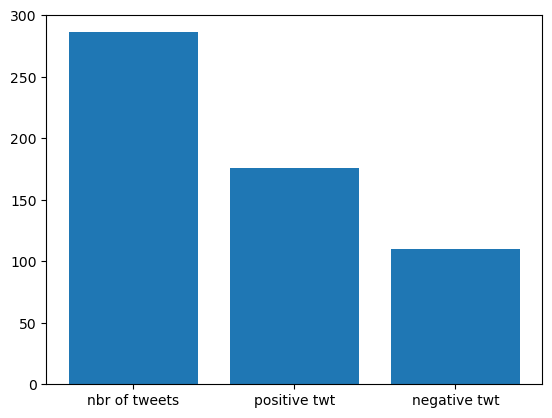

Insert data: [RT @Tesla: Tesla engineers leverage the data and capabilities of Autopilot to make accident-avoidance a reality. Here’s a look at the featu…, purevdo27046751 ]
nombre of tweets : 287
nombre de positive tweets :  177
nombre de negative tweets  : 110
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, tesla, engineers, leverage, data, capabilities, autopilot, make, accident-avoidance, reality., here\u2019s, look, featu\u2026""]|4.0       |
+------------------------------------------------------------------------------------------------

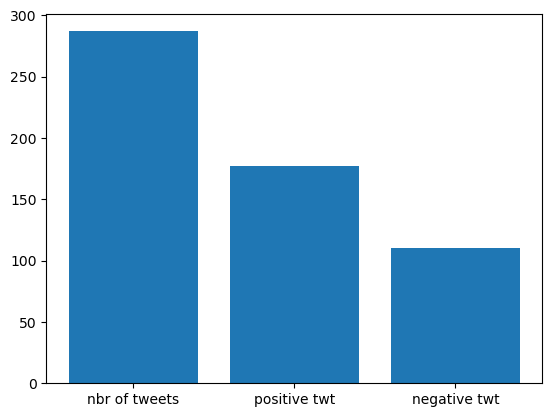

Insert data: [@findgg33 @Tesla @Numerologynow @elonmusk Who would sit in a battery🤣, whatisanamelol ]
nombre of tweets : 288
nombre de positive tweets :  177
nombre de negative tweets  : 111
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@findgg33, @tesla, @numerologynow, @elonmusk, sit, battery\ud83e\udd23""]|0.0       |
+------------------------------------------------------------------------------+----------+



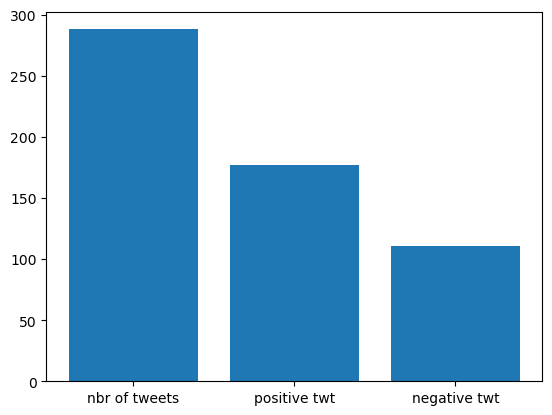

Insert data: [@elonmusk I hope Elon could ignore all the advice from others, just do wt he is doing now, it would be excited to see Tesla stock price become single digital, can’t wait to see all the responses of Tesla fans to be poor ! wow can’t wait!!!, Vic43241495 ]
nombre of tweets : 289
nombre de positive tweets :  178
nombre de negative tweets  : 111
+---------------------------------------------------+----------+
|MeaningfulWords                                    |prediction|
+---------------------------------------------------+----------+
|["[""@elonmusk, hope, elon, ignore, advice, others]|4.0       |
+---------------------------------------------------+----------+



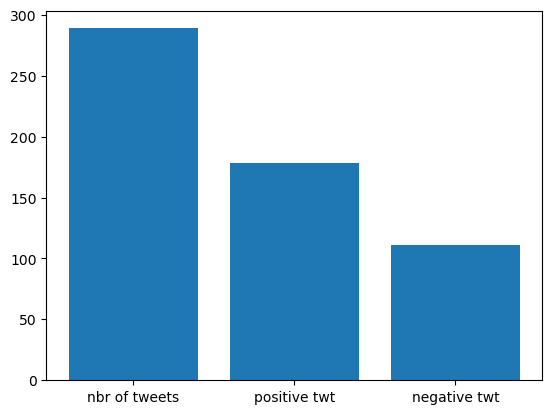

Insert data: [HOW ABOUT A HOSTILE TAKEOVER OF @Tesla ???, TruthJusticeRt ]
nombre of tweets : 290
nombre de positive tweets :  179
nombre de negative tweets  : 111
+-------------------------------------------+----------+
|MeaningfulWords                            |prediction|
+-------------------------------------------+----------+
|["[""how, hostile, takeover, @tesla, ???""]|4.0       |
+-------------------------------------------+----------+



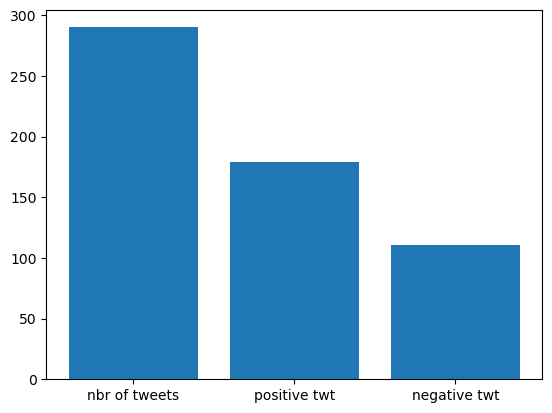

Insert data: [@DrevetCyril @turbofr @Tesla @TeslaClubFrance Je peux leur prêter un peu de fric pour embaucher un designer automobile. Non vraiment, ça me fait de la peine à force... 🙂, Arnufle ]
nombre of tweets : 291
nombre de positive tweets :  180
nombre de negative tweets  : 111
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                  |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@drevetcyril, @turbofr, @tesla, @teslaclubfrance, je, peux, leur, pr\u00eater, un, peu, de, fric, pour, embaucher, un, designer, automobile., non, vraiment]|4.0       |
+---------------

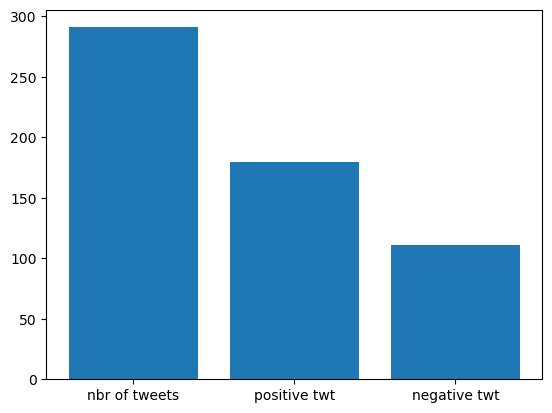

Insert data: [RT @OoTheNigerian: .@elonmusk's Twitter challenge

While Musk is great at driving teams to a goal, but unlike Space X, Tesla etc. he's yet…, Rotankwot ]
nombre of tweets : 292
nombre de positive tweets :  181
nombre de negative tweets  : 111
+-------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @oothenigerian:, .@elonmusk's, twitter, challenge\n\nwhile, musk, great, driving, teams, goal]|4.0       |
+-------------------------------------------------------------------------------------------------------+----------+



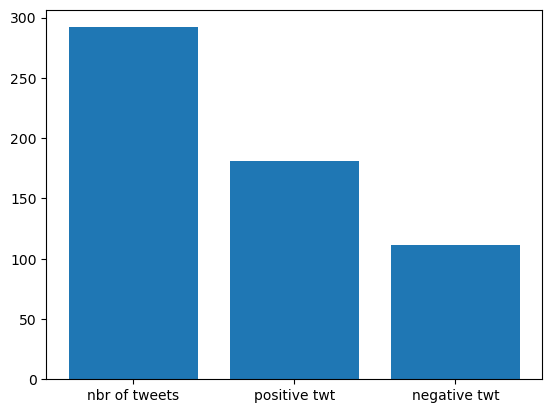

Insert data: [RT @jasondebolt: I’ve always been a mission focused investor, not a profit/wealth focused one. What Tesla is doing is incredibly important…, hwangsopower ]
nombre of tweets : 293
nombre de positive tweets :  182
nombre de negative tweets  : 111
+----------------------------------------------------------------------+----------+
|MeaningfulWords                                                       |prediction|
+----------------------------------------------------------------------+----------+
|["[""rt, @jasondebolt:, i\u2019ve, always, mission, focused, investor]|4.0       |
+----------------------------------------------------------------------+----------+



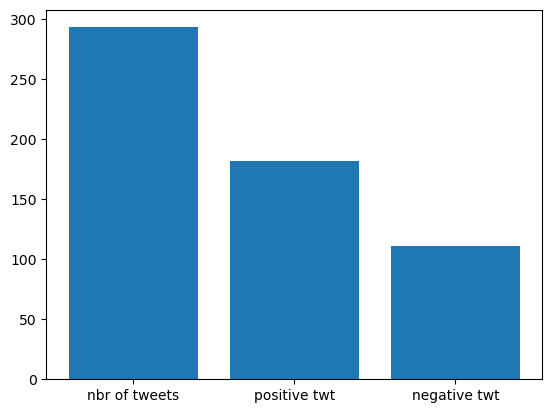

Insert data: [🗣️ 10 datos que no sabías sobre Nikola Tesla https://t.co/hmfZrxHaMh, InfoReportes ]
nombre of tweets : 294
nombre de positive tweets :  183
nombre de negative tweets  : 111
+-----------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                |prediction|
+-----------------------------------------------------------------------------------------------+----------+
|[["ud83dudde3ufe0f, 10, datos, que, sabu00edas, sobre, nikola, tesla, https://t.co/hmfzrxhamh"]|4.0       |
+-----------------------------------------------------------------------------------------------+----------+



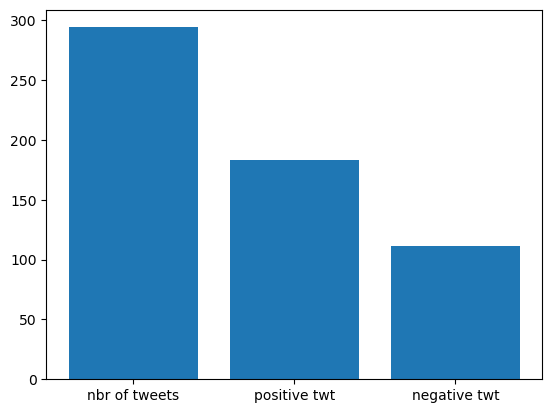

Insert data: [@RoySayWhatNow @Teslamojo @Hoigwai @neiltyson Nah, the original founder was given a roadster that was used for testing, that was crashed in the testing and written off by Tesla. Major middle finger to the original founder. The one shot to space was the first off the line., HopiumOf_Masses ]
nombre of tweets : 295
nombre de positive tweets :  184
nombre de negative tweets  : 111
+-----------------------------------------------------------+----------+
|MeaningfulWords                                            |prediction|
+-----------------------------------------------------------+----------+
|["[""@roysaywhatnow, @teslamojo, @hoigwai, @neiltyson, nah]|4.0       |
+-----------------------------------------------------------+----------+



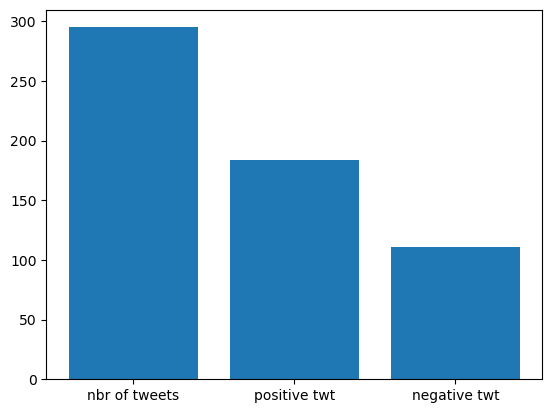

Insert data: [#RaviVisvesvarayaSharadaPrasad  https://t.co/s2q5B1nRNu Cathie Wood Loads Up Tesla Amid Growing Criticism of Elon Musk, rvp ]
nombre of tweets : 296
nombre de positive tweets :  185
nombre de negative tweets  : 111
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""#ravivisvesvarayasharadaprasad, , https://t.co/s2q5b1nrnu, cathie, wood, loads, tesla, amid, growing, criticism, elon, musk""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



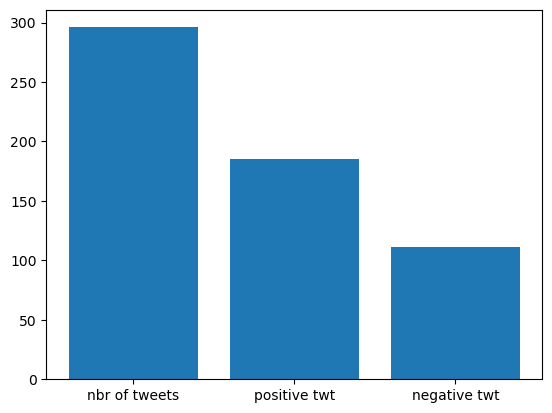

Insert data: [@WilmotteKarim @RaspaDemi @AddleyMa @Tesla_Spark31 @FrenchHist All these things are dead now. That's the whole point of the French philosophy during the 20th century.

Foucault and the desconstructivists showed how far-fetched and un-universal this definition was.

You French should know it, RedSorys ]
nombre of tweets : 297
nombre de positive tweets :  186
nombre de negative tweets  : 111
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                               |prediction|
+--------------------------------------------------------

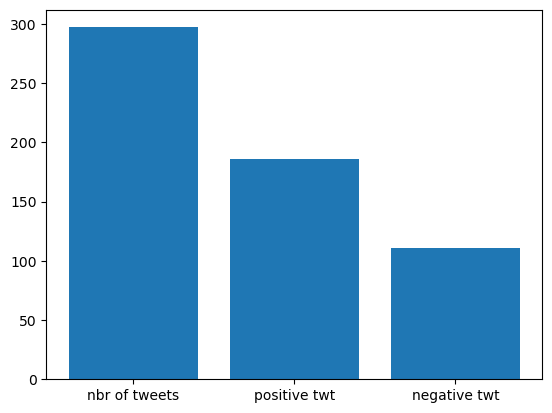

Insert data: [@fernielad @teslaeconomist @bluebearcafe1 @heydave7 @elonmusk @saxena_puru @vincent13031925 Tesla also has market leading profit margins. Only companies like Porsche can compare in terms of customer satisfaction and margins, but they produce only a fraction the number of cars Tesla produces, cost more than twice as much, and don't really have any growth., RandyVegetables ]
nombre of tweets : 298
nombre de positive tweets :  187
nombre de negative tweets  : 111
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                   |prediction|
+----------------------------------------

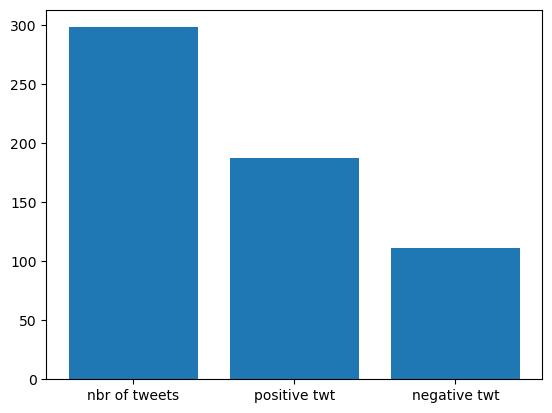

Insert data: [RT @muglikar_: Toyota halts expansion in India, Tesla says taxes are high on cars, today Maruti Chairman says 50% tax on cars will kill the…, ParsekarFaldeep ]
nombre of tweets : 299
nombre de positive tweets :  188
nombre de negative tweets  : 111
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""rt, @muglikar_:, toyota, halts, expansion, india]|4.0       |
+------------------------------------------------------+----------+



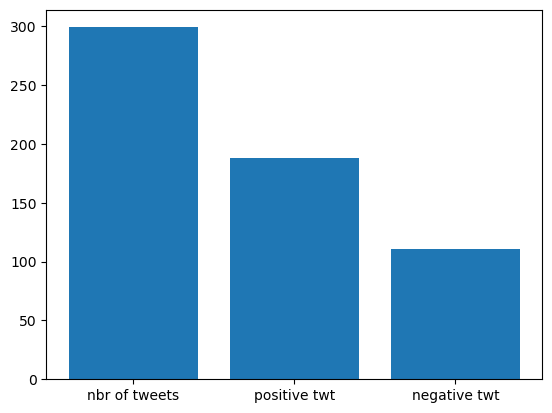

Insert data: [RT @SometimesWhy5: @oldportcoves @lawindsor @elonmusk The only person I know who drives a Tesla is trying to sell it. He is pondering tradi…, sandralhanlon ]
nombre of tweets : 300
nombre de positive tweets :  189
nombre de negative tweets  : 111
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sometimeswhy5:, @oldportcoves, @lawindsor, @elonmusk, person, know, drives, tesla, trying, sell, it., pondering, tradi\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------------------

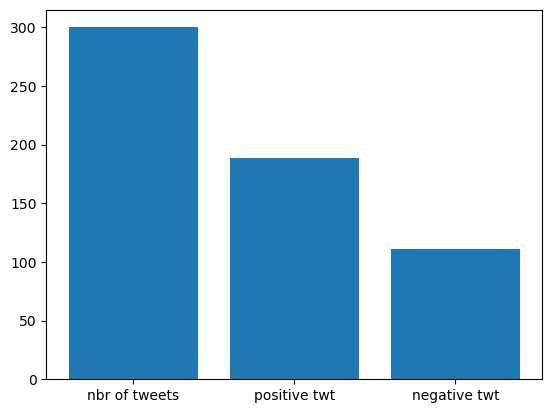

Insert data: [@heydave7 @realGeorgeHotz Question :Has the road map changed gor Tesla after tge purchase of Twitter ?, ThomaidisMaria ]
nombre of tweets : 301
nombre de positive tweets :  190
nombre de negative tweets  : 111
+-------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                              |prediction|
+-------------------------------------------------------------------------------------------------------------+----------+
|["[""@heydave7, @realgeorgehotz, question, :has, road, map, changed, gor, tesla, tge, purchase, twitter, ?""]|4.0       |
+-------------------------------------------------------------------------------------------------------------+----------+



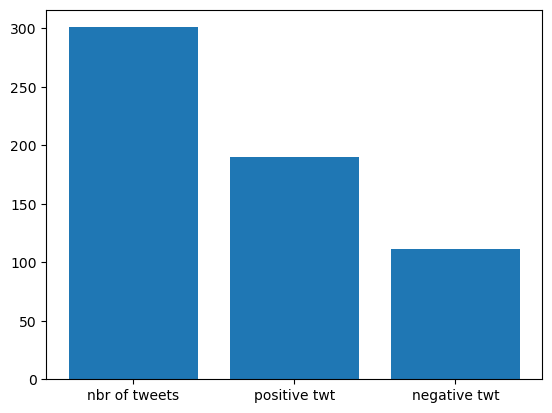

Insert data: [@texaslib @iheartmindy @SenWarren @Twitter @Tesla So basically instead of doing your job Liz Warren was writing books is that what you're saying? That sounds like a conflict of interest to me., MitchRonshaugen ]
nombre of tweets : 302
nombre de positive tweets :  190
nombre de negative tweets  : 112
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                    |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@texaslib, @iheartmindy, @senwarren, @twitter, @tesla, basically, instead, job, liz, warren, writing, books, saying?, sounds, like, conflict, intere

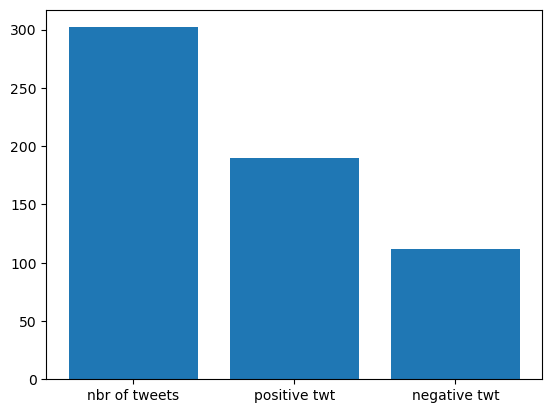

Insert data: [RT @eriz35: this ding dong has his entire net worth in tesla shares (now only $9 million lol) and he's getting his DD from a crack addicted…, tslaqtwin ]
nombre of tweets : 303
nombre de positive tweets :  191
nombre de negative tweets  : 112
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @eriz35:, ding, dong, entire, net, worth, tesla, shares, (now, $9, million, lol), getting, dd, crack, addicted\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------------+----------+



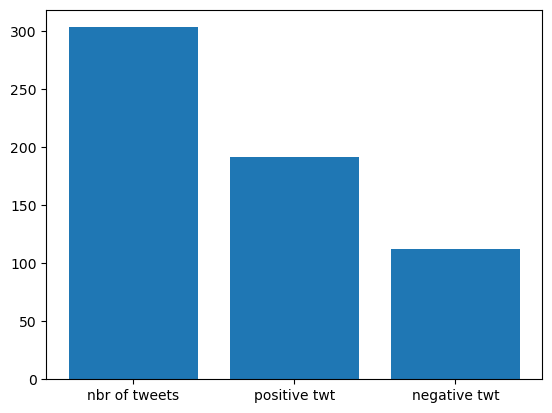

Insert data: [@SenWarren @Twitter @Tesla Elizabeth Warren has become a multi-millionaire since entering the Senate.  Please explain how., dcleary6 ]
nombre of tweets : 304
nombre de positive tweets :  192
nombre de negative tweets  : 112
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                      |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, elizabeth, warren, become, multi-millionaire, since, entering, senate., , please, explain, how.""]|4.0       |
+-------------------------------------------------------------------------------------------------------------------------------------+----------+



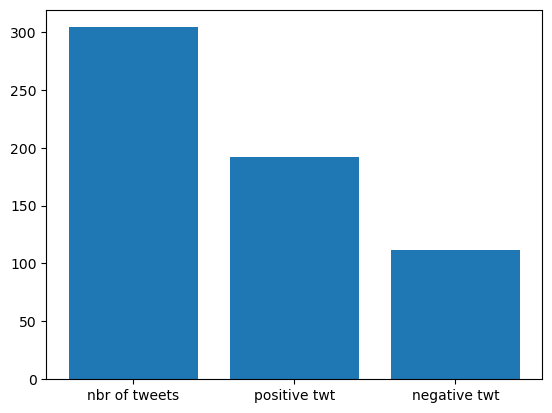

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, wxc20177072 ]
nombre of tweets : 305
nombre de positive tweets :  193
nombre de negative tweets  : 112
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+---

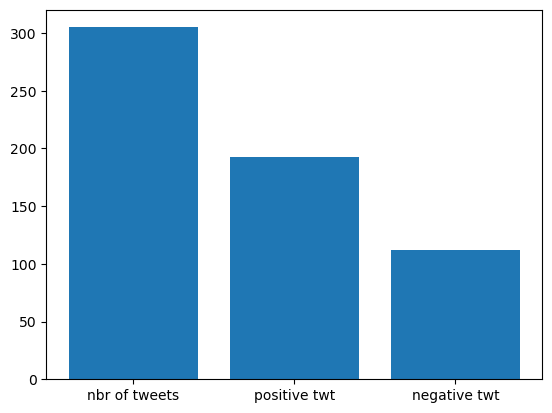

Insert data: [RT @Tesla: We’ve completed 500k+ Solar Panel and Solar Roof installations—that’s equal to ~4 GW of clean energy ☀️ https://t.co/Tjz6PzYuah, VoltaWagen ]
nombre of tweets : 306
nombre de positive tweets :  194
nombre de negative tweets  : 112
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                  |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, we\u2019ve, completed, 500k+, solar, panel, solar, roof, installations\u2014that\u2019s, equal, ~4, gw, clean, energy, \u2600\ufe0f, https://t.co/tjz6pz

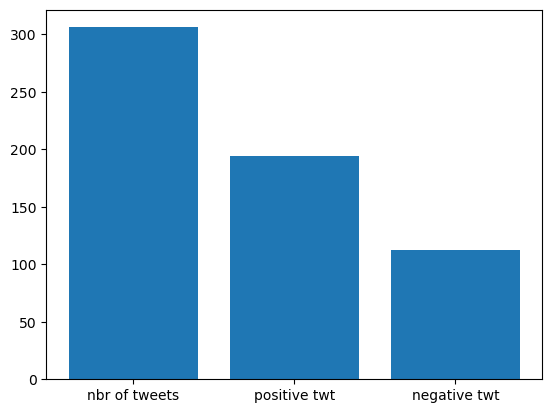

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, KkndPotea ]
nombre of tweets : 307
nombre de positive tweets :  195
nombre de negative tweets  : 112
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-----

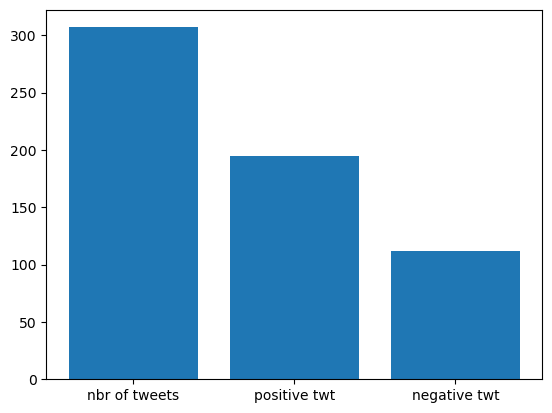

Insert data: [@Tesla @elonmusk Well said !!, Techistio ]
nombre of tweets : 308
nombre de positive tweets :  196
nombre de negative tweets  : 112
+-----------------------------------------+----------+
|MeaningfulWords                          |prediction|
+-----------------------------------------+----------+
|["[""@tesla, @elonmusk, well, said, !!""]|4.0       |
+-----------------------------------------+----------+



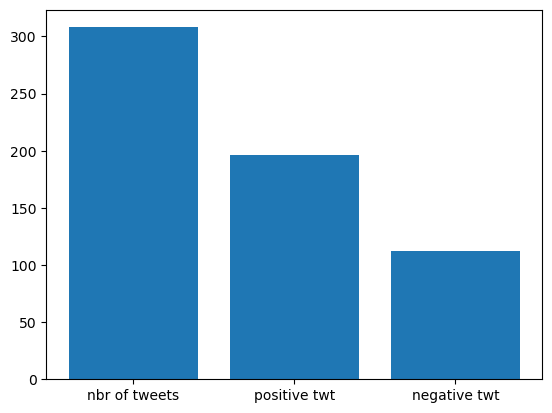

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, sunshin93723003 ]
nombre of tweets : 309
nombre de positive tweets :  197
nombre de negative tweets  : 112
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------

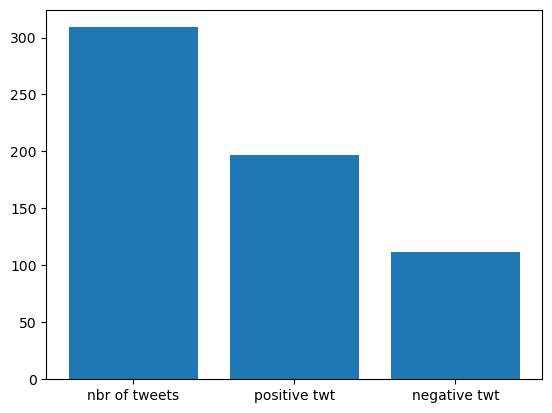

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Rabha95701752 ]
nombre of tweets : 310
nombre de positive tweets :  198
nombre de negative tweets  : 112
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-

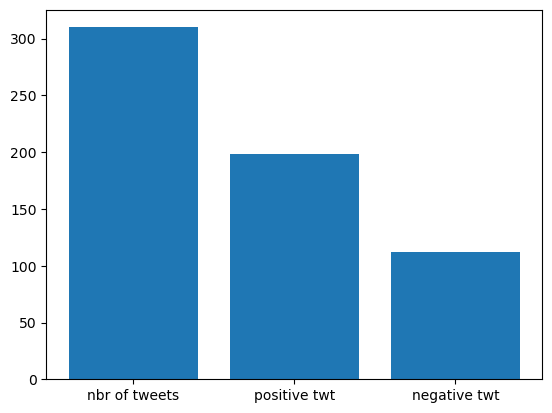

Insert data: [RT @realMaxAvery: @bull_bnb This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, ez_lic ]
nombre of tweets : 311
nombre de positive tweets :  199
nombre de negative tweets  : 112
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @bull_bnb, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--------

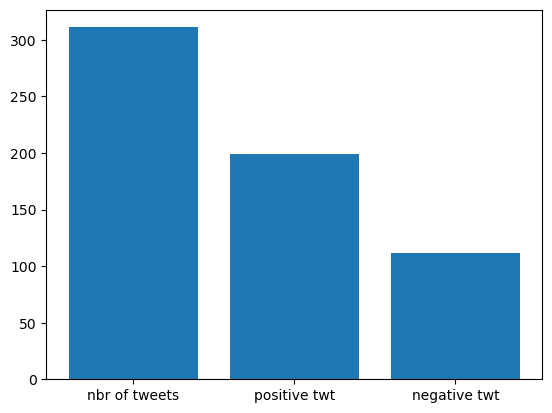

Insert data: [@Tesla_Kraken @CRIOLLOSHOWMAN @Javierito321 Tiene sentido, soycuzzone ]
nombre of tweets : 312
nombre de positive tweets :  199
nombre de negative tweets  : 113
+---------------------------------------------------------------------+----------+
|MeaningfulWords                                                      |prediction|
+---------------------------------------------------------------------+----------+
|["[""@tesla_kraken, @criolloshowman, @javierito321, tiene, sentido""]|0.0       |
+---------------------------------------------------------------------+----------+



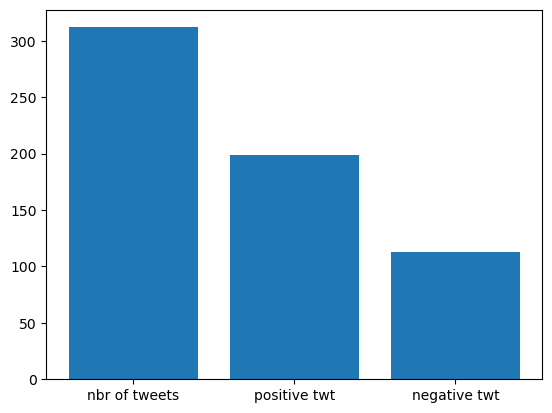

Insert data: [RT @realMaxAvery: @coingecko This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH…, TobiasHonza ]
nombre of tweets : 313
nombre de positive tweets :  199
nombre de negative tweets  : 114
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                          |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @coingecko, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------------------------

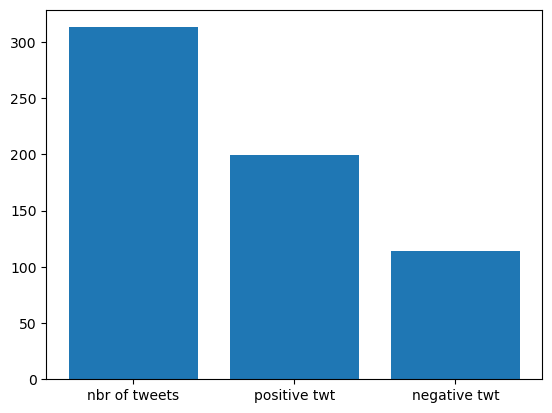

Insert data: [RT @davidtayar5: Evercore ISI lowers Tesla PT to $200

$TSLA, MikeFos88218598 ]
nombre of tweets : 314
nombre de positive tweets :  200
nombre de negative tweets  : 114
+--------------------------------------------------------------------------+----------+
|MeaningfulWords                                                           |prediction|
+--------------------------------------------------------------------------+----------+
|["[""rt, @davidtayar5:, evercore, isi, lowers, tesla, pt, $200\n\n$tsla""]|4.0       |
+--------------------------------------------------------------------------+----------+



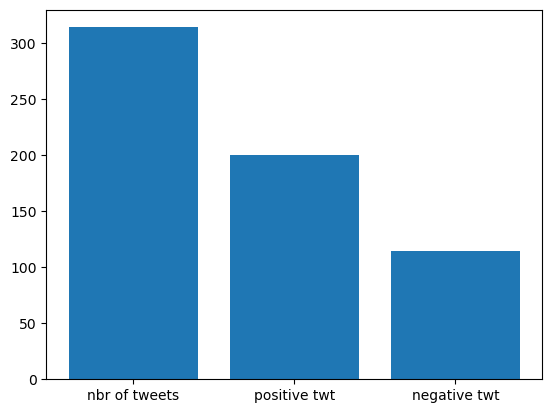

Insert data: [Wow. Not minor issues. Its worse than you think. #Tesla #Berlin https://t.co/BEfc1jqYI0, vertutentee ]
nombre of tweets : 315
nombre de positive tweets :  200
nombre de negative tweets  : 115
+-------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                      |prediction|
+-------------------------------------------------------------------------------------+----------+
|["[""wow., minor, issues., worse, think., #tesla, #berlin, https://t.co/befc1jqyi0""]|0.0       |
+-------------------------------------------------------------------------------------+----------+



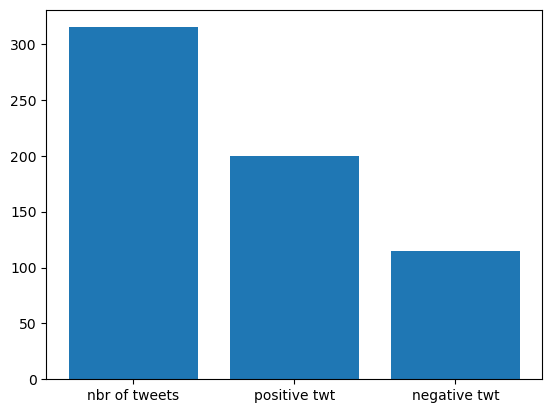

Insert data: [RT @CBSNews: Massachusetts Senator Elizabeth Warren is questioning whether Tesla's board is protecting the electric car company's sharehold…, anton_brakhage ]
nombre of tweets : 316
nombre de positive tweets :  201
nombre de negative tweets  : 115
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                              |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @cbsnews:, massachusetts, senator, elizabeth, warren, questioning, whether, tesla's, board, protecting, electric, car, company's, sharehold\u2026""]|4.0       |
+-----------------------------------------------------

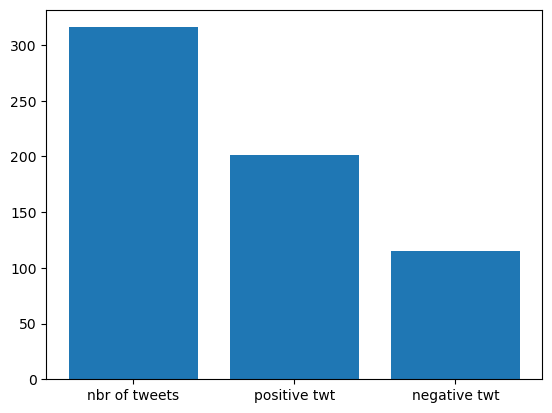

Insert data: [RT @duty2warn: Fun fact: the 62% decline in Tesla’s stock in 2022 destroyed a half a trillion dollars, DaveyBaby21603 ]
nombre of tweets : 317
nombre de positive tweets :  201
nombre de negative tweets  : 116
+----------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                 |prediction|
+----------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, fun, fact:, 62%, decline, tesla\u2019s, stock, 2022, destroyed, half, trillion, dollars""]|0.0       |
+----------------------------------------------------------------------------------------------------------------+----------+



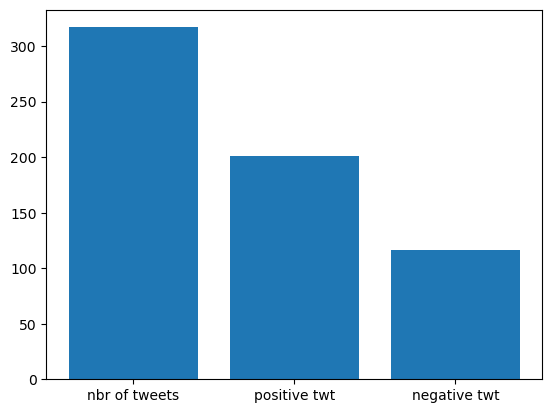

Insert data: [@lindyli It’s funny that you people who despise Elon and wish he fails, are the same ones still twitter and driving Tesla’s., JohnDuh55974078 ]
nombre of tweets : 318
nombre de positive tweets :  202
nombre de negative tweets  : 116
+--------------------------------------------------------------------+----------+
|MeaningfulWords                                                     |prediction|
+--------------------------------------------------------------------+----------+
|["[""@lindyli, it\u2019s, funny, people, despise, elon, wish, fails]|4.0       |
+--------------------------------------------------------------------+----------+



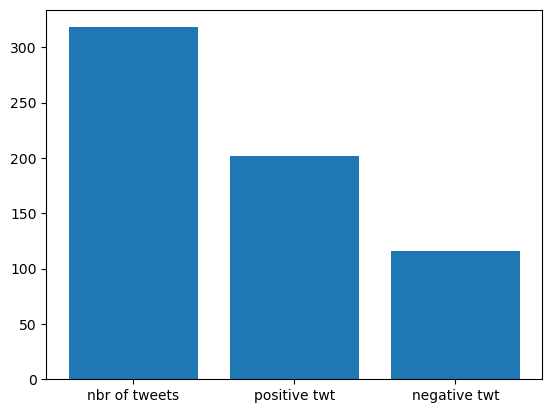

Insert data: [Not News, just another day at an Elmo company .....

https://t.co/MhVqIdDpHb, DebauchedInOz ]
nombre of tweets : 319
nombre de positive tweets :  203
nombre de negative tweets  : 116
+---------------+----------+
|MeaningfulWords|prediction|
+---------------+----------+
|["[""not, news]|4.0       |
+---------------+----------+



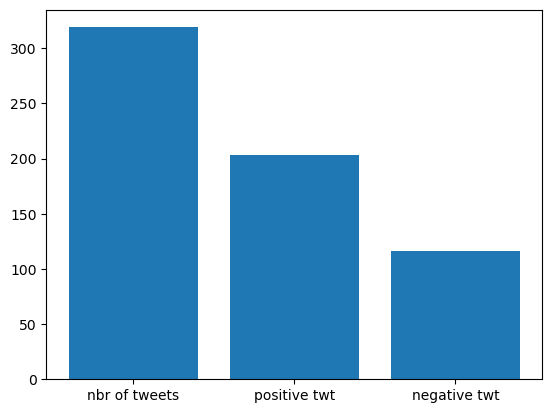

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, Lynn24339012 ]
nombre of tweets : 320
nombre de positive tweets :  203
nombre de negative tweets  : 117
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+--

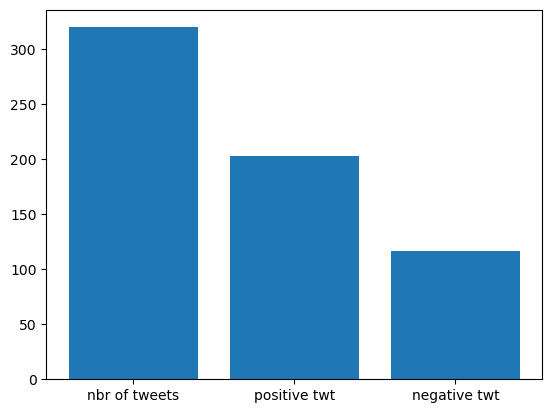

Insert data: [RT @SenWarren: Elon Musk took over @Twitter, but he's still the CEO of @Tesla. That raises legal concerns — is he creating conflicts of int…, MariaEvaJP ]
nombre of tweets : 321
nombre de positive tweets :  203
nombre de negative tweets  : 118
+-------------------------------------------------+----------+
|MeaningfulWords                                  |prediction|
+-------------------------------------------------+----------+
|["[""rt, @senwarren:, elon, musk, took, @twitter]|0.0       |
+-------------------------------------------------+----------+



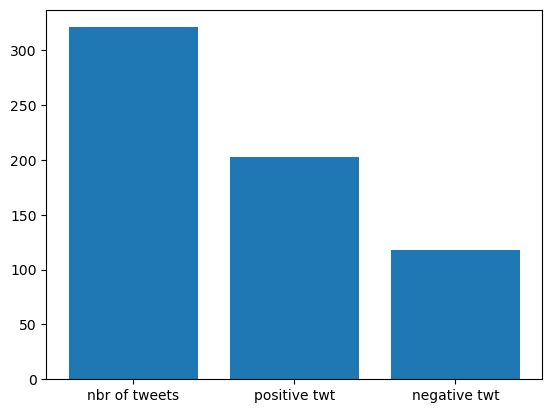

Insert data: [RT @EstherKokkelman: Have a great week @Tesla people from all over the world! https://t.co/zjWqeECHB8, HighLender ]
nombre of tweets : 322
nombre de positive tweets :  204
nombre de negative tweets  : 118
+-------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                            |prediction|
+-------------------------------------------------------------------------------------------+----------+
|["[""rt, @estherkokkelman:, great, week, @tesla, people, world!, https://t.co/zjwqeechb8""]|4.0       |
+-------------------------------------------------------------------------------------------+----------+



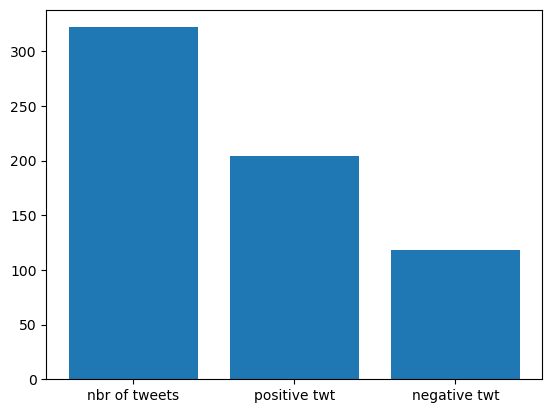

Insert data: [RT @realMaxAvery: @rovercrc This feels a lot like Christmas 🎅🎄🎅

To support crypto community, Tesla initiated 5.000 #BTC and 100.000 #ETH A…, MNghghf ]
nombre of tweets : 323
nombre de positive tweets :  204
nombre de negative tweets  : 119
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                         |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @realmaxavery:, @rovercrc, feels, lot, like, christmas, \ud83c\udf85\ud83c\udf84\ud83c\udf85\n\nto, support, crypto, community]|0.0       |
+----------------------------------------------------------------------------------------------------------------------------------------+-------

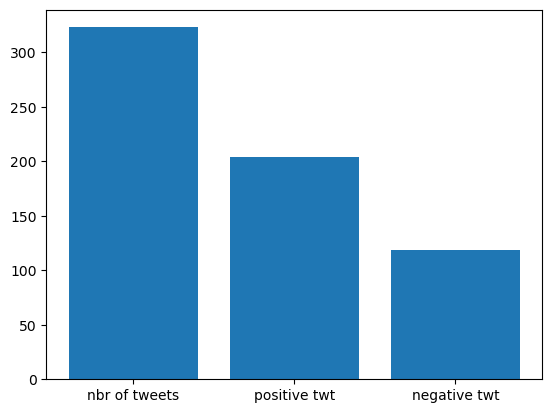

Insert data: [@elonmusk 

Elon, take this into thought. Instead of the financial funding for advancement of technology of in Tesla, you could establish a school of your own. This will contribute to solving humanities concerns in the future bc of brainstorming potential., icyycristian ]
nombre of tweets : 324
nombre de positive tweets :  205
nombre de negative tweets  : 119
+-------------------------+----------+
|MeaningfulWords          |prediction|
+-------------------------+----------+
|["[""@elonmusk, \n\nelon]|4.0       |
+-------------------------+----------+



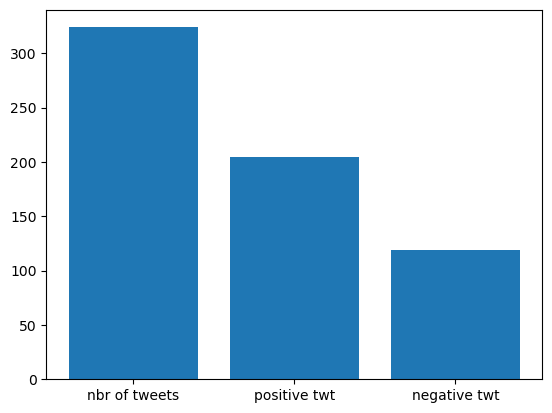

Insert data: [@TompaOlson @CnEVPost @XPengMotors @Tesla Im sure about it my friend!!!, CarlaGlow1 ]
nombre of tweets : 325
nombre de positive tweets :  206
nombre de negative tweets  : 119
+-------------------------------------------------------------------------+----------+
|MeaningfulWords                                                          |prediction|
+-------------------------------------------------------------------------+----------+
|["[""@tompaolson, @cnevpost, @xpengmotors, @tesla, im, sure, friend!!!""]|4.0       |
+-------------------------------------------------------------------------+----------+



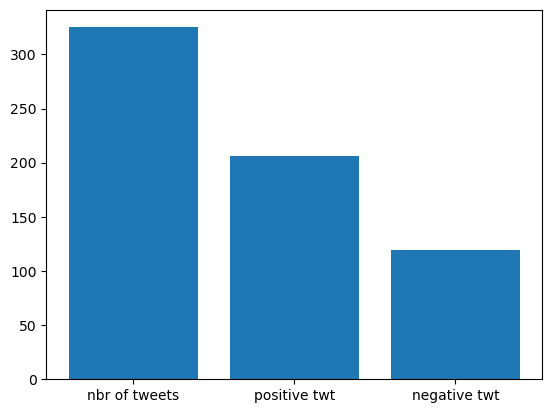

Insert data: [RT @Tesla: We’ve completed 500k+ Solar Panel and Solar Roof installations—that’s equal to ~4 GW of clean energy ☀️ https://t.co/Tjz6PzYuah, BoersenDE ]
nombre of tweets : 326
nombre de positive tweets :  207
nombre de negative tweets  : 119
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                  |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, we\u2019ve, completed, 500k+, solar, panel, solar, roof, installations\u2014that\u2019s, equal, ~4, gw, clean, energy, \u2600\ufe0f, https://t.co/tjz6pzy

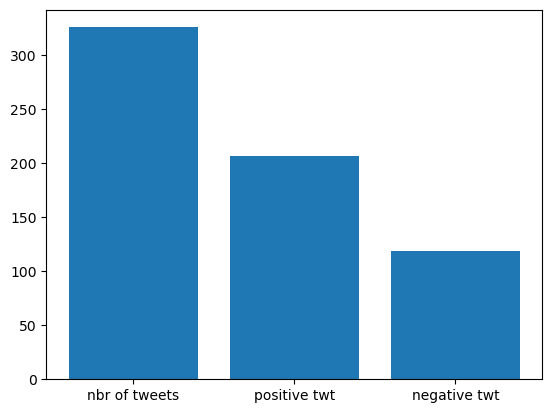

Insert data: [@girlsreallyrule Problem is, Tesla still has ads on Twitter. Collusion!, CarlMurx ]
nombre of tweets : 327
nombre de positive tweets :  208
nombre de negative tweets  : 119
+-------------------------------+----------+
|MeaningfulWords                |prediction|
+-------------------------------+----------+
|["[""@girlsreallyrule, problem]|4.0       |
+-------------------------------+----------+



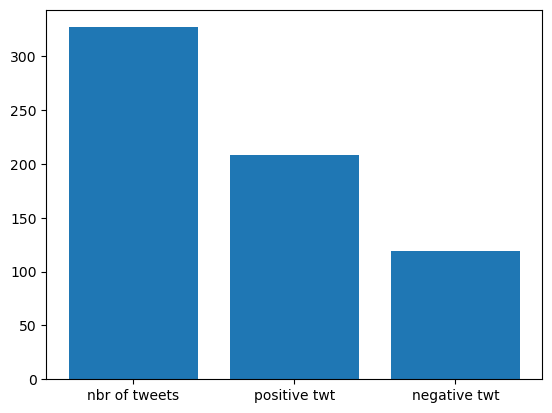

Insert data: [@squawksquare I need vasoline from all this raping I’m getting from Tesla, makisig31 ]
nombre of tweets : 328
nombre de positive tweets :  209
nombre de negative tweets  : 119
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""@squawksquare, need, vasoline, raping, i\u2019m, getting, tesla""]|4.0       |
+-----------------------------------------------------------------------+----------+



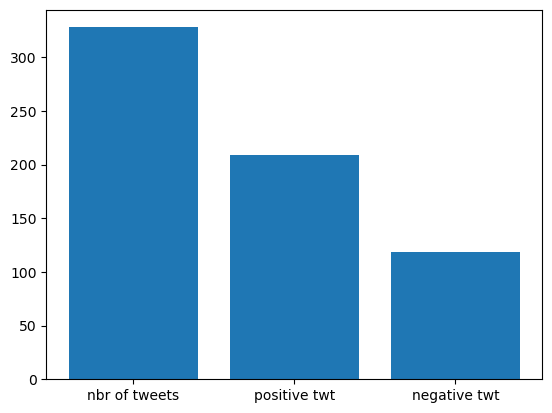

Insert data: [RT @ideafaktory: One day a year, Blue subscribers should be allowed to hunt nonsubscribers with crossbows. It's the only way they'll know t…, ideafaktory ]
nombre of tweets : 329
nombre de positive tweets :  209
nombre de negative tweets  : 120
+---------------------------------------+----------+
|MeaningfulWords                        |prediction|
+---------------------------------------+----------+
|["[""rt, @ideafaktory:, one, day, year]|0.0       |
+---------------------------------------+----------+



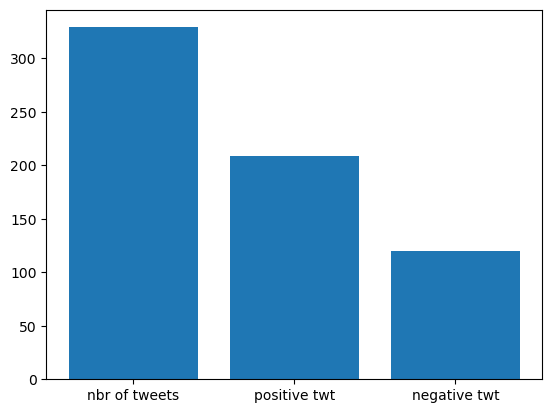

Insert data: [@Tesla @elonmusk What about after its been outside all night after snow storm?, myworldview77 ]
nombre of tweets : 330
nombre de positive tweets :  209
nombre de negative tweets  : 121
+-------------------------------------------------------+----------+
|MeaningfulWords                                        |prediction|
+-------------------------------------------------------+----------+
|["[""@tesla, @elonmusk, outside, night, snow, storm?""]|0.0       |
+-------------------------------------------------------+----------+



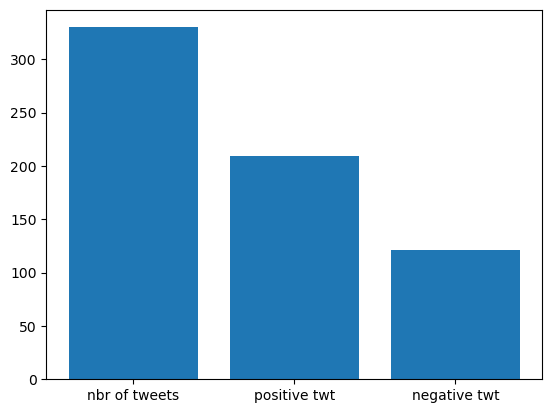

Insert data: [RT @andst7: Italy's historic newspaper Corriere Della Sera, countertrends other mainstream media and announced its Person of the Year: Elon…, 1Mariey ]
nombre of tweets : 331
nombre de positive tweets :  210
nombre de negative tweets  : 121
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""rt, @andst7:, italy's, historic, newspaper, corriere, della, sera]|4.0       |
+-----------------------------------------------------------------------+----------+



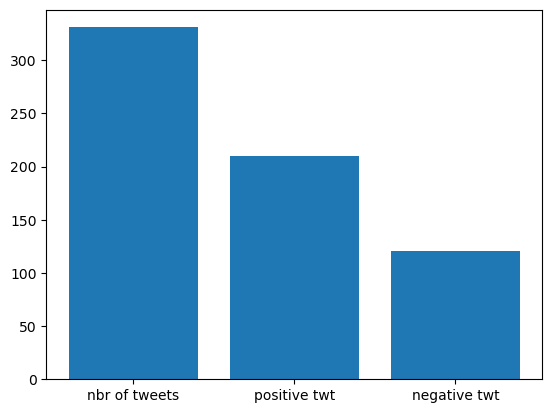

Insert data: [RT @jayrosen_nyu: Wall Street analyst for Oppenheimer, explaining why the firm downgraded Tesla's rating, says the owner of Twitter is gene…, C_Holler ]
nombre of tweets : 332
nombre de positive tweets :  211
nombre de negative tweets  : 121
+------------------------------------------------------------+----------+
|MeaningfulWords                                             |prediction|
+------------------------------------------------------------+----------+
|["[""rt, @jayrosen_nyu:, wall, street, analyst, oppenheimer]|4.0       |
+------------------------------------------------------------+----------+



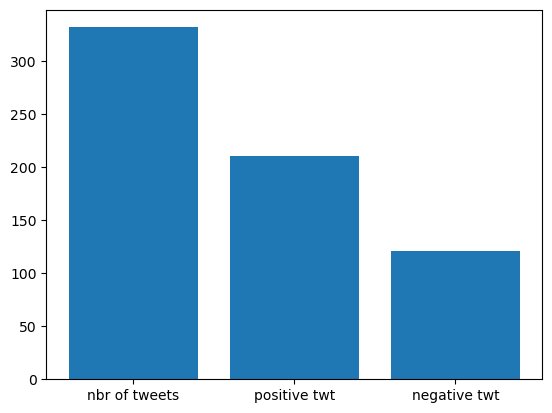

Insert data: [RT @AdamParkhomenko: Elon Musk humiliated himself again, deleted his bio and hasn’t tweeted in 17 hours. Tesla stock is down again. What a…, _dazz_l ]
nombre of tweets : 333
nombre de positive tweets :  212
nombre de negative tweets  : 121
+---------------------------------------------------+----------+
|MeaningfulWords                                    |prediction|
+---------------------------------------------------+----------+
|["[""rt, @adamparkhomenko:, elon, musk, humiliated]|4.0       |
+---------------------------------------------------+----------+



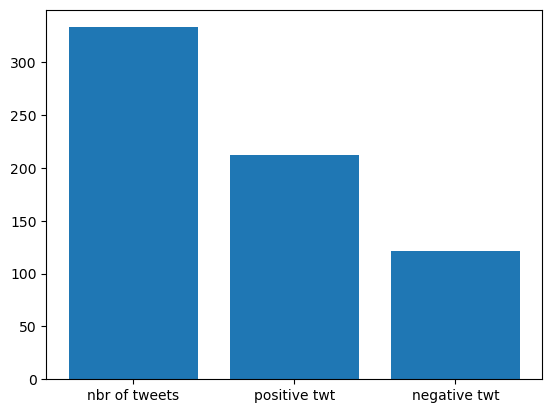

Insert data: [RT @MarketMaven2022: $TSLA energy also has autobidder. For those of you that don’t know what it is, it basically allows customers to sell t…, jeongseonung ]
nombre of tweets : 334
nombre de positive tweets :  213
nombre de negative tweets  : 121
+-------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                |prediction|
+-------------------------------------------------------------------------------+----------+
|["[""rt, @marketmaven2022:, $tsla, energy, also, autobidder., don\u2019t, know]|4.0       |
+-------------------------------------------------------------------------------+----------+



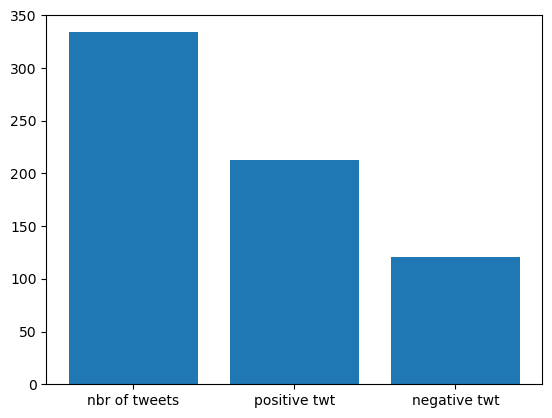

Insert data: [@gm_currency @vanessasierra00 Also "Tesla lithium-ion batteries are fully recycled. None of the materials go into a landfill as long as you recycle them properly. This means returning them to a Tesla service center.", YouWishNFT ]
nombre of tweets : 335
nombre de positive tweets :  214
nombre de negative tweets  : 121
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                        |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@gm_currency, @vaness

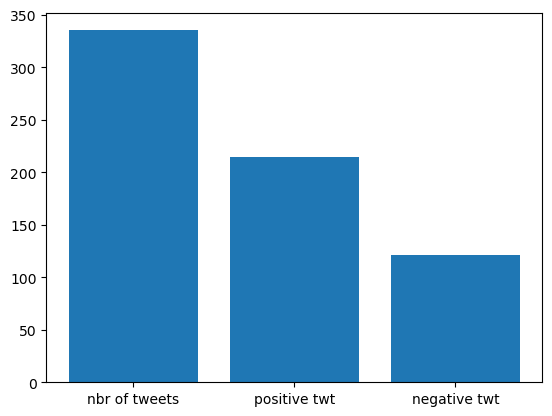

Insert data: [RT @SarahBCalif: @neiltyson @elonmusk Elon has invented nothing. 

“Tesla Motors was first founded by Martin Eberhard and Marc Tarpenning,…, wnorton ]
nombre of tweets : 336
nombre de positive tweets :  214
nombre de negative tweets  : 122
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sarahbcalif:, @neiltyson, @elonmusk, elon, invented, nothing., \n\n\u201ctesla, motors, first, founded, martin, eberhard, marc, tarpenning]|0.0       |
+---------------------------------------------------------------------------------------------

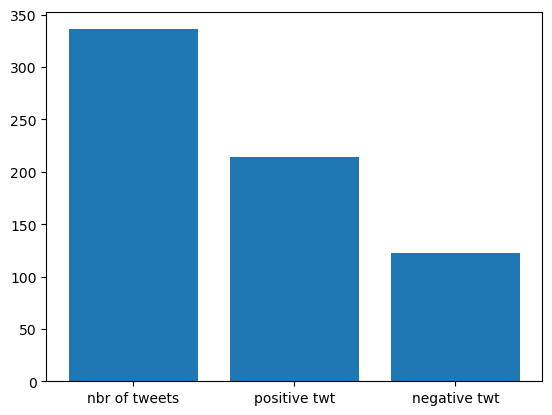

Insert data: [RT @CurieuxExplorer: What to know about #Tesla's batteries

https://t.co/Ay4gcvXyR2 
@FrRonconi @labordeolivier @Nicochan33 @PawlowskiMario…, labordeolivier ]
nombre of tweets : 337
nombre de positive tweets :  215
nombre de negative tweets  : 122
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                       |prediction|
+------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @curieuxexplorer:, know, #tesla's, batteries\n\nhttps://t.co/ay4gcvxyr2, \n@frronconi, @labordeolivier, @nicochan33, @pawlowskimario\u2026""]|4.0       |
+---------------------------------------------------------------------------------

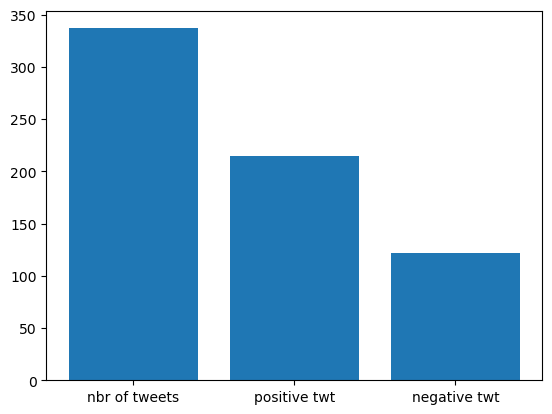

Insert data: [RT @Nairametrics: What it takes to buy a Tesla in Nigeria - https://t.co/e9mtTXwCId https://t.co/u9tIOvCBSn, JAS2GREEN ]
nombre of tweets : 338
nombre de positive tweets :  216
nombre de negative tweets  : 122
+-----------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                            |prediction|
+-----------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @nairametrics:, takes, buy, tesla, nigeria, -, https://t.co/e9mttxwcid, https://t.co/u9tiovcbsn""]|4.0       |
+-----------------------------------------------------------------------------------------------------------+----------+



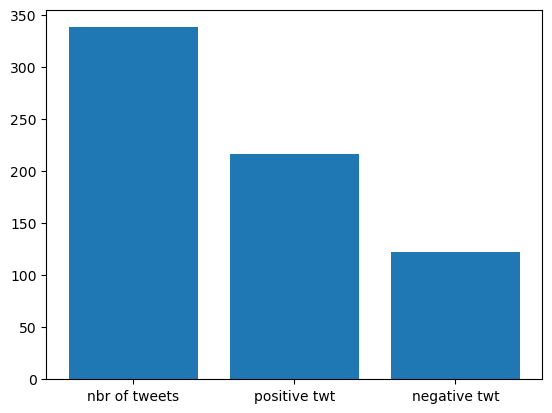

Insert data: [If you ever wonder how much Tesla folks are actually saving on gas.. this about 3 weeks worth https://t.co/WIIlUFn51T, AstronautRickyy ]
nombre of tweets : 339
nombre de positive tweets :  217
nombre de negative tweets  : 122
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""if, ever, wonder, much, tesla, folks, actually, saving, gas.., 3, weeks, worth, https://t.co/wiilufn51t""]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



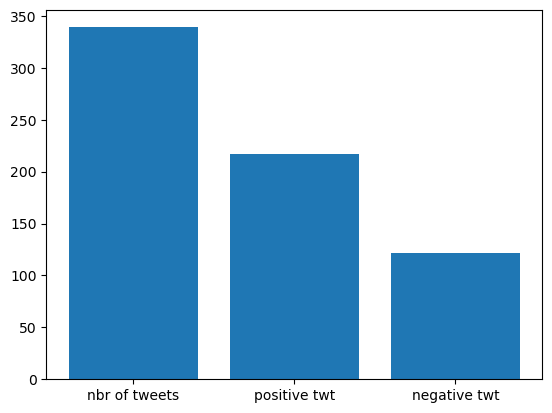

Insert data: [RT @lopezlinette: How do I know so much about how @elonmusk does things? I spent 3 years investigating Tesla at @BusinessInsider from 2018-…, MarcDavenant ]
nombre of tweets : 340
nombre de positive tweets :  217
nombre de negative tweets  : 123
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @lopezlinette:, know, much, @elonmusk, things?, spent, 3, years, investigating, tesla, @businessinsider, 2018-\u2026""]|0.0       |
+--------------------------------------------------------------------------------------------------------------------------------+----------+



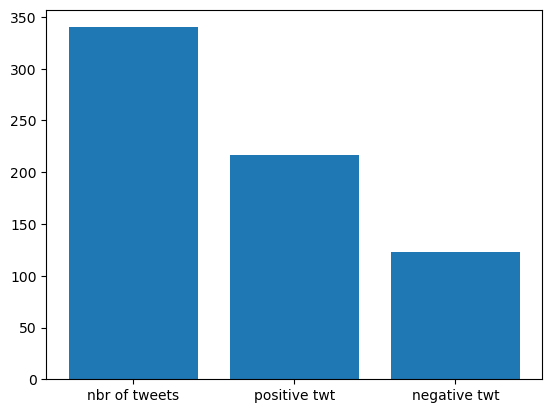

Insert data: [@Wind_is_Howling @freshjiva @elonmusk @heydave7 When @Tesla went public, that motivation had to change to defend $TSLA., inTheMtnWood ]
nombre of tweets : 341
nombre de positive tweets :  218
nombre de negative tweets  : 123
+------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                               |prediction|
+------------------------------------------------------------------------------+----------+
|["[""@wind_is_howling, @freshjiva, @elonmusk, @heydave7, @tesla, went, public]|4.0       |
+------------------------------------------------------------------------------+----------+



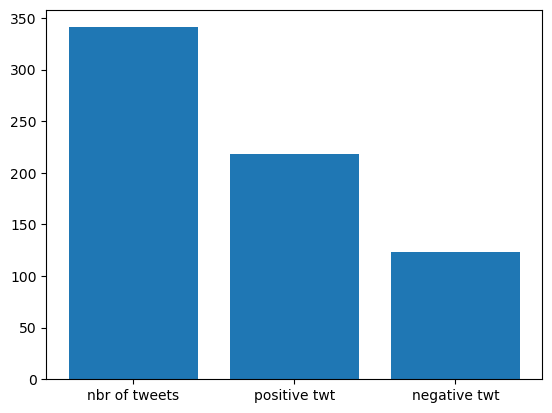

Insert data: [RT @pfbt: @NigheanEilidh @Tesla @elonmusk When the battery is working properly it’s brilliant. Horrified at @tesla’s appalling after sales…, jchimselfbigpo2 ]
nombre of tweets : 342
nombre de positive tweets :  218
nombre de negative tweets  : 124
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @pfbt:, @nigheaneilidh, @tesla, @elonmusk, battery, working, properly, it\u2019s, brilliant., horrified, @tesla\u2019s, appalling, sales\u2026""]|0.0       |
+-----------------------------------------------------------------

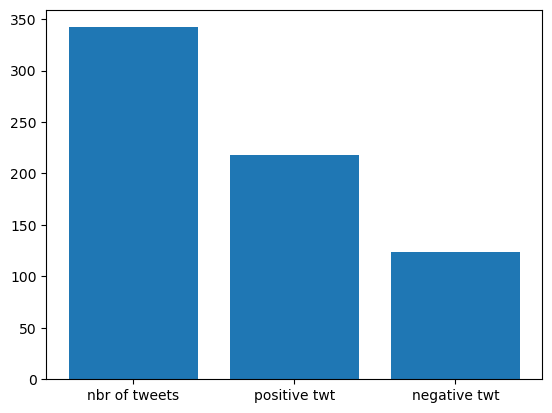

Insert data: [RT @jasondebolt: I’ve always been a mission focused investor, not a profit/wealth focused one. What Tesla is doing is incredibly important…, Milagaai ]
nombre of tweets : 343
nombre de positive tweets :  219
nombre de negative tweets  : 124
+----------------------------------------------------------------------+----------+
|MeaningfulWords                                                       |prediction|
+----------------------------------------------------------------------+----------+
|["[""rt, @jasondebolt:, i\u2019ve, always, mission, focused, investor]|4.0       |
+----------------------------------------------------------------------+----------+



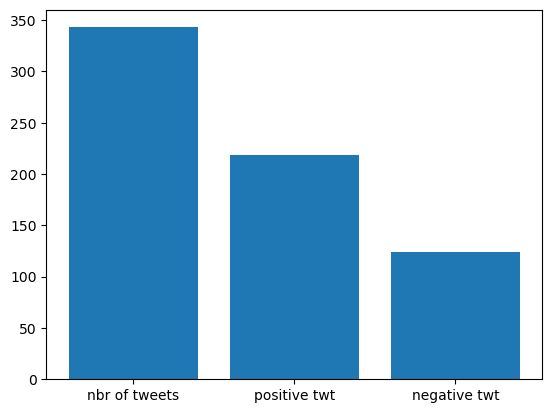

Insert data: [Tesla stock is in freefall, Boring isn't turning up to fulfill contracts, Neuralink in under federal investigation for animal cruelty. https://t.co/B1qn9IE7eO, CommieCountry ]
nombre of tweets : 344
nombre de positive tweets :  219
nombre de negative tweets  : 125
+----------------------------+----------+
|MeaningfulWords             |prediction|
+----------------------------+----------+
|["[""tesla, stock, freefall]|0.0       |
+----------------------------+----------+



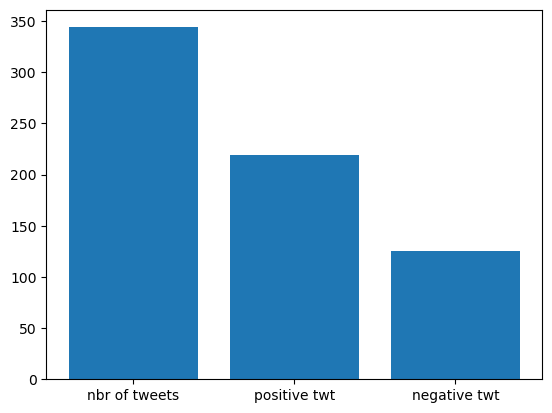

Insert data: [@TESLA_CREADOR Buenos días, Jose98461004 ]
nombre of tweets : 345
nombre de positive tweets :  220
nombre de negative tweets  : 125
+-----------------------------------------+----------+
|MeaningfulWords                          |prediction|
+-----------------------------------------+----------+
|["[""@tesla_creador, buenos, d\u00edas""]|4.0       |
+-----------------------------------------+----------+



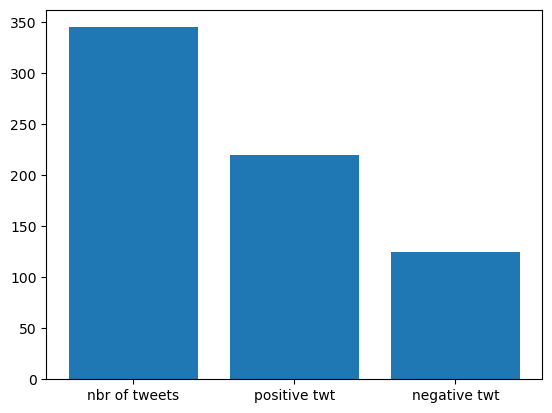

Insert data: [#haber #SONDAKIKA #Irak #yks22 #GizliSakli #Kiew #tcmeb #enflasyon #Tesla #Ukraine #DuyBeni #Zaho #Ukraine #iPhone14Pro #iPhone14 #mtv https://t.co/01aLlYl0JI, FalconHaber ]
nombre of tweets : 346
nombre de positive tweets :  221
nombre de negative tweets  : 125
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                       |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""#haber, #sondakika, #irak, #yks22, #gizlisakli, #kiew, #tcmeb, #enflasyon, #tesla, #ukraine, #duybeni, #zaho, #ukraine, #iphone14

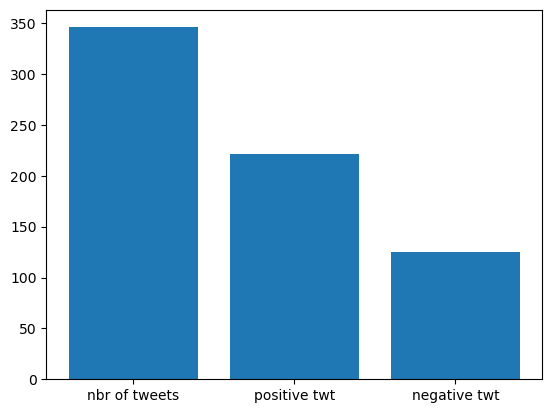

Insert data: [@TeeTee_tesla あと2 weeks, teslaloha ]
nombre of tweets : 347
nombre de positive tweets :  222
nombre de negative tweets  : 125
+-------------------------------------------+----------+
|MeaningfulWords                            |prediction|
+-------------------------------------------+----------+
|["[""@teetee_tesla, \u3042\u30682, weeks""]|4.0       |
+-------------------------------------------+----------+



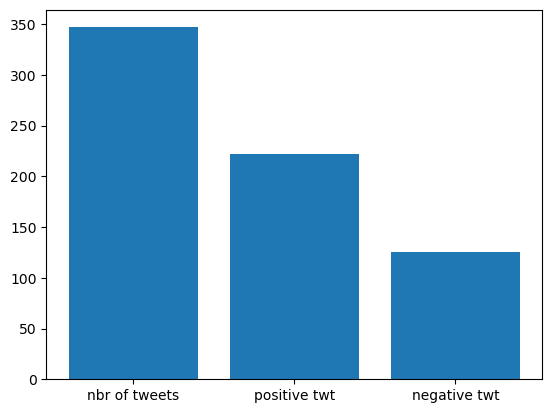

Insert data: [@Rous160967 Muy buenos Rous, TESLA_CREADOR ]
nombre of tweets : 348
nombre de positive tweets :  223
nombre de negative tweets  : 125
+--------------------------------------+----------+
|MeaningfulWords                       |prediction|
+--------------------------------------+----------+
|["[""@rous160967, muy, buenos, rous""]|4.0       |
+--------------------------------------+----------+



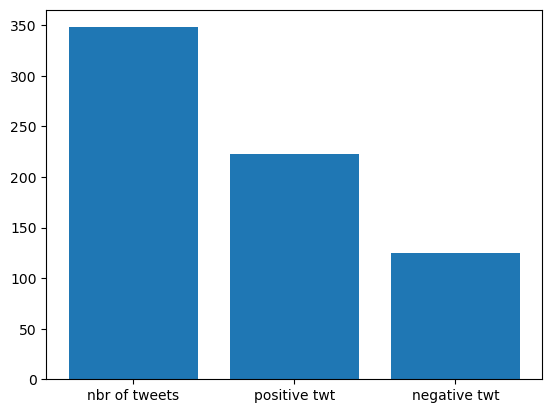

Insert data: [@ramblalibre_com Jajaja. Voy a comprar acciones el las papeleras de los mercados internacionales , porque todos nos cagamos en lo mismo! Olvidaos de APPLE y Tesla! 😂, carpediemSXXI ]
nombre of tweets : 349
nombre de positive tweets :  224
nombre de negative tweets  : 125
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""@ramblalibre_com, jajaja., voy, comprar, acciones, el, las, papeleras, de, los, mercados, internacionales]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



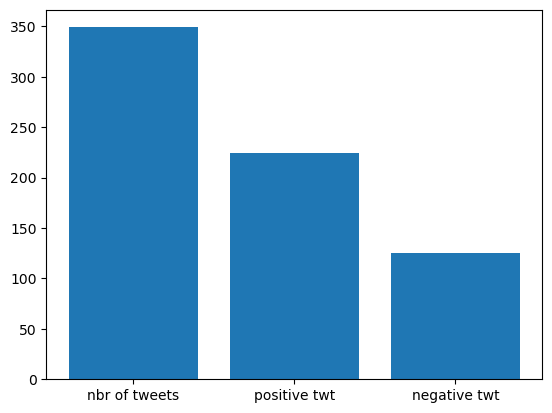

Insert data: [RT @duty2warn: Glad she used the phrase "divorced from reality." Everything Musk has done, since the Twitter purchase, is emulative of the…, battleriverbabe ]
nombre of tweets : 350
nombre de positive tweets :  225
nombre de negative tweets  : 125
+-------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                            |prediction|
+-------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, glad, used, phrase, \""divorced, reality.\"", everything, musk, done]|4.0       |
+-------------------------------------------------------------------------------------------+----------+



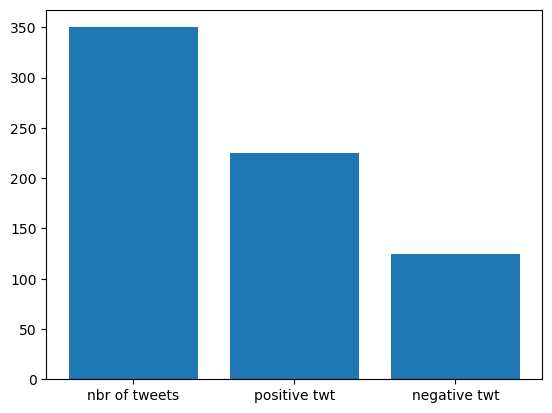

Insert data: [Tesla Model S Rear Left Door Shell https://t.co/dFBu18Udyh eBay https://t.co/WZ4N9PlQRI, car_trims ]
nombre of tweets : 351
nombre de positive tweets :  225
nombre de negative tweets  : 126
+-----------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------+----------+
|["[""tesla, model, rear, left, door, shell, https://t.co/dfbu18udyh, ebay, https://t.co/wz4n9plqri""]|0.0       |
+-----------------------------------------------------------------------------------------------------+----------+



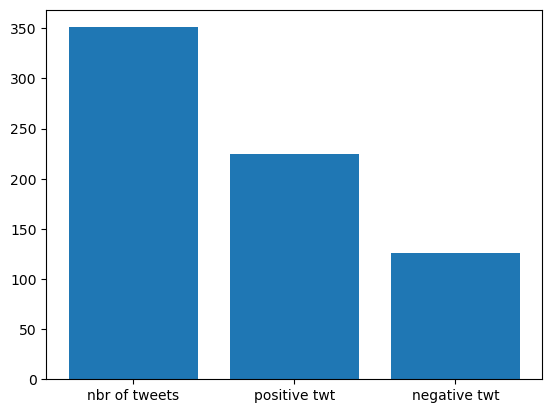

Insert data: [RT @Quinnae_Moon: What's happening is that he is, at best, maliciously complying with the poll and *languidly* slow-walking a resignation.…, otdderamin ]
nombre of tweets : 352
nombre de positive tweets :  225
nombre de negative tweets  : 127
+-----------------------------------+----------+
|MeaningfulWords                    |prediction|
+-----------------------------------+----------+
|["[""rt, @quinnae_moon:, happening]|0.0       |
+-----------------------------------+----------+



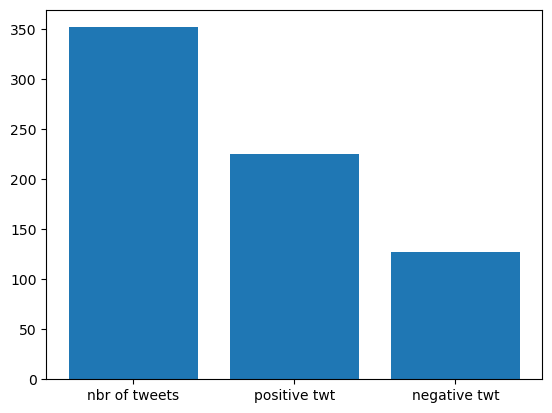

Insert data: [@DrfauxiC @TanerSteve ROTFLMAO.  Nope.  I wouldn't refer to a tesla at all.  Just like I wouldn't bother trying to save your life.  You're a waste of oxygen, KDallas21509815 ]
nombre of tweets : 353
nombre de positive tweets :  226
nombre de negative tweets  : 127
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@drfauxic, @tanersteve, rotflmao., , nope., , refer, tesla, all., , like, bother, trying, save, life., , waste, oxygen""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------------+----------+



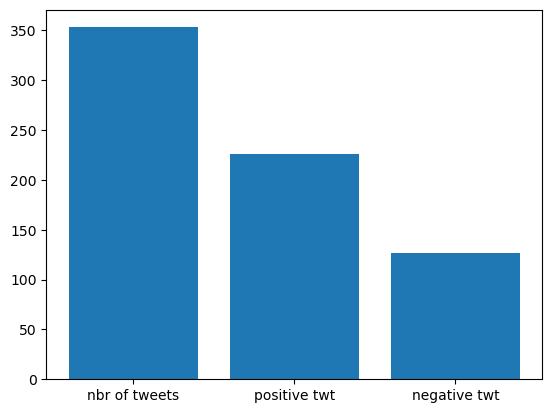

Insert data: [RT @BriannaWu: TESLA STOCK PRICE OFFICIALLY AT $139. Tesla's most famous investors calling for the board to fire Musk. "This stock price re…, CathyGTexas ]
nombre of tweets : 354
nombre de positive tweets :  226
nombre de negative tweets  : 128
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, tesla, stock, price, officially, $139., tesla's, famous, investors, calling, board, fire, musk., \""this, stock, price, re\u2026""]|0.0       |
+------------------------------------------------------------------------

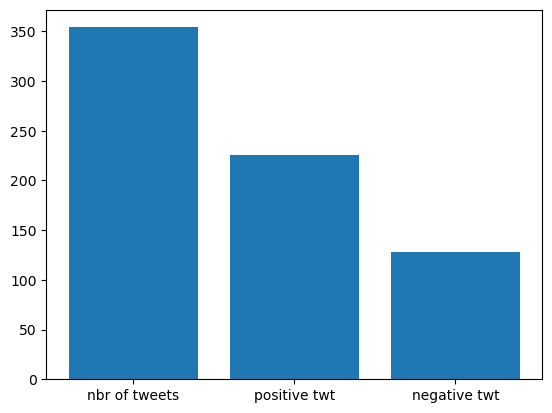

Insert data: [RT @Nairametrics: What it takes to buy a Tesla in Nigeria - https://t.co/e9mtTXwCId https://t.co/u9tIOvCBSn, JAS2GREEN ]
nombre of tweets : 355
nombre de positive tweets :  227
nombre de negative tweets  : 128
+-----------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                            |prediction|
+-----------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @nairametrics:, takes, buy, tesla, nigeria, -, https://t.co/e9mttxwcid, https://t.co/u9tiovcbsn""]|4.0       |
+-----------------------------------------------------------------------------------------------------------+----------+



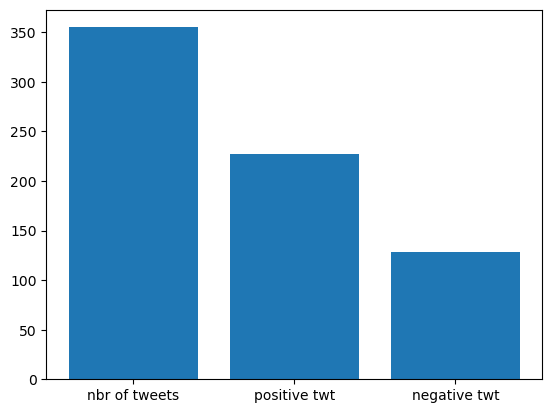

Insert data: [@bigbird3420 @elisa1121 @SenWarren @Twitter @Tesla @TheDemocrats Donkeys and Rhinos never give back their bribes, it was the Donkeys who got the majority of SBF’s bribes. https://t.co/eFFewou1zF, MrButtHead75 ]
nombre of tweets : 356
nombre de positive tweets :  227
nombre de negative tweets  : 129
+-----------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                        |prediction|
+-----------------------------------------------------------------------------------------------------------------------+----------+
|["[""@bigbird3420, @elisa1121, @senwarren, @twitter, @tesla, @thedemocrats, donkeys, rhinos, never, give, back, bribes]|0.0       |
+-----------------------------------------------------------------------------------------------------------------------+----------+



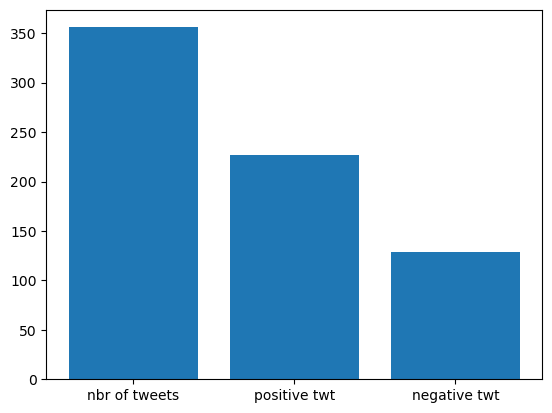

Insert data: [RT @DougJBalloon: If the government won’t bail out my Tesla losses, I’m going to become an even bigger libertarian., L3CA ]
nombre of tweets : 357
nombre de positive tweets :  228
nombre de negative tweets  : 129
+---------------------------------------------------------------------+----------+
|MeaningfulWords                                                      |prediction|
+---------------------------------------------------------------------+----------+
|["[""rt, @dougjballoon:, government, won\u2019t, bail, tesla, losses]|4.0       |
+---------------------------------------------------------------------+----------+



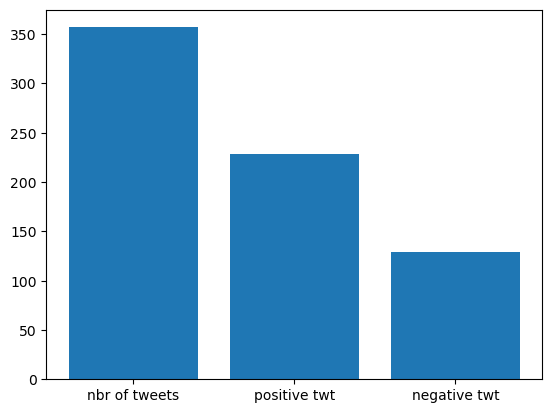

Insert data: [@garyblack00 This Tesla vs QQQ with @elonmusk selling Tesla. With TX &amp; Berlin ramp behind schedule (should be 5k/wk not 3k), Tesla is not running well. Chinese engrs won’t help much. Culture is different. Look at what $TSM did. Send Taiwanese engrs to run US Fab. He needs to be onsite. https://t.co/P7z0bBiuQ2, raikk61 ]
nombre of tweets : 358
nombre de positive tweets :  229
nombre de negative tweets  : 129
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@garyblack00, tesla, vs, qqq, @elonmusk, selling, tesla., tx, &amp;, berlin, ramp, behind, schedule, (should, 5k/wk, 3k)]|4.0       |
+----------

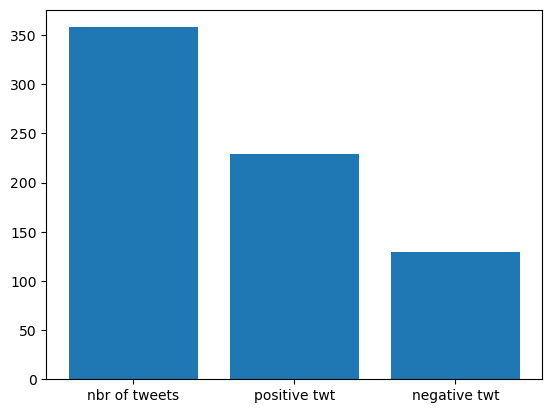

Insert data: [RT @SarahBCalif: @neiltyson @elonmusk Elon has invented nothing. 

“Tesla Motors was first founded by Martin Eberhard and Marc Tarpenning,…, tami32961 ]
nombre of tweets : 359
nombre de positive tweets :  229
nombre de negative tweets  : 130
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                      |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @sarahbcalif:, @neiltyson, @elonmusk, elon, invented, nothing., \n\n\u201ctesla, motors, first, founded, martin, eberhard, marc, tarpenning]|0.0       |
+-------------------------------------------------------------------------------------------

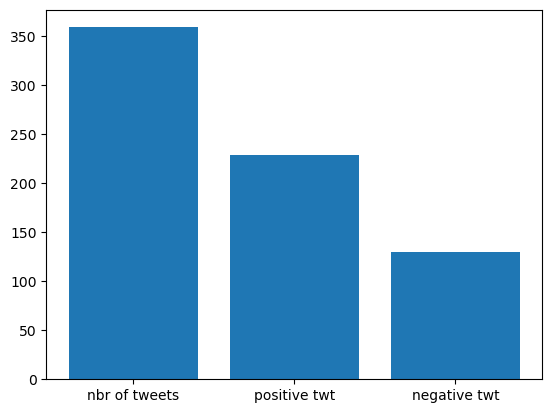

Insert data: [RT @Quinnae_Moon: What's happening is that he is, at best, maliciously complying with the poll and *languidly* slow-walking a resignation.…, tristanbergh ]
nombre of tweets : 360
nombre de positive tweets :  229
nombre de negative tweets  : 131
+-----------------------------------+----------+
|MeaningfulWords                    |prediction|
+-----------------------------------+----------+
|["[""rt, @quinnae_moon:, happening]|0.0       |
+-----------------------------------+----------+



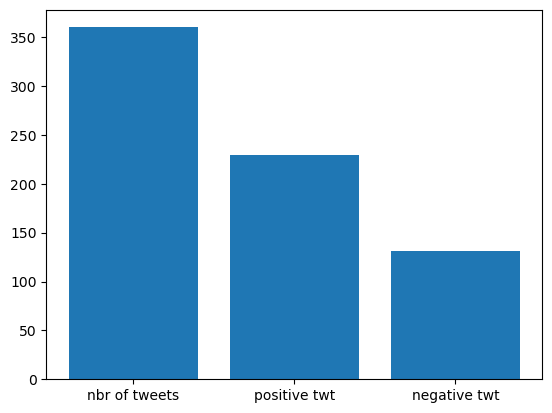

Insert data: [Tesla เปิดรับสมัครคนลงทุนเป็นจุด Supercharger ในไทย https://t.co/hQewnTgc2K, hybridknight ]
nombre of tweets : 361
nombre de positive tweets :  230
nombre de negative tweets  : 131
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""tesla, \u0e40\u0e1b\u0e34\u0e14

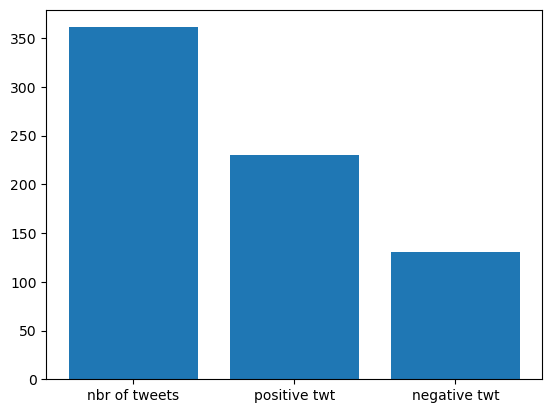

Insert data: [@TeeTee_tesla あと2 weeks, teslaloha ]
nombre of tweets : 362
nombre de positive tweets :  231
nombre de negative tweets  : 131
+-------------------------------------------+----------+
|MeaningfulWords                            |prediction|
+-------------------------------------------+----------+
|["[""@teetee_tesla, \u3042\u30682, weeks""]|4.0       |
+-------------------------------------------+----------+



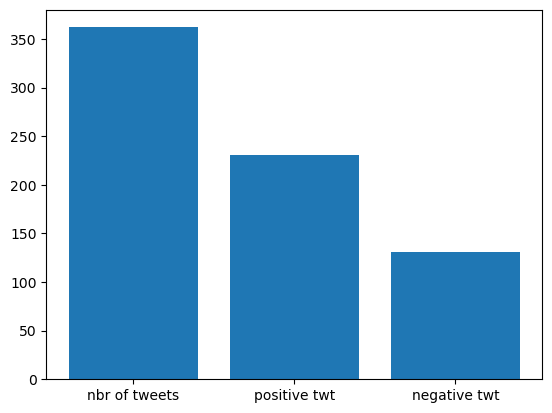

Insert data: [@Rous160967 Muy buenos Rous, TESLA_CREADOR ]
nombre of tweets : 363
nombre de positive tweets :  232
nombre de negative tweets  : 131
+--------------------------------------+----------+
|MeaningfulWords                       |prediction|
+--------------------------------------+----------+
|["[""@rous160967, muy, buenos, rous""]|4.0       |
+--------------------------------------+----------+



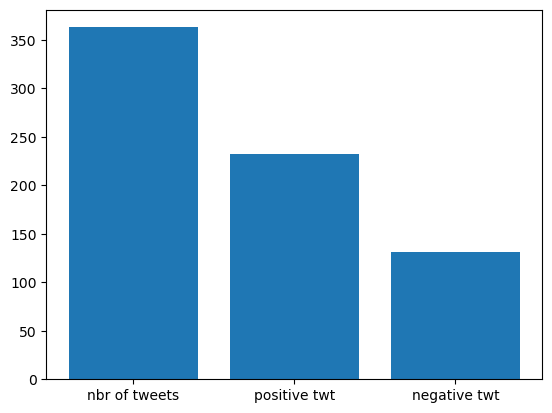

Insert data: [🛡️ Cuando un Tesla en piloto automático mata a alguien, ¿quién es el responsable? https://t.co/8qM6nT7zO3, LaCronologia ]
nombre of tweets : 364
nombre de positive tweets :  233
nombre de negative tweets  : 131
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                   |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|[["ud83dudee1ufe0f, cuando, un, tesla, en, piloto, automu00e1tico, mata, alguien,, u00bfquiu00e9n, es, el, responsable?, https://t.co/8qm6nt7zo3"]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------------------

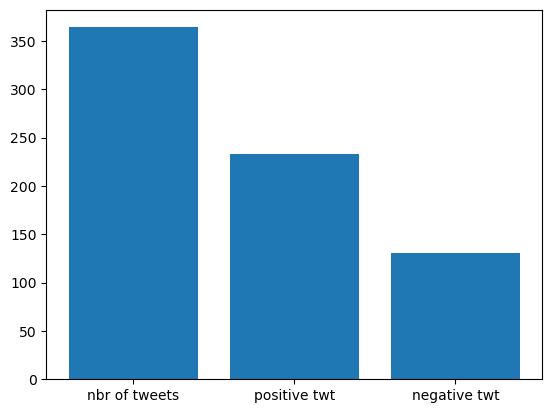

Insert data: [RT @duty2warn: Glad she used the phrase "divorced from reality." Everything Musk has done, since the Twitter purchase, is emulative of the…, battleriverbabe ]
nombre of tweets : 365
nombre de positive tweets :  234
nombre de negative tweets  : 131
+-------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                            |prediction|
+-------------------------------------------------------------------------------------------+----------+
|["[""rt, @duty2warn:, glad, used, phrase, \""divorced, reality.\"", everything, musk, done]|4.0       |
+-------------------------------------------------------------------------------------------+----------+



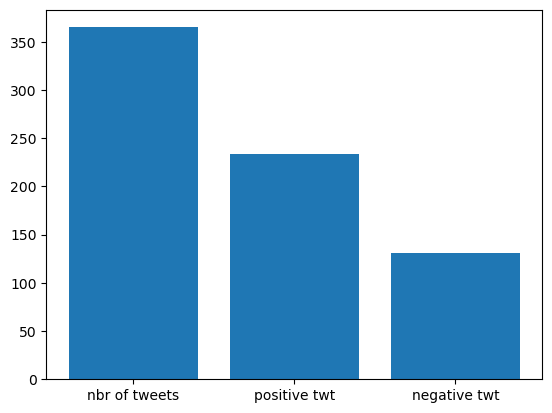

Insert data: [RT @BriannaWu: TESLA STOCK PRICE OFFICIALLY AT $139. Tesla's most famous investors calling for the board to fire Musk. "This stock price re…, MexSkeptic ]
nombre of tweets : 366
nombre de positive tweets :  234
nombre de negative tweets  : 132
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @briannawu:, tesla, stock, price, officially, $139., tesla's, famous, investors, calling, board, fire, musk., \""this, stock, price, re\u2026""]|0.0       |
+-------------------------------------------------------------------------

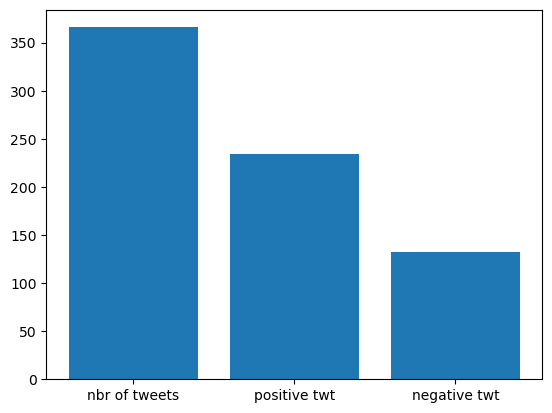

Insert data: [@DrfauxiC @TanerSteve ROTFLMAO.  Nope.  I wouldn't refer to a tesla at all.  Just like I wouldn't bother trying to save your life.  You're a waste of oxygen, KDallas21509815 ]
nombre of tweets : 367
nombre de positive tweets :  235
nombre de negative tweets  : 132
+------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                               |prediction|
+------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@drfauxic, @tanersteve, rotflmao., , nope., , refer, tesla, all., , like, bother, trying, save, life., , waste, oxygen""]|4.0       |
+------------------------------------------------------------------------------------------------------------------------------+----------+



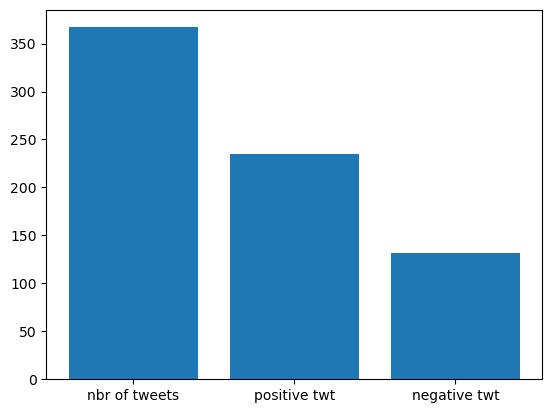

Insert data: [@elonmusk You can promote someone you trust from Tesla. This will help you I guess., ArslaanAnwer ]
nombre of tweets : 368
nombre de positive tweets :  236
nombre de negative tweets  : 132
+----------------------------------------------------------------+----------+
|MeaningfulWords                                                 |prediction|
+----------------------------------------------------------------+----------+
|["[""@elonmusk, promote, someone, trust, tesla., help, guess.""]|4.0       |
+----------------------------------------------------------------+----------+



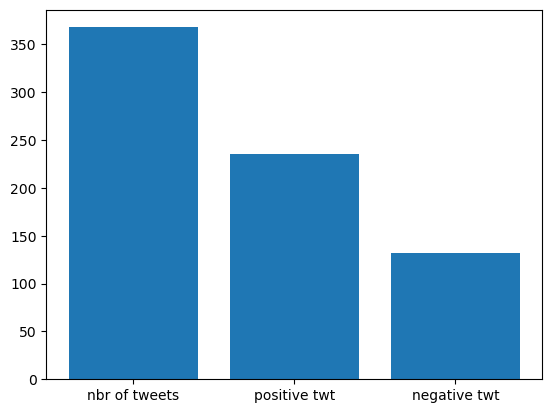

Insert data: [انا بنطاق الراحه بيبي ب غرفه 69, Tesla_Muz ]
nombre of tweets : 369
nombre de positive tweets :  236
nombre de negative tweets  : 133
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                       |prediction|
+--------------------------------------------------------------------------------------------------------------------------------------+----------+
|[["u0627u0646u0627, u0628u0646u0637u0627u0642, u0627u0644u0631u0627u062du0647, u0628u064au0628u064a, u0628, u063au0631u0641u0647, 69"]|0.0       |
+--------------------------------------------------------------------------------------------------------------------------------------+----------+



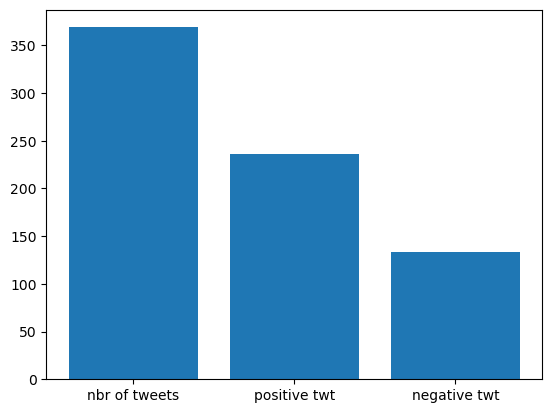

Insert data: [RT @ultimominutoOTC: Cathie Wood de ARKK compró 19,125 acciones de TESLA ayer.

#ARK #Tesla $TSLA, frantz_oriental ]
nombre of tweets : 370
nombre de positive tweets :  237
nombre de negative tweets  : 133
+--------------------------------------------------------------------+----------+
|MeaningfulWords                                                     |prediction|
+--------------------------------------------------------------------+----------+
|["[""rt, @ultimominutootc:, cathie, wood, de, arkk, compr\u00f3, 19]|4.0       |
+--------------------------------------------------------------------+----------+



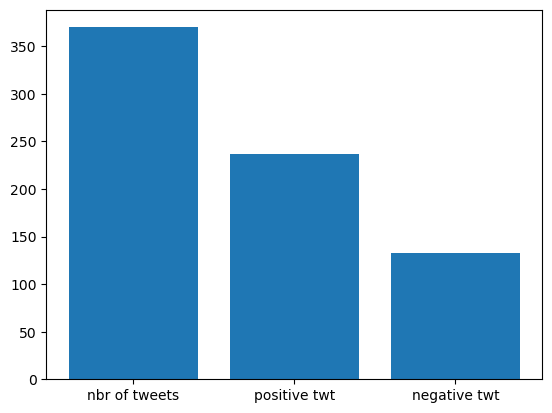

Insert data: [@theliamnissan @Dixie202021 The other manufacturers would gobble up any opening in the EV market that Tesla’s failed experiment leaves., Youtalkingtume ]
nombre of tweets : 371
nombre de positive tweets :  238
nombre de negative tweets  : 133
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@theliamnissan, @dixie202021, manufacturers, gobble, opening, ev, market, tesla\u2019s, failed, experiment, leaves.""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------+----------+



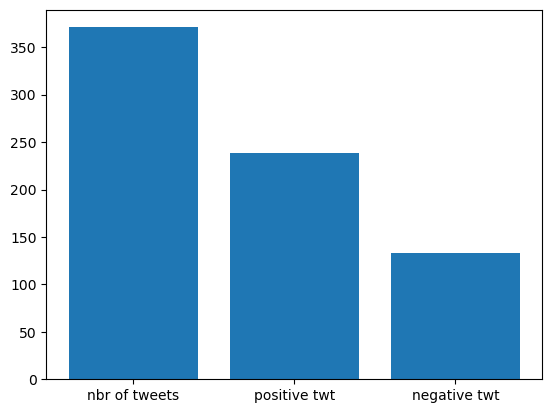

Insert data: [@WR4NYGov @elonmusk @jasondebolt There’s something real charming about using Tesla history analogies to describe Twitter’s current situation. It’s just a pain period, Elon is equipt for this, Den_Henson_ ]
nombre of tweets : 372
nombre de positive tweets :  239
nombre de negative tweets  : 133
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                            |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@wr4nygov, @elonmusk, @jasondebolt, there\u2019s, something, real, charming, using

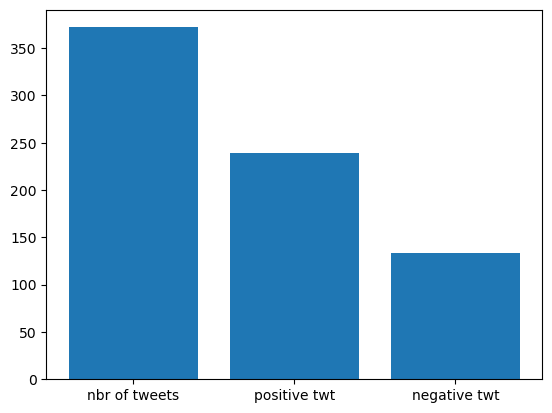

Insert data: [@maddass1218 @elonmusk @saxena_puru Yea? Watch in the next 12 months as other automakers go bankrupt and need federal bailouts.  Tesla will still be profitable.   And then think back about how myopic your viewpoint was.  Elon is allowed to exercise options.  That’s how he is paid.  It’s not a secret., thetomcane ]
nombre of tweets : 373
nombre de positive tweets :  239
nombre de negative tweets  : 134
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                                                                                                         |predi

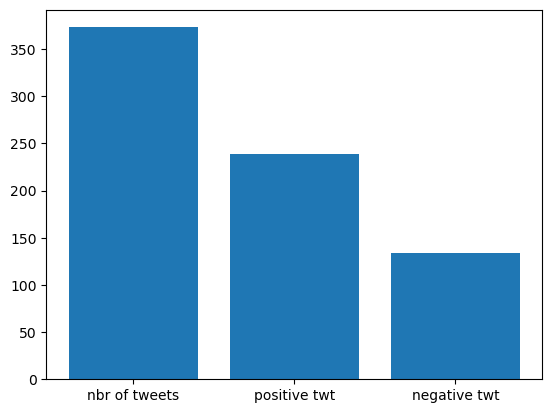

Insert data: [Covid, olvídese de Pfizer, Moderna… es Abdala; en Perú, 17 mmdd de inversión mexicana; el caso Tesla https://t.co/kbskSppGhg, millonario ]
nombre of tweets : 374
nombre de positive tweets :  240
nombre de negative tweets  : 134
+---------------+----------+
|MeaningfulWords|prediction|
+---------------+----------+
|["[""covid]    |4.0       |
+---------------+----------+



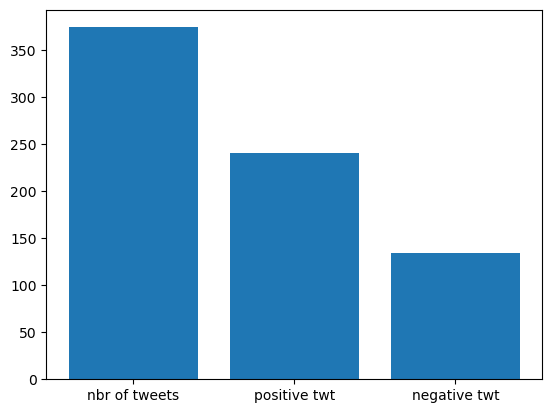

Insert data: [RT @gaps_j: Just imagining him putting the baby in a car seat and setting the Tesla to autopilot to ship it to Grimes like a package with n…, JoanJMP ]
nombre of tweets : 375
nombre de positive tweets :  241
nombre de negative tweets  : 134
+--------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                           |prediction|
+--------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gaps_j:, imagining, putting, baby, car, seat, setting, tesla, autopilot, ship, grimes, like, package, n\u2026""]|4.0       |
+--------------------------------------------------------------------------------------------------------------------------+----------+



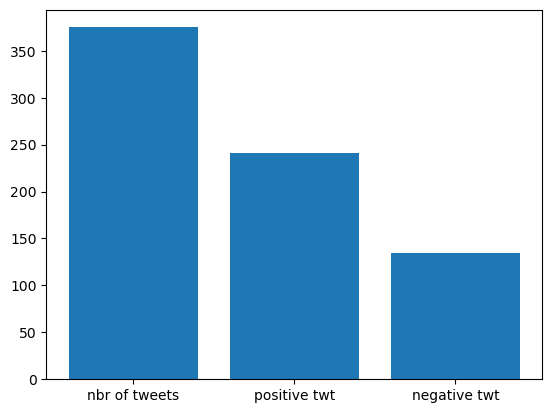

Insert data: [@Darknigh110 @Gravityzero1 @Anmol_Ra1na @athompson07 @neiltyson @elonmusk Feel like I'm failing a sarcasm test. Tesla's are not affordable or common., sparklebat ]
nombre of tweets : 376
nombre de positive tweets :  242
nombre de negative tweets  : 134
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@darknigh110, @gravityzero1, @anmol_ra1na, @athompson07, @neiltyson, @elonmusk, feel, like, failing, sarcasm, test., tesla's, affordable, common.""]|4.0       |
+----------------------------------------------------------------

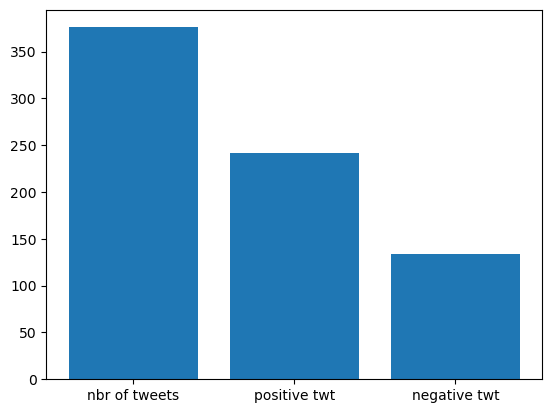

Insert data: [@Tesla_Spark31 @konyagooner @wazlzckalackalz @kalex_andre @FrenchHist Then why these tweets if you don't want to say they are not french ?, stephan10131 ]
nombre of tweets : 377
nombre de positive tweets :  242
nombre de negative tweets  : 135
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""@tesla_spark31, @konyagooner, @wazlzckalackalz, @kalex_andre, @frenchhist, tweets, want, say, french, ?""]|0.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



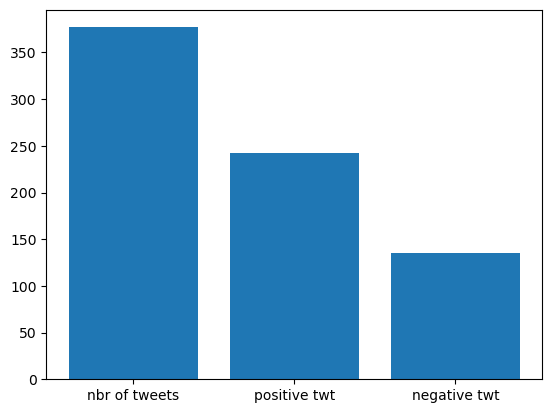

Insert data: [RT @jayrosen_nyu: Wall Street analyst for Oppenheimer, explaining why the firm downgraded Tesla's rating, says the owner of Twitter is gene…, nchacko ]
nombre of tweets : 378
nombre de positive tweets :  243
nombre de negative tweets  : 135
+------------------------------------------------------------+----------+
|MeaningfulWords                                             |prediction|
+------------------------------------------------------------+----------+
|["[""rt, @jayrosen_nyu:, wall, street, analyst, oppenheimer]|4.0       |
+------------------------------------------------------------+----------+



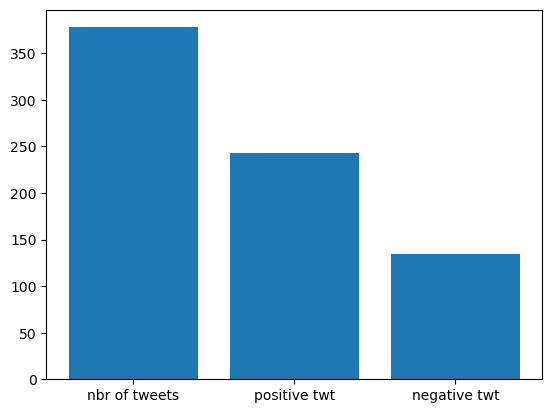

Insert data: [RT @GerberKawasaki: Tesla stock price now reflects the value of having no CEO. Great job tesla BOD - Time for a shake up. $tsla, AsakeWaMombasa ]
nombre of tweets : 379
nombre de positive tweets :  244
nombre de negative tweets  : 135
+----------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gerberkawasaki:, tesla, stock, price, reflects, value, ceo., great, job, tesla, bod, -, time, shake, up., $tsla""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------+----------+



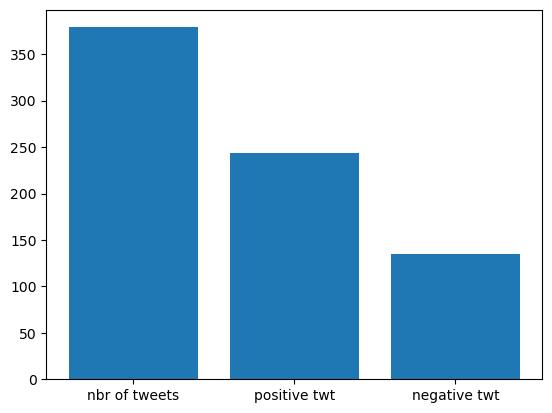

Insert data: [RT @WR4NYGov: @saxena_puru @heydave7 @elonmusk Fake Tesla bulls shit-talking Elon could just as easily be to blame for the stock price decl…, ESGESG1001 ]
nombre of tweets : 380
nombre de positive tweets :  245
nombre de negative tweets  : 135
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                            |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @wr4nygov:, @saxena_puru, @heydave7, @elonmusk, fake, tesla, bulls, shit-talking, elon, easily, blame, stock, price, decl\u2026""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------------

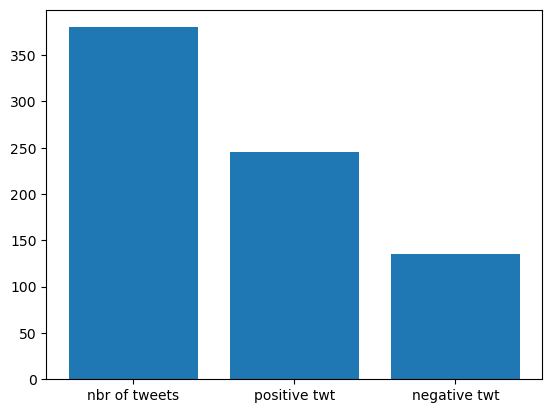

Insert data: [@elonmusk How much value are you going to have to destroy at Tesla and Twitter just to satisfy your ego?, DukeJeopardy ]
nombre of tweets : 381
nombre de positive tweets :  246
nombre de negative tweets  : 135
+-----------------------------------------------------------------------------+----------+
|MeaningfulWords                                                              |prediction|
+-----------------------------------------------------------------------------+----------+
|["[""@elonmusk, much, value, going, destroy, tesla, twitter, satisfy, ego?""]|4.0       |
+-----------------------------------------------------------------------------+----------+



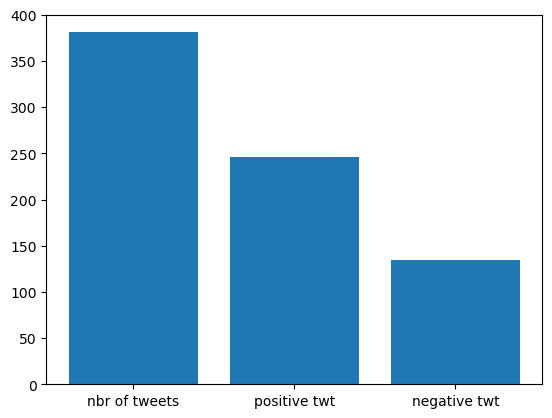

Insert data: [RT @GerberKawasaki: Tesla stock price now reflects the value of having no CEO. Great job tesla BOD - Time for a shake up. $tsla, somdas65 ]
nombre of tweets : 382
nombre de positive tweets :  247
nombre de negative tweets  : 135
+----------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                             |prediction|
+----------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gerberkawasaki:, tesla, stock, price, reflects, value, ceo., great, job, tesla, bod, -, time, shake, up., $tsla""]|4.0       |
+----------------------------------------------------------------------------------------------------------------------------+----------+



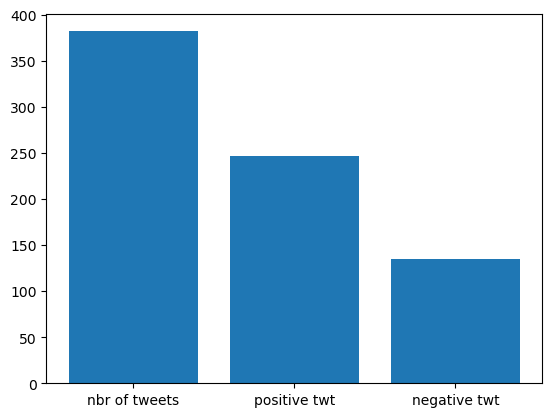

Insert data: [@SenWarren @Twitter @Tesla You are as crooked as @GaryGensler women!, ThatsCryptoman ]
nombre of tweets : 383
nombre de positive tweets :  247
nombre de negative tweets  : 136
+-------------------------------------------------------------------+----------+
|MeaningfulWords                                                    |prediction|
+-------------------------------------------------------------------+----------+
|["[""@senwarren, @twitter, @tesla, crooked, @garygensler, women!""]|0.0       |
+-------------------------------------------------------------------+----------+



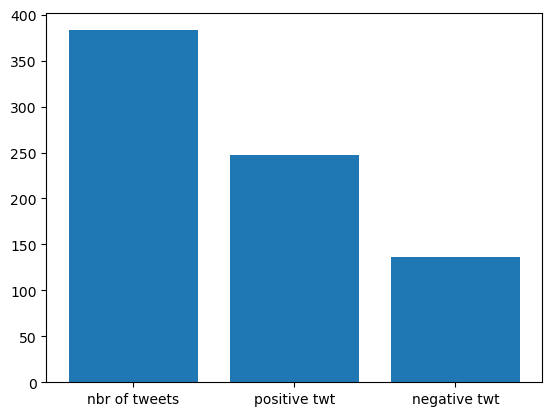

Insert data: [RT @GailAlfarATX: “Depending on date of manufacture, some vehicles include USB port linside glovebox. This USB-A port is equipped with a pr…, 9600cord ]
nombre of tweets : 384
nombre de positive tweets :  247
nombre de negative tweets  : 137
+------------------------------------------------------------+----------+
|MeaningfulWords                                             |prediction|
+------------------------------------------------------------+----------+
|["[""rt, @gailalfaratx:, \u201cdepending, date, manufacture]|0.0       |
+------------------------------------------------------------+----------+



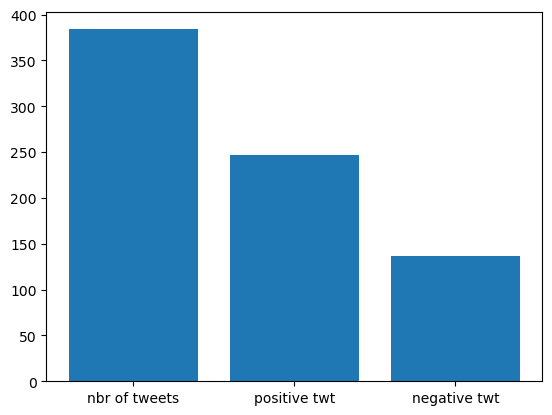

Insert data: [Ive made this harder on elon the whole way by being so angry and effectively derisive, schizo anon incel not caring, thinking everything was fucked no matter what so by doing nothing i made it worse.  The last clause is me not doing my work, not re: tesla., ricochicomico1 ]
nombre of tweets : 385
nombre de positive tweets :  247
nombre de negative tweets  : 138
+-----------------------------------------------------------------------+----------+
|MeaningfulWords                                                        |prediction|
+-----------------------------------------------------------------------+----------+
|["[""ive, made, harder, elon, whole, way, angry, effectively, derisive]|0.0       |
+-----------------------------------------------------------------------+----------+



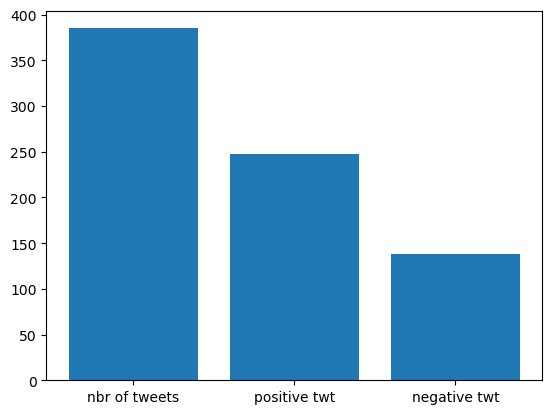

Insert data: [@JakeCharlsey94 @NickPin45026492 @ChiroCam @Kyle30hx @POTUS You do realize that your average Joe can't afford a tesla. Lol. Hell millions of Americans can't afford any type of new or used car. That's basic reality..., TerryMa00901655 ]
nombre of tweets : 386
nombre de positive tweets :  247
nombre de negative tweets  : 139
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                                                  |prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@jakecharlsey94, @nickpin45026492,

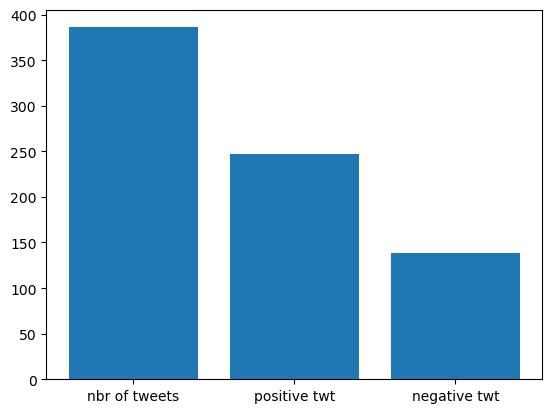

Insert data: [RT @Tesla: Fit enough stuff in the trunk so you can survive in a place without a fridge or a radiator or a Live Laugh Love poster.

Who's p…, purevdo27046751 ]
nombre of tweets : 387
nombre de positive tweets :  248
nombre de negative tweets  : 139
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                        |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, fit, enough, stuff, trunk, survive, place, without, fridge, radiator, live, laugh, love, poster.\n\nwho's, p\u2026""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------------------+----

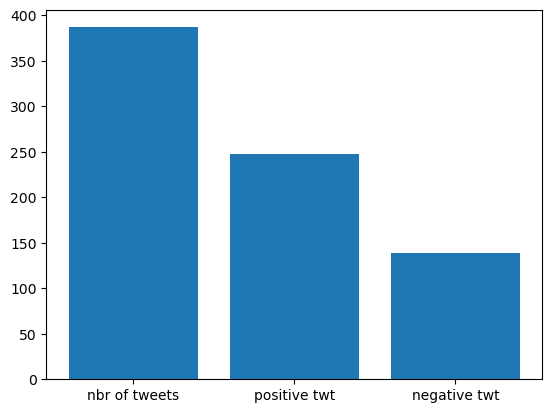

Insert data: [RT @ClaraJeffery: @elonmusk Good luck Tesla shareholders! Down 8% just today., Definit02209600 ]
nombre of tweets : 388
nombre de positive tweets :  249
nombre de negative tweets  : 139
+-----------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                    |prediction|
+-----------------------------------------------------------------------------------+----------+
|["[""rt, @clarajeffery:, @elonmusk, good, luck, tesla, shareholders!, 8%, today.""]|4.0       |
+-----------------------------------------------------------------------------------+----------+



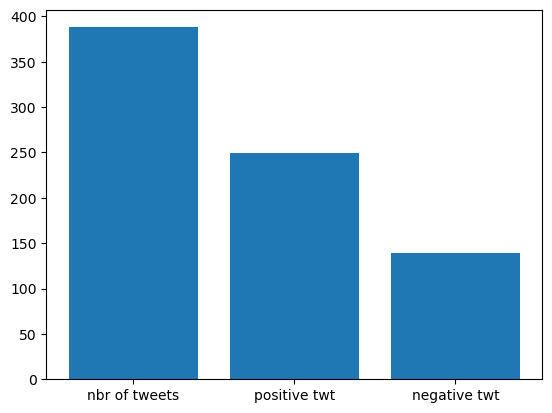

Insert data: [@teru_tesla ほおお！
めちゃありがとうございます！, pochi2100 ]
nombre of tweets : 389
nombre de positive tweets :  250
nombre de negative tweets  : 139
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                    |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@teru_tesla, \u307b\u304a\u304a\uff01\n\u3081\u3061\u3083\u3042\u308a\u304c\u3068\u3046\u3054\u3056\u3044\u307e\u3059\uff01""]|4.0       |
+-----------------------------------------------------------------------------------------------------------------------------------+----------+



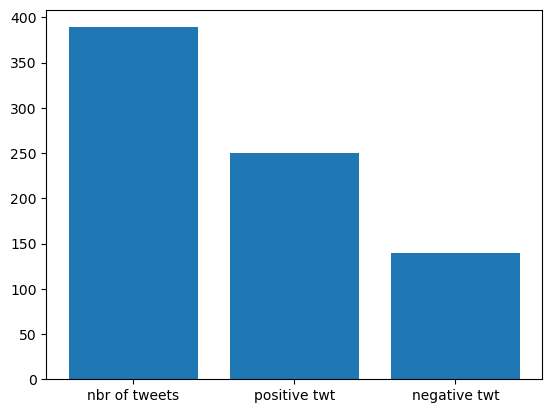

Insert data: [RT @Tesla: The Tesla S P100D goes from 0-60mph in 2.4 seconds. 

What else can you get done in that time?, purevdo27046751 ]
nombre of tweets : 390
nombre de positive tweets :  251
nombre de negative tweets  : 139
+-------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                  |prediction|
+-------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, tesla, p100d, goes, 0-60mph, 2.4, seconds., \n\nwhat, else, get, done, time?""]|4.0       |
+-------------------------------------------------------------------------------------------------+----------+



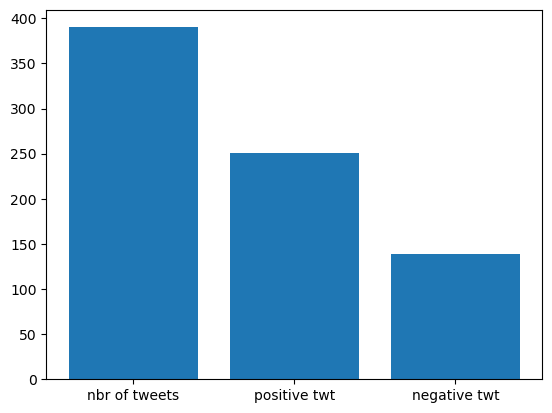

Insert data: [RT @OfProbability: @TeslaBoomerMama @EmmetPeppers @elonmusk @GerberKawasaki @Tesla 💯
you can enable free speech
but limit the political out…, 1ISOtruth ]
nombre of tweets : 391
nombre de positive tweets :  251
nombre de negative tweets  : 140
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @ofprobability:, @teslaboomermama, @emmetpeppers, @elonmusk, @gerberkawasaki, @tesla, \ud83d\udcaf\nyou, enable, free, speech\nbut, limit, political, out\u2026""]|0.0       |
+--

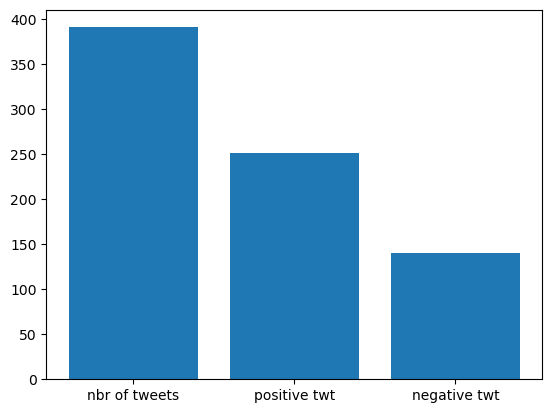

Insert data: [RT @muglikar_: Toyota halts expansion in India, Tesla says taxes are high on cars, today Maruti Chairman says 50% tax on cars will kill the…, crim3addict ]
nombre of tweets : 392
nombre de positive tweets :  252
nombre de negative tweets  : 140
+------------------------------------------------------+----------+
|MeaningfulWords                                       |prediction|
+------------------------------------------------------+----------+
|["[""rt, @muglikar_:, toyota, halts, expansion, india]|4.0       |
+------------------------------------------------------+----------+



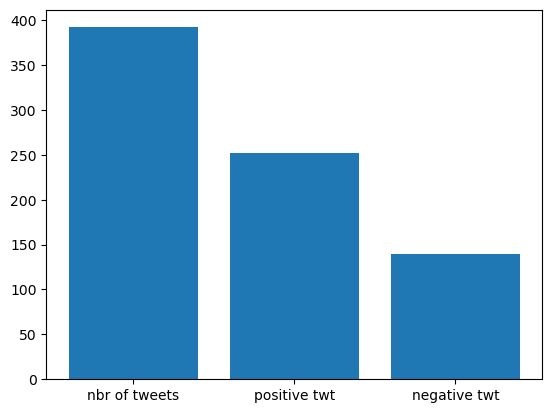

Insert data: [RT @Tesla: May every one of them grow up into accomplished inventors and/or electric vehicles.

https://t.co/ZMaubJvyP1, purevdo27046751 ]
nombre of tweets : 393
nombre de positive tweets :  253
nombre de negative tweets  : 140
+---------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                            |prediction|
+---------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, may, every, one, grow, accomplished, inventors, and/or, electric, vehicles.\n\nhttps://t.co/zmaubjvyp1""]|4.0       |
+---------------------------------------------------------------------------------------------------------------------------+----------+



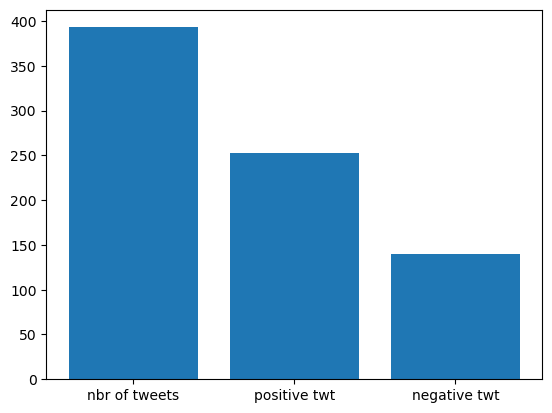

Insert data: [Elon Musk : le patron de Tesla annonce la démission de Twitter https://t.co/UYFUaffZMU, LaCryptoMonnai1 ]
nombre of tweets : 394
nombre de positive tweets :  254
nombre de negative tweets  : 140
+---------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                |prediction|
+---------------------------------------------------------------------------------------------------------------+----------+
|["[""elon, musk, :, le, patron, de, tesla, annonce, la, d\u00e9mission, de, twitter, https://t.co/uyfuaffzmu""]|4.0       |
+---------------------------------------------------------------------------------------------------------------+----------+



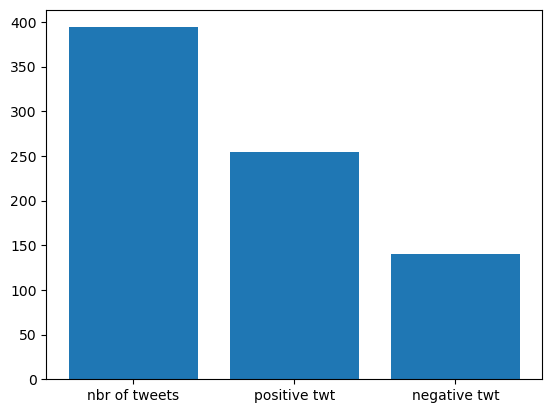

Insert data: [@ryota_tesla 黒は保ち難いイメージありますよね
しかしビューティフルカーズ製品と
方法であれば簡単です。
イージーグロスコートナノやプラスくらいの撥水が一番傷やシミになり難いと思います
ベースのコーティング近くにビューティフルカーズがあればご相談ください
日が当たるとこんな感じです https://t.co/qC85KsBnZl, QnMKUH6Lwexxkic ]
nombre of tweets : 395
nombre de positive tweets :  255
nombre de negative tweets  : 140
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

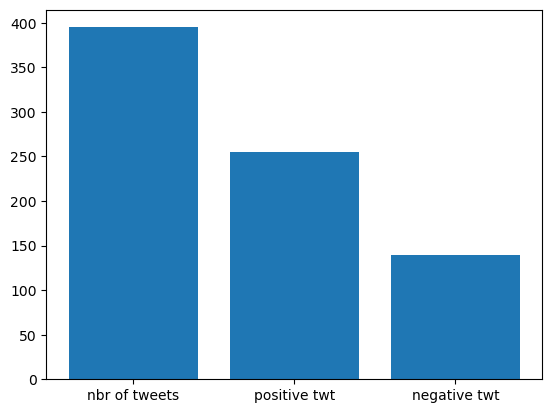

Insert data: [@includeuni Amigo, o gráfico que puseste ilustra na perfeição a discrepância entre a Tesla e o mercado em geral…, afonso_axe ]
nombre of tweets : 396
nombre de positive tweets :  256
nombre de negative tweets  : 140
+------------------------+----------+
|MeaningfulWords         |prediction|
+------------------------+----------+
|["[""@includeuni, amigo]|4.0       |
+------------------------+----------+



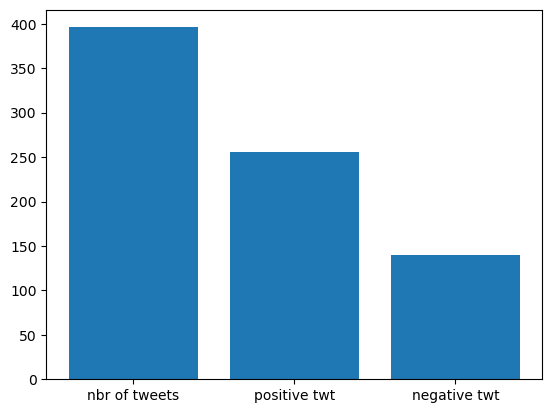

Insert data: [@MarkEJordan1 @SenWarren @Twitter @Tesla Maybe you should keep riding and never let go! 😁 https://t.co/RoJOwwgZhk, MrColinBoyd ]
nombre of tweets : 397
nombre de positive tweets :  256
nombre de negative tweets  : 141
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                 |prediction|
+--------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""@markejordan1, @senwarren, @twitter, @tesla, maybe, keep, riding, never, let, go!, \ud83d\ude01, https://t.co/rojowwgzhk""]|0.0       |
+--------------------------------------------------------------------------------------------------------------------------------+----------+



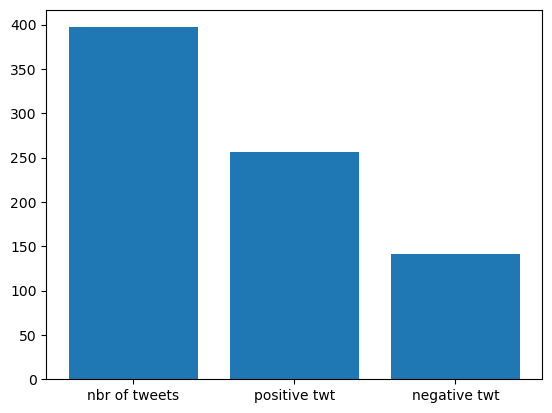

Insert data: [RT @Tesla: Don't let your cowboy hat get in the way of your dreams 🤠 https://t.co/8fkD68tVfw, purevdo27046751 ]
nombre of tweets : 398
nombre de positive tweets :  257
nombre de negative tweets  : 141
+----------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                               |prediction|
+----------------------------------------------------------------------------------------------+----------+
|["[""rt, @tesla:, let, cowboy, hat, get, way, dreams, \ud83e\udd20, https://t.co/8fkd68tvfw""]|4.0       |
+----------------------------------------------------------------------------------------------+----------+



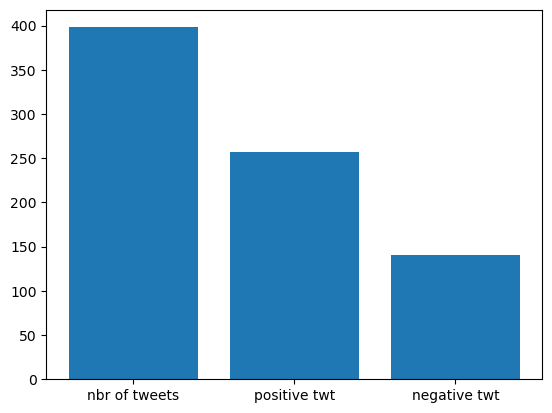

Insert data: [RT @GerberKawasaki: @elonmusk As i tweeted earlier... My three points 1. Tesla needs a media and comms team. 2. Tesla needs a succession pl…, skyrocketgogo ]
nombre of tweets : 399
nombre de positive tweets :  257
nombre de negative tweets  : 142
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                                                                           |prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @gerberkawasaki:, @elonmusk, tweeted, earlier..., three, points, 1., tesla, needs, media, comms, team., 2., tesla, needs, succession, pl\u2026""]|0.0       |
+------------------------------------------------------------------

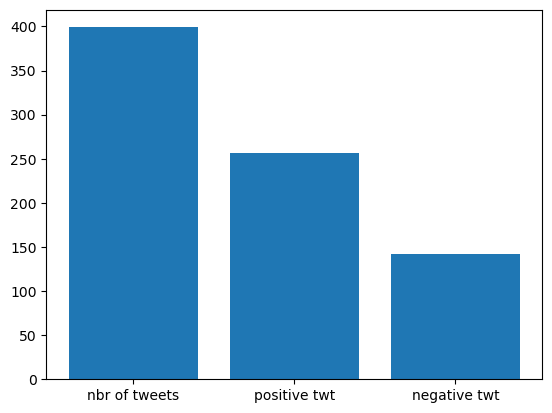

Insert data: [RT @VaushV: Just a few more days and Elon will be banning people for doxxing Tesla’s exact stock value in real time, beltwayresident ]
nombre of tweets : 400
nombre de positive tweets :  258
nombre de negative tweets  : 142
+---------------------------------------------------------------------------------------------------------+----------+
|MeaningfulWords                                                                                          |prediction|
+---------------------------------------------------------------------------------------------------------+----------+
|["[""rt, @vaushv:, days, elon, banning, people, doxxing, tesla\u2019s, exact, stock, value, real, time""]|4.0       |
+---------------------------------------------------------------------------------------------------------+----------+



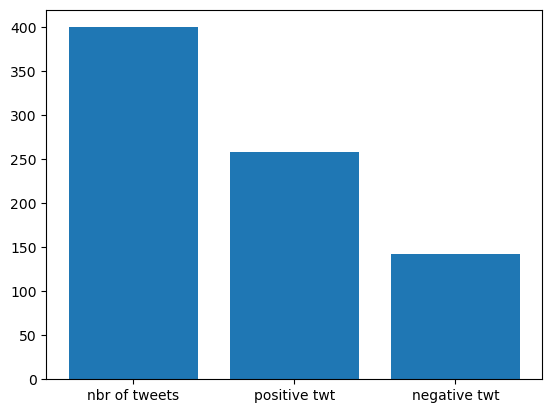

In [30]:
if __name__ == '__main__':
    val=[]
    id=0
    nbr=0
    positif=0
    negativ=0
    parsed_topic_name = 'twitter-topic'
    consumer = KafkaConsumer(parsed_topic_name, auto_offset_reset='earliest', bootstrap_servers=['localhost:9092'], api_version=(0, 10), consumer_timeout_ms=1000)
    for msg in consumer:
        record = json.loads(msg.value)
        text = record[0]
        text2 = record[1]     
        
        id += 1 
        row = '{}'.format(id) 
        
        data = {'id': row, 'tweet.full_text': text, 'tweet.user.screen_name': text2}
        
       
        insert_row(table, data)
        values=msg.value.decode('utf-8').splitlines()
        val.append(values)
        df=pd.DataFrame(values,columns=['text'])
        df.to_csv('tweet.parquet.csv')
        tweets_csv = spark.read.csv('tweet.parquet.csv', inferSchema=True, header=True)
        tokenizedTest = tokenizer.transform(tweets_csv)
        SwRemovedTest = swr.transform(tokenizedTest)
        numericTest = hashtf.transform(SwRemovedTest).select('MeaningfulWords', 'features')
        prediction = model.transform(numericTest)
        predictionFinal = prediction.select("MeaningfulWords", "prediction")
        ypoints = np.array([nbr,positif,negativ])
       
        nbr=nbr+1
        if (predictionFinal.first().prediction == 4):
            positif=positif+1
        else:
            negativ=negativ+1
        print("nombre of tweets : "+ str(nbr))
        print("nombre de positive tweets :  "+ str(positif))
        print("nombre de negative tweets  : "+ str(negativ))
        
        predictionFinal.show(truncate = False)
        import matplotlib.pyplot as plt
        import numpy as np
        # X axis parameter:
        xaxis = np.array(["nbr of tweets", "positive twt","negative twt"])

        # Y axis parameter:
        yaxis = np.array([nbr,positif,negativ])

        plt.bar(xaxis, yaxis)
        # Creating plot
    
        # show plot
        plt.show()
       

    
 
    